In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

## iCESM Pi Control TP field vs. SAM, PSA1, PSA2, ASL CP Long. Position, SOI, Nino34, ASL CP Long. Position, and ASL CP Value
## Now includes vs. PDO (26Feb2019)

### Plot 5x1 (DJF, MAM, JJA, SON, ANN)
### no rolls (for some reason some are blank due to a unknown mask error)

In [2]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pylab as pylab
import matplotlib.path as mpath
import datetime
import pandas as pd
from scipy.stats.stats import pearsonr
from scipy.stats import ttest_ind
from scipy import signal
from IPython.display import display
import xarray as xr
import dask as da
from dask.distributed import Client, LocalCluster
from dask.diagnostics import ProgressBar
from dask.array.rechunk import rechunk
from mpl_toolkits.basemap import Basemap, addcyclic
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.colors as colors
import statsmodels.api as sm
from cartopy.util import add_cyclic_point
import netCDF4
from scipy import stats
import matplotlib.pyplot as plt

#for era
# from eofs.xarray import Eof
# from eofs.examples import example_data_path
# np.seterr(divide='ignore', invalid='ignore')

%matplotlib inline

In [3]:
############# to be set #############

                         
##Load ERA indice .pkl's
PICKLE_PATH = '/glade/work/pgoddard/Clay_AA_Research/AA_Tropical_Teleconnections/Save_Indices_as_CSV_19Nov2018'

##Save figure file path
FIG_PATH = '/glade/work/pgoddard/Clay_AA_Research/AA_Tropical_Teleconnections/Figures_For_REVIEW_Submission_24March2021'

##Load CTRL netcdf as Xarray
CTRL_DATA_PATH = '/glade/work/pgoddard/Clay_AA_Research/AA_Tropical_Teleconnections/Save_CTRL_LGM_ERA_Xarrays_as_netcdf_31Oct2018'
CTRL_DATA = xr.open_dataset(CTRL_DATA_PATH+'/CTRL_DATA_TAGGED.nc')
CTRL_DATA

<xarray.Dataset>
Dimensions:       (lat: 96, lon: 144, time: 912)
Coordinates:
  * time          (time) datetime64[ns] 1701-01-31 1701-02-28 ... 1776-12-31
  * lat           (lat) float64 -90.0 -88.11 -86.21 -84.32 ... 86.21 88.11 90.0
  * lon           (lon) float64 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
Data variables: (12/61)
    land_frac     (time, lat, lon) float32 ...
    sst           (time, lat, lon) float32 ...
    msl           (time, lat, lon) float32 ...
    u10           (time, lat, lon) float32 ...
    v10           (time, lat, lon) float32 ...
    t2m           (time, lat, lon) float32 ...
    ...            ...
    tp_Ind_65     (time, lat, lon) float32 ...
    tp_Ind_75     (time, lat, lon) float32 ...
    d18O_AA_ice   (time, lat, lon) float32 ...
    d18O_AA_land  (time, lat, lon) float32 ...
    tp_AA_ice     (time, lat, lon) float32 ...
    tp_AA_land    (time, lat, lon) float32 ...

In [4]:
#getting variables in right units 
slp_tmon_ctrl = CTRL_DATA.data_vars['msl']/100 #hPa
v10_tmon_ctrl = CTRL_DATA.data_vars['v10'] #in m/s at 10m
u10_tmon_ctrl = CTRL_DATA.data_vars['u10'] #in m/s at 10m
t2m_tmon_ctrl = CTRL_DATA.data_vars['t2m']-273.15 #in C
tp_tmon_ctrl  = CTRL_DATA.data_vars['tp']*60*60*24*1000  #in mm/day
ci_tmon_ctrl  = CTRL_DATA.data_vars['ci'] #in [0-1] fraction of sea ice
sst_tmon_ctrl  = CTRL_DATA.data_vars['sst']-273.15 #Equivalent to SST over ocean in C
d18O_tmon_ctrl = CTRL_DATA.data_vars['d18O'] #per mill
land_tmon_ctrl = CTRL_DATA.data_vars['land_frac']

In [5]:
#sst_tmon_ctrl

In [6]:
#Open pandas dfs of all indices and ASL information
# pdo_index_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_pdo_tmon.pkl')
# # pdo_index_ctrl.head(n=5)
# pdo_seas_mean_index_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_pdo_seas.pkl')
# # pdo_seas_mean_index_ctrl.head(n=5)
# pdo_ann_mean_index_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_pdo_ann_mean.pkl')
# # pdo_ann_mean_index_ctrl.head(n=5)

# soi_index_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_soi_tmon.pkl')
# # soi_index_ctrl.head(n=5)
# soi_seas_mean_index_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_soi_seas.pkl')
# # soi_seas_mean_index_ctrl.head(n=5)
# soi_ann_mean_index_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_soi_ann_mean.pkl')
# # soi_ann_mean_index_ctrl.head(n=5)
# soi_12roll_mean_index_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_soi_12roll_mean.pkl')
# # soi_12roll_mean_index_ctrl.head(n=10)
# soi_6roll_mean_index_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_soi_6roll_mean.pkl')
# # soi_6roll_mean_index_ctrl.head(n=5)
# soi_3roll_mean_index_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_soi_3roll_mean.pkl')
# # soi_3roll_mean_index_ctrl.head(n=5)
# soi_band_filt_index_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_soi_band_filt.pkl')
# # soi_band_filt_index_ctrl.head(n=5)

# nino34_index_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_nino34_tmon.pkl')
# # nino34_index_ctrl.head(n=5)
# nino34_seas_mean_index_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_nino34_seas.pkl')
# # nino34_seas_mean_index_ctrl.head(n=5)
# nino34_ann_mean_index_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_nino34_ann_mean.pkl')
# # nino34_ann_mean_index_ctrl.head(n=5)
# nino34_12roll_mean_index_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_nino34_12roll_mean.pkl')
# # nino34_12roll_mean_index_ctrl.head(n=10)
# nino34_6roll_mean_index_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_nino34_6roll_mean.pkl')
# # nino34_6roll_mean_index_ctrl.head(n=5)
# nino34_3roll_mean_index_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_nino34_3roll_mean.pkl')
# # nino34_3roll_mean_index_ctrl.head(n=5)
# nino34_band_filt_index_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_nino34_band_filt.pkl')
# # nino34_band_filt_index_ctrl.head(n=5)

# enso_indices_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_epcs_tmon.pkl')
# # enso_indices_ctrl.head(n=5)
# enso_seas_mean_indices_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_epcs_seas.pkl')
# # enso_seas_mean_indices_ctrl.head(n=5)
# enso_ann_mean_indices_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_epcs_ann_mean.pkl')
# # enso_ann_mean_indices_ctrl.head(n=5)
# enso_12roll_mean_indices_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_epcs_12roll_mean.pkl')
# # enso_12roll_mean_indices_ctrl.head(n=10)
# enso_6roll_mean_indices_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_epcs_6roll_mean.pkl')
# # enso_6roll_mean_indices_ctrl.head(n=5)
# enso_3roll_mean_indices_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_epcs_3roll_mean.pkl')
# # enso_3roll_mean_indices_ctrl.head(n=5)
# enso_band_filt_indices_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_epcs_band_filt.pkl')
# # enso_band_filt_indices_ctrl.head(n=5)

SAM_PSAs_indices_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_sam_psas_tmon.pkl')
# SAM_PSAs_indices_ctrl.head(n=5)
SAM_PSAs_seas_mean_indices_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_sam_psas_seas.pkl')
# SAM_PSAs_seas_mean_indices_ctrl.head(n=5)
SAM_PSAs_ann_mean_indices_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_sam_psas_ann_mean.pkl')
print(SAM_PSAs_ann_mean_indices_ctrl.head(n=5))
SAM_PSAs_12roll_mean_indices_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_sam_psas_12roll_mean.pkl')
# SAM_PSAs_12roll_mean_indices_ctrl.head(n=10)
SAM_PSAs_6roll_mean_indices_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_sam_psas_6roll_mean.pkl')
# SAM_PSAs_6roll_mean_indices_ctrl.head(n=5)
SAM_PSAs_3roll_mean_indices_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_sam_psas_3roll_mean.pkl')
# SAM_PSAs_3roll_mean_indices_ctrl.head(n=5)
SAM_PSAs_band_filt_indices_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_sam_psas_band_filt.pkl')
# SAM_PSAs_band_filt_indices_ctrl.head(n=5)

df_d18O_psuedoWDC_tmon_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_d18O_psuedoWDC_tmon.pkl')
# df_d18O_psuedoWDC_tmon_ctrl.head(n=5)
d18O_psuedoWDC_seas_mean_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_d18O_psuedoWDC_seas.pkl')
# d18O_psuedoWDC_seas_mean_ctrl.head(n=5)
d18O_psuedoWDC_ann_mean_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_d18O_psuedoWDC_ann_mean.pkl')
# d18O_psuedoWDC_ann_mean_ctrl.head(n=5)
d18O_psuedoWDC_12roll_mean_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_d18O_psuedoWDC_12roll_mean.pkl')
# d18O_psuedoWDC_12roll_mean_ctrl.head(n=10)
d18O_psuedoWDC_6roll_mean_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_d18O_psuedoWDC_6roll_mean.pkl')
# d18O_psuedoWDC_6roll_mean_ctrl.head(n=5)
d18O_psuedoWDC_3roll_mean_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_d18O_psuedoWDC_3roll_mean.pkl')
# d18O_psuedoWDC_3roll_mean_ctrl.head(n=5)
d18O_psuedoWDC_band_filt_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_d18O_psuedoWDC_band_filt.pkl')
# d18O_psuedoWDC_band_filt_ctrl.head(n=5)

# df_d18O_psuedowestcore_tmon_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_d18O_psuedowestcore_tmon.pkl')
# # df_d18O_psuedowestcore_tmon_ctrl.head(n=5)
# d18O_psuedowestcore_seas_mean_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_d18O_psuedowestcore_seas.pkl')
# # d18O_psuedowestcore_seas_mean_ctrl.head(n=5)
# d18O_psuedowestcore_ann_mean_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_d18O_psuedowestcore_ann_mean.pkl')
# # d18O_psuedowestcore_ann_mean_ctrl.head(n=5)
# d18O_psuedowestcore_12roll_mean_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_d18O_psuedowestcore_12roll_mean.pkl')
# # d18O_psuedowestcore_12roll_mean_ctrl.head(n=10)
# d18O_psuedowestcore_6roll_mean_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_d18O_psuedowestcore_6roll_mean.pkl')
# # d18O_psuedowestcore_6roll_mean_ctrl.head(n=5)
# d18O_psuedowestcore_3roll_mean_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_d18O_psuedowestcore_3roll_mean.pkl')
# # d18O_psuedowestcore_3roll_mean_ctrl.head(n=5)
# d18O_psuedowestcore_band_filt_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_d18O_psuedowestcore_band_filt.pkl')
# # d18O_psuedowestcore_band_filt_ctrl.head(n=5)

# df_d18O_psuedoeastcore_tmon_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_d18O_psuedoeastcore_tmon.pkl')
# # df_d18O_psuedoeastcore_tmon_ctrl.head(n=5)
# d18O_psuedoeastcore_seas_mean_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_d18O_psuedoeastcore_seas.pkl')
# # d18O_psuedoeastcore_seas_mean_ctrl.head(n=5)
# d18O_psuedoeastcore_ann_mean_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_d18O_psuedoeastcore_ann_mean.pkl')
# # d18O_psuedoeastcore_ann_mean_ctrl.head(n=5)
# d18O_psuedoeastcore_12roll_mean_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_d18O_psuedoeastcore_12roll_mean.pkl')
# # d18O_psuedoeastcore_12roll_mean_ctrl.head(n=10)
# d18O_psuedoeastcore_6roll_mean_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_d18O_psuedoeastcore_6roll_mean.pkl')
# # d18O_psuedoeastcore_6roll_mean_ctrl.head(n=5)
# d18O_psuedoeastcore_3roll_mean_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_d18O_psuedoeastcore_3roll_mean.pkl')
# # d18O_psuedoeastcore_3roll_mean_ctrl.head(n=5)
# d18O_psuedoeastcore_band_filt_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_d18O_psuedoeastcore_band_filt.pkl')
# # d18O_psuedoeastcore_band_filt_ctrl.head(n=5)

# d18O_wais_pcs_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_d18O_wais_pcs_tmon.pkl')
# # d18O_wais_pcs_ctrl.head(n=5)
# d18O_wais_pcs_seas_mean_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_d18O_wais_pcs_seas.pkl')
# # d18O_wais_pcs_seas_mean_ctrl.head(n=5)
# d18O_wais_pcs_ann_mean_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_d18O_wais_pcs_ann_mean.pkl')
# # d18O_wais_pcs_ann_mean_ctrl.head(n=5)
# d18O_wais_pcs_12roll_mean_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_d18O_wais_pcs_12roll_mean.pkl')
# # d18O_wais_pcs_12roll_mean_ctrl.head(n=12)
# d18O_wais_pcs_6roll_mean_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_d18O_wais_pcs_6roll_mean.pkl')
# # d18O_wais_pcs_6roll_mean_ctrl.head(n=5)
# d18O_wais_pcs_3roll_mean_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_d18O_wais_pcs_3roll_mean.pkl')
# # d18O_wais_pcs_3roll_mean_ctrl.head(n=5)
# d18O_wais_pcs_band_filt_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_d18O_wais_pcs_band_filt.pkl')
# # d18O_wais_pcs_band_filt_ctrl.head(n=5)

# monthly_Rel_CP_Anoms_Detrend_Norm_loc_info_ctrl_tagged_df = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_Rel_CP_tmon.pkl')
# # monthly_Rel_CP_Anoms_Detrend_Norm_loc_info_ctrl_tagged_df.head(n=5)
# Rel_CP_seas_mean_indices_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_Rel_CP_seas_mean.pkl')
# # Rel_CP_seas_mean_indices_ctrl.head(n=5)
# Rel_CP_ann_mean_indices_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_Rel_CP_ann_mean.pkl')
# # Rel_CP_ann_mean_indices_ctrl.head(n=5)
# Rel_CP_12roll_mean_indices_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_Rel_CP_12roll_mean.pkl')
# # Rel_CP_12roll_mean_indices_ctrl.head(n=10)
# Rel_CP_6roll_mean_indices_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_Rel_CP_6roll_mean.pkl')
# # Rel_CP_6roll_mean_indices_ctrl.head(n=5)
# Rel_CP_3roll_mean_indices_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_Rel_CP_3roll_mean.pkl')
# # Rel_CP_3roll_mean_indices_ctrl.head(n=5)
# Rel_CP_band_filt_indices_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_Rel_CP_band_filt.pkl')
# # Rel_CP_band_filt_indices_ctrl.head(n=5)

# monthly_Abs_CP_Anoms_Detrend_Norm_loc_info_ctrl_tagged_df = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_Abs_CP_tmon.pkl')
# # monthly_Abs_CP_Anoms_Detrend_Norm_loc_info_ctrl_tagged_df.head(n=5)
# Abs_CP_seas_mean_indices_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_Abs_CP_seas_mean.pkl')
# # Abs_CP_seas_mean_indices_ctrl.head(n=5)
# Abs_CP_ann_mean_indices_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_Abs_CP_ann_mean.pkl')
# # Abs_CP_ann_mean_indices_ctrl.head(n=5)
# Abs_CP_12roll_mean_indices_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_Abs_CP_12roll_mean.pkl')
# # Abs_CP_12roll_mean_indices_ctrl.head(n=10)
# Abs_CP_6roll_mean_indices_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_Abs_CP_6roll_mean.pkl')
# # Abs_CP_6roll_mean_indices_ctrl.head(n=5)
# Abs_CP_3roll_mean_indices_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_Abs_CP_3roll_mean.pkl')
# # Abs_CP_3roll_mean_indices_ctrl.head(n=5)
# Abs_CP_band_filt_indices_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_Abs_CP_band_filt.pkl')
# # Abs_CP_band_filt_indices_ctrl.head(n=5)



#Raw Rel and Abs CP Info .... needed for actual lon lat position and values
# monthly_Rel_CP_raw_ctrl_tagged_df = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_Rel_CP_Raw_Info_tmon.pkl')
# monthly_Rel_CP_raw_ctrl_tagged_df.head(n=5)
Rel_CP_djf_mean_indices_raw_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_ASL_CP_raw_info_djf_mean.pkl')
# Rel_CP_djf_mean_indices_raw_ctrl.head(n=5)
Rel_CP_mam_mean_indices_raw_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_ASL_CP_raw_info_mam_mean.pkl')
# Rel_CP_mam_mean_indices_raw_ctrl.head(n=5)
Rel_CP_jja_mean_indices_raw_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_ASL_CP_raw_info_jja_mean.pkl')
# Rel_CP_jja_mean_indices_raw_ctrl.head(n=5)
Rel_CP_son_mean_indices_raw_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_ASL_CP_raw_info_son_mean.pkl')
# Rel_CP_son_mean_indices_raw_ctrl.head(n=5)
Rel_CP_ann_mean_indices_raw_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_ASL_CP_raw_info_ann_mean.pkl')
print(Rel_CP_ann_mean_indices_raw_ctrl.head(n=5))
Rel_CP_12roll_mean_indices_raw_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_ASL_CP_raw_info_12roll_mean.pkl')
# Rel_CP_12roll_mean_indices_raw_ctrl.head(n=10)
Rel_CP_6roll_mean_indices_raw_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_ASL_CP_raw_info_6roll_mean.pkl')
# Rel_CP_6roll_mean_indices_raw_ctrl.head(n=5)
Rel_CP_3roll_mean_indices_raw_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_ASL_CP_raw_info_3roll_mean.pkl')
# Rel_CP_3roll_mean_indices_raw_ctrl.head(n=5)
# Rel_CP_band_filt_indices_raw_ctrl = pd.read_pickle(PICKLE_PATH+'/ctrl_tagged_Rel_CP_Raw_Info_band_filt.pkl')
# # Rel_CP_band_filt_indices_raw_ctrl.head(n=5)


                 SAM      PSA1      PSA2
time                                    
1702-01-01 -0.311936 -0.015404  0.094802
1703-01-01 -0.819279  0.553104  0.060246
1704-01-01 -0.714730  0.496267 -0.208190
1705-01-01 -0.431827  0.106548 -0.660348
1706-01-01  0.391807 -0.572466  0.115213
                vals       lats   lons  sectormean  indice
time                                                      
1702-01-01 -5.477830 -71.052632  197.5  986.772813       0
1703-01-01 -5.095673 -71.052632  195.0  989.296173       1
1704-01-01 -4.715917 -71.052632  205.0  989.053075       2
1705-01-01 -7.214285 -71.052632  205.0  987.087820       3
1706-01-01 -6.000570 -71.052632  207.5  982.878988       4


In [7]:
# enso_seas_mean_indices_ctrl.head(n=5)

In [8]:
Rel_CP_djf_mean_indices_raw_ctrl.head(n=5)

,vals,lats,lons,sectormean,indice
time,,,,,
1702-12-01,-4.536918,-69.157895,285.0,991.552848,0
1703-12-01,-4.965650,-65.368421,280.0,991.921216,1
1704-12-01,-3.187957,-65.368421,277.5,993.587920,2
1705-12-01,-3.782043,-65.368421,280.0,988.717834,3
1706-12-01,-4.084033,-65.368421,262.5,989.826160,4


In [9]:
Rel_CP_ann_mean_indices_raw_ctrl.head(n=5)

,vals,lats,lons,sectormean,indice
time,,,,,
1702-01-01,-5.477830,-71.052632,197.5,986.772813,0
1703-01-01,-5.095673,-71.052632,195.0,989.296173,1
1704-01-01,-4.715917,-71.052632,205.0,989.053075,2
1705-01-01,-7.214285,-71.052632,205.0,987.087820,3
1706-01-01,-6.000570,-71.052632,207.5,982.878988,4


In [10]:
Rel_CP_3roll_mean_indices_raw_ctrl.head(n=5)

,vals,lats,lons,sectormean,indice
time,,,,,
1702-02-28,-4.617968,-69.157895,230.0,986.690355,0
1702-03-31,-5.946249,-69.157895,227.5,984.499471,1
1702-04-30,-8.071904,-69.157895,230.0,982.624395,2
1702-05-31,-6.412798,-69.157895,242.5,984.566606,3
1702-06-30,-7.874554,-71.052632,192.5,988.985333,4


## Detrending the TP variable. Will calculate the change in this variable dependent on the sign of the various indices (starting with SAM, PSA1, PSA2)

In [11]:
#params to be set
time_lo     = '1702-01-31'
time_hi    = '1776-12-31' 

# trop_pac_xhi = 290
# trop_pac_xlo = 110
# trop_pac_yhi = 20 
# trop_pac_ylo = -20  

# asl_xhi_slice = 298
# asl_xlo_slice = 170
# asl_yhi_slice = -59.6 #need to go a bit passed 60S to get a full grid point
# asl_ylo_slice = -80

# shem_xhi_slice = 362.5 #trying this, doesnt change ... still missing data from 357.5 to 360 
# shem_xlo_slice = 0
# shem_yhi_slice = -45
# shem_ylo_slice = -90

shem_yhi = -20 #Need to reverse hi and lo lat values for ERA
shem_ylo = -90  #Need to reverse hi and lo lat values for ERA

In [12]:
tp_shem_tmon_ctrl = tp_tmon_ctrl.sel(time=slice(time_lo, time_hi), lat=slice(shem_ylo, shem_yhi))

#Detrend Southern Hem tp; use of scipy
#has some missing values, need to fill those with zeros 
#requires remapping back to xr dataArray 
#Returns the detrended tp data 
#the print lines help determine the shape and number of nans

aa1 = signal.detrend(tp_shem_tmon_ctrl.fillna(0.), axis=0, type='linear', bp=0)
# print(4, aa1[0,25,11])
# print(5, aa1[0,25,33])
# print(6, np.count_nonzero(aa1[0,:,:]))


aa2 = xr.DataArray(aa1, coords={'time': tp_shem_tmon_ctrl.coords['time'], 'lat': tp_shem_tmon_ctrl.coords['lat'],'lon': tp_shem_tmon_ctrl.coords['lon']}, dims=('time','lat','lon'))
# print(7, aa2[0,25,11].values)
# print(8, aa2[0,25,33].values)
# print(9, np.count_nonzero(aa2[0,:,:]))

tp_shem_tmon_detrend_ctrl = aa2.where(aa2 != 0.00000, np.nan)
# tp_shem_tmon_detrend_ctrl


#In case I eventually want the d180 to have climatology removed and normalized, that is done below
#Create tp Monthly Climatology from detrended data using data from time_lo to time_hi
tp_detrend_shem_climatology_ctrl = tp_shem_tmon_detrend_ctrl.sel(time=slice(time_lo, time_hi)).groupby('time.month').mean('time')
# tp_detrend_shem_climatology_ctrl

#Find Southern Hemisphere tp Anoms using the climatology from time_lo to time_hi
tp_anoms_shem_tmon_detrend_ctrl = tp_shem_tmon_detrend_ctrl.groupby('time.month') - tp_detrend_shem_climatology_ctrl

#Normalize Southern Hemisphere tp Anoms (from detrended data)
tp_anoms_shem_tmon_detrend_norm_ctrl = (tp_anoms_shem_tmon_detrend_ctrl - tp_anoms_shem_tmon_detrend_ctrl.mean(dim='time'))/tp_anoms_shem_tmon_detrend_ctrl.std(dim='time')
# tp_anoms_shem_tmon_detrend_norm_ctrl


### Find the Difference in TP values due to Upper Quartile vs. Lower Quartile SAM across the 8 time periods

### Calculate the significance of the difference and mark with contours 

In [13]:
SAM_PSAs_seas_mean_indices_ctrl.head(n=5)

,SAM,PSA1,PSA2,Seas_Index
time,,,,
1702-03-01,0.219990,-0.596517,-0.301634,03
1702-06-01,-0.800785,0.550760,0.381762,06
1702-09-01,-1.044955,-0.446088,0.032278,09
1702-12-01,0.218712,1.209736,0.065640,12
1703-03-01,-0.405918,0.024571,0.250692,03


#### Change Field variable into seasonal means and rolls and annual mean

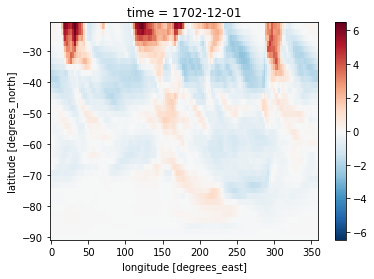

In [14]:
#Seasonal Mean of Field Variable, just an example here to make sure my method below is correct
tp_shem_seas_mean_detrend_ctrl = tp_shem_tmon_detrend_ctrl[2:(len(tp_shem_tmon_detrend_ctrl['time'])-1)].resample(time='QS-MAR', closed='left'  ).mean(dim = 'time')
tp_shem_seas_mean_detrend_ctrl[3].plot()

<xarray.DataArray (time: 74, lat: 37, lon: 144)>
array([[[-0.03104243, -0.03104405, -0.03107851, ..., -0.03104082,
         -0.03104056, -0.03104144],
        [ 0.01868294,  0.01641689,  0.01619397, ...,  0.03097153,
          0.02832286,  0.02377077],
        [ 0.0422837 ,  0.0403429 ,  0.03893567, ...,  0.03876745,
          0.04030048,  0.04119489],
        ...,
        [ 0.04076608,  0.06303748,  0.06617118, ...,  0.00867516,
          0.02191454,  0.01029117],
        [ 0.10150719,  0.12352401,  0.13160305, ...,  0.09321596,
          0.09293701,  0.09446854],
        [ 0.13908882,  0.16033487,  0.16752233, ...,  0.13939305,
          0.14291231,  0.13451743]],

       [[-0.04553549, -0.04553711, -0.04557142, ..., -0.04553382,
         -0.04553356, -0.04553444],
        [-0.0099088 , -0.00988985, -0.00968479, ..., -0.01128286,
         -0.01150628, -0.01098419],
        [ 0.01593708,  0.01252742,  0.00889389, ...,  0.02053655,
          0.0205141 ,  0.01928836],
...
        [-0.04

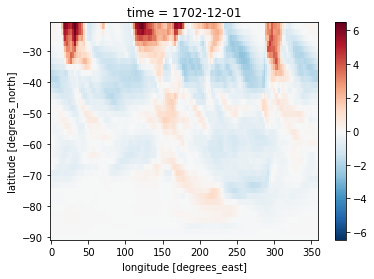

In [15]:
#Seperating out those seasonal means of the field variable
def is_djf(month):
    return (month == 12)

def is_mam(month):
    return (month == 3)

def is_jja(month):
    return (month == 6)

def is_son(month):
    return (month == 9)

djf_tp_shem_seas_mean_detrend_ctrl = tp_shem_seas_mean_detrend_ctrl.sel(time=is_djf(tp_shem_seas_mean_detrend_ctrl['time.month']))
mam_tp_shem_seas_mean_detrend_ctrl = tp_shem_seas_mean_detrend_ctrl.sel(time=is_mam(tp_shem_seas_mean_detrend_ctrl['time.month']))
jja_tp_shem_seas_mean_detrend_ctrl = tp_shem_seas_mean_detrend_ctrl.sel(time=is_jja(tp_shem_seas_mean_detrend_ctrl['time.month']))
son_tp_shem_seas_mean_detrend_ctrl = tp_shem_seas_mean_detrend_ctrl.sel(time=is_son(tp_shem_seas_mean_detrend_ctrl['time.month']))

#note, the first djf is dated for the first year because the 3-month mean is labeled by the first month
djf_tp_shem_seas_mean_detrend_ctrl[0].plot()
print(djf_tp_shem_seas_mean_detrend_ctrl)

#In case I need to add NaNs in djf, something like this may work:
# #need to add back in at time=0 a row of nans for djf, else it has 47 instead of 48 points
# nan_slice_for_djf = djfmean_TP_tmon_ctrl_data[0:1,:,:]
# nan_slice_for_djf = nan_slice_for_djf.where(nan_slice_for_djf == 99999.)
# djfmean_TP_tmon_ctrl_data = xr.concat([nan_slice_for_djf, djfmean_TP_tmon_ctrl_data], dim='time')
# #djfmean_TP_tmon_ctrl_data

In [16]:
#Field variable with 3,6,12 roll and annual mean

tp_shem_ann_mean_detrend_ctrl = tp_shem_tmon_detrend_ctrl.resample(time='AS').mean(dim = 'time')
#tp_shem_ann_mean_detrend_ctrl

In [17]:
#Find SAM values for each of the 8 time periods and put in pd.DataFrame
#Then, select the upper and lower quartile values

d = {'SAM': SAM_PSAs_seas_mean_indices_ctrl.SAM.where(SAM_PSAs_seas_mean_indices_ctrl.Seas_Index == '12').dropna(), 'indice': np.arange(0,len(SAM_PSAs_seas_mean_indices_ctrl.SAM.where(SAM_PSAs_seas_mean_indices_ctrl.Seas_Index == '12').dropna()),1)}
SAM_djf_mean_ctrl = pd.DataFrame(data=d)
# SAM_djf_mean_ctrl

d = {'SAM': SAM_PSAs_seas_mean_indices_ctrl.SAM.where(SAM_PSAs_seas_mean_indices_ctrl.Seas_Index == '03').dropna(), 'indice': np.arange(0,len(SAM_PSAs_seas_mean_indices_ctrl.SAM.where(SAM_PSAs_seas_mean_indices_ctrl.Seas_Index == '03').dropna()),1)}
SAM_mam_mean_ctrl = pd.DataFrame(data=d)
# SAM_mam_mean_ctrl

d = {'SAM': SAM_PSAs_seas_mean_indices_ctrl.SAM.where(SAM_PSAs_seas_mean_indices_ctrl.Seas_Index == '06').dropna(), 'indice': np.arange(0,len(SAM_PSAs_seas_mean_indices_ctrl.SAM.where(SAM_PSAs_seas_mean_indices_ctrl.Seas_Index == '06').dropna()),1)}
SAM_jja_mean_ctrl = pd.DataFrame(data=d)
# SAM_jja_mean_ctrl

d = {'SAM': SAM_PSAs_seas_mean_indices_ctrl.SAM.where(SAM_PSAs_seas_mean_indices_ctrl.Seas_Index == '09').dropna(), 'indice': np.arange(0,len(SAM_PSAs_seas_mean_indices_ctrl.SAM.where(SAM_PSAs_seas_mean_indices_ctrl.Seas_Index == '09').dropna()),1)}
SAM_son_mean_ctrl = pd.DataFrame(data=d)
# SAM_son_mean_ctrl

d = {'SAM': SAM_PSAs_ann_mean_indices_ctrl.SAM.dropna(), 'indice': np.arange(0, len(SAM_PSAs_ann_mean_indices_ctrl.SAM.dropna()),1)}
SAM_ann_mean_ctrl = pd.DataFrame(data=d)
# SAM_ann_mean_ctrl


#create list of indices representing the upper/lower quartiles of 'SAM'
#Note, head is lower (sorted from low to high)
SAM_djf_mean_lower_ctrl = SAM_djf_mean_ctrl.sort_values(by=['SAM']).head(n=(round(SAM_djf_mean_ctrl.indice.size/4))).indice.tolist()
# SAM_djf_mean_lower_ctrl
SAM_djf_mean_upper_ctrl = SAM_djf_mean_ctrl.sort_values(by=['SAM']).tail(n=(round(SAM_djf_mean_ctrl.indice.size/4))).indice.tolist()
# SAM_djf_mean_upper_ctrl

SAM_mam_mean_lower_ctrl = SAM_mam_mean_ctrl.sort_values(by=['SAM']).head(n=(round(SAM_mam_mean_ctrl.indice.size/4))).indice.tolist()
# SAM_mam_mean_lower_ctrl
SAM_mam_mean_upper_ctrl = SAM_mam_mean_ctrl.sort_values(by=['SAM']).tail(n=(round(SAM_mam_mean_ctrl.indice.size/4))).indice.tolist()
# SAM_mam_mean_upper_ctrl

SAM_jja_mean_lower_ctrl = SAM_jja_mean_ctrl.sort_values(by=['SAM']).head(n=(round(SAM_jja_mean_ctrl.indice.size/4))).indice.tolist()
# SAM_jja_mean_lower_ctrl
SAM_jja_mean_upper_ctrl = SAM_jja_mean_ctrl.sort_values(by=['SAM']).tail(n=(round(SAM_jja_mean_ctrl.indice.size/4))).indice.tolist()
# SAM_jja_mean_upper_ctrl

SAM_son_mean_lower_ctrl = SAM_son_mean_ctrl.sort_values(by=['SAM']).head(n=(round(SAM_son_mean_ctrl.indice.size/4))).indice.tolist()
# SAM_son_mean_lower_ctrl
SAM_son_mean_upper_ctrl = SAM_son_mean_ctrl.sort_values(by=['SAM']).tail(n=(round(SAM_son_mean_ctrl.indice.size/4))).indice.tolist()
# SAM_son_mean_upper_ctrl

SAM_ann_mean_lower_ctrl = SAM_ann_mean_ctrl.sort_values(by=['SAM']).head(n=(round(SAM_ann_mean_ctrl.indice.size/4))).indice.tolist()
# SAM_ann_mean_lower_ctrl
SAM_ann_mean_upper_ctrl = SAM_ann_mean_ctrl.sort_values(by=['SAM']).tail(n=(round(SAM_ann_mean_ctrl.indice.size/4))).indice.tolist()
# SAM_ann_mean_upper_ctrl

In [18]:
#Select the times of the field variable dependent upon quartile and the indice 

#DJF, (both datasets already at s=47, so no need to crop the time series)
djf_tp_w_upper_SAM_detrend_ctrl = djf_tp_shem_seas_mean_detrend_ctrl.isel(time = SAM_djf_mean_upper_ctrl)
djf_tp_w_lower_SAM_detrend_ctrl = djf_tp_shem_seas_mean_detrend_ctrl.isel(time = SAM_djf_mean_lower_ctrl)
# djf_tp_w_upper_SAM_detrend_ctrl
# djf_tp_w_lower_SAM_detrend_ctrl

#mam
mam_tp_w_upper_SAM_detrend_ctrl = mam_tp_shem_seas_mean_detrend_ctrl.isel(time = SAM_mam_mean_upper_ctrl)
mam_tp_w_lower_SAM_detrend_ctrl = mam_tp_shem_seas_mean_detrend_ctrl.isel(time = SAM_mam_mean_lower_ctrl)
# mam_tp_w_upper_SAM_detrend_ctrl
# mam_tp_w_lower_SAM_detrend_ctrl

#jja
jja_tp_w_upper_SAM_detrend_ctrl = jja_tp_shem_seas_mean_detrend_ctrl.isel(time = SAM_jja_mean_upper_ctrl)
jja_tp_w_lower_SAM_detrend_ctrl = jja_tp_shem_seas_mean_detrend_ctrl.isel(time = SAM_jja_mean_lower_ctrl)
# jja_tp_w_upper_SAM_detrend_ctrl
# jja_tp_w_lower_SAM_detrend_ctrl

#son
son_tp_w_upper_SAM_detrend_ctrl = son_tp_shem_seas_mean_detrend_ctrl.isel(time = SAM_son_mean_upper_ctrl)
son_tp_w_lower_SAM_detrend_ctrl = son_tp_shem_seas_mean_detrend_ctrl.isel(time = SAM_son_mean_lower_ctrl)
son_tp_w_upper_SAM_detrend_ctrl
# son_tp_w_lower_SAM_detrend_ctrl

#ann mean
ann_mean_tp_w_upper_SAM_detrend_ctrl = tp_shem_ann_mean_detrend_ctrl.isel(time = SAM_ann_mean_upper_ctrl)
ann_mean_tp_w_lower_SAM_detrend_ctrl = tp_shem_ann_mean_detrend_ctrl.isel(time = SAM_ann_mean_lower_ctrl)
# ann_mean_tp_w_upper_SAM_detrend_ctrl
# ann_mean_tp_w_lower_SAM_detrend_ctrl


In [19]:
#Select ASL Rel CP value, long, and lat while index is in upper or lower quartile
#Using new ASL info from 19Nov2018
#djf
djf_Rel_CP_indices_w_upper_SAM_detrend_ctrl = Rel_CP_djf_mean_indices_raw_ctrl.iloc[SAM_djf_mean_upper_ctrl]
# djf_Rel_CP_indices_w_upper_SAM_detrend_ctrl
djf_Rel_CP_indices_w_lower_SAM_detrend_ctrl = Rel_CP_djf_mean_indices_raw_ctrl.iloc[SAM_djf_mean_lower_ctrl]
# djf_Rel_CP_indices_w_lower_SAM_detrend_ctrl

#mam
mam_Rel_CP_indices_w_upper_SAM_detrend_ctrl = Rel_CP_mam_mean_indices_raw_ctrl.iloc[SAM_mam_mean_upper_ctrl]
# mam_Rel_CP_indices_w_upper_SAM_detrend_ctrl
mam_Rel_CP_indices_w_lower_SAM_detrend_ctrl = Rel_CP_mam_mean_indices_raw_ctrl.iloc[SAM_mam_mean_lower_ctrl]
# mam_Rel_CP_indices_w_lower_SAM_detrend_ctrl

#jja
jja_Rel_CP_indices_w_upper_SAM_detrend_ctrl = Rel_CP_jja_mean_indices_raw_ctrl.iloc[SAM_jja_mean_upper_ctrl]
# jja_Rel_CP_indices_w_upper_SAM_detrend_ctrl
jja_Rel_CP_indices_w_lower_SAM_detrend_ctrl = Rel_CP_jja_mean_indices_raw_ctrl.iloc[SAM_jja_mean_lower_ctrl]
# jja_Rel_CP_indices_w_lower_SAM_detrend_ctrl

#son
son_Rel_CP_indices_w_upper_SAM_detrend_ctrl = Rel_CP_son_mean_indices_raw_ctrl.iloc[SAM_son_mean_upper_ctrl]
# son_Rel_CP_indices_w_upper_SAM_detrend_ctrl
son_Rel_CP_indices_w_lower_SAM_detrend_ctrl = Rel_CP_son_mean_indices_raw_ctrl.iloc[SAM_son_mean_lower_ctrl]
# son_Rel_CP_indices_w_lower_SAM_detrend_ctrl

#annual mean
ann_mean_Rel_CP_indices_w_upper_SAM_detrend_ctrl = Rel_CP_ann_mean_indices_raw_ctrl.iloc[SAM_ann_mean_upper_ctrl]
# ann_mean_Rel_CP_indices_w_upper_SAM_detrend_ctrl
ann_mean_Rel_CP_indices_w_lower_SAM_detrend_ctrl = Rel_CP_ann_mean_indices_raw_ctrl.iloc[SAM_ann_mean_lower_ctrl]
# ann_mean_Rel_CP_indices_w_upper_SAM_detrend_ctrl



In [20]:
#Calculate significance for the change in mean of the field variable for Positive-Negative
#critical value for t-test at 95%:
#Seasonal and ann mean, df=19+19-2 = 36 ; critical value = +- 2.028
#DJF, df =18+18-2 = 34 ; critical value = +- 2.032 (so close to df=36 that I am not going to change)

djf_tp_change_due_to_SAM_ttest_stats_ctrl, djf_tp_change_due_to_SAM_ttest_pvals_ctrl = ttest_ind(
    djf_tp_w_upper_SAM_detrend_ctrl, djf_tp_w_lower_SAM_detrend_ctrl, axis=0)

mam_tp_change_due_to_SAM_ttest_stats_ctrl, mam_tp_change_due_to_SAM_ttest_pvals_ctrl = ttest_ind(
    mam_tp_w_upper_SAM_detrend_ctrl, mam_tp_w_lower_SAM_detrend_ctrl, axis=0)

jja_tp_change_due_to_SAM_ttest_stats_ctrl, jja_tp_change_due_to_SAM_ttest_pvals_ctrl = ttest_ind(
    jja_tp_w_upper_SAM_detrend_ctrl, jja_tp_w_lower_SAM_detrend_ctrl, axis=0)

son_tp_change_due_to_SAM_ttest_stats_ctrl, son_tp_change_due_to_SAM_ttest_pvals_ctrl = ttest_ind(
    son_tp_w_upper_SAM_detrend_ctrl, son_tp_w_lower_SAM_detrend_ctrl, axis=0)

ann_mean_tp_change_due_to_SAM_ttest_stats_ctrl, ann_mean_tp_change_due_to_SAM_ttest_pvals_ctrl = ttest_ind(
    ann_mean_tp_w_upper_SAM_detrend_ctrl, ann_mean_tp_w_lower_SAM_detrend_ctrl, axis=0)

/glade/work/pgoddard/NEW_ANACONDA_AND_PY_ENV_24Mar2021/geo_scipy/lib/python3.7/site-packages/cartopy/util.py:102: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  new_data = ma.concatenate((data, data[slicer]), axis=axis)
/glade/work/pgoddard/NEW_ANACONDA_AND_PY_ENV_24Mar2021/geo_scipy/lib/python3.7/site-packages/ipykernel_launcher.py:34: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.


-4.9006856442428495 -4.334664159718601


/glade/work/pgoddard/NEW_ANACONDA_AND_PY_ENV_24Mar2021/geo_scipy/lib/python3.7/site-packages/ipykernel_launcher.py:114: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.


-7.9532959019987315 -6.00313496077386


/glade/work/pgoddard/NEW_ANACONDA_AND_PY_ENV_24Mar2021/geo_scipy/lib/python3.7/site-packages/ipykernel_launcher.py:193: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.


-9.416681147344788 -8.54199293308687


/glade/work/pgoddard/NEW_ANACONDA_AND_PY_ENV_24Mar2021/geo_scipy/lib/python3.7/site-packages/ipykernel_launcher.py:272: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.


-8.127777513028976 -7.011836237000317


/glade/work/pgoddard/NEW_ANACONDA_AND_PY_ENV_24Mar2021/geo_scipy/lib/python3.7/site-packages/ipykernel_launcher.py:351: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.


-6.386607262488048 -5.541187217482436


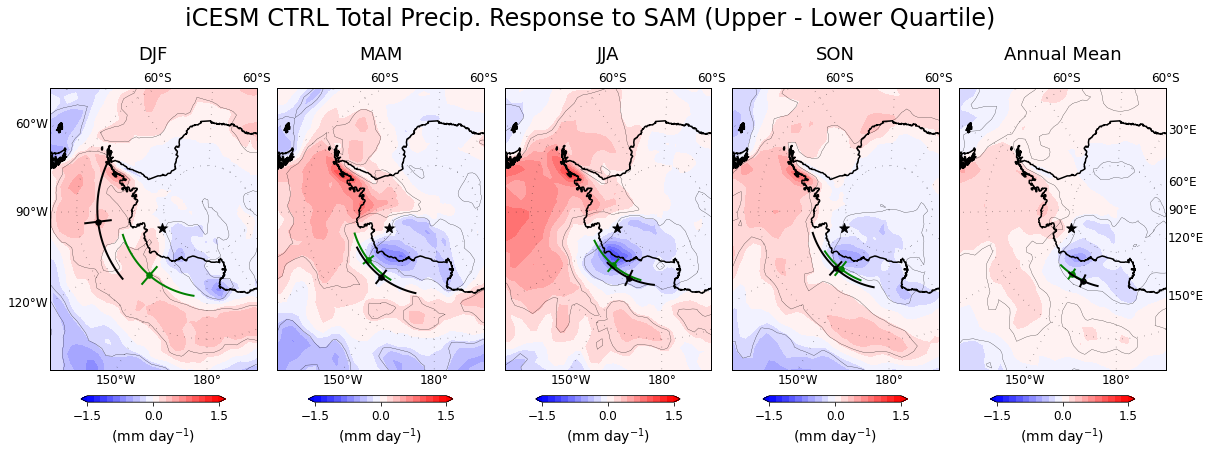

In [21]:
fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(20,6), sharex=True, sharey=True)
fig.subplots_adjust(hspace=0.0, wspace=0.1)
fig.suptitle('iCESM CTRL Total Precip. Response to SAM (Upper - Lower Quartile)', fontsize=24, y=1.05)

# setup Lambert Conformal basemap.
diff_djf = djf_tp_w_upper_SAM_detrend_ctrl.mean(axis=0)-djf_tp_w_lower_SAM_detrend_ctrl.mean(axis=0)
diff_mam = mam_tp_w_upper_SAM_detrend_ctrl.mean(axis=0)-mam_tp_w_lower_SAM_detrend_ctrl.mean(axis=0)
diff_jja = jja_tp_w_upper_SAM_detrend_ctrl.mean(axis=0)-jja_tp_w_lower_SAM_detrend_ctrl.mean(axis=0)
diff_son = son_tp_w_upper_SAM_detrend_ctrl.mean(axis=0)-son_tp_w_lower_SAM_detrend_ctrl.mean(axis=0)
diff_ann = ann_mean_tp_w_upper_SAM_detrend_ctrl.mean(axis=0)-ann_mean_tp_w_lower_SAM_detrend_ctrl.mean(axis=0)
diff_djf_sh, lons = add_cyclic_point(diff_djf.values, CTRL_DATA.coords['lon'].values, axis=-1)
diff_mam_sh, lons = add_cyclic_point(diff_mam.values, CTRL_DATA.coords['lon'].values, axis=-1)
diff_jja_sh, lons = add_cyclic_point(diff_jja.values, CTRL_DATA.coords['lon'].values, axis=-1)
diff_son_sh, lons = add_cyclic_point(diff_son.values, CTRL_DATA.coords['lon'].values, axis=-1)
diff_ann_sh, lons = add_cyclic_point(diff_ann.values, CTRL_DATA.coords['lon'].values, axis=-1)
diff_djf_con, lons = add_cyclic_point(djf_tp_change_due_to_SAM_ttest_stats_ctrl, CTRL_DATA.coords['lon'].values, axis=-1)
diff_mam_con, lons = add_cyclic_point(mam_tp_change_due_to_SAM_ttest_stats_ctrl, CTRL_DATA.coords['lon'].values, axis=-1)
diff_jja_con, lons = add_cyclic_point(jja_tp_change_due_to_SAM_ttest_stats_ctrl, CTRL_DATA.coords['lon'].values, axis=-1)
diff_son_con, lons = add_cyclic_point(son_tp_change_due_to_SAM_ttest_stats_ctrl, CTRL_DATA.coords['lon'].values, axis=-1)
diff_ann_con, lons = add_cyclic_point(ann_mean_tp_change_due_to_SAM_ttest_stats_ctrl, CTRL_DATA.coords['lon'].values, axis=-1)

lon, lat = np.meshgrid(lons,CTRL_DATA.coords['lat'].sel(lat=slice(shem_ylo, shem_yhi)).values)
levels = np.arange(-1.5,1.65,.15)
levels_contour = [-2.028,2.028] #good for seasons and annual mean

parallels = np.arange(-80,-1,20)
meridians = np.arange(0,360,30.)
plt.rcParams['contour.negative_linestyle'] = 'solid'
plt.rcParams['text.latex.preamble']=[r"\usepackage{wasysym}"]

#DJF
plt.subplot(1, 5, 1)
m = Basemap(llcrnrlon=-135,llcrnrlat=-40,urcrnrlon=20,urcrnrlat=-60,projection='lcc',
            resolution='l',lat_1=-89.,lat_2=-65,lat_0=-70,lon_0=180.)
x, y = m(lon, lat)
# draw coastlines.
m.drawcoastlines(linewidth=1.5)
m.drawmapboundary(fill_color='white')
# labels = [left,right,top,bottom]
m.drawparallels(parallels,labels=[False,False,True,False],dashes=[.3, 7],fontsize=12)
m.drawmeridians(meridians,labels=[True,False,False,True],dashes=[.3, 7],fontsize=12)
#CS = m.contourf(x,y,(djf_tp_w_upper_SAM_detrend_ctrl.mean(axis=0)-djf_tp_w_lower_SAM_detrend_ctrl.mean(axis=0)).where((djf_tp_change_due_to_SAM_ttest_stats_ctrl >= levels_contour[1]) | (djf_tp_change_due_to_SAM_ttest_stats_ctrl < levels_contour[0]) ),levels,cmap=plt.cm.get_cmap('bwr'),extend='both')
# CS = m.contourf(x,y,(djf_tp_w_upper_SAM_detrend_ctrl.mean(axis=0)-djf_tp_w_lower_SAM_detrend_ctrl.mean(axis=0)),levels,cmap=plt.cm.get_cmap('bwr'),extend='both')
CS = m.contourf(x,y,(diff_djf_sh),levels,cmap=plt.cm.get_cmap('bwr'),extend='both')
#plt.ylabel('V10', fontsize=20)
cbar = plt.colorbar(orientation='horizontal', shrink=0.70, aspect=20, fraction=0.033, pad=0.08)
cbar.set_label(r'(mm day$^{-1}$)',size=14)
cbar.set_ticks([-1.5, 0, 1.5])
cbar.ax.tick_params(labelsize=12)
plt.clim([-1.5,1.5])
CS2 = m.contour(x,y,diff_djf_con,levels_contour,linewidths=0.25,colors='k')

#add Rel. CP mean location for upper and lower indice
#upper
xpt,ypt = m(djf_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lons.mean(),
            djf_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lats.mean()
           )
plt.scatter(xpt, ypt, c='green', marker='o', s=30) #for value dependent: vmin=-10, vmax=0, cmap='green'
#lower
xpt,ypt = m(djf_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lons.mean(),
            djf_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lats.mean()
           )
plt.scatter(xpt, ypt, c='k', marker='o', s=30) #for value dependent: vmin=-10, vmax=0, cmap='green'

#Add +- 1std of long and lat
#upper
lat_line = np.linspace(djf_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lats.mean()
                       ,djf_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lats.mean()
                       ,100) 
lon_line = np.linspace(djf_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lons.mean()+djf_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lons.std()
                       ,djf_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lons.mean()-djf_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lons.std()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, color='green', linewidth=2) 

lat_line = np.linspace(djf_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lats.mean()+djf_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lats.std()
                       ,djf_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lats.mean()-djf_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lats.std()
                       ,100) 
lon_line = np.linspace(djf_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lons.mean()
                       ,djf_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lons.mean()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='green', linewidth=2)
#lower
lat_line = np.linspace(djf_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lats.mean()
                       ,djf_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lats.mean()
                       ,100) 
lon_line = np.linspace(djf_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lons.mean()+djf_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lons.std()
                       ,djf_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lons.mean()-djf_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lons.std()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='k', linewidth=2) 

lat_line = np.linspace(djf_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lats.mean()+djf_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lats.std()
                       ,djf_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lats.mean()-djf_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lats.std()
                       ,100) 
lon_line = np.linspace(djf_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lons.mean()
                       ,djf_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lons.mean()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='k', linewidth=2)

#add point for central Psuedo cores
xpt,ypt = m(247.5, -78.63)
plt.scatter(xpt, ypt, c='k', marker='*', s=100)

plt.title('DJF',y=1.08,fontsize=18)
print(djf_Rel_CP_indices_w_upper_SAM_detrend_ctrl.vals.mean(),djf_Rel_CP_indices_w_lower_SAM_detrend_ctrl.vals.mean())


#MAM
plt.subplot(1, 5, 2)
m = Basemap(llcrnrlon=-135,llcrnrlat=-40,urcrnrlon=20,urcrnrlat=-60,projection='lcc',
            resolution='l',lat_1=-89.,lat_2=-65,lat_0=-70,lon_0=180.)
x, y = m(lon, lat)
# draw coastlines.
m.drawcoastlines(linewidth=1.5)
m.drawmapboundary(fill_color='white')
# labels = [left,right,top,bottom]
m.drawparallels(parallels,labels=[False,False,True,False],dashes=[.3, 7],fontsize=12)
m.drawmeridians(meridians,labels=[False,False,False,True],dashes=[.3, 7],fontsize=12)
#CS = m.contourf(x,y,(mam_tp_w_upper_SAM_detrend_ctrl.mean(axis=0)-mam_tp_w_lower_SAM_detrend_ctrl.mean(axis=0)).where((mam_tp_change_due_to_SAM_ttest_stats_ctrl >= levels_contour[1]) | (mam_tp_change_due_to_SAM_ttest_stats_ctrl < levels_contour[0]) ),levels,cmap=plt.cm.get_cmap('bwr'),extend='both')
CS = m.contourf(x,y,(diff_mam_sh),levels,cmap=plt.cm.get_cmap('bwr'),extend='both')
#plt.ylabel('V10', fontsize=20)
cbar = plt.colorbar(orientation='horizontal', shrink=0.70, aspect=20, fraction=0.033, pad=0.08)
cbar.set_label(r'(mm day$^{-1}$)',size=14)
cbar.set_ticks([-1.5, 0, 1.5])
cbar.ax.tick_params(labelsize=12)
plt.clim([-1.5,1.5])
CS2 = m.contour(x,y,diff_mam_con,levels_contour,linewidths=0.25,colors='k')

#add Rel. CP mean location for upper and lower indice
#upper
xpt,ypt = m(mam_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lons.mean(),
            mam_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lats.mean()
           )
plt.scatter(xpt, ypt, c='green', marker='o', s=30) #for value dependent: vmin=-10, vmax=0, cmap='green'
#lower
xpt,ypt = m(mam_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lons.mean(),
            mam_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lats.mean()
           )
plt.scatter(xpt, ypt, c='k', marker='o', s=30) #for value dependent: vmin=-10, vmax=0, cmap='green'

#Add +- 1std of long and lat
#upper
lat_line = np.linspace(mam_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lats.mean()
                       ,mam_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lats.mean()
                       ,100) 
lon_line = np.linspace(mam_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lons.mean()+mam_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lons.std()
                       ,mam_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lons.mean()-mam_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lons.std()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, color='green', linewidth=2) 

lat_line = np.linspace(mam_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lats.mean()+mam_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lats.std()
                       ,mam_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lats.mean()-mam_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lats.std()
                       ,100) 
lon_line = np.linspace(mam_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lons.mean()
                       ,mam_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lons.mean()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='green', linewidth=2)
#lower
lat_line = np.linspace(mam_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lats.mean()
                       ,mam_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lats.mean()
                       ,100) 
lon_line = np.linspace(mam_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lons.mean()+mam_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lons.std()
                       ,mam_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lons.mean()-mam_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lons.std()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='k', linewidth=2) 

lat_line = np.linspace(mam_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lats.mean()+mam_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lats.std()
                       ,mam_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lats.mean()-mam_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lats.std()
                       ,100) 
lon_line = np.linspace(mam_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lons.mean()
                       ,mam_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lons.mean()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='k', linewidth=2)

#add point for central Psuedo cores
xpt,ypt = m(247.5, -78.63)
plt.scatter(xpt, ypt, c='k', marker='*', s=100)

plt.title('MAM',y=1.08,fontsize=18)
print(mam_Rel_CP_indices_w_upper_SAM_detrend_ctrl.vals.mean(),mam_Rel_CP_indices_w_lower_SAM_detrend_ctrl.vals.mean())


#JJA
plt.subplot(1, 5, 3)
m = Basemap(llcrnrlon=-135,llcrnrlat=-40,urcrnrlon=20,urcrnrlat=-60,projection='lcc',
            resolution='l',lat_1=-89.,lat_2=-65,lat_0=-70,lon_0=180.)
x, y = m(lon, lat)
# draw coastlines.
m.drawcoastlines(linewidth=1.5)
m.drawmapboundary(fill_color='white')
# labels = [left,right,top,bottom]
m.drawparallels(parallels,labels=[False,False,True,False],dashes=[.3, 7],fontsize=12)
m.drawmeridians(meridians,labels=[False,False,False,True],dashes=[.3, 7],fontsize=12)
#CS = m.contourf(x,y,(jja_tp_w_upper_SAM_detrend_ctrl.mean(axis=0)-jja_tp_w_lower_SAM_detrend_ctrl.mean(axis=0)).where((jja_tp_change_due_to_SAM_ttest_stats_ctrl >= levels_contour[1]) | (jja_tp_change_due_to_SAM_ttest_stats_ctrl < levels_contour[0]) ),levels,cmap=plt.cm.get_cmap('bwr'),extend='both')
CS = m.contourf(x,y,(diff_jja_sh),levels,cmap=plt.cm.get_cmap('bwr'),extend='both')
#plt.ylabel('V10', fontsize=20)
cbar = plt.colorbar(orientation='horizontal', shrink=0.70, aspect=20, fraction=0.033, pad=0.08)
cbar.set_label(r'(mm day$^{-1}$)',size=14)
cbar.set_ticks([-1.5, 0, 1.5])
cbar.ax.tick_params(labelsize=12)
plt.clim([-1.5,1.5])
CS2 = m.contour(x,y,diff_jja_con,levels_contour,linewidths=0.25,colors='k')

#add Rel. CP mean location for upper and lower indice
#upper
xpt,ypt = m(jja_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lons.mean(),
            jja_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lats.mean()
           )
plt.scatter(xpt, ypt, c='green', marker='o', s=30) #for value dependent: vmin=-10, vmax=0, cmap='green'
#lower
xpt,ypt = m(jja_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lons.mean(),
            jja_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lats.mean()
           )
plt.scatter(xpt, ypt, c='k', marker='o', s=30) #for value dependent: vmin=-10, vmax=0, cmap='green'

#Add +- 1std of long and lat
#upper
lat_line = np.linspace(jja_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lats.mean()
                       ,jja_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lats.mean()
                       ,100) 
lon_line = np.linspace(jja_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lons.mean()+jja_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lons.std()
                       ,jja_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lons.mean()-jja_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lons.std()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, color='green', linewidth=2) 

lat_line = np.linspace(jja_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lats.mean()+jja_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lats.std()
                       ,jja_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lats.mean()-jja_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lats.std()
                       ,100) 
lon_line = np.linspace(jja_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lons.mean()
                       ,jja_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lons.mean()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='green', linewidth=2)
#lower
lat_line = np.linspace(jja_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lats.mean()
                       ,jja_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lats.mean()
                       ,100) 
lon_line = np.linspace(jja_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lons.mean()+jja_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lons.std()
                       ,jja_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lons.mean()-jja_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lons.std()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='k', linewidth=2) 

lat_line = np.linspace(jja_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lats.mean()+jja_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lats.std()
                       ,jja_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lats.mean()-jja_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lats.std()
                       ,100) 
lon_line = np.linspace(jja_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lons.mean()
                       ,jja_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lons.mean()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='k', linewidth=2)

#add point for central Psuedo cores
xpt,ypt = m(247.5, -78.63)
plt.scatter(xpt, ypt, c='k', marker='*', s=100)

plt.title('JJA',y=1.08,fontsize=18)
print(jja_Rel_CP_indices_w_upper_SAM_detrend_ctrl.vals.mean(),jja_Rel_CP_indices_w_lower_SAM_detrend_ctrl.vals.mean())


#SON
plt.subplot(1, 5, 4)
m = Basemap(llcrnrlon=-135,llcrnrlat=-40,urcrnrlon=20,urcrnrlat=-60,projection='lcc',
            resolution='l',lat_1=-89.,lat_2=-65,lat_0=-70,lon_0=180.)
x, y = m(lon, lat)
# draw coastlines.
m.drawcoastlines(linewidth=1.5)
m.drawmapboundary(fill_color='white')
# labels = [left,right,top,bottom]
m.drawparallels(parallels,labels=[False,False,True,False],dashes=[.3, 7],fontsize=12)
m.drawmeridians(meridians,labels=[False,False,False,True],dashes=[.3, 7],fontsize=12)
#CS = m.contourf(x,y,(son_tp_w_upper_SAM_detrend_ctrl.mean(axis=0)-son_tp_w_lower_SAM_detrend_ctrl.mean(axis=0)).where((son_tp_change_due_to_SAM_ttest_stats_ctrl >= levels_contour[1]) | (son_tp_change_due_to_SAM_ttest_stats_ctrl < levels_contour[0]) ),levels,cmap=plt.cm.get_cmap('bwr'),extend='both')
CS = m.contourf(x,y,(diff_son_sh),levels,cmap=plt.cm.get_cmap('bwr'),extend='both')
#plt.ylabel('V10', fontsize=20)
cbar = plt.colorbar(orientation='horizontal', shrink=0.70, aspect=20, fraction=0.033, pad=0.08)
cbar.set_label(r'(mm day$^{-1}$)',size=14)
cbar.set_ticks([-1.5, 0, 1.5])
cbar.ax.tick_params(labelsize=12)
plt.clim([-1.5,1.5])
CS2 = m.contour(x,y,diff_son_con,levels_contour,linewidths=0.25,colors='k')

#add Rel. CP mean location for upper and lower indice
#upper
xpt,ypt = m(son_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lons.mean(),
            son_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lats.mean()
           )
plt.scatter(xpt, ypt, c='green', marker='o', s=30) #for value dependent: vmin=-10, vmax=0, cmap='green'
#lower
xpt,ypt = m(son_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lons.mean(),
            son_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lats.mean()
           )
plt.scatter(xpt, ypt, c='k', marker='o', s=30) #for value dependent: vmin=-10, vmax=0, cmap='green'

#Add +- 1std of long and lat
#upper
lat_line = np.linspace(son_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lats.mean()
                       ,son_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lats.mean()
                       ,100) 
lon_line = np.linspace(son_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lons.mean()+son_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lons.std()
                       ,son_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lons.mean()-son_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lons.std()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, color='green', linewidth=2) 

lat_line = np.linspace(son_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lats.mean()+son_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lats.std()
                       ,son_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lats.mean()-son_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lats.std()
                       ,100) 
lon_line = np.linspace(son_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lons.mean()
                       ,son_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lons.mean()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='green', linewidth=2)
#lower
lat_line = np.linspace(son_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lats.mean()
                       ,son_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lats.mean()
                       ,100) 
lon_line = np.linspace(son_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lons.mean()+son_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lons.std()
                       ,son_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lons.mean()-son_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lons.std()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='k', linewidth=2) 

lat_line = np.linspace(son_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lats.mean()+son_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lats.std()
                       ,son_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lats.mean()-son_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lats.std()
                       ,100) 
lon_line = np.linspace(son_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lons.mean()
                       ,son_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lons.mean()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='k', linewidth=2)

#add point for central Psuedo cores
xpt,ypt = m(247.5, -78.63)
plt.scatter(xpt, ypt, c='k', marker='*', s=100)

plt.title('SON',y=1.08,fontsize=18)
print(son_Rel_CP_indices_w_upper_SAM_detrend_ctrl.vals.mean(),son_Rel_CP_indices_w_lower_SAM_detrend_ctrl.vals.mean())


#Annual Mean
plt.subplot(1, 5, 5)
m = Basemap(llcrnrlon=-135,llcrnrlat=-40,urcrnrlon=20,urcrnrlat=-60,projection='lcc',
            resolution='l',lat_1=-89.,lat_2=-65,lat_0=-70,lon_0=180.)
x, y = m(lon, lat)
# draw coastlines.
m.drawcoastlines(linewidth=1.5)
m.drawmapboundary(fill_color='white')
# labels = [left,right,top,bottom]
m.drawparallels(parallels,labels=[False,False,True,False],dashes=[.3, 7],fontsize=12)
m.drawmeridians(meridians,labels=[False,True,False,True],dashes=[.3, 7],fontsize=12)
#CS = m.contourf(x,y,(ann_mean_tp_w_upper_SAM_detrend_ctrl.mean(axis=0)-ann_mean_tp_w_lower_SAM_detrend_ctrl.mean(axis=0)).where((ann_mean_tp_change_due_to_SAM_ttest_stats_ctrl >= levels_contour[1]) | (ann_mean_tp_change_due_to_SAM_ttest_stats_ctrl < levels_contour[0]) ),levels,cmap=plt.cm.get_cmap('bwr'),extend='both')
CS = m.contourf(x,y,(diff_ann_sh),levels,cmap=plt.cm.get_cmap('bwr'),extend='both')
#plt.ylabel('V10', fontsize=20)
cbar = plt.colorbar(orientation='horizontal', shrink=0.70, aspect=20, fraction=0.033, pad=0.08)
cbar.set_label(r'(mm day$^{-1}$)',size=14)
cbar.set_ticks([-1.5, 0, 1.5])
cbar.ax.tick_params(labelsize=12)
plt.clim([-1.5,1.5])
CS2 = m.contour(x,y,diff_ann_con,levels_contour,linewidths=0.25,colors='k')

#add Rel. CP mean location for upper and lower indice
#upper
xpt,ypt = m(ann_mean_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lons.mean(),
            ann_mean_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lats.mean()
           )
plt.scatter(xpt, ypt, c='green', marker='o', s=30) #for value dependent: vmin=-10, vmax=0, cmap='green'
#lower
xpt,ypt = m(ann_mean_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lons.mean(),
            ann_mean_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lats.mean()
           )
plt.scatter(xpt, ypt, c='k', marker='o', s=30) #for value dependent: vmin=-10, vmax=0, cmap='green'

#Add +- 1std of long and lat
#upper
lat_line = np.linspace(ann_mean_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lats.mean()
                       ,ann_mean_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lats.mean()
                       ,100) 
lon_line = np.linspace(ann_mean_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lons.mean()+ann_mean_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lons.std()
                       ,ann_mean_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lons.mean()-ann_mean_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lons.std()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, color='green', linewidth=2) 

lat_line = np.linspace(ann_mean_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lats.mean()+ann_mean_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lats.std()
                       ,ann_mean_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lats.mean()-ann_mean_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lats.std()
                       ,100) 
lon_line = np.linspace(ann_mean_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lons.mean()
                       ,ann_mean_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lons.mean()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='green', linewidth=2)
#lower
lat_line = np.linspace(ann_mean_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lats.mean()
                       ,ann_mean_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lats.mean()
                       ,100) 
lon_line = np.linspace(ann_mean_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lons.mean()+ann_mean_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lons.std()
                       ,ann_mean_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lons.mean()-ann_mean_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lons.std()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='k', linewidth=2) 

lat_line = np.linspace(ann_mean_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lats.mean()+ann_mean_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lats.std()
                       ,ann_mean_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lats.mean()-ann_mean_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lats.std()
                       ,100) 
lon_line = np.linspace(ann_mean_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lons.mean()
                       ,ann_mean_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lons.mean()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='k', linewidth=2)

#add point for central Psuedo cores
xpt,ypt = m(247.5, -78.63)
plt.scatter(xpt, ypt, c='k', marker='*', s=100)

plt.title('Annual Mean',y=1.08,fontsize=18)
print(ann_mean_Rel_CP_indices_w_upper_SAM_detrend_ctrl.vals.mean(),ann_mean_Rel_CP_indices_w_lower_SAM_detrend_ctrl.vals.mean())


# plt.savefig(FIG_PATH+'/OLD_Figure_iCESM_CTRL_TAGGED_tp_Field_vs_SAM_Quartiles_20210324.pdf',bbox_inches='tight', pad_inches=0.05)

plt.show()

In [22]:
#Find PSA1 values for each of the 8 time periods and put in pd.DataFrame
#Then, select the upper and lower quartile values

d = {'PSA1': SAM_PSAs_seas_mean_indices_ctrl.PSA1.where(SAM_PSAs_seas_mean_indices_ctrl.Seas_Index == '12').dropna(), 'indice': np.arange(0,len(SAM_PSAs_seas_mean_indices_ctrl.PSA1.where(SAM_PSAs_seas_mean_indices_ctrl.Seas_Index == '12').dropna()),1)}
PSA1_djf_mean_ctrl = pd.DataFrame(data=d)
# PSA1_djf_mean_ctrl

d = {'PSA1': SAM_PSAs_seas_mean_indices_ctrl.PSA1.where(SAM_PSAs_seas_mean_indices_ctrl.Seas_Index == '03').dropna(), 'indice': np.arange(0,len(SAM_PSAs_seas_mean_indices_ctrl.PSA1.where(SAM_PSAs_seas_mean_indices_ctrl.Seas_Index == '03').dropna()),1)}
PSA1_mam_mean_ctrl = pd.DataFrame(data=d)
# PSA1_mam_mean_ctrl

d = {'PSA1': SAM_PSAs_seas_mean_indices_ctrl.PSA1.where(SAM_PSAs_seas_mean_indices_ctrl.Seas_Index == '06').dropna(), 'indice': np.arange(0,len(SAM_PSAs_seas_mean_indices_ctrl.PSA1.where(SAM_PSAs_seas_mean_indices_ctrl.Seas_Index == '06').dropna()),1)}
PSA1_jja_mean_ctrl = pd.DataFrame(data=d)
# PSA1_jja_mean_ctrl

d = {'PSA1': SAM_PSAs_seas_mean_indices_ctrl.PSA1.where(SAM_PSAs_seas_mean_indices_ctrl.Seas_Index == '09').dropna(), 'indice': np.arange(0,len(SAM_PSAs_seas_mean_indices_ctrl.PSA1.where(SAM_PSAs_seas_mean_indices_ctrl.Seas_Index == '09').dropna()),1)}
PSA1_son_mean_ctrl = pd.DataFrame(data=d)
# PSA1_son_mean_ctrl

d = {'PSA1': SAM_PSAs_ann_mean_indices_ctrl.PSA1.dropna(), 'indice': np.arange(0, len(SAM_PSAs_ann_mean_indices_ctrl.PSA1.dropna()),1)}
PSA1_ann_mean_ctrl = pd.DataFrame(data=d)
# PSA1_ann_mean_ctrl


#create list of indices representing the upper/lower quartiles of 'PSA1'
#Note, head is lower (sorted from low to high)
PSA1_djf_mean_lower_ctrl = PSA1_djf_mean_ctrl.sort_values(by=['PSA1']).head(n=(round(PSA1_djf_mean_ctrl.indice.size/4))).indice.tolist()
# PSA1_djf_mean_lower_ctrl
PSA1_djf_mean_upper_ctrl = PSA1_djf_mean_ctrl.sort_values(by=['PSA1']).tail(n=(round(PSA1_djf_mean_ctrl.indice.size/4))).indice.tolist()
# PSA1_djf_mean_upper_ctrl

PSA1_mam_mean_lower_ctrl = PSA1_mam_mean_ctrl.sort_values(by=['PSA1']).head(n=(round(PSA1_mam_mean_ctrl.indice.size/4))).indice.tolist()
# PSA1_mam_mean_lower_ctrl
PSA1_mam_mean_upper_ctrl = PSA1_mam_mean_ctrl.sort_values(by=['PSA1']).tail(n=(round(PSA1_mam_mean_ctrl.indice.size/4))).indice.tolist()
# PSA1_mam_mean_upper_ctrl

PSA1_jja_mean_lower_ctrl = PSA1_jja_mean_ctrl.sort_values(by=['PSA1']).head(n=(round(PSA1_jja_mean_ctrl.indice.size/4))).indice.tolist()
# PSA1_jja_mean_lower_ctrl
PSA1_jja_mean_upper_ctrl = PSA1_jja_mean_ctrl.sort_values(by=['PSA1']).tail(n=(round(PSA1_jja_mean_ctrl.indice.size/4))).indice.tolist()
# PSA1_jja_mean_upper_ctrl

PSA1_son_mean_lower_ctrl = PSA1_son_mean_ctrl.sort_values(by=['PSA1']).head(n=(round(PSA1_son_mean_ctrl.indice.size/4))).indice.tolist()
# PSA1_son_mean_lower_ctrl
PSA1_son_mean_upper_ctrl = PSA1_son_mean_ctrl.sort_values(by=['PSA1']).tail(n=(round(PSA1_son_mean_ctrl.indice.size/4))).indice.tolist()
# PSA1_son_mean_upper_ctrl

PSA1_ann_mean_lower_ctrl = PSA1_ann_mean_ctrl.sort_values(by=['PSA1']).head(n=(round(PSA1_ann_mean_ctrl.indice.size/4))).indice.tolist()
# PSA1_ann_mean_lower_ctrl
PSA1_ann_mean_upper_ctrl = PSA1_ann_mean_ctrl.sort_values(by=['PSA1']).tail(n=(round(PSA1_ann_mean_ctrl.indice.size/4))).indice.tolist()
# PSA1_ann_mean_upper_ctrl

In [23]:
#Select the times of the field variable dependent upon quartile and the indice 

#DJF, (both datasets already at s=47, so no need to crop the time series)
djf_tp_w_upper_PSA1_detrend_ctrl = djf_tp_shem_seas_mean_detrend_ctrl.isel(time = PSA1_djf_mean_upper_ctrl)
djf_tp_w_lower_PSA1_detrend_ctrl = djf_tp_shem_seas_mean_detrend_ctrl.isel(time = PSA1_djf_mean_lower_ctrl)
# djf_tp_w_upper_PSA1_detrend_ctrl
# djf_tp_w_lower_PSA1_detrend_ctrl

#mam
mam_tp_w_upper_PSA1_detrend_ctrl = mam_tp_shem_seas_mean_detrend_ctrl.isel(time = PSA1_mam_mean_upper_ctrl)
mam_tp_w_lower_PSA1_detrend_ctrl = mam_tp_shem_seas_mean_detrend_ctrl.isel(time = PSA1_mam_mean_lower_ctrl)
# mam_tp_w_upper_PSA1_detrend_ctrl
# mam_tp_w_lower_PSA1_detrend_ctrl

#jja
jja_tp_w_upper_PSA1_detrend_ctrl = jja_tp_shem_seas_mean_detrend_ctrl.isel(time = PSA1_jja_mean_upper_ctrl)
jja_tp_w_lower_PSA1_detrend_ctrl = jja_tp_shem_seas_mean_detrend_ctrl.isel(time = PSA1_jja_mean_lower_ctrl)
# jja_tp_w_upper_PSA1_detrend_ctrl
# jja_tp_w_lower_PSA1_detrend_ctrl

#son
son_tp_w_upper_PSA1_detrend_ctrl = son_tp_shem_seas_mean_detrend_ctrl.isel(time = PSA1_son_mean_upper_ctrl)
son_tp_w_lower_PSA1_detrend_ctrl = son_tp_shem_seas_mean_detrend_ctrl.isel(time = PSA1_son_mean_lower_ctrl)
son_tp_w_upper_PSA1_detrend_ctrl
# son_tp_w_lower_PSA1_detrend_ctrl

#ann mean
ann_mean_tp_w_upper_PSA1_detrend_ctrl = tp_shem_ann_mean_detrend_ctrl.isel(time = PSA1_ann_mean_upper_ctrl)
ann_mean_tp_w_lower_PSA1_detrend_ctrl = tp_shem_ann_mean_detrend_ctrl.isel(time = PSA1_ann_mean_lower_ctrl)
# ann_mean_tp_w_upper_PSA1_detrend_ctrl
# ann_mean_tp_w_lower_PSA1_detrend_ctrl


In [24]:
#Select ASL Rel CP value, long, and lat while index is in upper or lower quartile
#Using new ASL info from 19Nov2018
#djf
djf_Rel_CP_indices_w_upper_PSA1_detrend_ctrl = Rel_CP_djf_mean_indices_raw_ctrl.iloc[PSA1_djf_mean_upper_ctrl]
# djf_Rel_CP_indices_w_upper_PSA1_detrend_ctrl
djf_Rel_CP_indices_w_lower_PSA1_detrend_ctrl = Rel_CP_djf_mean_indices_raw_ctrl.iloc[PSA1_djf_mean_lower_ctrl]
# djf_Rel_CP_indices_w_lower_PSA1_detrend_ctrl

#mam
mam_Rel_CP_indices_w_upper_PSA1_detrend_ctrl = Rel_CP_mam_mean_indices_raw_ctrl.iloc[PSA1_mam_mean_upper_ctrl]
# mam_Rel_CP_indices_w_upper_PSA1_detrend_ctrl
mam_Rel_CP_indices_w_lower_PSA1_detrend_ctrl = Rel_CP_mam_mean_indices_raw_ctrl.iloc[PSA1_mam_mean_lower_ctrl]
# mam_Rel_CP_indices_w_lower_PSA1_detrend_ctrl

#jja
jja_Rel_CP_indices_w_upper_PSA1_detrend_ctrl = Rel_CP_jja_mean_indices_raw_ctrl.iloc[PSA1_jja_mean_upper_ctrl]
# jja_Rel_CP_indices_w_upper_PSA1_detrend_ctrl
jja_Rel_CP_indices_w_lower_PSA1_detrend_ctrl = Rel_CP_jja_mean_indices_raw_ctrl.iloc[PSA1_jja_mean_lower_ctrl]
# jja_Rel_CP_indices_w_lower_PSA1_detrend_ctrl

#son
son_Rel_CP_indices_w_upper_PSA1_detrend_ctrl = Rel_CP_son_mean_indices_raw_ctrl.iloc[PSA1_son_mean_upper_ctrl]
# son_Rel_CP_indices_w_upper_PSA1_detrend_ctrl
son_Rel_CP_indices_w_lower_PSA1_detrend_ctrl = Rel_CP_son_mean_indices_raw_ctrl.iloc[PSA1_son_mean_lower_ctrl]
# son_Rel_CP_indices_w_lower_PSA1_detrend_ctrl

#annual mean
ann_mean_Rel_CP_indices_w_upper_PSA1_detrend_ctrl = Rel_CP_ann_mean_indices_raw_ctrl.iloc[PSA1_ann_mean_upper_ctrl]
# ann_mean_Rel_CP_indices_w_upper_PSA1_detrend_ctrl
ann_mean_Rel_CP_indices_w_lower_PSA1_detrend_ctrl = Rel_CP_ann_mean_indices_raw_ctrl.iloc[PSA1_ann_mean_lower_ctrl]
# ann_mean_Rel_CP_indices_w_upper_PSA1_detrend_ctrl



In [25]:
#Calculate significance for the change in mean of the field variable for Positive-Negative
#critical value for t-test at 95%:
#Seasonal and ann mean, df=19+19-2 = 36 ; critical value = +- 2.028
#DJF, df =18+18-2 = 34 ; critical value = +- 2.032 (so close to df=36 that I am not going to change)

djf_tp_change_due_to_PSA1_ttest_stats_ctrl, djf_tp_change_due_to_PSA1_ttest_pvals_ctrl = ttest_ind(
    djf_tp_w_upper_PSA1_detrend_ctrl, djf_tp_w_lower_PSA1_detrend_ctrl, axis=0)

mam_tp_change_due_to_PSA1_ttest_stats_ctrl, mam_tp_change_due_to_PSA1_ttest_pvals_ctrl = ttest_ind(
    mam_tp_w_upper_PSA1_detrend_ctrl, mam_tp_w_lower_PSA1_detrend_ctrl, axis=0)

jja_tp_change_due_to_PSA1_ttest_stats_ctrl, jja_tp_change_due_to_PSA1_ttest_pvals_ctrl = ttest_ind(
    jja_tp_w_upper_PSA1_detrend_ctrl, jja_tp_w_lower_PSA1_detrend_ctrl, axis=0)

son_tp_change_due_to_PSA1_ttest_stats_ctrl, son_tp_change_due_to_PSA1_ttest_pvals_ctrl = ttest_ind(
    son_tp_w_upper_PSA1_detrend_ctrl, son_tp_w_lower_PSA1_detrend_ctrl, axis=0)

ann_mean_tp_change_due_to_PSA1_ttest_stats_ctrl, ann_mean_tp_change_due_to_PSA1_ttest_pvals_ctrl = ttest_ind(
    ann_mean_tp_w_upper_PSA1_detrend_ctrl, ann_mean_tp_w_lower_PSA1_detrend_ctrl, axis=0)

/glade/work/pgoddard/NEW_ANACONDA_AND_PY_ENV_24Mar2021/geo_scipy/lib/python3.7/site-packages/cartopy/util.py:102: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  new_data = ma.concatenate((data, data[slicer]), axis=axis)
/glade/work/pgoddard/NEW_ANACONDA_AND_PY_ENV_24Mar2021/geo_scipy/lib/python3.7/site-packages/ipykernel_launcher.py:34: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.


-5.106986103323708 -4.515817744437799


/glade/work/pgoddard/NEW_ANACONDA_AND_PY_ENV_24Mar2021/geo_scipy/lib/python3.7/site-packages/ipykernel_launcher.py:114: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.


-7.229096456814222 -7.534570793525045


/glade/work/pgoddard/NEW_ANACONDA_AND_PY_ENV_24Mar2021/geo_scipy/lib/python3.7/site-packages/ipykernel_launcher.py:193: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.


-9.024108736384415 -8.221795111436869


/glade/work/pgoddard/NEW_ANACONDA_AND_PY_ENV_24Mar2021/geo_scipy/lib/python3.7/site-packages/ipykernel_launcher.py:272: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.


-8.02506695740981 -7.543635169409012


/glade/work/pgoddard/NEW_ANACONDA_AND_PY_ENV_24Mar2021/geo_scipy/lib/python3.7/site-packages/ipykernel_launcher.py:351: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.


-6.138386531665141 -5.635352124021916


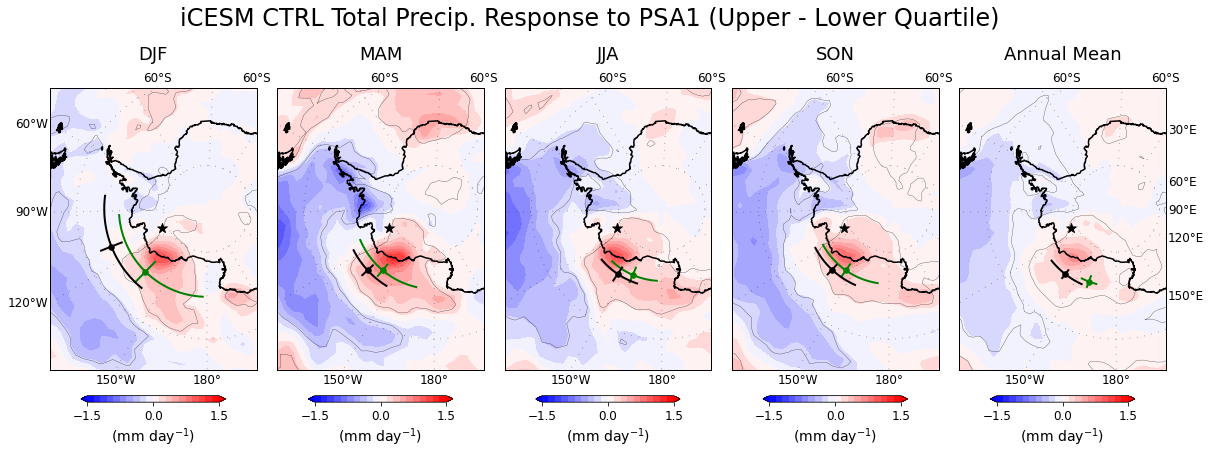

In [26]:
fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(20,6), sharex=True, sharey=True)
fig.subplots_adjust(hspace=0.0, wspace=0.1)
fig.suptitle('iCESM CTRL Total Precip. Response to PSA1 (Upper - Lower Quartile)', fontsize=24, y=1.05)

# setup Lambert Conformal basemap.
diff_djf = djf_tp_w_upper_PSA1_detrend_ctrl.mean(axis=0)-djf_tp_w_lower_PSA1_detrend_ctrl.mean(axis=0)
diff_mam = mam_tp_w_upper_PSA1_detrend_ctrl.mean(axis=0)-mam_tp_w_lower_PSA1_detrend_ctrl.mean(axis=0)
diff_jja = jja_tp_w_upper_PSA1_detrend_ctrl.mean(axis=0)-jja_tp_w_lower_PSA1_detrend_ctrl.mean(axis=0)
diff_son = son_tp_w_upper_PSA1_detrend_ctrl.mean(axis=0)-son_tp_w_lower_PSA1_detrend_ctrl.mean(axis=0)
diff_ann = ann_mean_tp_w_upper_PSA1_detrend_ctrl.mean(axis=0)-ann_mean_tp_w_lower_PSA1_detrend_ctrl.mean(axis=0)
diff_djf_sh, lons = add_cyclic_point(diff_djf.values, CTRL_DATA.coords['lon'].values, axis=-1)
diff_mam_sh, lons = add_cyclic_point(diff_mam.values, CTRL_DATA.coords['lon'].values, axis=-1)
diff_jja_sh, lons = add_cyclic_point(diff_jja.values, CTRL_DATA.coords['lon'].values, axis=-1)
diff_son_sh, lons = add_cyclic_point(diff_son.values, CTRL_DATA.coords['lon'].values, axis=-1)
diff_ann_sh, lons = add_cyclic_point(diff_ann.values, CTRL_DATA.coords['lon'].values, axis=-1)
diff_djf_con, lons = add_cyclic_point(djf_tp_change_due_to_PSA1_ttest_stats_ctrl, CTRL_DATA.coords['lon'].values, axis=-1)
diff_mam_con, lons = add_cyclic_point(mam_tp_change_due_to_PSA1_ttest_stats_ctrl, CTRL_DATA.coords['lon'].values, axis=-1)
diff_jja_con, lons = add_cyclic_point(jja_tp_change_due_to_PSA1_ttest_stats_ctrl, CTRL_DATA.coords['lon'].values, axis=-1)
diff_son_con, lons = add_cyclic_point(son_tp_change_due_to_PSA1_ttest_stats_ctrl, CTRL_DATA.coords['lon'].values, axis=-1)
diff_ann_con, lons = add_cyclic_point(ann_mean_tp_change_due_to_PSA1_ttest_stats_ctrl, CTRL_DATA.coords['lon'].values, axis=-1)

lon, lat = np.meshgrid(lons,CTRL_DATA.coords['lat'].sel(lat=slice(shem_ylo, shem_yhi)).values)
levels = np.arange(-1.5,1.65,.15)
levels_contour = [-2.028,2.028] #good for seasons and annual mean

parallels = np.arange(-80,-1,20)
meridians = np.arange(0,360,30.)
plt.rcParams['contour.negative_linestyle'] = 'solid'
plt.rcParams['text.latex.preamble']=[r"\usepackage{wasysym}"]

#DJF
plt.subplot(1, 5, 1)
m = Basemap(llcrnrlon=-135,llcrnrlat=-40,urcrnrlon=20,urcrnrlat=-60,projection='lcc',
            resolution='l',lat_1=-89.,lat_2=-65,lat_0=-70,lon_0=180.)
x, y = m(lon, lat)
# draw coastlines.
m.drawcoastlines(linewidth=1.5)
m.drawmapboundary(fill_color='white')
# labels = [left,right,top,bottom]
m.drawparallels(parallels,labels=[False,False,True,False],dashes=[.3, 7],fontsize=12)
m.drawmeridians(meridians,labels=[True,False,False,True],dashes=[.3, 7],fontsize=12)
#CS = m.contourf(x,y,(djf_tp_w_upper_PSA1_detrend_ctrl.mean(axis=0)-djf_tp_w_lower_PSA1_detrend_ctrl.mean(axis=0)).where((djf_tp_change_due_to_PSA1_ttest_stats_ctrl >= levels_contour[1]) | (djf_tp_change_due_to_PSA1_ttest_stats_ctrl < levels_contour[0]) ),levels,cmap=plt.cm.get_cmap('bwr'),extend='both')
# CS = m.contourf(x,y,(djf_tp_w_upper_PSA1_detrend_ctrl.mean(axis=0)-djf_tp_w_lower_PSA1_detrend_ctrl.mean(axis=0)),levels,cmap=plt.cm.get_cmap('bwr'),extend='both')
CS = m.contourf(x,y,(diff_djf_sh),levels,cmap=plt.cm.get_cmap('bwr'),extend='both')
#plt.ylabel('V10', fontsize=20)
cbar = plt.colorbar(orientation='horizontal', shrink=0.70, aspect=20, fraction=0.033, pad=0.08)
cbar.set_label(r'(mm day$^{-1}$)',size=14)
cbar.set_ticks([-1.5, 0, 1.5])
cbar.ax.tick_params(labelsize=12)
plt.clim([-1.5,1.5])
CS2 = m.contour(x,y,diff_djf_con,levels_contour,linewidths=0.25,colors='k')

#add Rel. CP mean location for upper and lower indice
#upper
xpt,ypt = m(djf_Rel_CP_indices_w_upper_PSA1_detrend_ctrl.lons.mean(),
            djf_Rel_CP_indices_w_upper_PSA1_detrend_ctrl.lats.mean()
           )
plt.scatter(xpt, ypt, c='green', marker='o', s=30) #for value dependent: vmin=-10, vmax=0, cmap='green'
#lower
xpt,ypt = m(djf_Rel_CP_indices_w_lower_PSA1_detrend_ctrl.lons.mean(),
            djf_Rel_CP_indices_w_lower_PSA1_detrend_ctrl.lats.mean()
           )
plt.scatter(xpt, ypt, c='k', marker='o', s=30) #for value dependent: vmin=-10, vmax=0, cmap='green'

#Add +- 1std of long and lat
#upper
lat_line = np.linspace(djf_Rel_CP_indices_w_upper_PSA1_detrend_ctrl.lats.mean()
                       ,djf_Rel_CP_indices_w_upper_PSA1_detrend_ctrl.lats.mean()
                       ,100) 
lon_line = np.linspace(djf_Rel_CP_indices_w_upper_PSA1_detrend_ctrl.lons.mean()+djf_Rel_CP_indices_w_upper_PSA1_detrend_ctrl.lons.std()
                       ,djf_Rel_CP_indices_w_upper_PSA1_detrend_ctrl.lons.mean()-djf_Rel_CP_indices_w_upper_PSA1_detrend_ctrl.lons.std()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, color='green', linewidth=2) 

lat_line = np.linspace(djf_Rel_CP_indices_w_upper_PSA1_detrend_ctrl.lats.mean()+djf_Rel_CP_indices_w_upper_PSA1_detrend_ctrl.lats.std()
                       ,djf_Rel_CP_indices_w_upper_PSA1_detrend_ctrl.lats.mean()-djf_Rel_CP_indices_w_upper_PSA1_detrend_ctrl.lats.std()
                       ,100) 
lon_line = np.linspace(djf_Rel_CP_indices_w_upper_PSA1_detrend_ctrl.lons.mean()
                       ,djf_Rel_CP_indices_w_upper_PSA1_detrend_ctrl.lons.mean()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='green', linewidth=2)
#lower
lat_line = np.linspace(djf_Rel_CP_indices_w_lower_PSA1_detrend_ctrl.lats.mean()
                       ,djf_Rel_CP_indices_w_lower_PSA1_detrend_ctrl.lats.mean()
                       ,100) 
lon_line = np.linspace(djf_Rel_CP_indices_w_lower_PSA1_detrend_ctrl.lons.mean()+djf_Rel_CP_indices_w_lower_PSA1_detrend_ctrl.lons.std()
                       ,djf_Rel_CP_indices_w_lower_PSA1_detrend_ctrl.lons.mean()-djf_Rel_CP_indices_w_lower_PSA1_detrend_ctrl.lons.std()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='k', linewidth=2) 

lat_line = np.linspace(djf_Rel_CP_indices_w_lower_PSA1_detrend_ctrl.lats.mean()+djf_Rel_CP_indices_w_lower_PSA1_detrend_ctrl.lats.std()
                       ,djf_Rel_CP_indices_w_lower_PSA1_detrend_ctrl.lats.mean()-djf_Rel_CP_indices_w_lower_PSA1_detrend_ctrl.lats.std()
                       ,100) 
lon_line = np.linspace(djf_Rel_CP_indices_w_lower_PSA1_detrend_ctrl.lons.mean()
                       ,djf_Rel_CP_indices_w_lower_PSA1_detrend_ctrl.lons.mean()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='k', linewidth=2)

#add point for central Psuedo cores
xpt,ypt = m(247.5, -78.63)
plt.scatter(xpt, ypt, c='k', marker='*', s=100)

plt.title('DJF',y=1.08,fontsize=18)
print(djf_Rel_CP_indices_w_upper_PSA1_detrend_ctrl.vals.mean(),djf_Rel_CP_indices_w_lower_PSA1_detrend_ctrl.vals.mean())


#MAM
plt.subplot(1, 5, 2)
m = Basemap(llcrnrlon=-135,llcrnrlat=-40,urcrnrlon=20,urcrnrlat=-60,projection='lcc',
            resolution='l',lat_1=-89.,lat_2=-65,lat_0=-70,lon_0=180.)
x, y = m(lon, lat)
# draw coastlines.
m.drawcoastlines(linewidth=1.5)
m.drawmapboundary(fill_color='white')
# labels = [left,right,top,bottom]
m.drawparallels(parallels,labels=[False,False,True,False],dashes=[.3, 7],fontsize=12)
m.drawmeridians(meridians,labels=[False,False,False,True],dashes=[.3, 7],fontsize=12)
#CS = m.contourf(x,y,(mam_tp_w_upper_PSA1_detrend_ctrl.mean(axis=0)-mam_tp_w_lower_PSA1_detrend_ctrl.mean(axis=0)).where((mam_tp_change_due_to_PSA1_ttest_stats_ctrl >= levels_contour[1]) | (mam_tp_change_due_to_PSA1_ttest_stats_ctrl < levels_contour[0]) ),levels,cmap=plt.cm.get_cmap('bwr'),extend='both')
CS = m.contourf(x,y,(diff_mam_sh),levels,cmap=plt.cm.get_cmap('bwr'),extend='both')
#plt.ylabel('V10', fontsize=20)
cbar = plt.colorbar(orientation='horizontal', shrink=0.70, aspect=20, fraction=0.033, pad=0.08)
cbar.set_label(r'(mm day$^{-1}$)',size=14)
cbar.set_ticks([-1.5, 0, 1.5])
cbar.ax.tick_params(labelsize=12)
plt.clim([-1.5,1.5])
CS2 = m.contour(x,y,diff_mam_con,levels_contour,linewidths=0.25,colors='k')

#add Rel. CP mean location for upper and lower indice
#upper
xpt,ypt = m(mam_Rel_CP_indices_w_upper_PSA1_detrend_ctrl.lons.mean(),
            mam_Rel_CP_indices_w_upper_PSA1_detrend_ctrl.lats.mean()
           )
plt.scatter(xpt, ypt, c='green', marker='o', s=30) #for value dependent: vmin=-10, vmax=0, cmap='green'
#lower
xpt,ypt = m(mam_Rel_CP_indices_w_lower_PSA1_detrend_ctrl.lons.mean(),
            mam_Rel_CP_indices_w_lower_PSA1_detrend_ctrl.lats.mean()
           )
plt.scatter(xpt, ypt, c='k', marker='o', s=30) #for value dependent: vmin=-10, vmax=0, cmap='green'

#Add +- 1std of long and lat
#upper
lat_line = np.linspace(mam_Rel_CP_indices_w_upper_PSA1_detrend_ctrl.lats.mean()
                       ,mam_Rel_CP_indices_w_upper_PSA1_detrend_ctrl.lats.mean()
                       ,100) 
lon_line = np.linspace(mam_Rel_CP_indices_w_upper_PSA1_detrend_ctrl.lons.mean()+mam_Rel_CP_indices_w_upper_PSA1_detrend_ctrl.lons.std()
                       ,mam_Rel_CP_indices_w_upper_PSA1_detrend_ctrl.lons.mean()-mam_Rel_CP_indices_w_upper_PSA1_detrend_ctrl.lons.std()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, color='green', linewidth=2) 

lat_line = np.linspace(mam_Rel_CP_indices_w_upper_PSA1_detrend_ctrl.lats.mean()+mam_Rel_CP_indices_w_upper_PSA1_detrend_ctrl.lats.std()
                       ,mam_Rel_CP_indices_w_upper_PSA1_detrend_ctrl.lats.mean()-mam_Rel_CP_indices_w_upper_PSA1_detrend_ctrl.lats.std()
                       ,100) 
lon_line = np.linspace(mam_Rel_CP_indices_w_upper_PSA1_detrend_ctrl.lons.mean()
                       ,mam_Rel_CP_indices_w_upper_PSA1_detrend_ctrl.lons.mean()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='green', linewidth=2)
#lower
lat_line = np.linspace(mam_Rel_CP_indices_w_lower_PSA1_detrend_ctrl.lats.mean()
                       ,mam_Rel_CP_indices_w_lower_PSA1_detrend_ctrl.lats.mean()
                       ,100) 
lon_line = np.linspace(mam_Rel_CP_indices_w_lower_PSA1_detrend_ctrl.lons.mean()+mam_Rel_CP_indices_w_lower_PSA1_detrend_ctrl.lons.std()
                       ,mam_Rel_CP_indices_w_lower_PSA1_detrend_ctrl.lons.mean()-mam_Rel_CP_indices_w_lower_PSA1_detrend_ctrl.lons.std()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='k', linewidth=2) 

lat_line = np.linspace(mam_Rel_CP_indices_w_lower_PSA1_detrend_ctrl.lats.mean()+mam_Rel_CP_indices_w_lower_PSA1_detrend_ctrl.lats.std()
                       ,mam_Rel_CP_indices_w_lower_PSA1_detrend_ctrl.lats.mean()-mam_Rel_CP_indices_w_lower_PSA1_detrend_ctrl.lats.std()
                       ,100) 
lon_line = np.linspace(mam_Rel_CP_indices_w_lower_PSA1_detrend_ctrl.lons.mean()
                       ,mam_Rel_CP_indices_w_lower_PSA1_detrend_ctrl.lons.mean()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='k', linewidth=2)

#add point for central Psuedo cores
xpt,ypt = m(247.5, -78.63)
plt.scatter(xpt, ypt, c='k', marker='*', s=100)

plt.title('MAM',y=1.08,fontsize=18)
print(mam_Rel_CP_indices_w_upper_PSA1_detrend_ctrl.vals.mean(),mam_Rel_CP_indices_w_lower_PSA1_detrend_ctrl.vals.mean())


#JJA
plt.subplot(1, 5, 3)
m = Basemap(llcrnrlon=-135,llcrnrlat=-40,urcrnrlon=20,urcrnrlat=-60,projection='lcc',
            resolution='l',lat_1=-89.,lat_2=-65,lat_0=-70,lon_0=180.)
x, y = m(lon, lat)
# draw coastlines.
m.drawcoastlines(linewidth=1.5)
m.drawmapboundary(fill_color='white')
# labels = [left,right,top,bottom]
m.drawparallels(parallels,labels=[False,False,True,False],dashes=[.3, 7],fontsize=12)
m.drawmeridians(meridians,labels=[False,False,False,True],dashes=[.3, 7],fontsize=12)
#CS = m.contourf(x,y,(jja_tp_w_upper_PSA1_detrend_ctrl.mean(axis=0)-jja_tp_w_lower_PSA1_detrend_ctrl.mean(axis=0)).where((jja_tp_change_due_to_PSA1_ttest_stats_ctrl >= levels_contour[1]) | (jja_tp_change_due_to_PSA1_ttest_stats_ctrl < levels_contour[0]) ),levels,cmap=plt.cm.get_cmap('bwr'),extend='both')
CS = m.contourf(x,y,(diff_jja_sh),levels,cmap=plt.cm.get_cmap('bwr'),extend='both')
#plt.ylabel('V10', fontsize=20)
cbar = plt.colorbar(orientation='horizontal', shrink=0.70, aspect=20, fraction=0.033, pad=0.08)
cbar.set_label(r'(mm day$^{-1}$)',size=14)
cbar.set_ticks([-1.5, 0, 1.5])
cbar.ax.tick_params(labelsize=12)
plt.clim([-1.5,1.5])
CS2 = m.contour(x,y,diff_jja_con,levels_contour,linewidths=0.25,colors='k')

#add Rel. CP mean location for upper and lower indice
#upper
xpt,ypt = m(jja_Rel_CP_indices_w_upper_PSA1_detrend_ctrl.lons.mean(),
            jja_Rel_CP_indices_w_upper_PSA1_detrend_ctrl.lats.mean()
           )
plt.scatter(xpt, ypt, c='green', marker='o', s=30) #for value dependent: vmin=-10, vmax=0, cmap='green'
#lower
xpt,ypt = m(jja_Rel_CP_indices_w_lower_PSA1_detrend_ctrl.lons.mean(),
            jja_Rel_CP_indices_w_lower_PSA1_detrend_ctrl.lats.mean()
           )
plt.scatter(xpt, ypt, c='k', marker='o', s=30) #for value dependent: vmin=-10, vmax=0, cmap='green'

#Add +- 1std of long and lat
#upper
lat_line = np.linspace(jja_Rel_CP_indices_w_upper_PSA1_detrend_ctrl.lats.mean()
                       ,jja_Rel_CP_indices_w_upper_PSA1_detrend_ctrl.lats.mean()
                       ,100) 
lon_line = np.linspace(jja_Rel_CP_indices_w_upper_PSA1_detrend_ctrl.lons.mean()+jja_Rel_CP_indices_w_upper_PSA1_detrend_ctrl.lons.std()
                       ,jja_Rel_CP_indices_w_upper_PSA1_detrend_ctrl.lons.mean()-jja_Rel_CP_indices_w_upper_PSA1_detrend_ctrl.lons.std()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, color='green', linewidth=2) 

lat_line = np.linspace(jja_Rel_CP_indices_w_upper_PSA1_detrend_ctrl.lats.mean()+jja_Rel_CP_indices_w_upper_PSA1_detrend_ctrl.lats.std()
                       ,jja_Rel_CP_indices_w_upper_PSA1_detrend_ctrl.lats.mean()-jja_Rel_CP_indices_w_upper_PSA1_detrend_ctrl.lats.std()
                       ,100) 
lon_line = np.linspace(jja_Rel_CP_indices_w_upper_PSA1_detrend_ctrl.lons.mean()
                       ,jja_Rel_CP_indices_w_upper_PSA1_detrend_ctrl.lons.mean()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='green', linewidth=2)
#lower
lat_line = np.linspace(jja_Rel_CP_indices_w_lower_PSA1_detrend_ctrl.lats.mean()
                       ,jja_Rel_CP_indices_w_lower_PSA1_detrend_ctrl.lats.mean()
                       ,100) 
lon_line = np.linspace(jja_Rel_CP_indices_w_lower_PSA1_detrend_ctrl.lons.mean()+jja_Rel_CP_indices_w_lower_PSA1_detrend_ctrl.lons.std()
                       ,jja_Rel_CP_indices_w_lower_PSA1_detrend_ctrl.lons.mean()-jja_Rel_CP_indices_w_lower_PSA1_detrend_ctrl.lons.std()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='k', linewidth=2) 

lat_line = np.linspace(jja_Rel_CP_indices_w_lower_PSA1_detrend_ctrl.lats.mean()+jja_Rel_CP_indices_w_lower_PSA1_detrend_ctrl.lats.std()
                       ,jja_Rel_CP_indices_w_lower_PSA1_detrend_ctrl.lats.mean()-jja_Rel_CP_indices_w_lower_PSA1_detrend_ctrl.lats.std()
                       ,100) 
lon_line = np.linspace(jja_Rel_CP_indices_w_lower_PSA1_detrend_ctrl.lons.mean()
                       ,jja_Rel_CP_indices_w_lower_PSA1_detrend_ctrl.lons.mean()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='k', linewidth=2)

#add point for central Psuedo cores
xpt,ypt = m(247.5, -78.63)
plt.scatter(xpt, ypt, c='k', marker='*', s=100)

plt.title('JJA',y=1.08,fontsize=18)
print(jja_Rel_CP_indices_w_upper_PSA1_detrend_ctrl.vals.mean(),jja_Rel_CP_indices_w_lower_PSA1_detrend_ctrl.vals.mean())


#SON
plt.subplot(1, 5, 4)
m = Basemap(llcrnrlon=-135,llcrnrlat=-40,urcrnrlon=20,urcrnrlat=-60,projection='lcc',
            resolution='l',lat_1=-89.,lat_2=-65,lat_0=-70,lon_0=180.)
x, y = m(lon, lat)
# draw coastlines.
m.drawcoastlines(linewidth=1.5)
m.drawmapboundary(fill_color='white')
# labels = [left,right,top,bottom]
m.drawparallels(parallels,labels=[False,False,True,False],dashes=[.3, 7],fontsize=12)
m.drawmeridians(meridians,labels=[False,False,False,True],dashes=[.3, 7],fontsize=12)
#CS = m.contourf(x,y,(son_tp_w_upper_PSA1_detrend_ctrl.mean(axis=0)-son_tp_w_lower_PSA1_detrend_ctrl.mean(axis=0)).where((son_tp_change_due_to_PSA1_ttest_stats_ctrl >= levels_contour[1]) | (son_tp_change_due_to_PSA1_ttest_stats_ctrl < levels_contour[0]) ),levels,cmap=plt.cm.get_cmap('bwr'),extend='both')
CS = m.contourf(x,y,(diff_son_sh),levels,cmap=plt.cm.get_cmap('bwr'),extend='both')
#plt.ylabel('V10', fontsize=20)
cbar = plt.colorbar(orientation='horizontal', shrink=0.70, aspect=20, fraction=0.033, pad=0.08)
cbar.set_label(r'(mm day$^{-1}$)',size=14)
cbar.set_ticks([-1.5, 0, 1.5])
cbar.ax.tick_params(labelsize=12)
plt.clim([-1.5,1.5])
CS2 = m.contour(x,y,diff_son_con,levels_contour,linewidths=0.25,colors='k')

#add Rel. CP mean location for upper and lower indice
#upper
xpt,ypt = m(son_Rel_CP_indices_w_upper_PSA1_detrend_ctrl.lons.mean(),
            son_Rel_CP_indices_w_upper_PSA1_detrend_ctrl.lats.mean()
           )
plt.scatter(xpt, ypt, c='green', marker='o', s=30) #for value dependent: vmin=-10, vmax=0, cmap='green'
#lower
xpt,ypt = m(son_Rel_CP_indices_w_lower_PSA1_detrend_ctrl.lons.mean(),
            son_Rel_CP_indices_w_lower_PSA1_detrend_ctrl.lats.mean()
           )
plt.scatter(xpt, ypt, c='k', marker='o', s=30) #for value dependent: vmin=-10, vmax=0, cmap='green'

#Add +- 1std of long and lat
#upper
lat_line = np.linspace(son_Rel_CP_indices_w_upper_PSA1_detrend_ctrl.lats.mean()
                       ,son_Rel_CP_indices_w_upper_PSA1_detrend_ctrl.lats.mean()
                       ,100) 
lon_line = np.linspace(son_Rel_CP_indices_w_upper_PSA1_detrend_ctrl.lons.mean()+son_Rel_CP_indices_w_upper_PSA1_detrend_ctrl.lons.std()
                       ,son_Rel_CP_indices_w_upper_PSA1_detrend_ctrl.lons.mean()-son_Rel_CP_indices_w_upper_PSA1_detrend_ctrl.lons.std()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, color='green', linewidth=2) 

lat_line = np.linspace(son_Rel_CP_indices_w_upper_PSA1_detrend_ctrl.lats.mean()+son_Rel_CP_indices_w_upper_PSA1_detrend_ctrl.lats.std()
                       ,son_Rel_CP_indices_w_upper_PSA1_detrend_ctrl.lats.mean()-son_Rel_CP_indices_w_upper_PSA1_detrend_ctrl.lats.std()
                       ,100) 
lon_line = np.linspace(son_Rel_CP_indices_w_upper_PSA1_detrend_ctrl.lons.mean()
                       ,son_Rel_CP_indices_w_upper_PSA1_detrend_ctrl.lons.mean()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='green', linewidth=2)
#lower
lat_line = np.linspace(son_Rel_CP_indices_w_lower_PSA1_detrend_ctrl.lats.mean()
                       ,son_Rel_CP_indices_w_lower_PSA1_detrend_ctrl.lats.mean()
                       ,100) 
lon_line = np.linspace(son_Rel_CP_indices_w_lower_PSA1_detrend_ctrl.lons.mean()+son_Rel_CP_indices_w_lower_PSA1_detrend_ctrl.lons.std()
                       ,son_Rel_CP_indices_w_lower_PSA1_detrend_ctrl.lons.mean()-son_Rel_CP_indices_w_lower_PSA1_detrend_ctrl.lons.std()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='k', linewidth=2) 

lat_line = np.linspace(son_Rel_CP_indices_w_lower_PSA1_detrend_ctrl.lats.mean()+son_Rel_CP_indices_w_lower_PSA1_detrend_ctrl.lats.std()
                       ,son_Rel_CP_indices_w_lower_PSA1_detrend_ctrl.lats.mean()-son_Rel_CP_indices_w_lower_PSA1_detrend_ctrl.lats.std()
                       ,100) 
lon_line = np.linspace(son_Rel_CP_indices_w_lower_PSA1_detrend_ctrl.lons.mean()
                       ,son_Rel_CP_indices_w_lower_PSA1_detrend_ctrl.lons.mean()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='k', linewidth=2)

#add point for central Psuedo cores
xpt,ypt = m(247.5, -78.63)
plt.scatter(xpt, ypt, c='k', marker='*', s=100)

plt.title('SON',y=1.08,fontsize=18)
print(son_Rel_CP_indices_w_upper_PSA1_detrend_ctrl.vals.mean(),son_Rel_CP_indices_w_lower_PSA1_detrend_ctrl.vals.mean())


#Annual Mean
plt.subplot(1, 5, 5)
m = Basemap(llcrnrlon=-135,llcrnrlat=-40,urcrnrlon=20,urcrnrlat=-60,projection='lcc',
            resolution='l',lat_1=-89.,lat_2=-65,lat_0=-70,lon_0=180.)
x, y = m(lon, lat)
# draw coastlines.
m.drawcoastlines(linewidth=1.5)
m.drawmapboundary(fill_color='white')
# labels = [left,right,top,bottom]
m.drawparallels(parallels,labels=[False,False,True,False],dashes=[.3, 7],fontsize=12)
m.drawmeridians(meridians,labels=[False,True,False,True],dashes=[.3, 7],fontsize=12)
#CS = m.contourf(x,y,(ann_mean_tp_w_upper_PSA1_detrend_ctrl.mean(axis=0)-ann_mean_tp_w_lower_PSA1_detrend_ctrl.mean(axis=0)).where((ann_mean_tp_change_due_to_PSA1_ttest_stats_ctrl >= levels_contour[1]) | (ann_mean_tp_change_due_to_PSA1_ttest_stats_ctrl < levels_contour[0]) ),levels,cmap=plt.cm.get_cmap('bwr'),extend='both')
CS = m.contourf(x,y,(diff_ann_sh),levels,cmap=plt.cm.get_cmap('bwr'),extend='both')
#plt.ylabel('V10', fontsize=20)
cbar = plt.colorbar(orientation='horizontal', shrink=0.70, aspect=20, fraction=0.033, pad=0.08)
cbar.set_label(r'(mm day$^{-1}$)',size=14)
cbar.set_ticks([-1.5, 0, 1.5])
cbar.ax.tick_params(labelsize=12)
plt.clim([-1.5,1.5])
CS2 = m.contour(x,y,diff_ann_con,levels_contour,linewidths=0.25,colors='k')

#add Rel. CP mean location for upper and lower indice
#upper
xpt,ypt = m(ann_mean_Rel_CP_indices_w_upper_PSA1_detrend_ctrl.lons.mean(),
            ann_mean_Rel_CP_indices_w_upper_PSA1_detrend_ctrl.lats.mean()
           )
plt.scatter(xpt, ypt, c='green', marker='o', s=30) #for value dependent: vmin=-10, vmax=0, cmap='green'
#lower
xpt,ypt = m(ann_mean_Rel_CP_indices_w_lower_PSA1_detrend_ctrl.lons.mean(),
            ann_mean_Rel_CP_indices_w_lower_PSA1_detrend_ctrl.lats.mean()
           )
plt.scatter(xpt, ypt, c='k', marker='o', s=30) #for value dependent: vmin=-10, vmax=0, cmap='green'

#Add +- 1std of long and lat
#upper
lat_line = np.linspace(ann_mean_Rel_CP_indices_w_upper_PSA1_detrend_ctrl.lats.mean()
                       ,ann_mean_Rel_CP_indices_w_upper_PSA1_detrend_ctrl.lats.mean()
                       ,100) 
lon_line = np.linspace(ann_mean_Rel_CP_indices_w_upper_PSA1_detrend_ctrl.lons.mean()+ann_mean_Rel_CP_indices_w_upper_PSA1_detrend_ctrl.lons.std()
                       ,ann_mean_Rel_CP_indices_w_upper_PSA1_detrend_ctrl.lons.mean()-ann_mean_Rel_CP_indices_w_upper_PSA1_detrend_ctrl.lons.std()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, color='green', linewidth=2) 

lat_line = np.linspace(ann_mean_Rel_CP_indices_w_upper_PSA1_detrend_ctrl.lats.mean()+ann_mean_Rel_CP_indices_w_upper_PSA1_detrend_ctrl.lats.std()
                       ,ann_mean_Rel_CP_indices_w_upper_PSA1_detrend_ctrl.lats.mean()-ann_mean_Rel_CP_indices_w_upper_PSA1_detrend_ctrl.lats.std()
                       ,100) 
lon_line = np.linspace(ann_mean_Rel_CP_indices_w_upper_PSA1_detrend_ctrl.lons.mean()
                       ,ann_mean_Rel_CP_indices_w_upper_PSA1_detrend_ctrl.lons.mean()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='green', linewidth=2)
#lower
lat_line = np.linspace(ann_mean_Rel_CP_indices_w_lower_PSA1_detrend_ctrl.lats.mean()
                       ,ann_mean_Rel_CP_indices_w_lower_PSA1_detrend_ctrl.lats.mean()
                       ,100) 
lon_line = np.linspace(ann_mean_Rel_CP_indices_w_lower_PSA1_detrend_ctrl.lons.mean()+ann_mean_Rel_CP_indices_w_lower_PSA1_detrend_ctrl.lons.std()
                       ,ann_mean_Rel_CP_indices_w_lower_PSA1_detrend_ctrl.lons.mean()-ann_mean_Rel_CP_indices_w_lower_PSA1_detrend_ctrl.lons.std()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='k', linewidth=2) 

lat_line = np.linspace(ann_mean_Rel_CP_indices_w_lower_PSA1_detrend_ctrl.lats.mean()+ann_mean_Rel_CP_indices_w_lower_PSA1_detrend_ctrl.lats.std()
                       ,ann_mean_Rel_CP_indices_w_lower_PSA1_detrend_ctrl.lats.mean()-ann_mean_Rel_CP_indices_w_lower_PSA1_detrend_ctrl.lats.std()
                       ,100) 
lon_line = np.linspace(ann_mean_Rel_CP_indices_w_lower_PSA1_detrend_ctrl.lons.mean()
                       ,ann_mean_Rel_CP_indices_w_lower_PSA1_detrend_ctrl.lons.mean()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='k', linewidth=2)

#add point for central Psuedo cores
xpt,ypt = m(247.5, -78.63)
plt.scatter(xpt, ypt, c='k', marker='*', s=100)

plt.title('Annual Mean',y=1.08,fontsize=18)
print(ann_mean_Rel_CP_indices_w_upper_PSA1_detrend_ctrl.vals.mean(),ann_mean_Rel_CP_indices_w_lower_PSA1_detrend_ctrl.vals.mean())


# plt.savefig(FIG_PATH+'/OLD_Figure_iCESM_CTRL_TAGGED_tp_Field_vs_PSA1_Quartiles_20210324.pdf',bbox_inches='tight', pad_inches=0.05)

plt.show()

In [27]:
#Find PSA2 values for each of the 8 time periods and put in pd.DataFrame
#Then, select the upper and lower quartile values

d = {'PSA2': SAM_PSAs_seas_mean_indices_ctrl.PSA2.where(SAM_PSAs_seas_mean_indices_ctrl.Seas_Index == '12').dropna(), 'indice': np.arange(0,len(SAM_PSAs_seas_mean_indices_ctrl.PSA2.where(SAM_PSAs_seas_mean_indices_ctrl.Seas_Index == '12').dropna()),1)}
PSA2_djf_mean_ctrl = pd.DataFrame(data=d)
# PSA2_djf_mean_ctrl

d = {'PSA2': SAM_PSAs_seas_mean_indices_ctrl.PSA2.where(SAM_PSAs_seas_mean_indices_ctrl.Seas_Index == '03').dropna(), 'indice': np.arange(0,len(SAM_PSAs_seas_mean_indices_ctrl.PSA2.where(SAM_PSAs_seas_mean_indices_ctrl.Seas_Index == '03').dropna()),1)}
PSA2_mam_mean_ctrl = pd.DataFrame(data=d)
# PSA2_mam_mean_ctrl

d = {'PSA2': SAM_PSAs_seas_mean_indices_ctrl.PSA2.where(SAM_PSAs_seas_mean_indices_ctrl.Seas_Index == '06').dropna(), 'indice': np.arange(0,len(SAM_PSAs_seas_mean_indices_ctrl.PSA2.where(SAM_PSAs_seas_mean_indices_ctrl.Seas_Index == '06').dropna()),1)}
PSA2_jja_mean_ctrl = pd.DataFrame(data=d)
# PSA2_jja_mean_ctrl

d = {'PSA2': SAM_PSAs_seas_mean_indices_ctrl.PSA2.where(SAM_PSAs_seas_mean_indices_ctrl.Seas_Index == '09').dropna(), 'indice': np.arange(0,len(SAM_PSAs_seas_mean_indices_ctrl.PSA2.where(SAM_PSAs_seas_mean_indices_ctrl.Seas_Index == '09').dropna()),1)}
PSA2_son_mean_ctrl = pd.DataFrame(data=d)
# PSA2_son_mean_ctrl

d = {'PSA2': SAM_PSAs_ann_mean_indices_ctrl.PSA2.dropna(), 'indice': np.arange(0, len(SAM_PSAs_ann_mean_indices_ctrl.PSA2.dropna()),1)}
PSA2_ann_mean_ctrl = pd.DataFrame(data=d)
# PSA2_ann_mean_ctrl


#create list of indices representing the upper/lower quartiles of 'PSA2'
#Note, head is lower (sorted from low to high)
PSA2_djf_mean_lower_ctrl = PSA2_djf_mean_ctrl.sort_values(by=['PSA2']).head(n=(round(PSA2_djf_mean_ctrl.indice.size/4))).indice.tolist()
# PSA2_djf_mean_lower_ctrl
PSA2_djf_mean_upper_ctrl = PSA2_djf_mean_ctrl.sort_values(by=['PSA2']).tail(n=(round(PSA2_djf_mean_ctrl.indice.size/4))).indice.tolist()
# PSA2_djf_mean_upper_ctrl

PSA2_mam_mean_lower_ctrl = PSA2_mam_mean_ctrl.sort_values(by=['PSA2']).head(n=(round(PSA2_mam_mean_ctrl.indice.size/4))).indice.tolist()
# PSA2_mam_mean_lower_ctrl
PSA2_mam_mean_upper_ctrl = PSA2_mam_mean_ctrl.sort_values(by=['PSA2']).tail(n=(round(PSA2_mam_mean_ctrl.indice.size/4))).indice.tolist()
# PSA2_mam_mean_upper_ctrl

PSA2_jja_mean_lower_ctrl = PSA2_jja_mean_ctrl.sort_values(by=['PSA2']).head(n=(round(PSA2_jja_mean_ctrl.indice.size/4))).indice.tolist()
# PSA2_jja_mean_lower_ctrl
PSA2_jja_mean_upper_ctrl = PSA2_jja_mean_ctrl.sort_values(by=['PSA2']).tail(n=(round(PSA2_jja_mean_ctrl.indice.size/4))).indice.tolist()
# PSA2_jja_mean_upper_ctrl

PSA2_son_mean_lower_ctrl = PSA2_son_mean_ctrl.sort_values(by=['PSA2']).head(n=(round(PSA2_son_mean_ctrl.indice.size/4))).indice.tolist()
# PSA2_son_mean_lower_ctrl
PSA2_son_mean_upper_ctrl = PSA2_son_mean_ctrl.sort_values(by=['PSA2']).tail(n=(round(PSA2_son_mean_ctrl.indice.size/4))).indice.tolist()
# PSA2_son_mean_upper_ctrl

PSA2_ann_mean_lower_ctrl = PSA2_ann_mean_ctrl.sort_values(by=['PSA2']).head(n=(round(PSA2_ann_mean_ctrl.indice.size/4))).indice.tolist()
# PSA2_ann_mean_lower_ctrl
PSA2_ann_mean_upper_ctrl = PSA2_ann_mean_ctrl.sort_values(by=['PSA2']).tail(n=(round(PSA2_ann_mean_ctrl.indice.size/4))).indice.tolist()
# PSA2_ann_mean_upper_ctrl

In [28]:
#Select the times of the field variable dependent upon quartile and the indice 

#DJF, (both datasets already at s=47, so no need to crop the time series)
djf_tp_w_upper_PSA2_detrend_ctrl = djf_tp_shem_seas_mean_detrend_ctrl.isel(time = PSA2_djf_mean_upper_ctrl)
djf_tp_w_lower_PSA2_detrend_ctrl = djf_tp_shem_seas_mean_detrend_ctrl.isel(time = PSA2_djf_mean_lower_ctrl)
# djf_tp_w_upper_PSA2_detrend_ctrl
# djf_tp_w_lower_PSA2_detrend_ctrl

#mam
mam_tp_w_upper_PSA2_detrend_ctrl = mam_tp_shem_seas_mean_detrend_ctrl.isel(time = PSA2_mam_mean_upper_ctrl)
mam_tp_w_lower_PSA2_detrend_ctrl = mam_tp_shem_seas_mean_detrend_ctrl.isel(time = PSA2_mam_mean_lower_ctrl)
# mam_tp_w_upper_PSA2_detrend_ctrl
# mam_tp_w_lower_PSA2_detrend_ctrl

#jja
jja_tp_w_upper_PSA2_detrend_ctrl = jja_tp_shem_seas_mean_detrend_ctrl.isel(time = PSA2_jja_mean_upper_ctrl)
jja_tp_w_lower_PSA2_detrend_ctrl = jja_tp_shem_seas_mean_detrend_ctrl.isel(time = PSA2_jja_mean_lower_ctrl)
# jja_tp_w_upper_PSA2_detrend_ctrl
# jja_tp_w_lower_PSA2_detrend_ctrl

#son
son_tp_w_upper_PSA2_detrend_ctrl = son_tp_shem_seas_mean_detrend_ctrl.isel(time = PSA2_son_mean_upper_ctrl)
son_tp_w_lower_PSA2_detrend_ctrl = son_tp_shem_seas_mean_detrend_ctrl.isel(time = PSA2_son_mean_lower_ctrl)
son_tp_w_upper_PSA2_detrend_ctrl
# son_tp_w_lower_PSA2_detrend_ctrl

#ann mean
ann_mean_tp_w_upper_PSA2_detrend_ctrl = tp_shem_ann_mean_detrend_ctrl.isel(time = PSA2_ann_mean_upper_ctrl)
ann_mean_tp_w_lower_PSA2_detrend_ctrl = tp_shem_ann_mean_detrend_ctrl.isel(time = PSA2_ann_mean_lower_ctrl)
# ann_mean_tp_w_upper_PSA2_detrend_ctrl
# ann_mean_tp_w_lower_PSA2_detrend_ctrl


In [29]:
#Select ASL Rel CP value, long, and lat while index is in upper or lower quartile
#Using new ASL info from 19Nov2018
#djf
djf_Rel_CP_indices_w_upper_PSA2_detrend_ctrl = Rel_CP_djf_mean_indices_raw_ctrl.iloc[PSA2_djf_mean_upper_ctrl]
# djf_Rel_CP_indices_w_upper_PSA2_detrend_ctrl
djf_Rel_CP_indices_w_lower_PSA2_detrend_ctrl = Rel_CP_djf_mean_indices_raw_ctrl.iloc[PSA2_djf_mean_lower_ctrl]
# djf_Rel_CP_indices_w_lower_PSA2_detrend_ctrl

#mam
mam_Rel_CP_indices_w_upper_PSA2_detrend_ctrl = Rel_CP_mam_mean_indices_raw_ctrl.iloc[PSA2_mam_mean_upper_ctrl]
# mam_Rel_CP_indices_w_upper_PSA2_detrend_ctrl
mam_Rel_CP_indices_w_lower_PSA2_detrend_ctrl = Rel_CP_mam_mean_indices_raw_ctrl.iloc[PSA2_mam_mean_lower_ctrl]
# mam_Rel_CP_indices_w_lower_PSA2_detrend_ctrl

#jja
jja_Rel_CP_indices_w_upper_PSA2_detrend_ctrl = Rel_CP_jja_mean_indices_raw_ctrl.iloc[PSA2_jja_mean_upper_ctrl]
# jja_Rel_CP_indices_w_upper_PSA2_detrend_ctrl
jja_Rel_CP_indices_w_lower_PSA2_detrend_ctrl = Rel_CP_jja_mean_indices_raw_ctrl.iloc[PSA2_jja_mean_lower_ctrl]
# jja_Rel_CP_indices_w_lower_PSA2_detrend_ctrl

#son
son_Rel_CP_indices_w_upper_PSA2_detrend_ctrl = Rel_CP_son_mean_indices_raw_ctrl.iloc[PSA2_son_mean_upper_ctrl]
# son_Rel_CP_indices_w_upper_PSA2_detrend_ctrl
son_Rel_CP_indices_w_lower_PSA2_detrend_ctrl = Rel_CP_son_mean_indices_raw_ctrl.iloc[PSA2_son_mean_lower_ctrl]
# son_Rel_CP_indices_w_lower_PSA2_detrend_ctrl

#annual mean
ann_mean_Rel_CP_indices_w_upper_PSA2_detrend_ctrl = Rel_CP_ann_mean_indices_raw_ctrl.iloc[PSA2_ann_mean_upper_ctrl]
# ann_mean_Rel_CP_indices_w_upper_PSA2_detrend_ctrl
ann_mean_Rel_CP_indices_w_lower_PSA2_detrend_ctrl = Rel_CP_ann_mean_indices_raw_ctrl.iloc[PSA2_ann_mean_lower_ctrl]
# ann_mean_Rel_CP_indices_w_upper_PSA2_detrend_ctrl



In [30]:
#Calculate significance for the change in mean of the field variable for Positive-Negative
#critical value for t-test at 95%:
#Seasonal and ann mean, df=19+19-2 = 36 ; critical value = +- 2.028
#DJF, df =18+18-2 = 34 ; critical value = +- 2.032 (so close to df=36 that I am not going to change)

djf_tp_change_due_to_PSA2_ttest_stats_ctrl, djf_tp_change_due_to_PSA2_ttest_pvals_ctrl = ttest_ind(
    djf_tp_w_upper_PSA2_detrend_ctrl, djf_tp_w_lower_PSA2_detrend_ctrl, axis=0)

mam_tp_change_due_to_PSA2_ttest_stats_ctrl, mam_tp_change_due_to_PSA2_ttest_pvals_ctrl = ttest_ind(
    mam_tp_w_upper_PSA2_detrend_ctrl, mam_tp_w_lower_PSA2_detrend_ctrl, axis=0)

jja_tp_change_due_to_PSA2_ttest_stats_ctrl, jja_tp_change_due_to_PSA2_ttest_pvals_ctrl = ttest_ind(
    jja_tp_w_upper_PSA2_detrend_ctrl, jja_tp_w_lower_PSA2_detrend_ctrl, axis=0)

son_tp_change_due_to_PSA2_ttest_stats_ctrl, son_tp_change_due_to_PSA2_ttest_pvals_ctrl = ttest_ind(
    son_tp_w_upper_PSA2_detrend_ctrl, son_tp_w_lower_PSA2_detrend_ctrl, axis=0)

ann_mean_tp_change_due_to_PSA2_ttest_stats_ctrl, ann_mean_tp_change_due_to_PSA2_ttest_pvals_ctrl = ttest_ind(
    ann_mean_tp_w_upper_PSA2_detrend_ctrl, ann_mean_tp_w_lower_PSA2_detrend_ctrl, axis=0)

/glade/work/pgoddard/NEW_ANACONDA_AND_PY_ENV_24Mar2021/geo_scipy/lib/python3.7/site-packages/cartopy/util.py:102: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  new_data = ma.concatenate((data, data[slicer]), axis=axis)
/glade/work/pgoddard/NEW_ANACONDA_AND_PY_ENV_24Mar2021/geo_scipy/lib/python3.7/site-packages/ipykernel_launcher.py:34: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.


-5.374876643481325 -4.486435325784612


/glade/work/pgoddard/NEW_ANACONDA_AND_PY_ENV_24Mar2021/geo_scipy/lib/python3.7/site-packages/ipykernel_launcher.py:114: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.


-6.908089215714785 -8.050070780168431


/glade/work/pgoddard/NEW_ANACONDA_AND_PY_ENV_24Mar2021/geo_scipy/lib/python3.7/site-packages/ipykernel_launcher.py:193: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.


-7.786907935729884 -10.248190862856978


/glade/work/pgoddard/NEW_ANACONDA_AND_PY_ENV_24Mar2021/geo_scipy/lib/python3.7/site-packages/ipykernel_launcher.py:272: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.


-7.157968732370154 -8.815137848276686


/glade/work/pgoddard/NEW_ANACONDA_AND_PY_ENV_24Mar2021/geo_scipy/lib/python3.7/site-packages/ipykernel_launcher.py:351: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.


-5.365339134086364 -6.6296034630651155


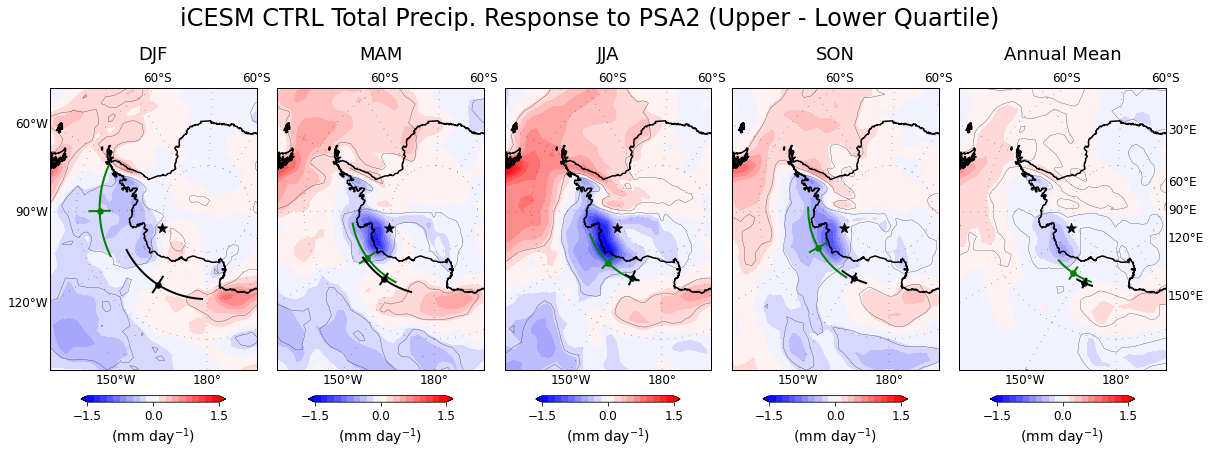

In [31]:
fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(20,6), sharex=True, sharey=True)
fig.subplots_adjust(hspace=0.0, wspace=0.1)
fig.suptitle('iCESM CTRL Total Precip. Response to PSA2 (Upper - Lower Quartile)', fontsize=24, y=1.05)

# setup Lambert Conformal basemap.
diff_djf = djf_tp_w_upper_PSA2_detrend_ctrl.mean(axis=0)-djf_tp_w_lower_PSA2_detrend_ctrl.mean(axis=0)
diff_mam = mam_tp_w_upper_PSA2_detrend_ctrl.mean(axis=0)-mam_tp_w_lower_PSA2_detrend_ctrl.mean(axis=0)
diff_jja = jja_tp_w_upper_PSA2_detrend_ctrl.mean(axis=0)-jja_tp_w_lower_PSA2_detrend_ctrl.mean(axis=0)
diff_son = son_tp_w_upper_PSA2_detrend_ctrl.mean(axis=0)-son_tp_w_lower_PSA2_detrend_ctrl.mean(axis=0)
diff_ann = ann_mean_tp_w_upper_PSA2_detrend_ctrl.mean(axis=0)-ann_mean_tp_w_lower_PSA2_detrend_ctrl.mean(axis=0)
diff_djf_sh, lons = add_cyclic_point(diff_djf.values, CTRL_DATA.coords['lon'].values, axis=-1)
diff_mam_sh, lons = add_cyclic_point(diff_mam.values, CTRL_DATA.coords['lon'].values, axis=-1)
diff_jja_sh, lons = add_cyclic_point(diff_jja.values, CTRL_DATA.coords['lon'].values, axis=-1)
diff_son_sh, lons = add_cyclic_point(diff_son.values, CTRL_DATA.coords['lon'].values, axis=-1)
diff_ann_sh, lons = add_cyclic_point(diff_ann.values, CTRL_DATA.coords['lon'].values, axis=-1)
diff_djf_con, lons = add_cyclic_point(djf_tp_change_due_to_PSA2_ttest_stats_ctrl, CTRL_DATA.coords['lon'].values, axis=-1)
diff_mam_con, lons = add_cyclic_point(mam_tp_change_due_to_PSA2_ttest_stats_ctrl, CTRL_DATA.coords['lon'].values, axis=-1)
diff_jja_con, lons = add_cyclic_point(jja_tp_change_due_to_PSA2_ttest_stats_ctrl, CTRL_DATA.coords['lon'].values, axis=-1)
diff_son_con, lons = add_cyclic_point(son_tp_change_due_to_PSA2_ttest_stats_ctrl, CTRL_DATA.coords['lon'].values, axis=-1)
diff_ann_con, lons = add_cyclic_point(ann_mean_tp_change_due_to_PSA2_ttest_stats_ctrl, CTRL_DATA.coords['lon'].values, axis=-1)

lon, lat = np.meshgrid(lons,CTRL_DATA.coords['lat'].sel(lat=slice(shem_ylo, shem_yhi)).values)
levels = np.arange(-1.5,1.65,.15)
levels_contour = [-2.028,2.028] #good for seasons and annual mean

parallels = np.arange(-80,-1,20)
meridians = np.arange(0,360,30.)
plt.rcParams['contour.negative_linestyle'] = 'solid'
plt.rcParams['text.latex.preamble']=[r"\usepackage{wasysym}"]

#DJF
plt.subplot(1, 5, 1)
m = Basemap(llcrnrlon=-135,llcrnrlat=-40,urcrnrlon=20,urcrnrlat=-60,projection='lcc',
            resolution='l',lat_1=-89.,lat_2=-65,lat_0=-70,lon_0=180.)
x, y = m(lon, lat)
# draw coastlines.
m.drawcoastlines(linewidth=1.5)
m.drawmapboundary(fill_color='white')
# labels = [left,right,top,bottom]
m.drawparallels(parallels,labels=[False,False,True,False],dashes=[.3, 7],fontsize=12)
m.drawmeridians(meridians,labels=[True,False,False,True],dashes=[.3, 7],fontsize=12)
#CS = m.contourf(x,y,(djf_tp_w_upper_PSA2_detrend_ctrl.mean(axis=0)-djf_tp_w_lower_PSA2_detrend_ctrl.mean(axis=0)).where((djf_tp_change_due_to_PSA2_ttest_stats_ctrl >= levels_contour[1]) | (djf_tp_change_due_to_PSA2_ttest_stats_ctrl < levels_contour[0]) ),levels,cmap=plt.cm.get_cmap('bwr'),extend='both')
# CS = m.contourf(x,y,(djf_tp_w_upper_PSA2_detrend_ctrl.mean(axis=0)-djf_tp_w_lower_PSA2_detrend_ctrl.mean(axis=0)),levels,cmap=plt.cm.get_cmap('bwr'),extend='both')
CS = m.contourf(x,y,(diff_djf_sh),levels,cmap=plt.cm.get_cmap('bwr'),extend='both')
#plt.ylabel('V10', fontsize=20)
cbar = plt.colorbar(orientation='horizontal', shrink=0.70, aspect=20, fraction=0.033, pad=0.08)
cbar.set_label(r'(mm day$^{-1}$)',size=14)
cbar.set_ticks([-1.5, 0, 1.5])
cbar.ax.tick_params(labelsize=12)
plt.clim([-1.5,1.5])
CS2 = m.contour(x,y,diff_djf_con,levels_contour,linewidths=0.25,colors='k')

#add Rel. CP mean location for upper and lower indice
#upper
xpt,ypt = m(djf_Rel_CP_indices_w_upper_PSA2_detrend_ctrl.lons.mean(),
            djf_Rel_CP_indices_w_upper_PSA2_detrend_ctrl.lats.mean()
           )
plt.scatter(xpt, ypt, c='green', marker='o', s=30) #for value dependent: vmin=-10, vmax=0, cmap='green'
#lower
xpt,ypt = m(djf_Rel_CP_indices_w_lower_PSA2_detrend_ctrl.lons.mean(),
            djf_Rel_CP_indices_w_lower_PSA2_detrend_ctrl.lats.mean()
           )
plt.scatter(xpt, ypt, c='k', marker='o', s=30) #for value dependent: vmin=-10, vmax=0, cmap='green'

#Add +- 1std of long and lat
#upper
lat_line = np.linspace(djf_Rel_CP_indices_w_upper_PSA2_detrend_ctrl.lats.mean()
                       ,djf_Rel_CP_indices_w_upper_PSA2_detrend_ctrl.lats.mean()
                       ,100) 
lon_line = np.linspace(djf_Rel_CP_indices_w_upper_PSA2_detrend_ctrl.lons.mean()+djf_Rel_CP_indices_w_upper_PSA2_detrend_ctrl.lons.std()
                       ,djf_Rel_CP_indices_w_upper_PSA2_detrend_ctrl.lons.mean()-djf_Rel_CP_indices_w_upper_PSA2_detrend_ctrl.lons.std()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, color='green', linewidth=2) 

lat_line = np.linspace(djf_Rel_CP_indices_w_upper_PSA2_detrend_ctrl.lats.mean()+djf_Rel_CP_indices_w_upper_PSA2_detrend_ctrl.lats.std()
                       ,djf_Rel_CP_indices_w_upper_PSA2_detrend_ctrl.lats.mean()-djf_Rel_CP_indices_w_upper_PSA2_detrend_ctrl.lats.std()
                       ,100) 
lon_line = np.linspace(djf_Rel_CP_indices_w_upper_PSA2_detrend_ctrl.lons.mean()
                       ,djf_Rel_CP_indices_w_upper_PSA2_detrend_ctrl.lons.mean()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='green', linewidth=2)
#lower
lat_line = np.linspace(djf_Rel_CP_indices_w_lower_PSA2_detrend_ctrl.lats.mean()
                       ,djf_Rel_CP_indices_w_lower_PSA2_detrend_ctrl.lats.mean()
                       ,100) 
lon_line = np.linspace(djf_Rel_CP_indices_w_lower_PSA2_detrend_ctrl.lons.mean()+djf_Rel_CP_indices_w_lower_PSA2_detrend_ctrl.lons.std()
                       ,djf_Rel_CP_indices_w_lower_PSA2_detrend_ctrl.lons.mean()-djf_Rel_CP_indices_w_lower_PSA2_detrend_ctrl.lons.std()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='k', linewidth=2) 

lat_line = np.linspace(djf_Rel_CP_indices_w_lower_PSA2_detrend_ctrl.lats.mean()+djf_Rel_CP_indices_w_lower_PSA2_detrend_ctrl.lats.std()
                       ,djf_Rel_CP_indices_w_lower_PSA2_detrend_ctrl.lats.mean()-djf_Rel_CP_indices_w_lower_PSA2_detrend_ctrl.lats.std()
                       ,100) 
lon_line = np.linspace(djf_Rel_CP_indices_w_lower_PSA2_detrend_ctrl.lons.mean()
                       ,djf_Rel_CP_indices_w_lower_PSA2_detrend_ctrl.lons.mean()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='k', linewidth=2)

#add point for central Psuedo cores
xpt,ypt = m(247.5, -78.63)
plt.scatter(xpt, ypt, c='k', marker='*', s=100)

plt.title('DJF',y=1.08,fontsize=18)
print(djf_Rel_CP_indices_w_upper_PSA2_detrend_ctrl.vals.mean(),djf_Rel_CP_indices_w_lower_PSA2_detrend_ctrl.vals.mean())


#MAM
plt.subplot(1, 5, 2)
m = Basemap(llcrnrlon=-135,llcrnrlat=-40,urcrnrlon=20,urcrnrlat=-60,projection='lcc',
            resolution='l',lat_1=-89.,lat_2=-65,lat_0=-70,lon_0=180.)
x, y = m(lon, lat)
# draw coastlines.
m.drawcoastlines(linewidth=1.5)
m.drawmapboundary(fill_color='white')
# labels = [left,right,top,bottom]
m.drawparallels(parallels,labels=[False,False,True,False],dashes=[.3, 7],fontsize=12)
m.drawmeridians(meridians,labels=[False,False,False,True],dashes=[.3, 7],fontsize=12)
#CS = m.contourf(x,y,(mam_tp_w_upper_PSA2_detrend_ctrl.mean(axis=0)-mam_tp_w_lower_PSA2_detrend_ctrl.mean(axis=0)).where((mam_tp_change_due_to_PSA2_ttest_stats_ctrl >= levels_contour[1]) | (mam_tp_change_due_to_PSA2_ttest_stats_ctrl < levels_contour[0]) ),levels,cmap=plt.cm.get_cmap('bwr'),extend='both')
CS = m.contourf(x,y,(diff_mam_sh),levels,cmap=plt.cm.get_cmap('bwr'),extend='both')
#plt.ylabel('V10', fontsize=20)
cbar = plt.colorbar(orientation='horizontal', shrink=0.70, aspect=20, fraction=0.033, pad=0.08)
cbar.set_label(r'(mm day$^{-1}$)',size=14)
cbar.set_ticks([-1.5, 0, 1.5])
cbar.ax.tick_params(labelsize=12)
plt.clim([-1.5,1.5])
CS2 = m.contour(x,y,diff_mam_con,levels_contour,linewidths=0.25,colors='k')

#add Rel. CP mean location for upper and lower indice
#upper
xpt,ypt = m(mam_Rel_CP_indices_w_upper_PSA2_detrend_ctrl.lons.mean(),
            mam_Rel_CP_indices_w_upper_PSA2_detrend_ctrl.lats.mean()
           )
plt.scatter(xpt, ypt, c='green', marker='o', s=30) #for value dependent: vmin=-10, vmax=0, cmap='green'
#lower
xpt,ypt = m(mam_Rel_CP_indices_w_lower_PSA2_detrend_ctrl.lons.mean(),
            mam_Rel_CP_indices_w_lower_PSA2_detrend_ctrl.lats.mean()
           )
plt.scatter(xpt, ypt, c='k', marker='o', s=30) #for value dependent: vmin=-10, vmax=0, cmap='green'

#Add +- 1std of long and lat
#upper
lat_line = np.linspace(mam_Rel_CP_indices_w_upper_PSA2_detrend_ctrl.lats.mean()
                       ,mam_Rel_CP_indices_w_upper_PSA2_detrend_ctrl.lats.mean()
                       ,100) 
lon_line = np.linspace(mam_Rel_CP_indices_w_upper_PSA2_detrend_ctrl.lons.mean()+mam_Rel_CP_indices_w_upper_PSA2_detrend_ctrl.lons.std()
                       ,mam_Rel_CP_indices_w_upper_PSA2_detrend_ctrl.lons.mean()-mam_Rel_CP_indices_w_upper_PSA2_detrend_ctrl.lons.std()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, color='green', linewidth=2) 

lat_line = np.linspace(mam_Rel_CP_indices_w_upper_PSA2_detrend_ctrl.lats.mean()+mam_Rel_CP_indices_w_upper_PSA2_detrend_ctrl.lats.std()
                       ,mam_Rel_CP_indices_w_upper_PSA2_detrend_ctrl.lats.mean()-mam_Rel_CP_indices_w_upper_PSA2_detrend_ctrl.lats.std()
                       ,100) 
lon_line = np.linspace(mam_Rel_CP_indices_w_upper_PSA2_detrend_ctrl.lons.mean()
                       ,mam_Rel_CP_indices_w_upper_PSA2_detrend_ctrl.lons.mean()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='green', linewidth=2)
#lower
lat_line = np.linspace(mam_Rel_CP_indices_w_lower_PSA2_detrend_ctrl.lats.mean()
                       ,mam_Rel_CP_indices_w_lower_PSA2_detrend_ctrl.lats.mean()
                       ,100) 
lon_line = np.linspace(mam_Rel_CP_indices_w_lower_PSA2_detrend_ctrl.lons.mean()+mam_Rel_CP_indices_w_lower_PSA2_detrend_ctrl.lons.std()
                       ,mam_Rel_CP_indices_w_lower_PSA2_detrend_ctrl.lons.mean()-mam_Rel_CP_indices_w_lower_PSA2_detrend_ctrl.lons.std()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='k', linewidth=2) 

lat_line = np.linspace(mam_Rel_CP_indices_w_lower_PSA2_detrend_ctrl.lats.mean()+mam_Rel_CP_indices_w_lower_PSA2_detrend_ctrl.lats.std()
                       ,mam_Rel_CP_indices_w_lower_PSA2_detrend_ctrl.lats.mean()-mam_Rel_CP_indices_w_lower_PSA2_detrend_ctrl.lats.std()
                       ,100) 
lon_line = np.linspace(mam_Rel_CP_indices_w_lower_PSA2_detrend_ctrl.lons.mean()
                       ,mam_Rel_CP_indices_w_lower_PSA2_detrend_ctrl.lons.mean()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='k', linewidth=2)

#add point for central Psuedo cores
xpt,ypt = m(247.5, -78.63)
plt.scatter(xpt, ypt, c='k', marker='*', s=100)

plt.title('MAM',y=1.08,fontsize=18)
print(mam_Rel_CP_indices_w_upper_PSA2_detrend_ctrl.vals.mean(),mam_Rel_CP_indices_w_lower_PSA2_detrend_ctrl.vals.mean())


#JJA
plt.subplot(1, 5, 3)
m = Basemap(llcrnrlon=-135,llcrnrlat=-40,urcrnrlon=20,urcrnrlat=-60,projection='lcc',
            resolution='l',lat_1=-89.,lat_2=-65,lat_0=-70,lon_0=180.)
x, y = m(lon, lat)
# draw coastlines.
m.drawcoastlines(linewidth=1.5)
m.drawmapboundary(fill_color='white')
# labels = [left,right,top,bottom]
m.drawparallels(parallels,labels=[False,False,True,False],dashes=[.3, 7],fontsize=12)
m.drawmeridians(meridians,labels=[False,False,False,True],dashes=[.3, 7],fontsize=12)
#CS = m.contourf(x,y,(jja_tp_w_upper_PSA2_detrend_ctrl.mean(axis=0)-jja_tp_w_lower_PSA2_detrend_ctrl.mean(axis=0)).where((jja_tp_change_due_to_PSA2_ttest_stats_ctrl >= levels_contour[1]) | (jja_tp_change_due_to_PSA2_ttest_stats_ctrl < levels_contour[0]) ),levels,cmap=plt.cm.get_cmap('bwr'),extend='both')
CS = m.contourf(x,y,(diff_jja_sh),levels,cmap=plt.cm.get_cmap('bwr'),extend='both')
#plt.ylabel('V10', fontsize=20)
cbar = plt.colorbar(orientation='horizontal', shrink=0.70, aspect=20, fraction=0.033, pad=0.08)
cbar.set_label(r'(mm day$^{-1}$)',size=14)
cbar.set_ticks([-1.5, 0, 1.5])
cbar.ax.tick_params(labelsize=12)
plt.clim([-1.5,1.5])
CS2 = m.contour(x,y,diff_jja_con,levels_contour,linewidths=0.25,colors='k')

#add Rel. CP mean location for upper and lower indice
#upper
xpt,ypt = m(jja_Rel_CP_indices_w_upper_PSA2_detrend_ctrl.lons.mean(),
            jja_Rel_CP_indices_w_upper_PSA2_detrend_ctrl.lats.mean()
           )
plt.scatter(xpt, ypt, c='green', marker='o', s=30) #for value dependent: vmin=-10, vmax=0, cmap='green'
#lower
xpt,ypt = m(jja_Rel_CP_indices_w_lower_PSA2_detrend_ctrl.lons.mean(),
            jja_Rel_CP_indices_w_lower_PSA2_detrend_ctrl.lats.mean()
           )
plt.scatter(xpt, ypt, c='k', marker='o', s=30) #for value dependent: vmin=-10, vmax=0, cmap='green'

#Add +- 1std of long and lat
#upper
lat_line = np.linspace(jja_Rel_CP_indices_w_upper_PSA2_detrend_ctrl.lats.mean()
                       ,jja_Rel_CP_indices_w_upper_PSA2_detrend_ctrl.lats.mean()
                       ,100) 
lon_line = np.linspace(jja_Rel_CP_indices_w_upper_PSA2_detrend_ctrl.lons.mean()+jja_Rel_CP_indices_w_upper_PSA2_detrend_ctrl.lons.std()
                       ,jja_Rel_CP_indices_w_upper_PSA2_detrend_ctrl.lons.mean()-jja_Rel_CP_indices_w_upper_PSA2_detrend_ctrl.lons.std()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, color='green', linewidth=2) 

lat_line = np.linspace(jja_Rel_CP_indices_w_upper_PSA2_detrend_ctrl.lats.mean()+jja_Rel_CP_indices_w_upper_PSA2_detrend_ctrl.lats.std()
                       ,jja_Rel_CP_indices_w_upper_PSA2_detrend_ctrl.lats.mean()-jja_Rel_CP_indices_w_upper_PSA2_detrend_ctrl.lats.std()
                       ,100) 
lon_line = np.linspace(jja_Rel_CP_indices_w_upper_PSA2_detrend_ctrl.lons.mean()
                       ,jja_Rel_CP_indices_w_upper_PSA2_detrend_ctrl.lons.mean()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='green', linewidth=2)
#lower
lat_line = np.linspace(jja_Rel_CP_indices_w_lower_PSA2_detrend_ctrl.lats.mean()
                       ,jja_Rel_CP_indices_w_lower_PSA2_detrend_ctrl.lats.mean()
                       ,100) 
lon_line = np.linspace(jja_Rel_CP_indices_w_lower_PSA2_detrend_ctrl.lons.mean()+jja_Rel_CP_indices_w_lower_PSA2_detrend_ctrl.lons.std()
                       ,jja_Rel_CP_indices_w_lower_PSA2_detrend_ctrl.lons.mean()-jja_Rel_CP_indices_w_lower_PSA2_detrend_ctrl.lons.std()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='k', linewidth=2) 

lat_line = np.linspace(jja_Rel_CP_indices_w_lower_PSA2_detrend_ctrl.lats.mean()+jja_Rel_CP_indices_w_lower_PSA2_detrend_ctrl.lats.std()
                       ,jja_Rel_CP_indices_w_lower_PSA2_detrend_ctrl.lats.mean()-jja_Rel_CP_indices_w_lower_PSA2_detrend_ctrl.lats.std()
                       ,100) 
lon_line = np.linspace(jja_Rel_CP_indices_w_lower_PSA2_detrend_ctrl.lons.mean()
                       ,jja_Rel_CP_indices_w_lower_PSA2_detrend_ctrl.lons.mean()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='k', linewidth=2)

#add point for central Psuedo cores
xpt,ypt = m(247.5, -78.63)
plt.scatter(xpt, ypt, c='k', marker='*', s=100)

plt.title('JJA',y=1.08,fontsize=18)
print(jja_Rel_CP_indices_w_upper_PSA2_detrend_ctrl.vals.mean(),jja_Rel_CP_indices_w_lower_PSA2_detrend_ctrl.vals.mean())


#SON
plt.subplot(1, 5, 4)
m = Basemap(llcrnrlon=-135,llcrnrlat=-40,urcrnrlon=20,urcrnrlat=-60,projection='lcc',
            resolution='l',lat_1=-89.,lat_2=-65,lat_0=-70,lon_0=180.)
x, y = m(lon, lat)
# draw coastlines.
m.drawcoastlines(linewidth=1.5)
m.drawmapboundary(fill_color='white')
# labels = [left,right,top,bottom]
m.drawparallels(parallels,labels=[False,False,True,False],dashes=[.3, 7],fontsize=12)
m.drawmeridians(meridians,labels=[False,False,False,True],dashes=[.3, 7],fontsize=12)
#CS = m.contourf(x,y,(son_tp_w_upper_PSA2_detrend_ctrl.mean(axis=0)-son_tp_w_lower_PSA2_detrend_ctrl.mean(axis=0)).where((son_tp_change_due_to_PSA2_ttest_stats_ctrl >= levels_contour[1]) | (son_tp_change_due_to_PSA2_ttest_stats_ctrl < levels_contour[0]) ),levels,cmap=plt.cm.get_cmap('bwr'),extend='both')
CS = m.contourf(x,y,(diff_son_sh),levels,cmap=plt.cm.get_cmap('bwr'),extend='both')
#plt.ylabel('V10', fontsize=20)
cbar = plt.colorbar(orientation='horizontal', shrink=0.70, aspect=20, fraction=0.033, pad=0.08)
cbar.set_label(r'(mm day$^{-1}$)',size=14)
cbar.set_ticks([-1.5, 0, 1.5])
cbar.ax.tick_params(labelsize=12)
plt.clim([-1.5,1.5])
CS2 = m.contour(x,y,diff_son_con,levels_contour,linewidths=0.25,colors='k')

#add Rel. CP mean location for upper and lower indice
#upper
xpt,ypt = m(son_Rel_CP_indices_w_upper_PSA2_detrend_ctrl.lons.mean(),
            son_Rel_CP_indices_w_upper_PSA2_detrend_ctrl.lats.mean()
           )
plt.scatter(xpt, ypt, c='green', marker='o', s=30) #for value dependent: vmin=-10, vmax=0, cmap='green'
#lower
xpt,ypt = m(son_Rel_CP_indices_w_lower_PSA2_detrend_ctrl.lons.mean(),
            son_Rel_CP_indices_w_lower_PSA2_detrend_ctrl.lats.mean()
           )
plt.scatter(xpt, ypt, c='k', marker='o', s=30) #for value dependent: vmin=-10, vmax=0, cmap='green'

#Add +- 1std of long and lat
#upper
lat_line = np.linspace(son_Rel_CP_indices_w_upper_PSA2_detrend_ctrl.lats.mean()
                       ,son_Rel_CP_indices_w_upper_PSA2_detrend_ctrl.lats.mean()
                       ,100) 
lon_line = np.linspace(son_Rel_CP_indices_w_upper_PSA2_detrend_ctrl.lons.mean()+son_Rel_CP_indices_w_upper_PSA2_detrend_ctrl.lons.std()
                       ,son_Rel_CP_indices_w_upper_PSA2_detrend_ctrl.lons.mean()-son_Rel_CP_indices_w_upper_PSA2_detrend_ctrl.lons.std()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, color='green', linewidth=2) 

lat_line = np.linspace(son_Rel_CP_indices_w_upper_PSA2_detrend_ctrl.lats.mean()+son_Rel_CP_indices_w_upper_PSA2_detrend_ctrl.lats.std()
                       ,son_Rel_CP_indices_w_upper_PSA2_detrend_ctrl.lats.mean()-son_Rel_CP_indices_w_upper_PSA2_detrend_ctrl.lats.std()
                       ,100) 
lon_line = np.linspace(son_Rel_CP_indices_w_upper_PSA2_detrend_ctrl.lons.mean()
                       ,son_Rel_CP_indices_w_upper_PSA2_detrend_ctrl.lons.mean()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='green', linewidth=2)
#lower
lat_line = np.linspace(son_Rel_CP_indices_w_lower_PSA2_detrend_ctrl.lats.mean()
                       ,son_Rel_CP_indices_w_lower_PSA2_detrend_ctrl.lats.mean()
                       ,100) 
lon_line = np.linspace(son_Rel_CP_indices_w_lower_PSA2_detrend_ctrl.lons.mean()+son_Rel_CP_indices_w_lower_PSA2_detrend_ctrl.lons.std()
                       ,son_Rel_CP_indices_w_lower_PSA2_detrend_ctrl.lons.mean()-son_Rel_CP_indices_w_lower_PSA2_detrend_ctrl.lons.std()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='k', linewidth=2) 

lat_line = np.linspace(son_Rel_CP_indices_w_lower_PSA2_detrend_ctrl.lats.mean()+son_Rel_CP_indices_w_lower_PSA2_detrend_ctrl.lats.std()
                       ,son_Rel_CP_indices_w_lower_PSA2_detrend_ctrl.lats.mean()-son_Rel_CP_indices_w_lower_PSA2_detrend_ctrl.lats.std()
                       ,100) 
lon_line = np.linspace(son_Rel_CP_indices_w_lower_PSA2_detrend_ctrl.lons.mean()
                       ,son_Rel_CP_indices_w_lower_PSA2_detrend_ctrl.lons.mean()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='k', linewidth=2)

#add point for central Psuedo cores
xpt,ypt = m(247.5, -78.63)
plt.scatter(xpt, ypt, c='k', marker='*', s=100)

plt.title('SON',y=1.08,fontsize=18)
print(son_Rel_CP_indices_w_upper_PSA2_detrend_ctrl.vals.mean(),son_Rel_CP_indices_w_lower_PSA2_detrend_ctrl.vals.mean())


#Annual Mean
plt.subplot(1, 5, 5)
m = Basemap(llcrnrlon=-135,llcrnrlat=-40,urcrnrlon=20,urcrnrlat=-60,projection='lcc',
            resolution='l',lat_1=-89.,lat_2=-65,lat_0=-70,lon_0=180.)
x, y = m(lon, lat)
# draw coastlines.
m.drawcoastlines(linewidth=1.5)
m.drawmapboundary(fill_color='white')
# labels = [left,right,top,bottom]
m.drawparallels(parallels,labels=[False,False,True,False],dashes=[.3, 7],fontsize=12)
m.drawmeridians(meridians,labels=[False,True,False,True],dashes=[.3, 7],fontsize=12)
#CS = m.contourf(x,y,(ann_mean_tp_w_upper_PSA2_detrend_ctrl.mean(axis=0)-ann_mean_tp_w_lower_PSA2_detrend_ctrl.mean(axis=0)).where((ann_mean_tp_change_due_to_PSA2_ttest_stats_ctrl >= levels_contour[1]) | (ann_mean_tp_change_due_to_PSA2_ttest_stats_ctrl < levels_contour[0]) ),levels,cmap=plt.cm.get_cmap('bwr'),extend='both')
CS = m.contourf(x,y,(diff_ann_sh),levels,cmap=plt.cm.get_cmap('bwr'),extend='both')
#plt.ylabel('V10', fontsize=20)
cbar = plt.colorbar(orientation='horizontal', shrink=0.70, aspect=20, fraction=0.033, pad=0.08)
cbar.set_label(r'(mm day$^{-1}$)',size=14)
cbar.set_ticks([-1.5, 0, 1.5])
cbar.ax.tick_params(labelsize=12)
plt.clim([-1.5,1.5])
CS2 = m.contour(x,y,diff_ann_con,levels_contour,linewidths=0.25,colors='k')

#add Rel. CP mean location for upper and lower indice
#upper
xpt,ypt = m(ann_mean_Rel_CP_indices_w_upper_PSA2_detrend_ctrl.lons.mean(),
            ann_mean_Rel_CP_indices_w_upper_PSA2_detrend_ctrl.lats.mean()
           )
plt.scatter(xpt, ypt, c='green', marker='o', s=30) #for value dependent: vmin=-10, vmax=0, cmap='green'
#lower
xpt,ypt = m(ann_mean_Rel_CP_indices_w_lower_PSA2_detrend_ctrl.lons.mean(),
            ann_mean_Rel_CP_indices_w_lower_PSA2_detrend_ctrl.lats.mean()
           )
plt.scatter(xpt, ypt, c='k', marker='o', s=30) #for value dependent: vmin=-10, vmax=0, cmap='green'

#Add +- 1std of long and lat
#upper
lat_line = np.linspace(ann_mean_Rel_CP_indices_w_upper_PSA2_detrend_ctrl.lats.mean()
                       ,ann_mean_Rel_CP_indices_w_upper_PSA2_detrend_ctrl.lats.mean()
                       ,100) 
lon_line = np.linspace(ann_mean_Rel_CP_indices_w_upper_PSA2_detrend_ctrl.lons.mean()+ann_mean_Rel_CP_indices_w_upper_PSA2_detrend_ctrl.lons.std()
                       ,ann_mean_Rel_CP_indices_w_upper_PSA2_detrend_ctrl.lons.mean()-ann_mean_Rel_CP_indices_w_upper_PSA2_detrend_ctrl.lons.std()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, color='green', linewidth=2) 

lat_line = np.linspace(ann_mean_Rel_CP_indices_w_upper_PSA2_detrend_ctrl.lats.mean()+ann_mean_Rel_CP_indices_w_upper_PSA2_detrend_ctrl.lats.std()
                       ,ann_mean_Rel_CP_indices_w_upper_PSA2_detrend_ctrl.lats.mean()-ann_mean_Rel_CP_indices_w_upper_PSA2_detrend_ctrl.lats.std()
                       ,100) 
lon_line = np.linspace(ann_mean_Rel_CP_indices_w_upper_PSA2_detrend_ctrl.lons.mean()
                       ,ann_mean_Rel_CP_indices_w_upper_PSA2_detrend_ctrl.lons.mean()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='green', linewidth=2)
#lower
lat_line = np.linspace(ann_mean_Rel_CP_indices_w_lower_PSA2_detrend_ctrl.lats.mean()
                       ,ann_mean_Rel_CP_indices_w_lower_PSA2_detrend_ctrl.lats.mean()
                       ,100) 
lon_line = np.linspace(ann_mean_Rel_CP_indices_w_lower_PSA2_detrend_ctrl.lons.mean()+ann_mean_Rel_CP_indices_w_lower_PSA2_detrend_ctrl.lons.std()
                       ,ann_mean_Rel_CP_indices_w_lower_PSA2_detrend_ctrl.lons.mean()-ann_mean_Rel_CP_indices_w_lower_PSA2_detrend_ctrl.lons.std()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='k', linewidth=2) 

lat_line = np.linspace(ann_mean_Rel_CP_indices_w_lower_PSA2_detrend_ctrl.lats.mean()+ann_mean_Rel_CP_indices_w_lower_PSA2_detrend_ctrl.lats.std()
                       ,ann_mean_Rel_CP_indices_w_lower_PSA2_detrend_ctrl.lats.mean()-ann_mean_Rel_CP_indices_w_lower_PSA2_detrend_ctrl.lats.std()
                       ,100) 
lon_line = np.linspace(ann_mean_Rel_CP_indices_w_lower_PSA2_detrend_ctrl.lons.mean()
                       ,ann_mean_Rel_CP_indices_w_lower_PSA2_detrend_ctrl.lons.mean()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='k', linewidth=2)

#add point for central Psuedo cores
xpt,ypt = m(247.5, -78.63)
plt.scatter(xpt, ypt, c='k', marker='*', s=100)

plt.title('Annual Mean',y=1.08,fontsize=18)
print(ann_mean_Rel_CP_indices_w_upper_PSA2_detrend_ctrl.vals.mean(),ann_mean_Rel_CP_indices_w_lower_PSA2_detrend_ctrl.vals.mean())


# plt.savefig(FIG_PATH+'/OLD_Figure_iCESM_CTRL_TAGGED_tp_Field_vs_PSA2_Quartiles_20210324.pdf',bbox_inches='tight', pad_inches=0.05)

plt.show()

In [32]:
#It would be good to use Long Upper Quart vs Lower Quart and Rel CP Upper Quart vs Lower Quart; this would 
#allow a tie to Hoskings et al and confirm my previous work

#West most is the lower quartile (west has lower long values which range from 0 to 360)
#East most is the upper quartile (east has higher long values which range from 0 to 360)

In [33]:
#create list of indices representing the eastmost/westmost quartiles of 'lons'
#Note, head is westmost (sorted from low to high)
lons_djf_mean_westmost_ctrl = Rel_CP_djf_mean_indices_raw_ctrl.sort_values(by=['lons']).head(n=(round(Rel_CP_djf_mean_indices_raw_ctrl.indice.size/4))).indice.tolist()
print(lons_djf_mean_westmost_ctrl)
lons_djf_mean_eastmost_ctrl = Rel_CP_djf_mean_indices_raw_ctrl.sort_values(by=['lons']).tail(n=(round(Rel_CP_djf_mean_indices_raw_ctrl.indice.size/4))).indice.tolist()
print(lons_djf_mean_eastmost_ctrl)

lons_mam_mean_westmost_ctrl = Rel_CP_mam_mean_indices_raw_ctrl.sort_values(by=['lons']).head(n=(round(Rel_CP_mam_mean_indices_raw_ctrl.indice.size/4))).indice.tolist()
print(lons_mam_mean_westmost_ctrl)
lons_mam_mean_eastmost_ctrl = Rel_CP_mam_mean_indices_raw_ctrl.sort_values(by=['lons']).tail(n=(round(Rel_CP_mam_mean_indices_raw_ctrl.indice.size/4))).indice.tolist()
print(lons_mam_mean_eastmost_ctrl)

lons_jja_mean_westmost_ctrl = Rel_CP_jja_mean_indices_raw_ctrl.sort_values(by=['lons']).head(n=(round(Rel_CP_jja_mean_indices_raw_ctrl.indice.size/4))).indice.tolist()
print(lons_jja_mean_westmost_ctrl)
lons_jja_mean_eastmost_ctrl = Rel_CP_jja_mean_indices_raw_ctrl.sort_values(by=['lons']).tail(n=(round(Rel_CP_jja_mean_indices_raw_ctrl.indice.size/4))).indice.tolist()
print(lons_jja_mean_eastmost_ctrl)

lons_son_mean_westmost_ctrl = Rel_CP_son_mean_indices_raw_ctrl.sort_values(by=['lons']).head(n=(round(Rel_CP_son_mean_indices_raw_ctrl.indice.size/4))).indice.tolist()
print(lons_son_mean_westmost_ctrl)
lons_son_mean_eastmost_ctrl = Rel_CP_son_mean_indices_raw_ctrl.sort_values(by=['lons']).tail(n=(round(Rel_CP_son_mean_indices_raw_ctrl.indice.size/4))).indice.tolist()
print(lons_son_mean_eastmost_ctrl)

lons_ann_mean_westmost_ctrl = Rel_CP_ann_mean_indices_raw_ctrl.sort_values(by=['lons']).head(n=(round(Rel_CP_ann_mean_indices_raw_ctrl.indice.size/4))).indice.tolist()
print(lons_ann_mean_westmost_ctrl)
lons_ann_mean_eastmost_ctrl = Rel_CP_ann_mean_indices_raw_ctrl.sort_values(by=['lons']).tail(n=(round(Rel_CP_ann_mean_indices_raw_ctrl.indice.size/4))).indice.tolist()
print(lons_ann_mean_eastmost_ctrl)

[31, 59, 40, 48, 53, 52, 33, 51, 45, 67, 16, 12, 26, 43, 28, 65, 17, 63]
[11, 19, 60, 68, 2, 1, 70, 3, 32, 69, 5, 38, 58, 0, 56, 30, 18, 41]
[63, 35, 20, 44, 61, 40, 30, 52, 62, 16, 37, 5, 1, 18, 19, 21, 60, 64, 4]
[33, 15, 28, 47, 25, 32, 41, 39, 46, 9, 8, 55, 11, 50, 26, 69, 59, 42, 31]
[1, 0, 23, 27, 19, 16, 48, 31, 20, 6, 49, 47, 43, 40, 34, 32, 55, 58, 60]
[12, 63, 21, 29, 38, 9, 51, 36, 25, 14, 7, 26, 39, 28, 61, 5, 62, 41, 66]
[60, 0, 30, 68, 5, 67, 49, 70, 40, 7, 52, 26, 44, 13, 10, 3, 71, 63, 45]
[9, 28, 53, 14, 66, 59, 69, 57, 74, 62, 11, 17, 1, 55, 54, 36, 73, 31, 61]
[31, 1, 30, 20, 0, 67, 60, 52, 49, 40, 32, 27, 44, 6, 61, 22, 19, 37, 16]
[65, 73, 50, 24, 51, 43, 38, 21, 11, 9, 36, 62, 59, 14, 74, 25, 69, 47, 28]


In [34]:
#Select the times of the field variable dependent upon quartile and the indice 

#DJF, (both datasets already at s=47, so no need to crop the time series)
djf_tp_w_eastmost_lons_detrend_ctrl = djf_tp_shem_seas_mean_detrend_ctrl.isel(time = lons_djf_mean_eastmost_ctrl)
djf_tp_w_westmost_lons_detrend_ctrl = djf_tp_shem_seas_mean_detrend_ctrl.isel(time = lons_djf_mean_westmost_ctrl)
# djf_tp_w_eastmost_lons_detrend_ctrl
# djf_tp_w_westmost_lons_detrend_ctrl

#mam
mam_tp_w_eastmost_lons_detrend_ctrl = mam_tp_shem_seas_mean_detrend_ctrl.isel(time = lons_mam_mean_eastmost_ctrl)
mam_tp_w_westmost_lons_detrend_ctrl = mam_tp_shem_seas_mean_detrend_ctrl.isel(time = lons_mam_mean_westmost_ctrl)
# mam_tp_w_eastmost_lons_detrend_ctrl
# mam_tp_w_westmost_lons_detrend_ctrl

#jja
jja_tp_w_eastmost_lons_detrend_ctrl = jja_tp_shem_seas_mean_detrend_ctrl.isel(time = lons_jja_mean_eastmost_ctrl)
jja_tp_w_westmost_lons_detrend_ctrl = jja_tp_shem_seas_mean_detrend_ctrl.isel(time = lons_jja_mean_westmost_ctrl)
# jja_tp_w_eastmost_lons_detrend_ctrl
# jja_tp_w_westmost_lons_detrend_ctrl

#son
son_tp_w_eastmost_lons_detrend_ctrl = son_tp_shem_seas_mean_detrend_ctrl.isel(time = lons_son_mean_eastmost_ctrl)
son_tp_w_westmost_lons_detrend_ctrl = son_tp_shem_seas_mean_detrend_ctrl.isel(time = lons_son_mean_westmost_ctrl)
son_tp_w_eastmost_lons_detrend_ctrl
# son_tp_w_westmost_lons_detrend_ctrl

#ann mean
ann_mean_tp_w_eastmost_lons_detrend_ctrl = tp_shem_ann_mean_detrend_ctrl.isel(time = lons_ann_mean_eastmost_ctrl)
ann_mean_tp_w_westmost_lons_detrend_ctrl = tp_shem_ann_mean_detrend_ctrl.isel(time = lons_ann_mean_westmost_ctrl)
# ann_mean_tp_w_eastmost_lons_detrend_ctrl
# ann_mean_tp_w_westmost_lons_detrend_ctrl


In [35]:
#Select ASL Rel CP value, long, and lat while ASL Lons is in upper (eastmost) or lower (westmost) quartile
#Using new ASL info from 19Nov2018

#djf
djf_Rel_CP_indices_w_eastmost_ASL_Lons_detrend_ctrl = Rel_CP_djf_mean_indices_raw_ctrl.iloc[lons_djf_mean_eastmost_ctrl]
# djf_Rel_CP_indices_w_eastmost_ASL_Lons_detrend_ctrl
djf_Rel_CP_indices_w_westmost_ASL_Lons_detrend_ctrl = Rel_CP_djf_mean_indices_raw_ctrl.iloc[lons_djf_mean_westmost_ctrl]
# djf_Rel_CP_indices_w_westmost_ASL_Lons_detrend_ctrl

#mam
mam_Rel_CP_indices_w_eastmost_ASL_Lons_detrend_ctrl = Rel_CP_mam_mean_indices_raw_ctrl.iloc[lons_mam_mean_eastmost_ctrl]
# mam_Rel_CP_indices_w_eastmost_ASL_Lons_detrend_ctrl
mam_Rel_CP_indices_w_westmost_ASL_Lons_detrend_ctrl = Rel_CP_mam_mean_indices_raw_ctrl.iloc[lons_mam_mean_westmost_ctrl]
# mam_Rel_CP_indices_w_westmost_ASL_Lons_detrend_ctrl

#jja
jja_Rel_CP_indices_w_eastmost_ASL_Lons_detrend_ctrl = Rel_CP_jja_mean_indices_raw_ctrl.iloc[lons_jja_mean_eastmost_ctrl]
# jja_Rel_CP_indices_w_eastmost_ASL_Lons_detrend_ctrl
jja_Rel_CP_indices_w_westmost_ASL_Lons_detrend_ctrl = Rel_CP_jja_mean_indices_raw_ctrl.iloc[lons_jja_mean_westmost_ctrl]
# jja_Rel_CP_indices_w_westmost_ASL_Lons_detrend_ctrl

#son
son_Rel_CP_indices_w_eastmost_ASL_Lons_detrend_ctrl = Rel_CP_son_mean_indices_raw_ctrl.iloc[lons_son_mean_eastmost_ctrl]
# son_Rel_CP_indices_w_eastmost_ASL_Lons_detrend_ctrl
son_Rel_CP_indices_w_westmost_ASL_Lons_detrend_ctrl = Rel_CP_son_mean_indices_raw_ctrl.iloc[lons_son_mean_westmost_ctrl]
# son_Rel_CP_indices_w_westmost_ASL_Lons_detrend_ctrl

#annual mean
ann_mean_Rel_CP_indices_w_eastmost_ASL_Lons_detrend_ctrl = Rel_CP_ann_mean_indices_raw_ctrl.iloc[lons_ann_mean_eastmost_ctrl]
# ann_mean_Rel_CP_indices_w_eastmost_ASL_Lons_detrend_ctrl
ann_mean_Rel_CP_indices_w_westmost_ASL_Lons_detrend_ctrl = Rel_CP_ann_mean_indices_raw_ctrl.iloc[lons_ann_mean_westmost_ctrl]
# ann_mean_Rel_CP_indices_w_eastmost_ASL_Lons_detrend_ctrl

In [36]:
#Calculate significance for the change in mean of the field variable for Positive-Negative
#critical value for t-test at 95%:
#Seasonal and ann mean, df=19+19-2 = 36 ; critical value = +- 2.028
#DJF, df =18+18-2 = 34 ; critical value = +- 2.032 (so close to df=36 that I am not going to change)

djf_tp_change_due_to_lons_ttest_stats_ctrl, djf_tp_change_due_to_lons_ttest_pvals_ctrl = ttest_ind(
    djf_tp_w_eastmost_lons_detrend_ctrl, djf_tp_w_westmost_lons_detrend_ctrl, axis=0)

mam_tp_change_due_to_lons_ttest_stats_ctrl, mam_tp_change_due_to_lons_ttest_pvals_ctrl = ttest_ind(
    mam_tp_w_eastmost_lons_detrend_ctrl, mam_tp_w_westmost_lons_detrend_ctrl, axis=0)

jja_tp_change_due_to_lons_ttest_stats_ctrl, jja_tp_change_due_to_lons_ttest_pvals_ctrl = ttest_ind(
    jja_tp_w_eastmost_lons_detrend_ctrl, jja_tp_w_westmost_lons_detrend_ctrl, axis=0)

son_tp_change_due_to_lons_ttest_stats_ctrl, son_tp_change_due_to_lons_ttest_pvals_ctrl = ttest_ind(
    son_tp_w_eastmost_lons_detrend_ctrl, son_tp_w_westmost_lons_detrend_ctrl, axis=0)

ann_mean_tp_change_due_to_lons_ttest_stats_ctrl, ann_mean_tp_change_due_to_lons_ttest_pvals_ctrl = ttest_ind(
    ann_mean_tp_w_eastmost_lons_detrend_ctrl, ann_mean_tp_w_westmost_lons_detrend_ctrl, axis=0)

/glade/work/pgoddard/NEW_ANACONDA_AND_PY_ENV_24Mar2021/geo_scipy/lib/python3.7/site-packages/cartopy/util.py:102: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  new_data = ma.concatenate((data, data[slicer]), axis=axis)
/glade/work/pgoddard/NEW_ANACONDA_AND_PY_ENV_24Mar2021/geo_scipy/lib/python3.7/site-packages/ipykernel_launcher.py:34: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.


-4.772162710615987 -4.831128659289687


/glade/work/pgoddard/NEW_ANACONDA_AND_PY_ENV_24Mar2021/geo_scipy/lib/python3.7/site-packages/ipykernel_launcher.py:113: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.


-7.108318679583135 -6.977721635589833


/glade/work/pgoddard/NEW_ANACONDA_AND_PY_ENV_24Mar2021/geo_scipy/lib/python3.7/site-packages/ipykernel_launcher.py:192: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.


-9.525364717002127 -7.6254337031809465


/glade/work/pgoddard/NEW_ANACONDA_AND_PY_ENV_24Mar2021/geo_scipy/lib/python3.7/site-packages/ipykernel_launcher.py:271: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.


-8.073466136203042 -7.260749648332469
-6.095707729977005 -5.724653633427136


/glade/work/pgoddard/NEW_ANACONDA_AND_PY_ENV_24Mar2021/geo_scipy/lib/python3.7/site-packages/ipykernel_launcher.py:350: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.


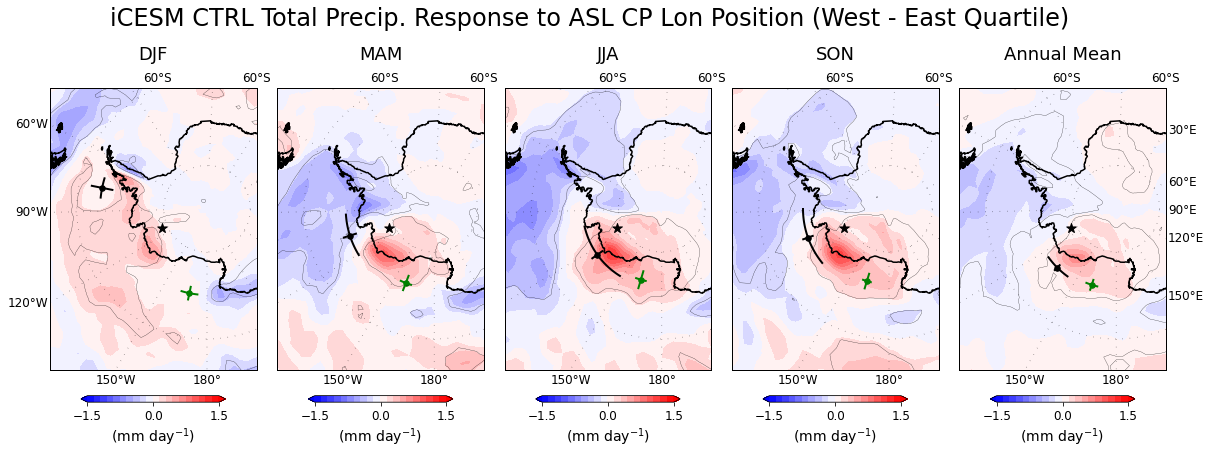

In [37]:
fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(20,6), sharex=True, sharey=True)
fig.subplots_adjust(hspace=0.0, wspace=0.1)
fig.suptitle('iCESM CTRL Total Precip. Response to ASL CP Lon Position (West - East Quartile)', fontsize=24, y=1.05)

# setup Lambert Conformal basemap.
diff_djf = djf_tp_w_westmost_lons_detrend_ctrl.mean(axis=0)-djf_tp_w_eastmost_lons_detrend_ctrl.mean(axis=0)
diff_mam = mam_tp_w_westmost_lons_detrend_ctrl.mean(axis=0)-mam_tp_w_eastmost_lons_detrend_ctrl.mean(axis=0)
diff_jja = jja_tp_w_westmost_lons_detrend_ctrl.mean(axis=0)-jja_tp_w_eastmost_lons_detrend_ctrl.mean(axis=0)
diff_son = son_tp_w_westmost_lons_detrend_ctrl.mean(axis=0)-son_tp_w_eastmost_lons_detrend_ctrl.mean(axis=0)
diff_ann = ann_mean_tp_w_westmost_lons_detrend_ctrl.mean(axis=0)-ann_mean_tp_w_eastmost_lons_detrend_ctrl.mean(axis=0)
diff_djf_sh, lons = add_cyclic_point(diff_djf.values, CTRL_DATA.coords['lon'].values, axis=-1)
diff_mam_sh, lons = add_cyclic_point(diff_mam.values, CTRL_DATA.coords['lon'].values, axis=-1)
diff_jja_sh, lons = add_cyclic_point(diff_jja.values, CTRL_DATA.coords['lon'].values, axis=-1)
diff_son_sh, lons = add_cyclic_point(diff_son.values, CTRL_DATA.coords['lon'].values, axis=-1)
diff_ann_sh, lons = add_cyclic_point(diff_ann.values, CTRL_DATA.coords['lon'].values, axis=-1)
diff_djf_con, lons = add_cyclic_point(djf_tp_change_due_to_lons_ttest_stats_ctrl, CTRL_DATA.coords['lon'].values, axis=-1)
diff_mam_con, lons = add_cyclic_point(mam_tp_change_due_to_lons_ttest_stats_ctrl, CTRL_DATA.coords['lon'].values, axis=-1)
diff_jja_con, lons = add_cyclic_point(jja_tp_change_due_to_lons_ttest_stats_ctrl, CTRL_DATA.coords['lon'].values, axis=-1)
diff_son_con, lons = add_cyclic_point(son_tp_change_due_to_lons_ttest_stats_ctrl, CTRL_DATA.coords['lon'].values, axis=-1)
diff_ann_con, lons = add_cyclic_point(ann_mean_tp_change_due_to_lons_ttest_stats_ctrl, CTRL_DATA.coords['lon'].values, axis=-1)

lon, lat = np.meshgrid(lons,CTRL_DATA.coords['lat'].sel(lat=slice(shem_ylo, shem_yhi)).values)
levels = np.arange(-1.5,1.65,.15)
levels_contour = [-2.028,2.028] #good for seasons and annual mean

parallels = np.arange(-80,-1,20)
meridians = np.arange(0,360,30.)
plt.rcParams['contour.negative_linestyle'] = 'solid'
plt.rcParams['text.latex.preamble']=[r"\usepackage{wasysym}"]

#DJF
plt.subplot(1, 5, 1)
m = Basemap(llcrnrlon=-135,llcrnrlat=-40,urcrnrlon=20,urcrnrlat=-60,projection='lcc',
            resolution='l',lat_1=-89.,lat_2=-65,lat_0=-70,lon_0=180.)
x, y = m(lon, lat)
# draw coastlines.
m.drawcoastlines(linewidth=1.5)
m.drawmapboundary(fill_color='white')
# labels = [left,right,top,bottom]
m.drawparallels(parallels,labels=[False,False,True,False],dashes=[.3, 7],fontsize=12)
m.drawmeridians(meridians,labels=[True,False,False,True],dashes=[.3, 7],fontsize=12)
#CS = m.contourf(x,y,(djf_tp_w_westmost_lons_detrend_ctrl.mean(axis=0)-djf_tp_w_eastmost_lons_detrend_ctrl.mean(axis=0)).where((djf_tp_change_due_to_lons_ttest_stats_ctrl >= levels_contour[1]) | (djf_tp_change_due_to_lons_ttest_stats_ctrl < levels_contour[0]) ),levels,cmap=plt.cm.get_cmap('bwr'),extend='both')
CS = m.contourf(x,y,(diff_djf_sh),levels,cmap=plt.cm.get_cmap('bwr'),extend='both')
#plt.ylabel('V10', fontsize=20)
cbar = plt.colorbar(orientation='horizontal', shrink=0.70, aspect=20, fraction=0.033, pad=0.08)
cbar.set_label(r'(mm day$^{-1}$)',size=14)
cbar.set_ticks([-1.5, 0, 1.5])
cbar.ax.tick_params(labelsize=12)
plt.clim([-1.5,1.5])
CS2 = m.contour(x,y,diff_djf_con,levels_contour,linewidths=0.25,colors='k')

#add Rel. CP mean location for westmost and eastmost indice
#westmost
xpt,ypt = m(djf_Rel_CP_indices_w_westmost_ASL_Lons_detrend_ctrl.lons.mean(),
            djf_Rel_CP_indices_w_westmost_ASL_Lons_detrend_ctrl.lats.mean()
           )
plt.scatter(xpt, ypt, c='green', marker='o', s=30) #for value dependent: vmin=-10, vmax=0, cmap='green'
#eastmost
xpt,ypt = m(djf_Rel_CP_indices_w_eastmost_ASL_Lons_detrend_ctrl.lons.mean(),
            djf_Rel_CP_indices_w_eastmost_ASL_Lons_detrend_ctrl.lats.mean()
           )
plt.scatter(xpt, ypt, c='k', marker='o', s=30) #for value dependent: vmin=-10, vmax=0, cmap='green'

#Add +- 1std of long and lat
#westmost
lat_line = np.linspace(djf_Rel_CP_indices_w_westmost_ASL_Lons_detrend_ctrl.lats.mean()
                       ,djf_Rel_CP_indices_w_westmost_ASL_Lons_detrend_ctrl.lats.mean()
                       ,100) 
lon_line = np.linspace(djf_Rel_CP_indices_w_westmost_ASL_Lons_detrend_ctrl.lons.mean()+djf_Rel_CP_indices_w_westmost_ASL_Lons_detrend_ctrl.lons.std()
                       ,djf_Rel_CP_indices_w_westmost_ASL_Lons_detrend_ctrl.lons.mean()-djf_Rel_CP_indices_w_westmost_ASL_Lons_detrend_ctrl.lons.std()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, color='green', linewidth=2) 

lat_line = np.linspace(djf_Rel_CP_indices_w_westmost_ASL_Lons_detrend_ctrl.lats.mean()+djf_Rel_CP_indices_w_westmost_ASL_Lons_detrend_ctrl.lats.std()
                       ,djf_Rel_CP_indices_w_westmost_ASL_Lons_detrend_ctrl.lats.mean()-djf_Rel_CP_indices_w_westmost_ASL_Lons_detrend_ctrl.lats.std()
                       ,100) 
lon_line = np.linspace(djf_Rel_CP_indices_w_westmost_ASL_Lons_detrend_ctrl.lons.mean()
                       ,djf_Rel_CP_indices_w_westmost_ASL_Lons_detrend_ctrl.lons.mean()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='green', linewidth=2)
#eastmost
lat_line = np.linspace(djf_Rel_CP_indices_w_eastmost_ASL_Lons_detrend_ctrl.lats.mean()
                       ,djf_Rel_CP_indices_w_eastmost_ASL_Lons_detrend_ctrl.lats.mean()
                       ,100) 
lon_line = np.linspace(djf_Rel_CP_indices_w_eastmost_ASL_Lons_detrend_ctrl.lons.mean()+djf_Rel_CP_indices_w_eastmost_ASL_Lons_detrend_ctrl.lons.std()
                       ,djf_Rel_CP_indices_w_eastmost_ASL_Lons_detrend_ctrl.lons.mean()-djf_Rel_CP_indices_w_eastmost_ASL_Lons_detrend_ctrl.lons.std()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='k', linewidth=2) 

lat_line = np.linspace(djf_Rel_CP_indices_w_eastmost_ASL_Lons_detrend_ctrl.lats.mean()+djf_Rel_CP_indices_w_eastmost_ASL_Lons_detrend_ctrl.lats.std()
                       ,djf_Rel_CP_indices_w_eastmost_ASL_Lons_detrend_ctrl.lats.mean()-djf_Rel_CP_indices_w_eastmost_ASL_Lons_detrend_ctrl.lats.std()
                       ,100) 
lon_line = np.linspace(djf_Rel_CP_indices_w_eastmost_ASL_Lons_detrend_ctrl.lons.mean()
                       ,djf_Rel_CP_indices_w_eastmost_ASL_Lons_detrend_ctrl.lons.mean()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='k', linewidth=2)

#add point for central Psuedo cores
xpt,ypt = m(247.5, -78.63)
plt.scatter(xpt, ypt, c='k', marker='*', s=100)

plt.title('DJF',y=1.08,fontsize=18)
print(djf_Rel_CP_indices_w_westmost_ASL_Lons_detrend_ctrl.vals.mean(),djf_Rel_CP_indices_w_eastmost_ASL_Lons_detrend_ctrl.vals.mean())


#MAM
plt.subplot(1, 5, 2)
m = Basemap(llcrnrlon=-135,llcrnrlat=-40,urcrnrlon=20,urcrnrlat=-60,projection='lcc',
            resolution='l',lat_1=-89.,lat_2=-65,lat_0=-70,lon_0=180.)
x, y = m(lon, lat)
# draw coastlines.
m.drawcoastlines(linewidth=1.5)
m.drawmapboundary(fill_color='white')
# labels = [left,right,top,bottom]
m.drawparallels(parallels,labels=[False,False,True,False],dashes=[.3, 7],fontsize=12)
m.drawmeridians(meridians,labels=[False,False,False,True],dashes=[.3, 7],fontsize=12)
#CS = m.contourf(x,y,(mam_tp_w_westmost_lons_detrend_ctrl.mean(axis=0)-mam_tp_w_eastmost_lons_detrend_ctrl.mean(axis=0)).where((mam_tp_change_due_to_lons_ttest_stats_ctrl >= levels_contour[1]) | (mam_tp_change_due_to_lons_ttest_stats_ctrl < levels_contour[0]) ),levels,cmap=plt.cm.get_cmap('bwr'),extend='both')
CS = m.contourf(x,y,(diff_mam_sh),levels,cmap=plt.cm.get_cmap('bwr'),extend='both')
#plt.ylabel('V10', fontsize=20)
cbar = plt.colorbar(orientation='horizontal', shrink=0.70, aspect=20, fraction=0.033, pad=0.08)
cbar.set_label(r'(mm day$^{-1}$)',size=14)
cbar.set_ticks([-1.5, 0, 1.5])
cbar.ax.tick_params(labelsize=12)
plt.clim([-1.5,1.5])
CS2 = m.contour(x,y,diff_mam_con,levels_contour,linewidths=0.25,colors='k')

#add Rel. CP mean location for westmost and eastmost indice
#westmost
xpt,ypt = m(mam_Rel_CP_indices_w_westmost_ASL_Lons_detrend_ctrl.lons.mean(),
            mam_Rel_CP_indices_w_westmost_ASL_Lons_detrend_ctrl.lats.mean()
           )
plt.scatter(xpt, ypt, c='green', marker='o', s=30) #for value dependent: vmin=-10, vmax=0, cmap='green'
#eastmost
xpt,ypt = m(mam_Rel_CP_indices_w_eastmost_ASL_Lons_detrend_ctrl.lons.mean(),
            mam_Rel_CP_indices_w_eastmost_ASL_Lons_detrend_ctrl.lats.mean()
           )
plt.scatter(xpt, ypt, c='k', marker='o', s=30) #for value dependent: vmin=-10, vmax=0, cmap='green'

#Add +- 1std of long and lat
#westmost
lat_line = np.linspace(mam_Rel_CP_indices_w_westmost_ASL_Lons_detrend_ctrl.lats.mean()
                       ,mam_Rel_CP_indices_w_westmost_ASL_Lons_detrend_ctrl.lats.mean()
                       ,100) 
lon_line = np.linspace(mam_Rel_CP_indices_w_westmost_ASL_Lons_detrend_ctrl.lons.mean()+mam_Rel_CP_indices_w_westmost_ASL_Lons_detrend_ctrl.lons.std()
                       ,mam_Rel_CP_indices_w_westmost_ASL_Lons_detrend_ctrl.lons.mean()-mam_Rel_CP_indices_w_westmost_ASL_Lons_detrend_ctrl.lons.std()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, color='green', linewidth=2) 

lat_line = np.linspace(mam_Rel_CP_indices_w_westmost_ASL_Lons_detrend_ctrl.lats.mean()+mam_Rel_CP_indices_w_westmost_ASL_Lons_detrend_ctrl.lats.std()
                       ,mam_Rel_CP_indices_w_westmost_ASL_Lons_detrend_ctrl.lats.mean()-mam_Rel_CP_indices_w_westmost_ASL_Lons_detrend_ctrl.lats.std()
                       ,100) 
lon_line = np.linspace(mam_Rel_CP_indices_w_westmost_ASL_Lons_detrend_ctrl.lons.mean()
                       ,mam_Rel_CP_indices_w_westmost_ASL_Lons_detrend_ctrl.lons.mean()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='green', linewidth=2)
#eastmost
lat_line = np.linspace(mam_Rel_CP_indices_w_eastmost_ASL_Lons_detrend_ctrl.lats.mean()
                       ,mam_Rel_CP_indices_w_eastmost_ASL_Lons_detrend_ctrl.lats.mean()
                       ,100) 
lon_line = np.linspace(mam_Rel_CP_indices_w_eastmost_ASL_Lons_detrend_ctrl.lons.mean()+mam_Rel_CP_indices_w_eastmost_ASL_Lons_detrend_ctrl.lons.std()
                       ,mam_Rel_CP_indices_w_eastmost_ASL_Lons_detrend_ctrl.lons.mean()-mam_Rel_CP_indices_w_eastmost_ASL_Lons_detrend_ctrl.lons.std()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='k', linewidth=2) 

lat_line = np.linspace(mam_Rel_CP_indices_w_eastmost_ASL_Lons_detrend_ctrl.lats.mean()+mam_Rel_CP_indices_w_eastmost_ASL_Lons_detrend_ctrl.lats.std()
                       ,mam_Rel_CP_indices_w_eastmost_ASL_Lons_detrend_ctrl.lats.mean()-mam_Rel_CP_indices_w_eastmost_ASL_Lons_detrend_ctrl.lats.std()
                       ,100) 
lon_line = np.linspace(mam_Rel_CP_indices_w_eastmost_ASL_Lons_detrend_ctrl.lons.mean()
                       ,mam_Rel_CP_indices_w_eastmost_ASL_Lons_detrend_ctrl.lons.mean()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='k', linewidth=2)

#add point for central Psuedo cores
xpt,ypt = m(247.5, -78.63)
plt.scatter(xpt, ypt, c='k', marker='*', s=100)

plt.title('MAM',y=1.08,fontsize=18)
print(mam_Rel_CP_indices_w_westmost_ASL_Lons_detrend_ctrl.vals.mean(),mam_Rel_CP_indices_w_eastmost_ASL_Lons_detrend_ctrl.vals.mean())


#JJA
plt.subplot(1, 5, 3)
m = Basemap(llcrnrlon=-135,llcrnrlat=-40,urcrnrlon=20,urcrnrlat=-60,projection='lcc',
            resolution='l',lat_1=-89.,lat_2=-65,lat_0=-70,lon_0=180.)
x, y = m(lon, lat)
# draw coastlines.
m.drawcoastlines(linewidth=1.5)
m.drawmapboundary(fill_color='white')
# labels = [left,right,top,bottom]
m.drawparallels(parallels,labels=[False,False,True,False],dashes=[.3, 7],fontsize=12)
m.drawmeridians(meridians,labels=[False,False,False,True],dashes=[.3, 7],fontsize=12)
#CS = m.contourf(x,y,(jja_tp_w_westmost_lons_detrend_ctrl.mean(axis=0)-jja_tp_w_eastmost_lons_detrend_ctrl.mean(axis=0)).where((jja_tp_change_due_to_lons_ttest_stats_ctrl >= levels_contour[1]) | (jja_tp_change_due_to_lons_ttest_stats_ctrl < levels_contour[0]) ),levels,cmap=plt.cm.get_cmap('bwr'),extend='both')
CS = m.contourf(x,y,(diff_jja_sh),levels,cmap=plt.cm.get_cmap('bwr'),extend='both')
#plt.ylabel('V10', fontsize=20)
cbar = plt.colorbar(orientation='horizontal', shrink=0.70, aspect=20, fraction=0.033, pad=0.08)
cbar.set_label(r'(mm day$^{-1}$)',size=14)
cbar.set_ticks([-1.5, 0, 1.5])
cbar.ax.tick_params(labelsize=12)
plt.clim([-1.5,1.5])
CS2 = m.contour(x,y,diff_jja_con,levels_contour,linewidths=0.25,colors='k')

#add Rel. CP mean location for westmost and eastmost indice
#westmost
xpt,ypt = m(jja_Rel_CP_indices_w_westmost_ASL_Lons_detrend_ctrl.lons.mean(),
            jja_Rel_CP_indices_w_westmost_ASL_Lons_detrend_ctrl.lats.mean()
           )
plt.scatter(xpt, ypt, c='green', marker='o', s=30) #for value dependent: vmin=-10, vmax=0, cmap='green'
#eastmost
xpt,ypt = m(jja_Rel_CP_indices_w_eastmost_ASL_Lons_detrend_ctrl.lons.mean(),
            jja_Rel_CP_indices_w_eastmost_ASL_Lons_detrend_ctrl.lats.mean()
           )
plt.scatter(xpt, ypt, c='k', marker='o', s=30) #for value dependent: vmin=-10, vmax=0, cmap='green'

#Add +- 1std of long and lat
#westmost
lat_line = np.linspace(jja_Rel_CP_indices_w_westmost_ASL_Lons_detrend_ctrl.lats.mean()
                       ,jja_Rel_CP_indices_w_westmost_ASL_Lons_detrend_ctrl.lats.mean()
                       ,100) 
lon_line = np.linspace(jja_Rel_CP_indices_w_westmost_ASL_Lons_detrend_ctrl.lons.mean()+jja_Rel_CP_indices_w_westmost_ASL_Lons_detrend_ctrl.lons.std()
                       ,jja_Rel_CP_indices_w_westmost_ASL_Lons_detrend_ctrl.lons.mean()-jja_Rel_CP_indices_w_westmost_ASL_Lons_detrend_ctrl.lons.std()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, color='green', linewidth=2) 

lat_line = np.linspace(jja_Rel_CP_indices_w_westmost_ASL_Lons_detrend_ctrl.lats.mean()+jja_Rel_CP_indices_w_westmost_ASL_Lons_detrend_ctrl.lats.std()
                       ,jja_Rel_CP_indices_w_westmost_ASL_Lons_detrend_ctrl.lats.mean()-jja_Rel_CP_indices_w_westmost_ASL_Lons_detrend_ctrl.lats.std()
                       ,100) 
lon_line = np.linspace(jja_Rel_CP_indices_w_westmost_ASL_Lons_detrend_ctrl.lons.mean()
                       ,jja_Rel_CP_indices_w_westmost_ASL_Lons_detrend_ctrl.lons.mean()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='green', linewidth=2)
#eastmost
lat_line = np.linspace(jja_Rel_CP_indices_w_eastmost_ASL_Lons_detrend_ctrl.lats.mean()
                       ,jja_Rel_CP_indices_w_eastmost_ASL_Lons_detrend_ctrl.lats.mean()
                       ,100) 
lon_line = np.linspace(jja_Rel_CP_indices_w_eastmost_ASL_Lons_detrend_ctrl.lons.mean()+jja_Rel_CP_indices_w_eastmost_ASL_Lons_detrend_ctrl.lons.std()
                       ,jja_Rel_CP_indices_w_eastmost_ASL_Lons_detrend_ctrl.lons.mean()-jja_Rel_CP_indices_w_eastmost_ASL_Lons_detrend_ctrl.lons.std()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='k', linewidth=2) 

lat_line = np.linspace(jja_Rel_CP_indices_w_eastmost_ASL_Lons_detrend_ctrl.lats.mean()+jja_Rel_CP_indices_w_eastmost_ASL_Lons_detrend_ctrl.lats.std()
                       ,jja_Rel_CP_indices_w_eastmost_ASL_Lons_detrend_ctrl.lats.mean()-jja_Rel_CP_indices_w_eastmost_ASL_Lons_detrend_ctrl.lats.std()
                       ,100) 
lon_line = np.linspace(jja_Rel_CP_indices_w_eastmost_ASL_Lons_detrend_ctrl.lons.mean()
                       ,jja_Rel_CP_indices_w_eastmost_ASL_Lons_detrend_ctrl.lons.mean()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='k', linewidth=2)

#add point for central Psuedo cores
xpt,ypt = m(247.5, -78.63)
plt.scatter(xpt, ypt, c='k', marker='*', s=100)

plt.title('JJA',y=1.08,fontsize=18)
print(jja_Rel_CP_indices_w_westmost_ASL_Lons_detrend_ctrl.vals.mean(),jja_Rel_CP_indices_w_eastmost_ASL_Lons_detrend_ctrl.vals.mean())


#SON
plt.subplot(1, 5, 4)
m = Basemap(llcrnrlon=-135,llcrnrlat=-40,urcrnrlon=20,urcrnrlat=-60,projection='lcc',
            resolution='l',lat_1=-89.,lat_2=-65,lat_0=-70,lon_0=180.)
x, y = m(lon, lat)
# draw coastlines.
m.drawcoastlines(linewidth=1.5)
m.drawmapboundary(fill_color='white')
# labels = [left,right,top,bottom]
m.drawparallels(parallels,labels=[False,False,True,False],dashes=[.3, 7],fontsize=12)
m.drawmeridians(meridians,labels=[False,False,False,True],dashes=[.3, 7],fontsize=12)
#CS = m.contourf(x,y,(son_tp_w_westmost_lons_detrend_ctrl.mean(axis=0)-son_tp_w_eastmost_lons_detrend_ctrl.mean(axis=0)).where((son_tp_change_due_to_lons_ttest_stats_ctrl >= levels_contour[1]) | (son_tp_change_due_to_lons_ttest_stats_ctrl < levels_contour[0]) ),levels,cmap=plt.cm.get_cmap('bwr'),extend='both')
CS = m.contourf(x,y,(diff_son_sh),levels,cmap=plt.cm.get_cmap('bwr'),extend='both')
#plt.ylabel('V10', fontsize=20)
cbar = plt.colorbar(orientation='horizontal', shrink=0.70, aspect=20, fraction=0.033, pad=0.08)
cbar.set_label(r'(mm day$^{-1}$)',size=14)
cbar.set_ticks([-1.5, 0, 1.5])
cbar.ax.tick_params(labelsize=12)
plt.clim([-1.5,1.5])
CS2 = m.contour(x,y,diff_son_con,levels_contour,linewidths=0.25,colors='k')

#add Rel. CP mean location for westmost and eastmost indice
#westmost
xpt,ypt = m(son_Rel_CP_indices_w_westmost_ASL_Lons_detrend_ctrl.lons.mean(),
            son_Rel_CP_indices_w_westmost_ASL_Lons_detrend_ctrl.lats.mean()
           )
plt.scatter(xpt, ypt, c='green', marker='o', s=30) #for value dependent: vmin=-10, vmax=0, cmap='green'
#eastmost
xpt,ypt = m(son_Rel_CP_indices_w_eastmost_ASL_Lons_detrend_ctrl.lons.mean(),
            son_Rel_CP_indices_w_eastmost_ASL_Lons_detrend_ctrl.lats.mean()
           )
plt.scatter(xpt, ypt, c='k', marker='o', s=30) #for value dependent: vmin=-10, vmax=0, cmap='green'

#Add +- 1std of long and lat
#westmost
lat_line = np.linspace(son_Rel_CP_indices_w_westmost_ASL_Lons_detrend_ctrl.lats.mean()
                       ,son_Rel_CP_indices_w_westmost_ASL_Lons_detrend_ctrl.lats.mean()
                       ,100) 
lon_line = np.linspace(son_Rel_CP_indices_w_westmost_ASL_Lons_detrend_ctrl.lons.mean()+son_Rel_CP_indices_w_westmost_ASL_Lons_detrend_ctrl.lons.std()
                       ,son_Rel_CP_indices_w_westmost_ASL_Lons_detrend_ctrl.lons.mean()-son_Rel_CP_indices_w_westmost_ASL_Lons_detrend_ctrl.lons.std()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, color='green', linewidth=2) 

lat_line = np.linspace(son_Rel_CP_indices_w_westmost_ASL_Lons_detrend_ctrl.lats.mean()+son_Rel_CP_indices_w_westmost_ASL_Lons_detrend_ctrl.lats.std()
                       ,son_Rel_CP_indices_w_westmost_ASL_Lons_detrend_ctrl.lats.mean()-son_Rel_CP_indices_w_westmost_ASL_Lons_detrend_ctrl.lats.std()
                       ,100) 
lon_line = np.linspace(son_Rel_CP_indices_w_westmost_ASL_Lons_detrend_ctrl.lons.mean()
                       ,son_Rel_CP_indices_w_westmost_ASL_Lons_detrend_ctrl.lons.mean()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='green', linewidth=2)
#eastmost
lat_line = np.linspace(son_Rel_CP_indices_w_eastmost_ASL_Lons_detrend_ctrl.lats.mean()
                       ,son_Rel_CP_indices_w_eastmost_ASL_Lons_detrend_ctrl.lats.mean()
                       ,100) 
lon_line = np.linspace(son_Rel_CP_indices_w_eastmost_ASL_Lons_detrend_ctrl.lons.mean()+son_Rel_CP_indices_w_eastmost_ASL_Lons_detrend_ctrl.lons.std()
                       ,son_Rel_CP_indices_w_eastmost_ASL_Lons_detrend_ctrl.lons.mean()-son_Rel_CP_indices_w_eastmost_ASL_Lons_detrend_ctrl.lons.std()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='k', linewidth=2) 

lat_line = np.linspace(son_Rel_CP_indices_w_eastmost_ASL_Lons_detrend_ctrl.lats.mean()+son_Rel_CP_indices_w_eastmost_ASL_Lons_detrend_ctrl.lats.std()
                       ,son_Rel_CP_indices_w_eastmost_ASL_Lons_detrend_ctrl.lats.mean()-son_Rel_CP_indices_w_eastmost_ASL_Lons_detrend_ctrl.lats.std()
                       ,100) 
lon_line = np.linspace(son_Rel_CP_indices_w_eastmost_ASL_Lons_detrend_ctrl.lons.mean()
                       ,son_Rel_CP_indices_w_eastmost_ASL_Lons_detrend_ctrl.lons.mean()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='k', linewidth=2)

#add point for central Psuedo cores
xpt,ypt = m(247.5, -78.63)
plt.scatter(xpt, ypt, c='k', marker='*', s=100)

plt.title('SON',y=1.08,fontsize=18)
print(son_Rel_CP_indices_w_westmost_ASL_Lons_detrend_ctrl.vals.mean(),son_Rel_CP_indices_w_eastmost_ASL_Lons_detrend_ctrl.vals.mean())


#Annual Mean
plt.subplot(1, 5, 5)
m = Basemap(llcrnrlon=-135,llcrnrlat=-40,urcrnrlon=20,urcrnrlat=-60,projection='lcc',
            resolution='l',lat_1=-89.,lat_2=-65,lat_0=-70,lon_0=180.)
x, y = m(lon, lat)
# draw coastlines.
m.drawcoastlines(linewidth=1.5)
m.drawmapboundary(fill_color='white')
# labels = [left,right,top,bottom]
m.drawparallels(parallels,labels=[False,False,True,False],dashes=[.3, 7],fontsize=12)
m.drawmeridians(meridians,labels=[False,True,False,True],dashes=[.3, 7],fontsize=12)
#CS = m.contourf(x,y,(ann_mean_tp_w_westmost_lons_detrend_ctrl.mean(axis=0)-ann_mean_tp_w_eastmost_lons_detrend_ctrl.mean(axis=0)).where((ann_mean_tp_change_due_to_lons_ttest_stats_ctrl >= levels_contour[1]) | (ann_mean_tp_change_due_to_lons_ttest_stats_ctrl < levels_contour[0]) ),levels,cmap=plt.cm.get_cmap('bwr'),extend='both')
CS = m.contourf(x,y,(diff_ann_sh),levels,cmap=plt.cm.get_cmap('bwr'),extend='both')
#plt.ylabel('V10', fontsize=20)
cbar = plt.colorbar(orientation='horizontal', shrink=0.70, aspect=20, fraction=0.033, pad=0.08)
cbar.set_label(r'(mm day$^{-1}$)',size=14)
cbar.set_ticks([-1.5, 0, 1.5])
cbar.ax.tick_params(labelsize=12)
plt.clim([-1.5,1.5])
CS2 = m.contour(x,y,diff_ann_con,levels_contour,linewidths=0.25,colors='k')

#add Rel. CP mean location for westmost and eastmost indice
#westmost
xpt,ypt = m(ann_mean_Rel_CP_indices_w_westmost_ASL_Lons_detrend_ctrl.lons.mean(),
            ann_mean_Rel_CP_indices_w_westmost_ASL_Lons_detrend_ctrl.lats.mean()
           )
plt.scatter(xpt, ypt, c='green', marker='o', s=30) #for value dependent: vmin=-10, vmax=0, cmap='green'
#eastmost
xpt,ypt = m(ann_mean_Rel_CP_indices_w_eastmost_ASL_Lons_detrend_ctrl.lons.mean(),
            ann_mean_Rel_CP_indices_w_eastmost_ASL_Lons_detrend_ctrl.lats.mean()
           )
plt.scatter(xpt, ypt, c='k', marker='o', s=30) #for value dependent: vmin=-10, vmax=0, cmap='green'

#Add +- 1std of long and lat
#westmost
lat_line = np.linspace(ann_mean_Rel_CP_indices_w_westmost_ASL_Lons_detrend_ctrl.lats.mean()
                       ,ann_mean_Rel_CP_indices_w_westmost_ASL_Lons_detrend_ctrl.lats.mean()
                       ,100) 
lon_line = np.linspace(ann_mean_Rel_CP_indices_w_westmost_ASL_Lons_detrend_ctrl.lons.mean()+ann_mean_Rel_CP_indices_w_westmost_ASL_Lons_detrend_ctrl.lons.std()
                       ,ann_mean_Rel_CP_indices_w_westmost_ASL_Lons_detrend_ctrl.lons.mean()-ann_mean_Rel_CP_indices_w_westmost_ASL_Lons_detrend_ctrl.lons.std()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, color='green', linewidth=2) 

lat_line = np.linspace(ann_mean_Rel_CP_indices_w_westmost_ASL_Lons_detrend_ctrl.lats.mean()+ann_mean_Rel_CP_indices_w_westmost_ASL_Lons_detrend_ctrl.lats.std()
                       ,ann_mean_Rel_CP_indices_w_westmost_ASL_Lons_detrend_ctrl.lats.mean()-ann_mean_Rel_CP_indices_w_westmost_ASL_Lons_detrend_ctrl.lats.std()
                       ,100) 
lon_line = np.linspace(ann_mean_Rel_CP_indices_w_westmost_ASL_Lons_detrend_ctrl.lons.mean()
                       ,ann_mean_Rel_CP_indices_w_westmost_ASL_Lons_detrend_ctrl.lons.mean()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='green', linewidth=2)
#eastmost
lat_line = np.linspace(ann_mean_Rel_CP_indices_w_eastmost_ASL_Lons_detrend_ctrl.lats.mean()
                       ,ann_mean_Rel_CP_indices_w_eastmost_ASL_Lons_detrend_ctrl.lats.mean()
                       ,100) 
lon_line = np.linspace(ann_mean_Rel_CP_indices_w_eastmost_ASL_Lons_detrend_ctrl.lons.mean()+ann_mean_Rel_CP_indices_w_eastmost_ASL_Lons_detrend_ctrl.lons.std()
                       ,ann_mean_Rel_CP_indices_w_eastmost_ASL_Lons_detrend_ctrl.lons.mean()-ann_mean_Rel_CP_indices_w_eastmost_ASL_Lons_detrend_ctrl.lons.std()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='k', linewidth=2) 

lat_line = np.linspace(ann_mean_Rel_CP_indices_w_eastmost_ASL_Lons_detrend_ctrl.lats.mean()+ann_mean_Rel_CP_indices_w_eastmost_ASL_Lons_detrend_ctrl.lats.std()
                       ,ann_mean_Rel_CP_indices_w_eastmost_ASL_Lons_detrend_ctrl.lats.mean()-ann_mean_Rel_CP_indices_w_eastmost_ASL_Lons_detrend_ctrl.lats.std()
                       ,100) 
lon_line = np.linspace(ann_mean_Rel_CP_indices_w_eastmost_ASL_Lons_detrend_ctrl.lons.mean()
                       ,ann_mean_Rel_CP_indices_w_eastmost_ASL_Lons_detrend_ctrl.lons.mean()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='k', linewidth=2)

#add point for central Psuedo cores
xpt,ypt = m(247.5, -78.63)
plt.scatter(xpt, ypt, c='k', marker='*', s=100)

plt.title('Annual Mean',y=1.08,fontsize=18)
#plt.annotate('Jul-24-2012', xy=(0, 1), xycoords='axes fraction')
print(ann_mean_Rel_CP_indices_w_westmost_ASL_Lons_detrend_ctrl.vals.mean(),ann_mean_Rel_CP_indices_w_eastmost_ASL_Lons_detrend_ctrl.vals.mean())


# plt.savefig(FIG_PATH+'/OLD_Figure_iCESM_CTRL_TAGGED_tp_Field_vs_ASL_CP_Lon_Position_Quartiles_20210324.pdf',bbox_inches='tight', pad_inches=0.05)

plt.show()

In [38]:
#Relative CP Minimum Pressure Upper Quart vs Lower Quart; this would allow a tie to Hoskings et al and confirm my previous work

#Deep most is the lower quartile (deep has lower Rel CP values)
#Shallow most is the upper quartile (shallow has higher Rel CP values)

In [39]:
#create list of indices representing the shallowmost/deepmost quartiles of 'vals'
#Note, head is deepmost (sorted from low to high)
rel_cp_djf_mean_deepmost_ctrl = Rel_CP_djf_mean_indices_raw_ctrl.sort_values(by=['vals']).head(n=(round(Rel_CP_djf_mean_indices_raw_ctrl.indice.size/4))).indice.tolist()
print(rel_cp_djf_mean_deepmost_ctrl)
rel_cp_djf_mean_shallowmost_ctrl = Rel_CP_djf_mean_indices_raw_ctrl.sort_values(by=['vals']).tail(n=(round(Rel_CP_djf_mean_indices_raw_ctrl.indice.size/4))).indice.tolist()
print(rel_cp_djf_mean_shallowmost_ctrl)

rel_cp_mam_mean_deepmost_ctrl = Rel_CP_mam_mean_indices_raw_ctrl.sort_values(by=['vals']).head(n=(round(Rel_CP_mam_mean_indices_raw_ctrl.indice.size/4))).indice.tolist()
print(rel_cp_mam_mean_deepmost_ctrl)
rel_cp_mam_mean_shallowmost_ctrl = Rel_CP_mam_mean_indices_raw_ctrl.sort_values(by=['vals']).tail(n=(round(Rel_CP_mam_mean_indices_raw_ctrl.indice.size/4))).indice.tolist()
print(rel_cp_mam_mean_shallowmost_ctrl)

rel_cp_jja_mean_deepmost_ctrl = Rel_CP_jja_mean_indices_raw_ctrl.sort_values(by=['vals']).head(n=(round(Rel_CP_jja_mean_indices_raw_ctrl.indice.size/4))).indice.tolist()
print(rel_cp_jja_mean_deepmost_ctrl)
rel_cp_jja_mean_shallowmost_ctrl = Rel_CP_jja_mean_indices_raw_ctrl.sort_values(by=['vals']).tail(n=(round(Rel_CP_jja_mean_indices_raw_ctrl.indice.size/4))).indice.tolist()
print(rel_cp_jja_mean_shallowmost_ctrl)

rel_cp_son_mean_deepmost_ctrl = Rel_CP_son_mean_indices_raw_ctrl.sort_values(by=['vals']).head(n=(round(Rel_CP_son_mean_indices_raw_ctrl.indice.size/4))).indice.tolist()
print(rel_cp_son_mean_deepmost_ctrl)
rel_cp_son_mean_shallowmost_ctrl = Rel_CP_son_mean_indices_raw_ctrl.sort_values(by=['vals']).tail(n=(round(Rel_CP_son_mean_indices_raw_ctrl.indice.size/4))).indice.tolist()
print(rel_cp_son_mean_shallowmost_ctrl)

rel_cp_ann_mean_deepmost_ctrl = Rel_CP_ann_mean_indices_raw_ctrl.sort_values(by=['vals']).head(n=(round(Rel_CP_ann_mean_indices_raw_ctrl.indice.size/4))).indice.tolist()
print(rel_cp_ann_mean_deepmost_ctrl)
rel_cp_ann_mean_shallowmost_ctrl = Rel_CP_ann_mean_indices_raw_ctrl.sort_values(by=['vals']).tail(n=(round(Rel_CP_ann_mean_indices_raw_ctrl.indice.size/4))).indice.tolist()
print(rel_cp_ann_mean_shallowmost_ctrl)

[23, 48, 30, 63, 5, 35, 60, 58, 6, 51, 39, 62, 20, 53, 65, 32, 50, 9]
[34, 45, 67, 26, 27, 18, 14, 12, 15, 68, 70, 37, 2, 64, 42, 49, 36, 71]
[64, 37, 38, 54, 70, 3, 46, 63, 47, 51, 10, 55, 49, 29, 16, 15, 36, 0, 73]
[41, 58, 59, 32, 27, 68, 21, 62, 42, 1, 19, 53, 45, 52, 14, 2, 56, 35, 31]
[17, 55, 49, 63, 19, 64, 56, 13, 37, 6, 24, 1, 11, 34, 59, 70, 3, 43, 58]
[23, 25, 22, 65, 27, 47, 39, 2, 40, 12, 7, 42, 30, 9, 52, 29, 28, 38, 41]
[67, 50, 15, 33, 43, 40, 5, 30, 21, 8, 71, 3, 9, 24, 70, 22, 14, 58, 2]
[61, 55, 66, 6, 1, 68, 13, 53, 17, 60, 56, 16, 62, 0, 26, 31, 34, 36, 46]
[64, 63, 37, 49, 8, 51, 3, 67, 70, 50, 18, 40, 24, 10, 22, 14, 54, 15, 19]
[45, 1, 34, 35, 41, 53, 5, 28, 42, 61, 62, 47, 2, 7, 39, 26, 74, 36, 69]


In [40]:
#Select the times of the field variable dependent upon quartile and the indice 

#DJF, (both datasets already at s=47, so no need to crop the time series)
djf_tp_w_shallowmost_rel_cp_detrend_ctrl = djf_tp_shem_seas_mean_detrend_ctrl.isel(time = rel_cp_djf_mean_shallowmost_ctrl)
djf_tp_w_deepmost_rel_cp_detrend_ctrl = djf_tp_shem_seas_mean_detrend_ctrl.isel(time = rel_cp_djf_mean_deepmost_ctrl)
# djf_tp_w_shallowmost_rel_cp_detrend_ctrl
# djf_tp_w_deepmost_rel_cp_detrend_ctrl

#mam
mam_tp_w_shallowmost_rel_cp_detrend_ctrl = mam_tp_shem_seas_mean_detrend_ctrl.isel(time = rel_cp_mam_mean_shallowmost_ctrl)
mam_tp_w_deepmost_rel_cp_detrend_ctrl = mam_tp_shem_seas_mean_detrend_ctrl.isel(time = rel_cp_mam_mean_deepmost_ctrl)
# mam_tp_w_shallowmost_rel_cp_detrend_ctrl
# mam_tp_w_deepmost_rel_cp_detrend_ctrl

#jja
jja_tp_w_shallowmost_rel_cp_detrend_ctrl = jja_tp_shem_seas_mean_detrend_ctrl.isel(time = rel_cp_jja_mean_shallowmost_ctrl)
jja_tp_w_deepmost_rel_cp_detrend_ctrl = jja_tp_shem_seas_mean_detrend_ctrl.isel(time = rel_cp_jja_mean_deepmost_ctrl)
# jja_tp_w_shallowmost_rel_cp_detrend_ctrl
# jja_tp_w_deepmost_rel_cp_detrend_ctrl

#son
son_tp_w_shallowmost_rel_cp_detrend_ctrl = son_tp_shem_seas_mean_detrend_ctrl.isel(time = rel_cp_son_mean_shallowmost_ctrl)
son_tp_w_deepmost_rel_cp_detrend_ctrl = son_tp_shem_seas_mean_detrend_ctrl.isel(time = rel_cp_son_mean_deepmost_ctrl)
son_tp_w_shallowmost_rel_cp_detrend_ctrl
# son_tp_w_deepmost_rel_cp_detrend_ctrl

#ann mean
ann_mean_tp_w_shallowmost_rel_cp_detrend_ctrl = tp_shem_ann_mean_detrend_ctrl.isel(time = rel_cp_ann_mean_shallowmost_ctrl)
ann_mean_tp_w_deepmost_rel_cp_detrend_ctrl = tp_shem_ann_mean_detrend_ctrl.isel(time = rel_cp_ann_mean_deepmost_ctrl)
# ann_mean_tp_w_shallowmost_rel_cp_detrend_ctrl
# ann_mean_tp_w_deepmost_rel_cp_detrend_ctrl


In [41]:
#Select ASL Rel CP value, long, and lat while ASL Rel CP is in shallowmost or deepmost quartile
#Using new ASL info from 19Nov2018

#djf
djf_Rel_CP_indices_w_shallowmost_rel_cp_detrend_ctrl = Rel_CP_djf_mean_indices_raw_ctrl.iloc[rel_cp_djf_mean_shallowmost_ctrl]
# djf_Rel_CP_indices_w_shallowmost_rel_cp_detrend_ctrl
djf_Rel_CP_indices_w_deepmost_rel_cp_detrend_ctrl = Rel_CP_djf_mean_indices_raw_ctrl.iloc[rel_cp_djf_mean_deepmost_ctrl]
# djf_Rel_CP_indices_w_deepmost_rel_cp_detrend_ctrl

#mam
mam_Rel_CP_indices_w_shallowmost_rel_cp_detrend_ctrl = Rel_CP_mam_mean_indices_raw_ctrl.iloc[rel_cp_mam_mean_shallowmost_ctrl]
# mam_Rel_CP_indices_w_shallowmost_rel_cp_detrend_ctrl
mam_Rel_CP_indices_w_deepmost_rel_cp_detrend_ctrl = Rel_CP_mam_mean_indices_raw_ctrl.iloc[rel_cp_mam_mean_deepmost_ctrl]
# mam_Rel_CP_indices_w_deepmost_rel_cp_detrend_ctrl

#jja
jja_Rel_CP_indices_w_shallowmost_rel_cp_detrend_ctrl = Rel_CP_jja_mean_indices_raw_ctrl.iloc[rel_cp_jja_mean_shallowmost_ctrl]
# jja_Rel_CP_indices_w_shallowmost_rel_cp_detrend_ctrl
jja_Rel_CP_indices_w_deepmost_rel_cp_detrend_ctrl = Rel_CP_jja_mean_indices_raw_ctrl.iloc[rel_cp_jja_mean_deepmost_ctrl]
# jja_Rel_CP_indices_w_deepmost_rel_cp_detrend_ctrl

#son
son_Rel_CP_indices_w_shallowmost_rel_cp_detrend_ctrl = Rel_CP_son_mean_indices_raw_ctrl.iloc[rel_cp_son_mean_shallowmost_ctrl]
# son_Rel_CP_indices_w_shallowmost_rel_cp_detrend_ctrl
son_Rel_CP_indices_w_deepmost_rel_cp_detrend_ctrl = Rel_CP_son_mean_indices_raw_ctrl.iloc[rel_cp_son_mean_deepmost_ctrl]
# son_Rel_CP_indices_w_deepmost_rel_cp_detrend_ctrl

#annual mean
ann_mean_Rel_CP_indices_w_shallowmost_rel_cp_detrend_ctrl = Rel_CP_ann_mean_indices_raw_ctrl.iloc[rel_cp_ann_mean_shallowmost_ctrl]
# ann_mean_Rel_CP_indices_w_shallowmost_rel_cp_detrend_ctrl
ann_mean_Rel_CP_indices_w_deepmost_rel_cp_detrend_ctrl = Rel_CP_ann_mean_indices_raw_ctrl.iloc[rel_cp_ann_mean_deepmost_ctrl]
# ann_mean_Rel_CP_indices_w_shallowmost_rel_cp_detrend_ctrl

In [42]:
#Calculate significance for the change in mean of the field variable for Positive-Negative
#critical value for t-test at 95%:
#Seasonal and ann mean, df=19+19-2 = 36 ; critical value = +- 2.028
#DJF, df =18+18-2 = 34 ; critical value = +- 2.032 (so close to df=36 that I am not going to change)

djf_tp_change_due_to_rel_cp_ttest_stats_ctrl, djf_tp_change_due_to_rel_cp_ttest_pvals_ctrl = ttest_ind(
    djf_tp_w_shallowmost_rel_cp_detrend_ctrl, djf_tp_w_deepmost_rel_cp_detrend_ctrl, axis=0)

mam_tp_change_due_to_rel_cp_ttest_stats_ctrl, mam_tp_change_due_to_rel_cp_ttest_pvals_ctrl = ttest_ind(
    mam_tp_w_shallowmost_rel_cp_detrend_ctrl, mam_tp_w_deepmost_rel_cp_detrend_ctrl, axis=0)

jja_tp_change_due_to_rel_cp_ttest_stats_ctrl, jja_tp_change_due_to_rel_cp_ttest_pvals_ctrl = ttest_ind(
    jja_tp_w_shallowmost_rel_cp_detrend_ctrl, jja_tp_w_deepmost_rel_cp_detrend_ctrl, axis=0)

son_tp_change_due_to_rel_cp_ttest_stats_ctrl, son_tp_change_due_to_rel_cp_ttest_pvals_ctrl = ttest_ind(
    son_tp_w_shallowmost_rel_cp_detrend_ctrl, son_tp_w_deepmost_rel_cp_detrend_ctrl, axis=0)

ann_mean_tp_change_due_to_rel_cp_ttest_stats_ctrl, ann_mean_tp_change_due_to_rel_cp_ttest_pvals_ctrl = ttest_ind(
    ann_mean_tp_w_shallowmost_rel_cp_detrend_ctrl, ann_mean_tp_w_deepmost_rel_cp_detrend_ctrl, axis=0)

/glade/work/pgoddard/NEW_ANACONDA_AND_PY_ENV_24Mar2021/geo_scipy/lib/python3.7/site-packages/cartopy/util.py:102: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  new_data = ma.concatenate((data, data[slicer]), axis=axis)
/glade/work/pgoddard/NEW_ANACONDA_AND_PY_ENV_24Mar2021/geo_scipy/lib/python3.7/site-packages/ipykernel_launcher.py:34: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.


-6.343475470462206 -3.2413268975551484


/glade/work/pgoddard/NEW_ANACONDA_AND_PY_ENV_24Mar2021/geo_scipy/lib/python3.7/site-packages/ipykernel_launcher.py:113: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.


-9.246026599896219 -5.095320613268254


/glade/work/pgoddard/NEW_ANACONDA_AND_PY_ENV_24Mar2021/geo_scipy/lib/python3.7/site-packages/ipykernel_launcher.py:192: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.


-11.254362311686254 -6.666112397107685


/glade/work/pgoddard/NEW_ANACONDA_AND_PY_ENV_24Mar2021/geo_scipy/lib/python3.7/site-packages/ipykernel_launcher.py:271: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.


-9.550678565856293 -6.193335730519918
-7.13736070831531 -4.775878872646911


/glade/work/pgoddard/NEW_ANACONDA_AND_PY_ENV_24Mar2021/geo_scipy/lib/python3.7/site-packages/ipykernel_launcher.py:350: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.


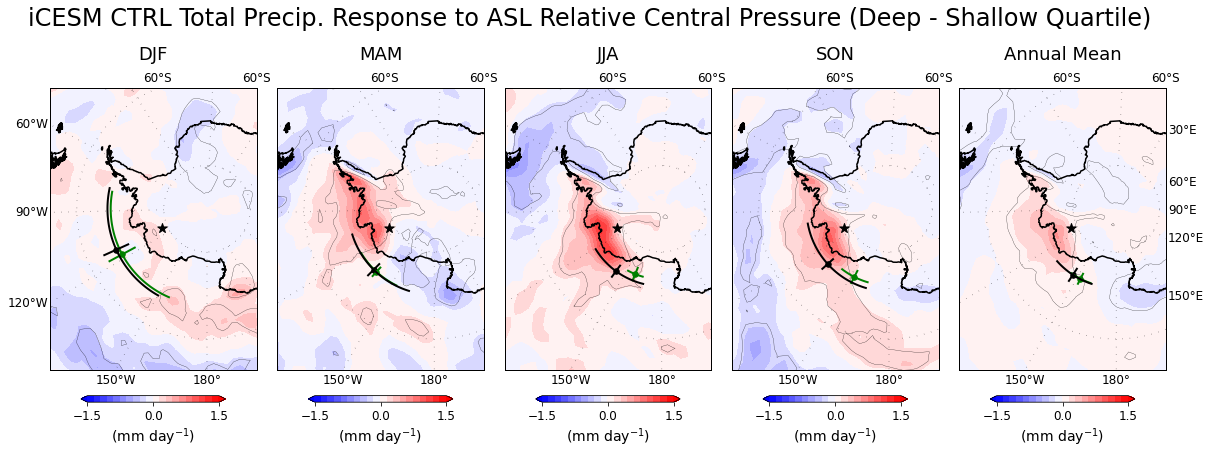

In [43]:
fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(20,6), sharex=True, sharey=True)
fig.subplots_adjust(hspace=0.0, wspace=0.1)
fig.suptitle('iCESM CTRL Total Precip. Response to ASL Relative Central Pressure (Deep - Shallow Quartile)', fontsize=24, y=1.05)

# setup Lambert Conformal basemap.
diff_djf = djf_tp_w_deepmost_rel_cp_detrend_ctrl.mean(axis=0)-djf_tp_w_shallowmost_rel_cp_detrend_ctrl.mean(axis=0)
diff_mam = mam_tp_w_deepmost_rel_cp_detrend_ctrl.mean(axis=0)-mam_tp_w_shallowmost_rel_cp_detrend_ctrl.mean(axis=0)
diff_jja = jja_tp_w_deepmost_rel_cp_detrend_ctrl.mean(axis=0)-jja_tp_w_shallowmost_rel_cp_detrend_ctrl.mean(axis=0)
diff_son = son_tp_w_deepmost_rel_cp_detrend_ctrl.mean(axis=0)-son_tp_w_shallowmost_rel_cp_detrend_ctrl.mean(axis=0)
diff_ann = ann_mean_tp_w_deepmost_rel_cp_detrend_ctrl.mean(axis=0)-ann_mean_tp_w_shallowmost_rel_cp_detrend_ctrl.mean(axis=0)
diff_djf_sh, lons = add_cyclic_point(diff_djf.values, CTRL_DATA.coords['lon'].values, axis=-1)
diff_mam_sh, lons = add_cyclic_point(diff_mam.values, CTRL_DATA.coords['lon'].values, axis=-1)
diff_jja_sh, lons = add_cyclic_point(diff_jja.values, CTRL_DATA.coords['lon'].values, axis=-1)
diff_son_sh, lons = add_cyclic_point(diff_son.values, CTRL_DATA.coords['lon'].values, axis=-1)
diff_ann_sh, lons = add_cyclic_point(diff_ann.values, CTRL_DATA.coords['lon'].values, axis=-1)
diff_djf_con, lons = add_cyclic_point(djf_tp_change_due_to_rel_cp_ttest_stats_ctrl, CTRL_DATA.coords['lon'].values, axis=-1)
diff_mam_con, lons = add_cyclic_point(mam_tp_change_due_to_rel_cp_ttest_stats_ctrl, CTRL_DATA.coords['lon'].values, axis=-1)
diff_jja_con, lons = add_cyclic_point(jja_tp_change_due_to_rel_cp_ttest_stats_ctrl, CTRL_DATA.coords['lon'].values, axis=-1)
diff_son_con, lons = add_cyclic_point(son_tp_change_due_to_rel_cp_ttest_stats_ctrl, CTRL_DATA.coords['lon'].values, axis=-1)
diff_ann_con, lons = add_cyclic_point(ann_mean_tp_change_due_to_rel_cp_ttest_stats_ctrl, CTRL_DATA.coords['lon'].values, axis=-1)

lon, lat = np.meshgrid(lons,CTRL_DATA.coords['lat'].sel(lat=slice(shem_ylo, shem_yhi)).values)
levels = np.arange(-1.5,1.65,.15)
levels_contour = [-2.028,2.028] #good for seasons and annual mean

parallels = np.arange(-80,-1,20)
meridians = np.arange(0,360,30.)
plt.rcParams['contour.negative_linestyle'] = 'solid'
plt.rcParams['text.latex.preamble']=[r"\usepackage{wasysym}"]

#DJF
plt.subplot(1, 5, 1)
m = Basemap(llcrnrlon=-135,llcrnrlat=-40,urcrnrlon=20,urcrnrlat=-60,projection='lcc',
            resolution='l',lat_1=-89.,lat_2=-65,lat_0=-70,lon_0=180.)
x, y = m(lon, lat)
# draw coastlines.
m.drawcoastlines(linewidth=1.5)
m.drawmapboundary(fill_color='white')
# labels = [left,right,top,bottom]
m.drawparallels(parallels,labels=[False,False,True,False],dashes=[.3, 7],fontsize=12)
m.drawmeridians(meridians,labels=[True,False,False,True],dashes=[.3, 7],fontsize=12)
#CS = m.contourf(x,y,(djf_tp_w_deepmost_rel_cp_detrend_ctrl.mean(axis=0)-djf_tp_w_shallowmost_rel_cp_detrend_ctrl.mean(axis=0)).where((djf_tp_change_due_to_rel_cp_ttest_stats_ctrl >= levels_contour[1]) | (djf_tp_change_due_to_rel_cp_ttest_stats_ctrl < levels_contour[0]) ),levels,cmap=plt.cm.get_cmap('bwr'),extend='both')
CS = m.contourf(x,y,(diff_djf_sh),levels,cmap=plt.cm.get_cmap('bwr'),extend='both')
#plt.ylabel('V10', fontsize=20)
cbar = plt.colorbar(orientation='horizontal', shrink=0.70, aspect=20, fraction=0.033, pad=0.08)
cbar.set_label(r'(mm day$^{-1}$)',size=14)
cbar.set_ticks([-1.5, 0, 1.5])
cbar.ax.tick_params(labelsize=12)
plt.clim([-1.5,1.5])
CS2 = m.contour(x,y,diff_djf_con,levels_contour,linewidths=0.25,colors='k')

#add Rel. CP mean location for upper and lower indice
#upper
xpt,ypt = m(djf_Rel_CP_indices_w_deepmost_rel_cp_detrend_ctrl.lons.mean(),
            djf_Rel_CP_indices_w_deepmost_rel_cp_detrend_ctrl.lats.mean()
           )
plt.scatter(xpt, ypt, c='green', marker='o', s=30) #for value dependent: vmin=-10, vmax=0, cmap='green'
#lower
xpt,ypt = m(djf_Rel_CP_indices_w_shallowmost_rel_cp_detrend_ctrl.lons.mean(),
            djf_Rel_CP_indices_w_shallowmost_rel_cp_detrend_ctrl.lats.mean()
           )
plt.scatter(xpt, ypt, c='k', marker='o', s=30) #for value dependent: vmin=-10, vmax=0, cmap='green'

#Add +- 1std of long and lat
#upper
lat_line = np.linspace(djf_Rel_CP_indices_w_deepmost_rel_cp_detrend_ctrl.lats.mean()
                       ,djf_Rel_CP_indices_w_deepmost_rel_cp_detrend_ctrl.lats.mean()
                       ,100) 
lon_line = np.linspace(djf_Rel_CP_indices_w_deepmost_rel_cp_detrend_ctrl.lons.mean()+djf_Rel_CP_indices_w_deepmost_rel_cp_detrend_ctrl.lons.std()
                       ,djf_Rel_CP_indices_w_deepmost_rel_cp_detrend_ctrl.lons.mean()-djf_Rel_CP_indices_w_deepmost_rel_cp_detrend_ctrl.lons.std()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, color='green', linewidth=2) 

lat_line = np.linspace(djf_Rel_CP_indices_w_deepmost_rel_cp_detrend_ctrl.lats.mean()+djf_Rel_CP_indices_w_deepmost_rel_cp_detrend_ctrl.lats.std()
                       ,djf_Rel_CP_indices_w_deepmost_rel_cp_detrend_ctrl.lats.mean()-djf_Rel_CP_indices_w_deepmost_rel_cp_detrend_ctrl.lats.std()
                       ,100) 
lon_line = np.linspace(djf_Rel_CP_indices_w_deepmost_rel_cp_detrend_ctrl.lons.mean()
                       ,djf_Rel_CP_indices_w_deepmost_rel_cp_detrend_ctrl.lons.mean()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='green', linewidth=2)
#lower
lat_line = np.linspace(djf_Rel_CP_indices_w_shallowmost_rel_cp_detrend_ctrl.lats.mean()
                       ,djf_Rel_CP_indices_w_shallowmost_rel_cp_detrend_ctrl.lats.mean()
                       ,100) 
lon_line = np.linspace(djf_Rel_CP_indices_w_shallowmost_rel_cp_detrend_ctrl.lons.mean()+djf_Rel_CP_indices_w_shallowmost_rel_cp_detrend_ctrl.lons.std()
                       ,djf_Rel_CP_indices_w_shallowmost_rel_cp_detrend_ctrl.lons.mean()-djf_Rel_CP_indices_w_shallowmost_rel_cp_detrend_ctrl.lons.std()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='k', linewidth=2) 

lat_line = np.linspace(djf_Rel_CP_indices_w_shallowmost_rel_cp_detrend_ctrl.lats.mean()+djf_Rel_CP_indices_w_shallowmost_rel_cp_detrend_ctrl.lats.std()
                       ,djf_Rel_CP_indices_w_shallowmost_rel_cp_detrend_ctrl.lats.mean()-djf_Rel_CP_indices_w_shallowmost_rel_cp_detrend_ctrl.lats.std()
                       ,100) 
lon_line = np.linspace(djf_Rel_CP_indices_w_shallowmost_rel_cp_detrend_ctrl.lons.mean()
                       ,djf_Rel_CP_indices_w_shallowmost_rel_cp_detrend_ctrl.lons.mean()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='k', linewidth=2)

#add point for central Psuedo cores
xpt,ypt = m(247.5, -78.63)
plt.scatter(xpt, ypt, c='k', marker='*', s=100)

plt.title('DJF',y=1.08,fontsize=18)
print(djf_Rel_CP_indices_w_deepmost_rel_cp_detrend_ctrl.vals.mean(),djf_Rel_CP_indices_w_shallowmost_rel_cp_detrend_ctrl.vals.mean())


#MAM
plt.subplot(1, 5, 2)
m = Basemap(llcrnrlon=-135,llcrnrlat=-40,urcrnrlon=20,urcrnrlat=-60,projection='lcc',
            resolution='l',lat_1=-89.,lat_2=-65,lat_0=-70,lon_0=180.)
x, y = m(lon, lat)
# draw coastlines.
m.drawcoastlines(linewidth=1.5)
m.drawmapboundary(fill_color='white')
# labels = [left,right,top,bottom]
m.drawparallels(parallels,labels=[False,False,True,False],dashes=[.3, 7],fontsize=12)
m.drawmeridians(meridians,labels=[False,False,False,True],dashes=[.3, 7],fontsize=12)
#CS = m.contourf(x,y,(mam_tp_w_deepmost_rel_cp_detrend_ctrl.mean(axis=0)-mam_tp_w_shallowmost_rel_cp_detrend_ctrl.mean(axis=0)).where((mam_tp_change_due_to_rel_cp_ttest_stats_ctrl >= levels_contour[1]) | (mam_tp_change_due_to_rel_cp_ttest_stats_ctrl < levels_contour[0]) ),levels,cmap=plt.cm.get_cmap('bwr'),extend='both')
CS = m.contourf(x,y,(diff_mam_sh),levels,cmap=plt.cm.get_cmap('bwr'),extend='both')
#plt.ylabel('V10', fontsize=20)
cbar = plt.colorbar(orientation='horizontal', shrink=0.70, aspect=20, fraction=0.033, pad=0.08)
cbar.set_label(r'(mm day$^{-1}$)',size=14)
cbar.set_ticks([-1.5, 0, 1.5])
cbar.ax.tick_params(labelsize=12)
plt.clim([-1.5,1.5])
CS2 = m.contour(x,y,diff_mam_con,levels_contour,linewidths=0.25,colors='k')

#add Rel. CP mean location for upper and lower indice
#upper
xpt,ypt = m(mam_Rel_CP_indices_w_deepmost_rel_cp_detrend_ctrl.lons.mean(),
            mam_Rel_CP_indices_w_deepmost_rel_cp_detrend_ctrl.lats.mean()
           )
plt.scatter(xpt, ypt, c='green', marker='o', s=30) #for value dependent: vmin=-10, vmax=0, cmap='green'
#lower
xpt,ypt = m(mam_Rel_CP_indices_w_shallowmost_rel_cp_detrend_ctrl.lons.mean(),
            mam_Rel_CP_indices_w_shallowmost_rel_cp_detrend_ctrl.lats.mean()
           )
plt.scatter(xpt, ypt, c='k', marker='o', s=30) #for value dependent: vmin=-10, vmax=0, cmap='green'

#Add +- 1std of long and lat
#upper
lat_line = np.linspace(mam_Rel_CP_indices_w_deepmost_rel_cp_detrend_ctrl.lats.mean()
                       ,mam_Rel_CP_indices_w_deepmost_rel_cp_detrend_ctrl.lats.mean()
                       ,100) 
lon_line = np.linspace(mam_Rel_CP_indices_w_deepmost_rel_cp_detrend_ctrl.lons.mean()+mam_Rel_CP_indices_w_deepmost_rel_cp_detrend_ctrl.lons.std()
                       ,mam_Rel_CP_indices_w_deepmost_rel_cp_detrend_ctrl.lons.mean()-mam_Rel_CP_indices_w_deepmost_rel_cp_detrend_ctrl.lons.std()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, color='green', linewidth=2) 

lat_line = np.linspace(mam_Rel_CP_indices_w_deepmost_rel_cp_detrend_ctrl.lats.mean()+mam_Rel_CP_indices_w_deepmost_rel_cp_detrend_ctrl.lats.std()
                       ,mam_Rel_CP_indices_w_deepmost_rel_cp_detrend_ctrl.lats.mean()-mam_Rel_CP_indices_w_deepmost_rel_cp_detrend_ctrl.lats.std()
                       ,100) 
lon_line = np.linspace(mam_Rel_CP_indices_w_deepmost_rel_cp_detrend_ctrl.lons.mean()
                       ,mam_Rel_CP_indices_w_deepmost_rel_cp_detrend_ctrl.lons.mean()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='green', linewidth=2)
#lower
lat_line = np.linspace(mam_Rel_CP_indices_w_shallowmost_rel_cp_detrend_ctrl.lats.mean()
                       ,mam_Rel_CP_indices_w_shallowmost_rel_cp_detrend_ctrl.lats.mean()
                       ,100) 
lon_line = np.linspace(mam_Rel_CP_indices_w_shallowmost_rel_cp_detrend_ctrl.lons.mean()+mam_Rel_CP_indices_w_shallowmost_rel_cp_detrend_ctrl.lons.std()
                       ,mam_Rel_CP_indices_w_shallowmost_rel_cp_detrend_ctrl.lons.mean()-mam_Rel_CP_indices_w_shallowmost_rel_cp_detrend_ctrl.lons.std()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='k', linewidth=2) 

lat_line = np.linspace(mam_Rel_CP_indices_w_shallowmost_rel_cp_detrend_ctrl.lats.mean()+mam_Rel_CP_indices_w_shallowmost_rel_cp_detrend_ctrl.lats.std()
                       ,mam_Rel_CP_indices_w_shallowmost_rel_cp_detrend_ctrl.lats.mean()-mam_Rel_CP_indices_w_shallowmost_rel_cp_detrend_ctrl.lats.std()
                       ,100) 
lon_line = np.linspace(mam_Rel_CP_indices_w_shallowmost_rel_cp_detrend_ctrl.lons.mean()
                       ,mam_Rel_CP_indices_w_shallowmost_rel_cp_detrend_ctrl.lons.mean()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='k', linewidth=2)

#add point for central Psuedo cores
xpt,ypt = m(247.5, -78.63)
plt.scatter(xpt, ypt, c='k', marker='*', s=100)

plt.title('MAM',y=1.08,fontsize=18)
print(mam_Rel_CP_indices_w_deepmost_rel_cp_detrend_ctrl.vals.mean(),mam_Rel_CP_indices_w_shallowmost_rel_cp_detrend_ctrl.vals.mean())


#JJA
plt.subplot(1, 5, 3)
m = Basemap(llcrnrlon=-135,llcrnrlat=-40,urcrnrlon=20,urcrnrlat=-60,projection='lcc',
            resolution='l',lat_1=-89.,lat_2=-65,lat_0=-70,lon_0=180.)
x, y = m(lon, lat)
# draw coastlines.
m.drawcoastlines(linewidth=1.5)
m.drawmapboundary(fill_color='white')
# labels = [left,right,top,bottom]
m.drawparallels(parallels,labels=[False,False,True,False],dashes=[.3, 7],fontsize=12)
m.drawmeridians(meridians,labels=[False,False,False,True],dashes=[.3, 7],fontsize=12)
#CS = m.contourf(x,y,(jja_tp_w_deepmost_rel_cp_detrend_ctrl.mean(axis=0)-jja_tp_w_shallowmost_rel_cp_detrend_ctrl.mean(axis=0)).where((jja_tp_change_due_to_rel_cp_ttest_stats_ctrl >= levels_contour[1]) | (jja_tp_change_due_to_rel_cp_ttest_stats_ctrl < levels_contour[0]) ),levels,cmap=plt.cm.get_cmap('bwr'),extend='both')
CS = m.contourf(x,y,(diff_jja_sh),levels,cmap=plt.cm.get_cmap('bwr'),extend='both')
#plt.ylabel('V10', fontsize=20)
cbar = plt.colorbar(orientation='horizontal', shrink=0.70, aspect=20, fraction=0.033, pad=0.08)
cbar.set_label(r'(mm day$^{-1}$)',size=14)
cbar.set_ticks([-1.5, 0, 1.5])
cbar.ax.tick_params(labelsize=12)
plt.clim([-1.5,1.5])
CS2 = m.contour(x,y,diff_jja_con,levels_contour,linewidths=0.25,colors='k')

#add Rel. CP mean location for upper and lower indice
#upper
xpt,ypt = m(jja_Rel_CP_indices_w_deepmost_rel_cp_detrend_ctrl.lons.mean(),
            jja_Rel_CP_indices_w_deepmost_rel_cp_detrend_ctrl.lats.mean()
           )
plt.scatter(xpt, ypt, c='green', marker='o', s=30) #for value dependent: vmin=-10, vmax=0, cmap='green'
#lower
xpt,ypt = m(jja_Rel_CP_indices_w_shallowmost_rel_cp_detrend_ctrl.lons.mean(),
            jja_Rel_CP_indices_w_shallowmost_rel_cp_detrend_ctrl.lats.mean()
           )
plt.scatter(xpt, ypt, c='k', marker='o', s=30) #for value dependent: vmin=-10, vmax=0, cmap='green'

#Add +- 1std of long and lat
#upper
lat_line = np.linspace(jja_Rel_CP_indices_w_deepmost_rel_cp_detrend_ctrl.lats.mean()
                       ,jja_Rel_CP_indices_w_deepmost_rel_cp_detrend_ctrl.lats.mean()
                       ,100) 
lon_line = np.linspace(jja_Rel_CP_indices_w_deepmost_rel_cp_detrend_ctrl.lons.mean()+jja_Rel_CP_indices_w_deepmost_rel_cp_detrend_ctrl.lons.std()
                       ,jja_Rel_CP_indices_w_deepmost_rel_cp_detrend_ctrl.lons.mean()-jja_Rel_CP_indices_w_deepmost_rel_cp_detrend_ctrl.lons.std()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, color='green', linewidth=2) 

lat_line = np.linspace(jja_Rel_CP_indices_w_deepmost_rel_cp_detrend_ctrl.lats.mean()+jja_Rel_CP_indices_w_deepmost_rel_cp_detrend_ctrl.lats.std()
                       ,jja_Rel_CP_indices_w_deepmost_rel_cp_detrend_ctrl.lats.mean()-jja_Rel_CP_indices_w_deepmost_rel_cp_detrend_ctrl.lats.std()
                       ,100) 
lon_line = np.linspace(jja_Rel_CP_indices_w_deepmost_rel_cp_detrend_ctrl.lons.mean()
                       ,jja_Rel_CP_indices_w_deepmost_rel_cp_detrend_ctrl.lons.mean()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='green', linewidth=2)
#lower
lat_line = np.linspace(jja_Rel_CP_indices_w_shallowmost_rel_cp_detrend_ctrl.lats.mean()
                       ,jja_Rel_CP_indices_w_shallowmost_rel_cp_detrend_ctrl.lats.mean()
                       ,100) 
lon_line = np.linspace(jja_Rel_CP_indices_w_shallowmost_rel_cp_detrend_ctrl.lons.mean()+jja_Rel_CP_indices_w_shallowmost_rel_cp_detrend_ctrl.lons.std()
                       ,jja_Rel_CP_indices_w_shallowmost_rel_cp_detrend_ctrl.lons.mean()-jja_Rel_CP_indices_w_shallowmost_rel_cp_detrend_ctrl.lons.std()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='k', linewidth=2) 

lat_line = np.linspace(jja_Rel_CP_indices_w_shallowmost_rel_cp_detrend_ctrl.lats.mean()+jja_Rel_CP_indices_w_shallowmost_rel_cp_detrend_ctrl.lats.std()
                       ,jja_Rel_CP_indices_w_shallowmost_rel_cp_detrend_ctrl.lats.mean()-jja_Rel_CP_indices_w_shallowmost_rel_cp_detrend_ctrl.lats.std()
                       ,100) 
lon_line = np.linspace(jja_Rel_CP_indices_w_shallowmost_rel_cp_detrend_ctrl.lons.mean()
                       ,jja_Rel_CP_indices_w_shallowmost_rel_cp_detrend_ctrl.lons.mean()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='k', linewidth=2)

#add point for central Psuedo cores
xpt,ypt = m(247.5, -78.63)
plt.scatter(xpt, ypt, c='k', marker='*', s=100)

plt.title('JJA',y=1.08,fontsize=18)
print(jja_Rel_CP_indices_w_deepmost_rel_cp_detrend_ctrl.vals.mean(),jja_Rel_CP_indices_w_shallowmost_rel_cp_detrend_ctrl.vals.mean())


#SON
plt.subplot(1, 5, 4)
m = Basemap(llcrnrlon=-135,llcrnrlat=-40,urcrnrlon=20,urcrnrlat=-60,projection='lcc',
            resolution='l',lat_1=-89.,lat_2=-65,lat_0=-70,lon_0=180.)
x, y = m(lon, lat)
# draw coastlines.
m.drawcoastlines(linewidth=1.5)
m.drawmapboundary(fill_color='white')
# labels = [left,right,top,bottom]
m.drawparallels(parallels,labels=[False,False,True,False],dashes=[.3, 7],fontsize=12)
m.drawmeridians(meridians,labels=[False,False,False,True],dashes=[.3, 7],fontsize=12)
#CS = m.contourf(x,y,(son_tp_w_deepmost_rel_cp_detrend_ctrl.mean(axis=0)-son_tp_w_shallowmost_rel_cp_detrend_ctrl.mean(axis=0)).where((son_tp_change_due_to_rel_cp_ttest_stats_ctrl >= levels_contour[1]) | (son_tp_change_due_to_rel_cp_ttest_stats_ctrl < levels_contour[0]) ),levels,cmap=plt.cm.get_cmap('bwr'),extend='both')
CS = m.contourf(x,y,(diff_son_sh),levels,cmap=plt.cm.get_cmap('bwr'),extend='both')
#plt.ylabel('V10', fontsize=20)
cbar = plt.colorbar(orientation='horizontal', shrink=0.70, aspect=20, fraction=0.033, pad=0.08)
cbar.set_label(r'(mm day$^{-1}$)',size=14)
cbar.set_ticks([-1.5, 0, 1.5])
cbar.ax.tick_params(labelsize=12)
plt.clim([-1.5,1.5])
CS2 = m.contour(x,y,diff_son_con,levels_contour,linewidths=0.25,colors='k')

#add Rel. CP mean location for upper and lower indice
#upper
xpt,ypt = m(son_Rel_CP_indices_w_deepmost_rel_cp_detrend_ctrl.lons.mean(),
            son_Rel_CP_indices_w_deepmost_rel_cp_detrend_ctrl.lats.mean()
           )
plt.scatter(xpt, ypt, c='green', marker='o', s=30) #for value dependent: vmin=-10, vmax=0, cmap='green'
#lower
xpt,ypt = m(son_Rel_CP_indices_w_shallowmost_rel_cp_detrend_ctrl.lons.mean(),
            son_Rel_CP_indices_w_shallowmost_rel_cp_detrend_ctrl.lats.mean()
           )
plt.scatter(xpt, ypt, c='k', marker='o', s=30) #for value dependent: vmin=-10, vmax=0, cmap='green'

#Add +- 1std of long and lat
#upper
lat_line = np.linspace(son_Rel_CP_indices_w_deepmost_rel_cp_detrend_ctrl.lats.mean()
                       ,son_Rel_CP_indices_w_deepmost_rel_cp_detrend_ctrl.lats.mean()
                       ,100) 
lon_line = np.linspace(son_Rel_CP_indices_w_deepmost_rel_cp_detrend_ctrl.lons.mean()+son_Rel_CP_indices_w_deepmost_rel_cp_detrend_ctrl.lons.std()
                       ,son_Rel_CP_indices_w_deepmost_rel_cp_detrend_ctrl.lons.mean()-son_Rel_CP_indices_w_deepmost_rel_cp_detrend_ctrl.lons.std()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, color='green', linewidth=2) 

lat_line = np.linspace(son_Rel_CP_indices_w_deepmost_rel_cp_detrend_ctrl.lats.mean()+son_Rel_CP_indices_w_deepmost_rel_cp_detrend_ctrl.lats.std()
                       ,son_Rel_CP_indices_w_deepmost_rel_cp_detrend_ctrl.lats.mean()-son_Rel_CP_indices_w_deepmost_rel_cp_detrend_ctrl.lats.std()
                       ,100) 
lon_line = np.linspace(son_Rel_CP_indices_w_deepmost_rel_cp_detrend_ctrl.lons.mean()
                       ,son_Rel_CP_indices_w_deepmost_rel_cp_detrend_ctrl.lons.mean()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='green', linewidth=2)
#lower
lat_line = np.linspace(son_Rel_CP_indices_w_shallowmost_rel_cp_detrend_ctrl.lats.mean()
                       ,son_Rel_CP_indices_w_shallowmost_rel_cp_detrend_ctrl.lats.mean()
                       ,100) 
lon_line = np.linspace(son_Rel_CP_indices_w_shallowmost_rel_cp_detrend_ctrl.lons.mean()+son_Rel_CP_indices_w_shallowmost_rel_cp_detrend_ctrl.lons.std()
                       ,son_Rel_CP_indices_w_shallowmost_rel_cp_detrend_ctrl.lons.mean()-son_Rel_CP_indices_w_shallowmost_rel_cp_detrend_ctrl.lons.std()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='k', linewidth=2) 

lat_line = np.linspace(son_Rel_CP_indices_w_shallowmost_rel_cp_detrend_ctrl.lats.mean()+son_Rel_CP_indices_w_shallowmost_rel_cp_detrend_ctrl.lats.std()
                       ,son_Rel_CP_indices_w_shallowmost_rel_cp_detrend_ctrl.lats.mean()-son_Rel_CP_indices_w_shallowmost_rel_cp_detrend_ctrl.lats.std()
                       ,100) 
lon_line = np.linspace(son_Rel_CP_indices_w_shallowmost_rel_cp_detrend_ctrl.lons.mean()
                       ,son_Rel_CP_indices_w_shallowmost_rel_cp_detrend_ctrl.lons.mean()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='k', linewidth=2)

#add point for central Psuedo cores
xpt,ypt = m(247.5, -78.63)
plt.scatter(xpt, ypt, c='k', marker='*', s=100)

plt.title('SON',y=1.08,fontsize=18)
print(son_Rel_CP_indices_w_deepmost_rel_cp_detrend_ctrl.vals.mean(),son_Rel_CP_indices_w_shallowmost_rel_cp_detrend_ctrl.vals.mean())


#Annual Mean
plt.subplot(1, 5, 5)
m = Basemap(llcrnrlon=-135,llcrnrlat=-40,urcrnrlon=20,urcrnrlat=-60,projection='lcc',
            resolution='l',lat_1=-89.,lat_2=-65,lat_0=-70,lon_0=180.)
x, y = m(lon, lat)
# draw coastlines.
m.drawcoastlines(linewidth=1.5)
m.drawmapboundary(fill_color='white')
# labels = [left,right,top,bottom]
m.drawparallels(parallels,labels=[False,False,True,False],dashes=[.3, 7],fontsize=12)
m.drawmeridians(meridians,labels=[False,True,False,True],dashes=[.3, 7],fontsize=12)
#CS = m.contourf(x,y,(ann_mean_tp_w_deepmost_rel_cp_detrend_ctrl.mean(axis=0)-ann_mean_tp_w_shallowmost_rel_cp_detrend_ctrl.mean(axis=0)).where((ann_mean_tp_change_due_to_rel_cp_ttest_stats_ctrl >= levels_contour[1]) | (ann_mean_tp_change_due_to_rel_cp_ttest_stats_ctrl < levels_contour[0]) ),levels,cmap=plt.cm.get_cmap('bwr'),extend='both')
CS = m.contourf(x,y,(diff_ann_sh),levels,cmap=plt.cm.get_cmap('bwr'),extend='both')
#plt.ylabel('V10', fontsize=20)
cbar = plt.colorbar(orientation='horizontal', shrink=0.70, aspect=20, fraction=0.033, pad=0.08)
cbar.set_label(r'(mm day$^{-1}$)',size=14)
cbar.set_ticks([-1.5, 0, 1.5])
cbar.ax.tick_params(labelsize=12)
plt.clim([-1.5,1.5])
CS2 = m.contour(x,y,diff_ann_con,levels_contour,linewidths=0.25,colors='k')

#add Rel. CP mean location for upper and lower indice
#upper
xpt,ypt = m(ann_mean_Rel_CP_indices_w_deepmost_rel_cp_detrend_ctrl.lons.mean(),
            ann_mean_Rel_CP_indices_w_deepmost_rel_cp_detrend_ctrl.lats.mean()
           )
plt.scatter(xpt, ypt, c='green', marker='o', s=30) #for value dependent: vmin=-10, vmax=0, cmap='green'
#lower
xpt,ypt = m(ann_mean_Rel_CP_indices_w_shallowmost_rel_cp_detrend_ctrl.lons.mean(),
            ann_mean_Rel_CP_indices_w_shallowmost_rel_cp_detrend_ctrl.lats.mean()
           )
plt.scatter(xpt, ypt, c='k', marker='o', s=30) #for value dependent: vmin=-10, vmax=0, cmap='green'

#Add +- 1std of long and lat
#upper
lat_line = np.linspace(ann_mean_Rel_CP_indices_w_deepmost_rel_cp_detrend_ctrl.lats.mean()
                       ,ann_mean_Rel_CP_indices_w_deepmost_rel_cp_detrend_ctrl.lats.mean()
                       ,100) 
lon_line = np.linspace(ann_mean_Rel_CP_indices_w_deepmost_rel_cp_detrend_ctrl.lons.mean()+ann_mean_Rel_CP_indices_w_deepmost_rel_cp_detrend_ctrl.lons.std()
                       ,ann_mean_Rel_CP_indices_w_deepmost_rel_cp_detrend_ctrl.lons.mean()-ann_mean_Rel_CP_indices_w_deepmost_rel_cp_detrend_ctrl.lons.std()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, color='green', linewidth=2) 

lat_line = np.linspace(ann_mean_Rel_CP_indices_w_deepmost_rel_cp_detrend_ctrl.lats.mean()+ann_mean_Rel_CP_indices_w_deepmost_rel_cp_detrend_ctrl.lats.std()
                       ,ann_mean_Rel_CP_indices_w_deepmost_rel_cp_detrend_ctrl.lats.mean()-ann_mean_Rel_CP_indices_w_deepmost_rel_cp_detrend_ctrl.lats.std()
                       ,100) 
lon_line = np.linspace(ann_mean_Rel_CP_indices_w_deepmost_rel_cp_detrend_ctrl.lons.mean()
                       ,ann_mean_Rel_CP_indices_w_deepmost_rel_cp_detrend_ctrl.lons.mean()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='green', linewidth=2)
#lower
lat_line = np.linspace(ann_mean_Rel_CP_indices_w_shallowmost_rel_cp_detrend_ctrl.lats.mean()
                       ,ann_mean_Rel_CP_indices_w_shallowmost_rel_cp_detrend_ctrl.lats.mean()
                       ,100) 
lon_line = np.linspace(ann_mean_Rel_CP_indices_w_shallowmost_rel_cp_detrend_ctrl.lons.mean()+ann_mean_Rel_CP_indices_w_shallowmost_rel_cp_detrend_ctrl.lons.std()
                       ,ann_mean_Rel_CP_indices_w_shallowmost_rel_cp_detrend_ctrl.lons.mean()-ann_mean_Rel_CP_indices_w_shallowmost_rel_cp_detrend_ctrl.lons.std()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='k', linewidth=2) 

lat_line = np.linspace(ann_mean_Rel_CP_indices_w_shallowmost_rel_cp_detrend_ctrl.lats.mean()+ann_mean_Rel_CP_indices_w_shallowmost_rel_cp_detrend_ctrl.lats.std()
                       ,ann_mean_Rel_CP_indices_w_shallowmost_rel_cp_detrend_ctrl.lats.mean()-ann_mean_Rel_CP_indices_w_shallowmost_rel_cp_detrend_ctrl.lats.std()
                       ,100) 
lon_line = np.linspace(ann_mean_Rel_CP_indices_w_shallowmost_rel_cp_detrend_ctrl.lons.mean()
                       ,ann_mean_Rel_CP_indices_w_shallowmost_rel_cp_detrend_ctrl.lons.mean()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='k', linewidth=2)

#add point for central Psuedo cores
xpt,ypt = m(247.5, -78.63)
plt.scatter(xpt, ypt, c='k', marker='*', s=100)

plt.title('Annual Mean',y=1.08,fontsize=18)
#plt.annotate('Jul-24-2012', xy=(0, 1), xycoords='axes fraction')
print(ann_mean_Rel_CP_indices_w_deepmost_rel_cp_detrend_ctrl.vals.mean(),ann_mean_Rel_CP_indices_w_shallowmost_rel_cp_detrend_ctrl.vals.mean())


# plt.savefig(FIG_PATH+'/OLD_Figure_iCESM_CTRL_TAGGED_tp_Field_vs_ASL_Rel_CP_Values_Quartiles_20210324.pdf',bbox_inches='tight', pad_inches=0.05)

plt.show()

In [44]:
#Absolute CP Minimum Pressure Upper Quart vs Lower Quart; this would allow a tie to Hoskings et al and confirm my previous work
Abs_CP_djf_mean_indices_raw_ctrl = Rel_CP_djf_mean_indices_raw_ctrl.assign(abs_vals=(Rel_CP_djf_mean_indices_raw_ctrl.vals + Rel_CP_djf_mean_indices_raw_ctrl.sectormean))
Abs_CP_djf_mean_indices_raw_ctrl
Abs_CP_mam_mean_indices_raw_ctrl = Rel_CP_mam_mean_indices_raw_ctrl.assign(abs_vals=(Rel_CP_mam_mean_indices_raw_ctrl.vals + Rel_CP_mam_mean_indices_raw_ctrl.sectormean))
Abs_CP_mam_mean_indices_raw_ctrl
Abs_CP_jja_mean_indices_raw_ctrl = Rel_CP_jja_mean_indices_raw_ctrl.assign(abs_vals=(Rel_CP_jja_mean_indices_raw_ctrl.vals + Rel_CP_jja_mean_indices_raw_ctrl.sectormean))
Abs_CP_jja_mean_indices_raw_ctrl
Abs_CP_son_mean_indices_raw_ctrl = Rel_CP_son_mean_indices_raw_ctrl.assign(abs_vals=(Rel_CP_son_mean_indices_raw_ctrl.vals + Rel_CP_son_mean_indices_raw_ctrl.sectormean))
Abs_CP_son_mean_indices_raw_ctrl
Abs_CP_ann_mean_indices_raw_ctrl = Rel_CP_ann_mean_indices_raw_ctrl.assign(abs_vals=(Rel_CP_ann_mean_indices_raw_ctrl.vals + Rel_CP_ann_mean_indices_raw_ctrl.sectormean))
Abs_CP_ann_mean_indices_raw_ctrl
#Deep most is the lower quartile (deep has lower Abs CP values)
#Shallow most is the upper quartile (shallow has higher Abs CP values)

,vals,lats,lons,sectormean,indice,abs_vals
time,,,,,,
1702-01-01,-5.477830,-71.052632,197.5,986.772813,0,981.294983
1703-01-01,-5.095673,-71.052632,195.0,989.296173,1,984.200500
1704-01-01,-4.715917,-71.052632,205.0,989.053075,2,984.337158
1705-01-01,-7.214285,-71.052632,205.0,987.087820,3,979.873535
1706-01-01,-6.000570,-71.052632,207.5,982.878988,4,976.878418
...,...,...,...,...,...,...
1772-01-01,-7.134081,-74.842105,207.5,984.212511,70,977.078430
1773-01-01,-6.123341,-72.947368,205.0,988.206654,71,982.083313
1774-01-01,-6.330882,-72.947368,205.0,983.913706,72,977.582825


In [45]:
#create list of indices representing the shallowmost/deepmost quartiles of 'abs_vals'
#Note, head is deepmost (sorted from low to high)
abs_cp_djf_mean_deepmost_ctrl = Abs_CP_djf_mean_indices_raw_ctrl.sort_values(by=['abs_vals']).head(n=(round(Abs_CP_djf_mean_indices_raw_ctrl.indice.size/4))).indice.tolist()
print(abs_cp_djf_mean_deepmost_ctrl)
abs_cp_djf_mean_shallowmost_ctrl = Abs_CP_djf_mean_indices_raw_ctrl.sort_values(by=['abs_vals']).tail(n=(round(Abs_CP_djf_mean_indices_raw_ctrl.indice.size/4))).indice.tolist()
print(abs_cp_djf_mean_shallowmost_ctrl)

abs_cp_mam_mean_deepmost_ctrl = Abs_CP_mam_mean_indices_raw_ctrl.sort_values(by=['abs_vals']).head(n=(round(Abs_CP_mam_mean_indices_raw_ctrl.indice.size/4))).indice.tolist()
print(abs_cp_mam_mean_deepmost_ctrl)
abs_cp_mam_mean_shallowmost_ctrl = Abs_CP_mam_mean_indices_raw_ctrl.sort_values(by=['abs_vals']).tail(n=(round(Abs_CP_mam_mean_indices_raw_ctrl.indice.size/4))).indice.tolist()
print(abs_cp_mam_mean_shallowmost_ctrl)

abs_cp_jja_mean_deepmost_ctrl = Abs_CP_jja_mean_indices_raw_ctrl.sort_values(by=['abs_vals']).head(n=(round(Abs_CP_jja_mean_indices_raw_ctrl.indice.size/4))).indice.tolist()
print(abs_cp_jja_mean_deepmost_ctrl)
abs_cp_jja_mean_shallowmost_ctrl = Abs_CP_jja_mean_indices_raw_ctrl.sort_values(by=['abs_vals']).tail(n=(round(Abs_CP_jja_mean_indices_raw_ctrl.indice.size/4))).indice.tolist()
print(abs_cp_jja_mean_shallowmost_ctrl)

abs_cp_son_mean_deepmost_ctrl = Abs_CP_son_mean_indices_raw_ctrl.sort_values(by=['abs_vals']).head(n=(round(Abs_CP_son_mean_indices_raw_ctrl.indice.size/4))).indice.tolist()
print(abs_cp_son_mean_deepmost_ctrl)
abs_cp_son_mean_shallowmost_ctrl = Abs_CP_son_mean_indices_raw_ctrl.sort_values(by=['abs_vals']).tail(n=(round(Abs_CP_son_mean_indices_raw_ctrl.indice.size/4))).indice.tolist()
print(abs_cp_son_mean_shallowmost_ctrl)

abs_cp_ann_mean_deepmost_ctrl = Abs_CP_ann_mean_indices_raw_ctrl.sort_values(by=['abs_vals']).head(n=(round(Abs_CP_ann_mean_indices_raw_ctrl.indice.size/4))).indice.tolist()
print(abs_cp_ann_mean_deepmost_ctrl)
abs_cp_ann_mean_shallowmost_ctrl = Abs_CP_ann_mean_indices_raw_ctrl.sort_values(by=['abs_vals']).tail(n=(round(Abs_CP_ann_mean_indices_raw_ctrl.indice.size/4))).indice.tolist()
print(abs_cp_ann_mean_shallowmost_ctrl)

[59, 9, 51, 62, 53, 63, 13, 14, 72, 54, 46, 10, 25, 61, 43, 35, 50, 47]
[0, 69, 42, 56, 30, 41, 68, 55, 31, 49, 29, 27, 2, 12, 44, 38, 36, 71]
[64, 38, 70, 4, 54, 10, 8, 11, 55, 29, 36, 47, 3, 34, 46, 37, 15, 7, 0]
[41, 16, 60, 27, 35, 57, 19, 14, 32, 1, 59, 5, 45, 20, 56, 2, 30, 61, 31]
[17, 14, 70, 13, 63, 37, 64, 50, 24, 21, 61, 34, 66, 59, 18, 49, 72, 6, 62]
[30, 0, 47, 27, 31, 1, 7, 44, 22, 32, 19, 43, 12, 52, 65, 38, 16, 2, 41]
[43, 14, 38, 21, 50, 9, 8, 48, 69, 20, 51, 53, 29, 10, 22, 57, 58, 37, 54]
[46, 60, 6, 7, 17, 65, 39, 34, 55, 68, 5, 74, 71, 0, 44, 31, 1, 26, 36]
[14, 64, 10, 50, 9, 8, 54, 63, 4, 18, 70, 51, 21, 37, 72, 29, 11, 62, 15]
[35, 61, 0, 65, 19, 16, 69, 71, 56, 44, 39, 74, 41, 36, 30, 5, 1, 2, 31]


In [46]:
#Select the times of the field variable dependent upon quartile and the indice 

#DJF, (both datasets already at s=47, so no need to crop the time series)
djf_tp_w_shallowmost_abs_cp_detrend_ctrl = djf_tp_shem_seas_mean_detrend_ctrl.isel(time = abs_cp_djf_mean_shallowmost_ctrl)
djf_tp_w_deepmost_abs_cp_detrend_ctrl = djf_tp_shem_seas_mean_detrend_ctrl.isel(time = abs_cp_djf_mean_deepmost_ctrl)
# djf_tp_w_shallowmost_abs_cp_detrend_ctrl
# djf_tp_w_deepmost_abs_cp_detrend_ctrl

#mam
mam_tp_w_shallowmost_abs_cp_detrend_ctrl = mam_tp_shem_seas_mean_detrend_ctrl.isel(time = abs_cp_mam_mean_shallowmost_ctrl)
mam_tp_w_deepmost_abs_cp_detrend_ctrl = mam_tp_shem_seas_mean_detrend_ctrl.isel(time = abs_cp_mam_mean_deepmost_ctrl)
# mam_tp_w_shallowmost_abs_cp_detrend_ctrl
# mam_tp_w_deepmost_abs_cp_detrend_ctrl

#jja
jja_tp_w_shallowmost_abs_cp_detrend_ctrl = jja_tp_shem_seas_mean_detrend_ctrl.isel(time = abs_cp_jja_mean_shallowmost_ctrl)
jja_tp_w_deepmost_abs_cp_detrend_ctrl = jja_tp_shem_seas_mean_detrend_ctrl.isel(time = abs_cp_jja_mean_deepmost_ctrl)
# jja_tp_w_shallowmost_abs_cp_detrend_ctrl
# jja_tp_w_deepmost_abs_cp_detrend_ctrl

#son
son_tp_w_shallowmost_abs_cp_detrend_ctrl = son_tp_shem_seas_mean_detrend_ctrl.isel(time = abs_cp_son_mean_shallowmost_ctrl)
son_tp_w_deepmost_abs_cp_detrend_ctrl = son_tp_shem_seas_mean_detrend_ctrl.isel(time = abs_cp_son_mean_deepmost_ctrl)
son_tp_w_shallowmost_abs_cp_detrend_ctrl
# son_tp_w_deepmost_abs_cp_detrend_ctrl

#ann mean
ann_mean_tp_w_shallowmost_abs_cp_detrend_ctrl = tp_shem_ann_mean_detrend_ctrl.isel(time = abs_cp_ann_mean_shallowmost_ctrl)
ann_mean_tp_w_deepmost_abs_cp_detrend_ctrl = tp_shem_ann_mean_detrend_ctrl.isel(time = abs_cp_ann_mean_deepmost_ctrl)
# ann_mean_tp_w_shallowmost_abs_cp_detrend_ctrl
# ann_mean_tp_w_deepmost_abs_cp_detrend_ctrl


In [47]:
#Select ASL Abs CP value, long, and lat while ASL Abs CP is in shallowmost or deepmost quartile
#Using new ASL info from 19Nov2018

#djf
djf_Abs_CP_indices_w_shallowmost_abs_cp_detrend_ctrl = Abs_CP_djf_mean_indices_raw_ctrl.iloc[abs_cp_djf_mean_shallowmost_ctrl]
# djf_Abs_CP_indices_w_shallowmost_abs_cp_detrend_ctrl
djf_Abs_CP_indices_w_deepmost_abs_cp_detrend_ctrl = Abs_CP_djf_mean_indices_raw_ctrl.iloc[abs_cp_djf_mean_deepmost_ctrl]
# djf_Abs_CP_indices_w_deepmost_abs_cp_detrend_ctrl

#mam
mam_Abs_CP_indices_w_shallowmost_abs_cp_detrend_ctrl = Abs_CP_mam_mean_indices_raw_ctrl.iloc[abs_cp_mam_mean_shallowmost_ctrl]
# mam_Abs_CP_indices_w_shallowmost_abs_cp_detrend_ctrl
mam_Abs_CP_indices_w_deepmost_abs_cp_detrend_ctrl = Abs_CP_mam_mean_indices_raw_ctrl.iloc[abs_cp_mam_mean_deepmost_ctrl]
# mam_Abs_CP_indices_w_deepmost_abs_cp_detrend_ctrl

#jja
jja_Abs_CP_indices_w_shallowmost_abs_cp_detrend_ctrl = Abs_CP_jja_mean_indices_raw_ctrl.iloc[abs_cp_jja_mean_shallowmost_ctrl]
# jja_Abs_CP_indices_w_shallowmost_abs_cp_detrend_ctrl
jja_Abs_CP_indices_w_deepmost_abs_cp_detrend_ctrl = Abs_CP_jja_mean_indices_raw_ctrl.iloc[abs_cp_jja_mean_deepmost_ctrl]
# jja_Abs_CP_indices_w_deepmost_abs_cp_detrend_ctrl

#son
son_Abs_CP_indices_w_shallowmost_abs_cp_detrend_ctrl = Abs_CP_son_mean_indices_raw_ctrl.iloc[abs_cp_son_mean_shallowmost_ctrl]
# son_Abs_CP_indices_w_shallowmost_abs_cp_detrend_ctrl
son_Abs_CP_indices_w_deepmost_abs_cp_detrend_ctrl = Abs_CP_son_mean_indices_raw_ctrl.iloc[abs_cp_son_mean_deepmost_ctrl]
# son_Abs_CP_indices_w_deepmost_abs_cp_detrend_ctrl

#annual mean
ann_mean_Abs_CP_indices_w_shallowmost_abs_cp_detrend_ctrl = Abs_CP_ann_mean_indices_raw_ctrl.iloc[abs_cp_ann_mean_shallowmost_ctrl]
# ann_mean_Abs_CP_indices_w_shallowmost_abs_cp_detrend_ctrl
ann_mean_Abs_CP_indices_w_deepmost_abs_cp_detrend_ctrl = Abs_CP_ann_mean_indices_raw_ctrl.iloc[abs_cp_ann_mean_deepmost_ctrl]
# ann_mean_Abs_CP_indices_w_shallowmost_abs_cp_detrend_ctrl

In [48]:
#Calculate significance for the change in mean of the field variable for Positive-Negative
#critical value for t-test at 95%:
#Seasonal and ann mean, df=19+19-2 = 36 ; critical value = +- 2.028
#DJF, df =18+18-2 = 34 ; critical value = +- 2.032 (so close to df=36 that I am not going to change)

djf_tp_change_due_to_abs_cp_ttest_stats_ctrl, djf_tp_change_due_to_abs_cp_ttest_pvals_ctrl = ttest_ind(
    djf_tp_w_shallowmost_abs_cp_detrend_ctrl, djf_tp_w_deepmost_abs_cp_detrend_ctrl, axis=0)

mam_tp_change_due_to_abs_cp_ttest_stats_ctrl, mam_tp_change_due_to_abs_cp_ttest_pvals_ctrl = ttest_ind(
    mam_tp_w_shallowmost_abs_cp_detrend_ctrl, mam_tp_w_deepmost_abs_cp_detrend_ctrl, axis=0)

jja_tp_change_due_to_abs_cp_ttest_stats_ctrl, jja_tp_change_due_to_abs_cp_ttest_pvals_ctrl = ttest_ind(
    jja_tp_w_shallowmost_abs_cp_detrend_ctrl, jja_tp_w_deepmost_abs_cp_detrend_ctrl, axis=0)

son_tp_change_due_to_abs_cp_ttest_stats_ctrl, son_tp_change_due_to_abs_cp_ttest_pvals_ctrl = ttest_ind(
    son_tp_w_shallowmost_abs_cp_detrend_ctrl, son_tp_w_deepmost_abs_cp_detrend_ctrl, axis=0)

ann_mean_tp_change_due_to_abs_cp_ttest_stats_ctrl, ann_mean_tp_change_due_to_abs_cp_ttest_pvals_ctrl = ttest_ind(
    ann_mean_tp_w_shallowmost_abs_cp_detrend_ctrl, ann_mean_tp_w_deepmost_abs_cp_detrend_ctrl, axis=0)

/glade/work/pgoddard/NEW_ANACONDA_AND_PY_ENV_24Mar2021/geo_scipy/lib/python3.7/site-packages/cartopy/util.py:102: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  new_data = ma.concatenate((data, data[slicer]), axis=axis)
/glade/work/pgoddard/NEW_ANACONDA_AND_PY_ENV_24Mar2021/geo_scipy/lib/python3.7/site-packages/ipykernel_launcher.py:34: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.


-5.118641018182643 -3.992495510059194


/glade/work/pgoddard/NEW_ANACONDA_AND_PY_ENV_24Mar2021/geo_scipy/lib/python3.7/site-packages/ipykernel_launcher.py:113: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.


-9.040834334778268 -5.6198640739965136


/glade/work/pgoddard/NEW_ANACONDA_AND_PY_ENV_24Mar2021/geo_scipy/lib/python3.7/site-packages/ipykernel_launcher.py:192: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.


-10.292312878658716 -7.818354395821936


/glade/work/pgoddard/NEW_ANACONDA_AND_PY_ENV_24Mar2021/geo_scipy/lib/python3.7/site-packages/ipykernel_launcher.py:271: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.


-8.548291691523445 -6.740404232116134
-6.72520804969457 -5.205050146763352


/glade/work/pgoddard/NEW_ANACONDA_AND_PY_ENV_24Mar2021/geo_scipy/lib/python3.7/site-packages/ipykernel_launcher.py:350: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.


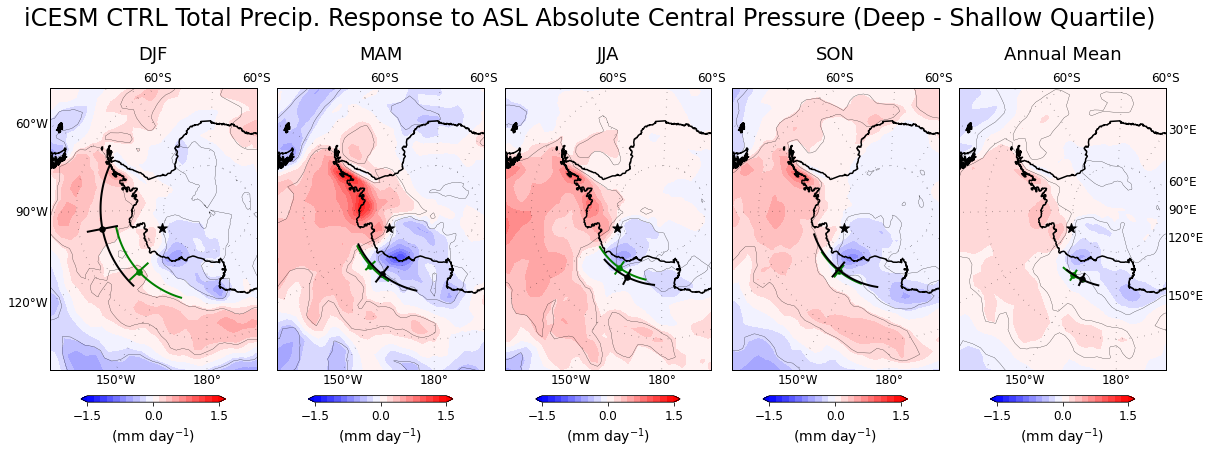

In [49]:
fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(20,6), sharex=True, sharey=True)
fig.subplots_adjust(hspace=0.0, wspace=0.1)
fig.suptitle('iCESM CTRL Total Precip. Response to ASL Absolute Central Pressure (Deep - Shallow Quartile)', fontsize=24, y=1.05)

# setup Lambert Conformal basemap.
diff_djf = djf_tp_w_deepmost_abs_cp_detrend_ctrl.mean(axis=0)-djf_tp_w_shallowmost_abs_cp_detrend_ctrl.mean(axis=0)
diff_mam = mam_tp_w_deepmost_abs_cp_detrend_ctrl.mean(axis=0)-mam_tp_w_shallowmost_abs_cp_detrend_ctrl.mean(axis=0)
diff_jja = jja_tp_w_deepmost_abs_cp_detrend_ctrl.mean(axis=0)-jja_tp_w_shallowmost_abs_cp_detrend_ctrl.mean(axis=0)
diff_son = son_tp_w_deepmost_abs_cp_detrend_ctrl.mean(axis=0)-son_tp_w_shallowmost_abs_cp_detrend_ctrl.mean(axis=0)
diff_ann = ann_mean_tp_w_deepmost_abs_cp_detrend_ctrl.mean(axis=0)-ann_mean_tp_w_shallowmost_abs_cp_detrend_ctrl.mean(axis=0)
diff_djf_sh, lons = add_cyclic_point(diff_djf.values, CTRL_DATA.coords['lon'].values, axis=-1)
diff_mam_sh, lons = add_cyclic_point(diff_mam.values, CTRL_DATA.coords['lon'].values, axis=-1)
diff_jja_sh, lons = add_cyclic_point(diff_jja.values, CTRL_DATA.coords['lon'].values, axis=-1)
diff_son_sh, lons = add_cyclic_point(diff_son.values, CTRL_DATA.coords['lon'].values, axis=-1)
diff_ann_sh, lons = add_cyclic_point(diff_ann.values, CTRL_DATA.coords['lon'].values, axis=-1)
diff_djf_con, lons = add_cyclic_point(djf_tp_change_due_to_abs_cp_ttest_stats_ctrl, CTRL_DATA.coords['lon'].values, axis=-1)
diff_mam_con, lons = add_cyclic_point(mam_tp_change_due_to_abs_cp_ttest_stats_ctrl, CTRL_DATA.coords['lon'].values, axis=-1)
diff_jja_con, lons = add_cyclic_point(jja_tp_change_due_to_abs_cp_ttest_stats_ctrl, CTRL_DATA.coords['lon'].values, axis=-1)
diff_son_con, lons = add_cyclic_point(son_tp_change_due_to_abs_cp_ttest_stats_ctrl, CTRL_DATA.coords['lon'].values, axis=-1)
diff_ann_con, lons = add_cyclic_point(ann_mean_tp_change_due_to_abs_cp_ttest_stats_ctrl, CTRL_DATA.coords['lon'].values, axis=-1)

lon, lat = np.meshgrid(lons,CTRL_DATA.coords['lat'].sel(lat=slice(shem_ylo, shem_yhi)).values)
levels = np.arange(-1.5,1.65,.15)
levels_contour = [-2.028,2.028] #good for seasons and annual mean

parallels = np.arange(-80,-1,20)
meridians = np.arange(0,360,30.)
plt.rcParams['contour.negative_linestyle'] = 'solid'
plt.rcParams['text.latex.preamble']=[r"\usepackage{wasysym}"]

#DJF
plt.subplot(1, 5, 1)
m = Basemap(llcrnrlon=-135,llcrnrlat=-40,urcrnrlon=20,urcrnrlat=-60,projection='lcc',
            resolution='l',lat_1=-89.,lat_2=-65,lat_0=-70,lon_0=180.)
x, y = m(lon, lat)
# draw coastlines.
m.drawcoastlines(linewidth=1.5)
m.drawmapboundary(fill_color='white')
# labels = [left,right,top,bottom]
m.drawparallels(parallels,labels=[False,False,True,False],dashes=[.3, 7],fontsize=12)
m.drawmeridians(meridians,labels=[True,False,False,True],dashes=[.3, 7],fontsize=12)
#CS = m.contourf(x,y,(djf_tp_w_deepmost_abs_cp_detrend_ctrl.mean(axis=0)-djf_tp_w_shallowmost_abs_cp_detrend_ctrl.mean(axis=0)).where((djf_tp_change_due_to_abs_cp_ttest_stats_ctrl >= levels_contour[1]) | (djf_tp_change_due_to_abs_cp_ttest_stats_ctrl < levels_contour[0]) ),levels,cmap=plt.cm.get_cmap('bwr'),extend='both')
CS = m.contourf(x,y,(diff_djf_sh),levels,cmap=plt.cm.get_cmap('bwr'),extend='both')
#plt.ylabel('V10', fontsize=20)
cbar = plt.colorbar(orientation='horizontal', shrink=0.70, aspect=20, fraction=0.033, pad=0.08)
cbar.set_label(r'(mm day$^{-1}$)',size=14)
cbar.set_ticks([-1.5, 0, 1.5])
cbar.ax.tick_params(labelsize=12)
plt.clim([-1.5,1.5])
CS2 = m.contour(x,y,diff_djf_con,levels_contour,linewidths=0.25,colors='k')

#add Abs. CP mean location for upper and lower indice
#upper
xpt,ypt = m(djf_Abs_CP_indices_w_deepmost_abs_cp_detrend_ctrl.lons.mean(),
            djf_Abs_CP_indices_w_deepmost_abs_cp_detrend_ctrl.lats.mean()
           )
plt.scatter(xpt, ypt, c='green', marker='o', s=30) #for value dependent: vmin=-10, vmax=0, cmap='green'
#lower
xpt,ypt = m(djf_Abs_CP_indices_w_shallowmost_abs_cp_detrend_ctrl.lons.mean(),
            djf_Abs_CP_indices_w_shallowmost_abs_cp_detrend_ctrl.lats.mean()
           )
plt.scatter(xpt, ypt, c='k', marker='o', s=30) #for value dependent: vmin=-10, vmax=0, cmap='green'

#Add +- 1std of long and lat
#upper
lat_line = np.linspace(djf_Abs_CP_indices_w_deepmost_abs_cp_detrend_ctrl.lats.mean()
                       ,djf_Abs_CP_indices_w_deepmost_abs_cp_detrend_ctrl.lats.mean()
                       ,100) 
lon_line = np.linspace(djf_Abs_CP_indices_w_deepmost_abs_cp_detrend_ctrl.lons.mean()+djf_Abs_CP_indices_w_deepmost_abs_cp_detrend_ctrl.lons.std()
                       ,djf_Abs_CP_indices_w_deepmost_abs_cp_detrend_ctrl.lons.mean()-djf_Abs_CP_indices_w_deepmost_abs_cp_detrend_ctrl.lons.std()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, color='green', linewidth=2) 

lat_line = np.linspace(djf_Abs_CP_indices_w_deepmost_abs_cp_detrend_ctrl.lats.mean()+djf_Abs_CP_indices_w_deepmost_abs_cp_detrend_ctrl.lats.std()
                       ,djf_Abs_CP_indices_w_deepmost_abs_cp_detrend_ctrl.lats.mean()-djf_Abs_CP_indices_w_deepmost_abs_cp_detrend_ctrl.lats.std()
                       ,100) 
lon_line = np.linspace(djf_Abs_CP_indices_w_deepmost_abs_cp_detrend_ctrl.lons.mean()
                       ,djf_Abs_CP_indices_w_deepmost_abs_cp_detrend_ctrl.lons.mean()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='green', linewidth=2)
#lower
lat_line = np.linspace(djf_Abs_CP_indices_w_shallowmost_abs_cp_detrend_ctrl.lats.mean()
                       ,djf_Abs_CP_indices_w_shallowmost_abs_cp_detrend_ctrl.lats.mean()
                       ,100) 
lon_line = np.linspace(djf_Abs_CP_indices_w_shallowmost_abs_cp_detrend_ctrl.lons.mean()+djf_Abs_CP_indices_w_shallowmost_abs_cp_detrend_ctrl.lons.std()
                       ,djf_Abs_CP_indices_w_shallowmost_abs_cp_detrend_ctrl.lons.mean()-djf_Abs_CP_indices_w_shallowmost_abs_cp_detrend_ctrl.lons.std()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='k', linewidth=2) 

lat_line = np.linspace(djf_Abs_CP_indices_w_shallowmost_abs_cp_detrend_ctrl.lats.mean()+djf_Abs_CP_indices_w_shallowmost_abs_cp_detrend_ctrl.lats.std()
                       ,djf_Abs_CP_indices_w_shallowmost_abs_cp_detrend_ctrl.lats.mean()-djf_Abs_CP_indices_w_shallowmost_abs_cp_detrend_ctrl.lats.std()
                       ,100) 
lon_line = np.linspace(djf_Abs_CP_indices_w_shallowmost_abs_cp_detrend_ctrl.lons.mean()
                       ,djf_Abs_CP_indices_w_shallowmost_abs_cp_detrend_ctrl.lons.mean()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='k', linewidth=2)

#add point for central Psuedo cores
xpt,ypt = m(247.5, -78.63)
plt.scatter(xpt, ypt, c='k', marker='*', s=100)

plt.title('DJF',y=1.08,fontsize=18)
print(djf_Abs_CP_indices_w_deepmost_abs_cp_detrend_ctrl.vals.mean(),djf_Abs_CP_indices_w_shallowmost_abs_cp_detrend_ctrl.vals.mean())


#MAM
plt.subplot(1, 5, 2)
m = Basemap(llcrnrlon=-135,llcrnrlat=-40,urcrnrlon=20,urcrnrlat=-60,projection='lcc',
            resolution='l',lat_1=-89.,lat_2=-65,lat_0=-70,lon_0=180.)
x, y = m(lon, lat)
# draw coastlines.
m.drawcoastlines(linewidth=1.5)
m.drawmapboundary(fill_color='white')
# labels = [left,right,top,bottom]
m.drawparallels(parallels,labels=[False,False,True,False],dashes=[.3, 7],fontsize=12)
m.drawmeridians(meridians,labels=[False,False,False,True],dashes=[.3, 7],fontsize=12)
#CS = m.contourf(x,y,(mam_tp_w_deepmost_abs_cp_detrend_ctrl.mean(axis=0)-mam_tp_w_shallowmost_abs_cp_detrend_ctrl.mean(axis=0)).where((mam_tp_change_due_to_abs_cp_ttest_stats_ctrl >= levels_contour[1]) | (mam_tp_change_due_to_abs_cp_ttest_stats_ctrl < levels_contour[0]) ),levels,cmap=plt.cm.get_cmap('bwr'),extend='both')
CS = m.contourf(x,y,(diff_mam_sh),levels,cmap=plt.cm.get_cmap('bwr'),extend='both')
#plt.ylabel('V10', fontsize=20)
cbar = plt.colorbar(orientation='horizontal', shrink=0.70, aspect=20, fraction=0.033, pad=0.08)
cbar.set_label(r'(mm day$^{-1}$)',size=14)
cbar.set_ticks([-1.5, 0, 1.5])
cbar.ax.tick_params(labelsize=12)
plt.clim([-1.5,1.5])
CS2 = m.contour(x,y,diff_mam_con,levels_contour,linewidths=0.25,colors='k')

#add Abs. CP mean location for upper and lower indice
#upper
xpt,ypt = m(mam_Abs_CP_indices_w_deepmost_abs_cp_detrend_ctrl.lons.mean(),
            mam_Abs_CP_indices_w_deepmost_abs_cp_detrend_ctrl.lats.mean()
           )
plt.scatter(xpt, ypt, c='green', marker='o', s=30) #for value dependent: vmin=-10, vmax=0, cmap='green'
#lower
xpt,ypt = m(mam_Abs_CP_indices_w_shallowmost_abs_cp_detrend_ctrl.lons.mean(),
            mam_Abs_CP_indices_w_shallowmost_abs_cp_detrend_ctrl.lats.mean()
           )
plt.scatter(xpt, ypt, c='k', marker='o', s=30) #for value dependent: vmin=-10, vmax=0, cmap='green'

#Add +- 1std of long and lat
#upper
lat_line = np.linspace(mam_Abs_CP_indices_w_deepmost_abs_cp_detrend_ctrl.lats.mean()
                       ,mam_Abs_CP_indices_w_deepmost_abs_cp_detrend_ctrl.lats.mean()
                       ,100) 
lon_line = np.linspace(mam_Abs_CP_indices_w_deepmost_abs_cp_detrend_ctrl.lons.mean()+mam_Abs_CP_indices_w_deepmost_abs_cp_detrend_ctrl.lons.std()
                       ,mam_Abs_CP_indices_w_deepmost_abs_cp_detrend_ctrl.lons.mean()-mam_Abs_CP_indices_w_deepmost_abs_cp_detrend_ctrl.lons.std()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, color='green', linewidth=2) 

lat_line = np.linspace(mam_Abs_CP_indices_w_deepmost_abs_cp_detrend_ctrl.lats.mean()+mam_Abs_CP_indices_w_deepmost_abs_cp_detrend_ctrl.lats.std()
                       ,mam_Abs_CP_indices_w_deepmost_abs_cp_detrend_ctrl.lats.mean()-mam_Abs_CP_indices_w_deepmost_abs_cp_detrend_ctrl.lats.std()
                       ,100) 
lon_line = np.linspace(mam_Abs_CP_indices_w_deepmost_abs_cp_detrend_ctrl.lons.mean()
                       ,mam_Abs_CP_indices_w_deepmost_abs_cp_detrend_ctrl.lons.mean()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='green', linewidth=2)
#lower
lat_line = np.linspace(mam_Abs_CP_indices_w_shallowmost_abs_cp_detrend_ctrl.lats.mean()
                       ,mam_Abs_CP_indices_w_shallowmost_abs_cp_detrend_ctrl.lats.mean()
                       ,100) 
lon_line = np.linspace(mam_Abs_CP_indices_w_shallowmost_abs_cp_detrend_ctrl.lons.mean()+mam_Abs_CP_indices_w_shallowmost_abs_cp_detrend_ctrl.lons.std()
                       ,mam_Abs_CP_indices_w_shallowmost_abs_cp_detrend_ctrl.lons.mean()-mam_Abs_CP_indices_w_shallowmost_abs_cp_detrend_ctrl.lons.std()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='k', linewidth=2) 

lat_line = np.linspace(mam_Abs_CP_indices_w_shallowmost_abs_cp_detrend_ctrl.lats.mean()+mam_Abs_CP_indices_w_shallowmost_abs_cp_detrend_ctrl.lats.std()
                       ,mam_Abs_CP_indices_w_shallowmost_abs_cp_detrend_ctrl.lats.mean()-mam_Abs_CP_indices_w_shallowmost_abs_cp_detrend_ctrl.lats.std()
                       ,100) 
lon_line = np.linspace(mam_Abs_CP_indices_w_shallowmost_abs_cp_detrend_ctrl.lons.mean()
                       ,mam_Abs_CP_indices_w_shallowmost_abs_cp_detrend_ctrl.lons.mean()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='k', linewidth=2)

#add point for central Psuedo cores
xpt,ypt = m(247.5, -78.63)
plt.scatter(xpt, ypt, c='k', marker='*', s=100)

plt.title('MAM',y=1.08,fontsize=18)
print(mam_Abs_CP_indices_w_deepmost_abs_cp_detrend_ctrl.vals.mean(),mam_Abs_CP_indices_w_shallowmost_abs_cp_detrend_ctrl.vals.mean())


#JJA
plt.subplot(1, 5, 3)
m = Basemap(llcrnrlon=-135,llcrnrlat=-40,urcrnrlon=20,urcrnrlat=-60,projection='lcc',
            resolution='l',lat_1=-89.,lat_2=-65,lat_0=-70,lon_0=180.)
x, y = m(lon, lat)
# draw coastlines.
m.drawcoastlines(linewidth=1.5)
m.drawmapboundary(fill_color='white')
# labels = [left,right,top,bottom]
m.drawparallels(parallels,labels=[False,False,True,False],dashes=[.3, 7],fontsize=12)
m.drawmeridians(meridians,labels=[False,False,False,True],dashes=[.3, 7],fontsize=12)
#CS = m.contourf(x,y,(jja_tp_w_deepmost_abs_cp_detrend_ctrl.mean(axis=0)-jja_tp_w_shallowmost_abs_cp_detrend_ctrl.mean(axis=0)).where((jja_tp_change_due_to_abs_cp_ttest_stats_ctrl >= levels_contour[1]) | (jja_tp_change_due_to_abs_cp_ttest_stats_ctrl < levels_contour[0]) ),levels,cmap=plt.cm.get_cmap('bwr'),extend='both')
CS = m.contourf(x,y,(diff_jja_sh),levels,cmap=plt.cm.get_cmap('bwr'),extend='both')
#plt.ylabel('V10', fontsize=20)
cbar = plt.colorbar(orientation='horizontal', shrink=0.70, aspect=20, fraction=0.033, pad=0.08)
cbar.set_label(r'(mm day$^{-1}$)',size=14)
cbar.set_ticks([-1.5, 0, 1.5])
cbar.ax.tick_params(labelsize=12)
plt.clim([-1.5,1.5])
CS2 = m.contour(x,y,diff_jja_con,levels_contour,linewidths=0.25,colors='k')

#add Abs. CP mean location for upper and lower indice
#upper
xpt,ypt = m(jja_Abs_CP_indices_w_deepmost_abs_cp_detrend_ctrl.lons.mean(),
            jja_Abs_CP_indices_w_deepmost_abs_cp_detrend_ctrl.lats.mean()
           )
plt.scatter(xpt, ypt, c='green', marker='o', s=30) #for value dependent: vmin=-10, vmax=0, cmap='green'
#lower
xpt,ypt = m(jja_Abs_CP_indices_w_shallowmost_abs_cp_detrend_ctrl.lons.mean(),
            jja_Abs_CP_indices_w_shallowmost_abs_cp_detrend_ctrl.lats.mean()
           )
plt.scatter(xpt, ypt, c='k', marker='o', s=30) #for value dependent: vmin=-10, vmax=0, cmap='green'

#Add +- 1std of long and lat
#upper
lat_line = np.linspace(jja_Abs_CP_indices_w_deepmost_abs_cp_detrend_ctrl.lats.mean()
                       ,jja_Abs_CP_indices_w_deepmost_abs_cp_detrend_ctrl.lats.mean()
                       ,100) 
lon_line = np.linspace(jja_Abs_CP_indices_w_deepmost_abs_cp_detrend_ctrl.lons.mean()+jja_Abs_CP_indices_w_deepmost_abs_cp_detrend_ctrl.lons.std()
                       ,jja_Abs_CP_indices_w_deepmost_abs_cp_detrend_ctrl.lons.mean()-jja_Abs_CP_indices_w_deepmost_abs_cp_detrend_ctrl.lons.std()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, color='green', linewidth=2) 

lat_line = np.linspace(jja_Abs_CP_indices_w_deepmost_abs_cp_detrend_ctrl.lats.mean()+jja_Abs_CP_indices_w_deepmost_abs_cp_detrend_ctrl.lats.std()
                       ,jja_Abs_CP_indices_w_deepmost_abs_cp_detrend_ctrl.lats.mean()-jja_Abs_CP_indices_w_deepmost_abs_cp_detrend_ctrl.lats.std()
                       ,100) 
lon_line = np.linspace(jja_Abs_CP_indices_w_deepmost_abs_cp_detrend_ctrl.lons.mean()
                       ,jja_Abs_CP_indices_w_deepmost_abs_cp_detrend_ctrl.lons.mean()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='green', linewidth=2)
#lower
lat_line = np.linspace(jja_Abs_CP_indices_w_shallowmost_abs_cp_detrend_ctrl.lats.mean()
                       ,jja_Abs_CP_indices_w_shallowmost_abs_cp_detrend_ctrl.lats.mean()
                       ,100) 
lon_line = np.linspace(jja_Abs_CP_indices_w_shallowmost_abs_cp_detrend_ctrl.lons.mean()+jja_Abs_CP_indices_w_shallowmost_abs_cp_detrend_ctrl.lons.std()
                       ,jja_Abs_CP_indices_w_shallowmost_abs_cp_detrend_ctrl.lons.mean()-jja_Abs_CP_indices_w_shallowmost_abs_cp_detrend_ctrl.lons.std()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='k', linewidth=2) 

lat_line = np.linspace(jja_Abs_CP_indices_w_shallowmost_abs_cp_detrend_ctrl.lats.mean()+jja_Abs_CP_indices_w_shallowmost_abs_cp_detrend_ctrl.lats.std()
                       ,jja_Abs_CP_indices_w_shallowmost_abs_cp_detrend_ctrl.lats.mean()-jja_Abs_CP_indices_w_shallowmost_abs_cp_detrend_ctrl.lats.std()
                       ,100) 
lon_line = np.linspace(jja_Abs_CP_indices_w_shallowmost_abs_cp_detrend_ctrl.lons.mean()
                       ,jja_Abs_CP_indices_w_shallowmost_abs_cp_detrend_ctrl.lons.mean()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='k', linewidth=2)

#add point for central Psuedo cores
xpt,ypt = m(247.5, -78.63)
plt.scatter(xpt, ypt, c='k', marker='*', s=100)

plt.title('JJA',y=1.08,fontsize=18)
print(jja_Abs_CP_indices_w_deepmost_abs_cp_detrend_ctrl.vals.mean(),jja_Abs_CP_indices_w_shallowmost_abs_cp_detrend_ctrl.vals.mean())


#SON
plt.subplot(1, 5, 4)
m = Basemap(llcrnrlon=-135,llcrnrlat=-40,urcrnrlon=20,urcrnrlat=-60,projection='lcc',
            resolution='l',lat_1=-89.,lat_2=-65,lat_0=-70,lon_0=180.)
x, y = m(lon, lat)
# draw coastlines.
m.drawcoastlines(linewidth=1.5)
m.drawmapboundary(fill_color='white')
# labels = [left,right,top,bottom]
m.drawparallels(parallels,labels=[False,False,True,False],dashes=[.3, 7],fontsize=12)
m.drawmeridians(meridians,labels=[False,False,False,True],dashes=[.3, 7],fontsize=12)
#CS = m.contourf(x,y,(son_tp_w_deepmost_abs_cp_detrend_ctrl.mean(axis=0)-son_tp_w_shallowmost_abs_cp_detrend_ctrl.mean(axis=0)).where((son_tp_change_due_to_abs_cp_ttest_stats_ctrl >= levels_contour[1]) | (son_tp_change_due_to_abs_cp_ttest_stats_ctrl < levels_contour[0]) ),levels,cmap=plt.cm.get_cmap('bwr'),extend='both')
CS = m.contourf(x,y,(diff_son_sh),levels,cmap=plt.cm.get_cmap('bwr'),extend='both')
#plt.ylabel('V10', fontsize=20)
cbar = plt.colorbar(orientation='horizontal', shrink=0.70, aspect=20, fraction=0.033, pad=0.08)
cbar.set_label(r'(mm day$^{-1}$)',size=14)
cbar.set_ticks([-1.5, 0, 1.5])
cbar.ax.tick_params(labelsize=12)
plt.clim([-1.5,1.5])
CS2 = m.contour(x,y,diff_son_con,levels_contour,linewidths=0.25,colors='k')

#add Abs. CP mean location for upper and lower indice
#upper
xpt,ypt = m(son_Abs_CP_indices_w_deepmost_abs_cp_detrend_ctrl.lons.mean(),
            son_Abs_CP_indices_w_deepmost_abs_cp_detrend_ctrl.lats.mean()
           )
plt.scatter(xpt, ypt, c='green', marker='o', s=30) #for value dependent: vmin=-10, vmax=0, cmap='green'
#lower
xpt,ypt = m(son_Abs_CP_indices_w_shallowmost_abs_cp_detrend_ctrl.lons.mean(),
            son_Abs_CP_indices_w_shallowmost_abs_cp_detrend_ctrl.lats.mean()
           )
plt.scatter(xpt, ypt, c='k', marker='o', s=30) #for value dependent: vmin=-10, vmax=0, cmap='green'

#Add +- 1std of long and lat
#upper
lat_line = np.linspace(son_Abs_CP_indices_w_deepmost_abs_cp_detrend_ctrl.lats.mean()
                       ,son_Abs_CP_indices_w_deepmost_abs_cp_detrend_ctrl.lats.mean()
                       ,100) 
lon_line = np.linspace(son_Abs_CP_indices_w_deepmost_abs_cp_detrend_ctrl.lons.mean()+son_Abs_CP_indices_w_deepmost_abs_cp_detrend_ctrl.lons.std()
                       ,son_Abs_CP_indices_w_deepmost_abs_cp_detrend_ctrl.lons.mean()-son_Abs_CP_indices_w_deepmost_abs_cp_detrend_ctrl.lons.std()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, color='green', linewidth=2) 

lat_line = np.linspace(son_Abs_CP_indices_w_deepmost_abs_cp_detrend_ctrl.lats.mean()+son_Abs_CP_indices_w_deepmost_abs_cp_detrend_ctrl.lats.std()
                       ,son_Abs_CP_indices_w_deepmost_abs_cp_detrend_ctrl.lats.mean()-son_Abs_CP_indices_w_deepmost_abs_cp_detrend_ctrl.lats.std()
                       ,100) 
lon_line = np.linspace(son_Abs_CP_indices_w_deepmost_abs_cp_detrend_ctrl.lons.mean()
                       ,son_Abs_CP_indices_w_deepmost_abs_cp_detrend_ctrl.lons.mean()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='green', linewidth=2)
#lower
lat_line = np.linspace(son_Abs_CP_indices_w_shallowmost_abs_cp_detrend_ctrl.lats.mean()
                       ,son_Abs_CP_indices_w_shallowmost_abs_cp_detrend_ctrl.lats.mean()
                       ,100) 
lon_line = np.linspace(son_Abs_CP_indices_w_shallowmost_abs_cp_detrend_ctrl.lons.mean()+son_Abs_CP_indices_w_shallowmost_abs_cp_detrend_ctrl.lons.std()
                       ,son_Abs_CP_indices_w_shallowmost_abs_cp_detrend_ctrl.lons.mean()-son_Abs_CP_indices_w_shallowmost_abs_cp_detrend_ctrl.lons.std()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='k', linewidth=2) 

lat_line = np.linspace(son_Abs_CP_indices_w_shallowmost_abs_cp_detrend_ctrl.lats.mean()+son_Abs_CP_indices_w_shallowmost_abs_cp_detrend_ctrl.lats.std()
                       ,son_Abs_CP_indices_w_shallowmost_abs_cp_detrend_ctrl.lats.mean()-son_Abs_CP_indices_w_shallowmost_abs_cp_detrend_ctrl.lats.std()
                       ,100) 
lon_line = np.linspace(son_Abs_CP_indices_w_shallowmost_abs_cp_detrend_ctrl.lons.mean()
                       ,son_Abs_CP_indices_w_shallowmost_abs_cp_detrend_ctrl.lons.mean()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='k', linewidth=2)

#add point for central Psuedo cores
xpt,ypt = m(247.5, -78.63)
plt.scatter(xpt, ypt, c='k', marker='*', s=100)

plt.title('SON',y=1.08,fontsize=18)
print(son_Abs_CP_indices_w_deepmost_abs_cp_detrend_ctrl.vals.mean(),son_Abs_CP_indices_w_shallowmost_abs_cp_detrend_ctrl.vals.mean())


#Annual Mean
plt.subplot(1, 5, 5)
m = Basemap(llcrnrlon=-135,llcrnrlat=-40,urcrnrlon=20,urcrnrlat=-60,projection='lcc',
            resolution='l',lat_1=-89.,lat_2=-65,lat_0=-70,lon_0=180.)
x, y = m(lon, lat)
# draw coastlines.
m.drawcoastlines(linewidth=1.5)
m.drawmapboundary(fill_color='white')
# labels = [left,right,top,bottom]
m.drawparallels(parallels,labels=[False,False,True,False],dashes=[.3, 7],fontsize=12)
m.drawmeridians(meridians,labels=[False,True,False,True],dashes=[.3, 7],fontsize=12)
#CS = m.contourf(x,y,(ann_mean_tp_w_deepmost_abs_cp_detrend_ctrl.mean(axis=0)-ann_mean_tp_w_shallowmost_abs_cp_detrend_ctrl.mean(axis=0)).where((ann_mean_tp_change_due_to_abs_cp_ttest_stats_ctrl >= levels_contour[1]) | (ann_mean_tp_change_due_to_abs_cp_ttest_stats_ctrl < levels_contour[0]) ),levels,cmap=plt.cm.get_cmap('bwr'),extend='both')
CS = m.contourf(x,y,(diff_ann_sh),levels,cmap=plt.cm.get_cmap('bwr'),extend='both')
#plt.ylabel('V10', fontsize=20)
cbar = plt.colorbar(orientation='horizontal', shrink=0.70, aspect=20, fraction=0.033, pad=0.08)
cbar.set_label(r'(mm day$^{-1}$)',size=14)
cbar.set_ticks([-1.5, 0, 1.5])
cbar.ax.tick_params(labelsize=12)
plt.clim([-1.5,1.5])
CS2 = m.contour(x,y,diff_ann_con,levels_contour,linewidths=0.25,colors='k')

#add Abs. CP mean location for upper and lower indice
#upper
xpt,ypt = m(ann_mean_Abs_CP_indices_w_deepmost_abs_cp_detrend_ctrl.lons.mean(),
            ann_mean_Abs_CP_indices_w_deepmost_abs_cp_detrend_ctrl.lats.mean()
           )
plt.scatter(xpt, ypt, c='green', marker='o', s=30) #for value dependent: vmin=-10, vmax=0, cmap='green'
#lower
xpt,ypt = m(ann_mean_Abs_CP_indices_w_shallowmost_abs_cp_detrend_ctrl.lons.mean(),
            ann_mean_Abs_CP_indices_w_shallowmost_abs_cp_detrend_ctrl.lats.mean()
           )
plt.scatter(xpt, ypt, c='k', marker='o', s=30) #for value dependent: vmin=-10, vmax=0, cmap='green'

#Add +- 1std of long and lat
#upper
lat_line = np.linspace(ann_mean_Abs_CP_indices_w_deepmost_abs_cp_detrend_ctrl.lats.mean()
                       ,ann_mean_Abs_CP_indices_w_deepmost_abs_cp_detrend_ctrl.lats.mean()
                       ,100) 
lon_line = np.linspace(ann_mean_Abs_CP_indices_w_deepmost_abs_cp_detrend_ctrl.lons.mean()+ann_mean_Abs_CP_indices_w_deepmost_abs_cp_detrend_ctrl.lons.std()
                       ,ann_mean_Abs_CP_indices_w_deepmost_abs_cp_detrend_ctrl.lons.mean()-ann_mean_Abs_CP_indices_w_deepmost_abs_cp_detrend_ctrl.lons.std()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, color='green', linewidth=2) 

lat_line = np.linspace(ann_mean_Abs_CP_indices_w_deepmost_abs_cp_detrend_ctrl.lats.mean()+ann_mean_Abs_CP_indices_w_deepmost_abs_cp_detrend_ctrl.lats.std()
                       ,ann_mean_Abs_CP_indices_w_deepmost_abs_cp_detrend_ctrl.lats.mean()-ann_mean_Abs_CP_indices_w_deepmost_abs_cp_detrend_ctrl.lats.std()
                       ,100) 
lon_line = np.linspace(ann_mean_Abs_CP_indices_w_deepmost_abs_cp_detrend_ctrl.lons.mean()
                       ,ann_mean_Abs_CP_indices_w_deepmost_abs_cp_detrend_ctrl.lons.mean()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='green', linewidth=2)
#lower
lat_line = np.linspace(ann_mean_Abs_CP_indices_w_shallowmost_abs_cp_detrend_ctrl.lats.mean()
                       ,ann_mean_Abs_CP_indices_w_shallowmost_abs_cp_detrend_ctrl.lats.mean()
                       ,100) 
lon_line = np.linspace(ann_mean_Abs_CP_indices_w_shallowmost_abs_cp_detrend_ctrl.lons.mean()+ann_mean_Abs_CP_indices_w_shallowmost_abs_cp_detrend_ctrl.lons.std()
                       ,ann_mean_Abs_CP_indices_w_shallowmost_abs_cp_detrend_ctrl.lons.mean()-ann_mean_Abs_CP_indices_w_shallowmost_abs_cp_detrend_ctrl.lons.std()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='k', linewidth=2) 

lat_line = np.linspace(ann_mean_Abs_CP_indices_w_shallowmost_abs_cp_detrend_ctrl.lats.mean()+ann_mean_Abs_CP_indices_w_shallowmost_abs_cp_detrend_ctrl.lats.std()
                       ,ann_mean_Abs_CP_indices_w_shallowmost_abs_cp_detrend_ctrl.lats.mean()-ann_mean_Abs_CP_indices_w_shallowmost_abs_cp_detrend_ctrl.lats.std()
                       ,100) 
lon_line = np.linspace(ann_mean_Abs_CP_indices_w_shallowmost_abs_cp_detrend_ctrl.lons.mean()
                       ,ann_mean_Abs_CP_indices_w_shallowmost_abs_cp_detrend_ctrl.lons.mean()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='k', linewidth=2)

#add point for central Psuedo cores
xpt,ypt = m(247.5, -78.63)
plt.scatter(xpt, ypt, c='k', marker='*', s=100)

plt.title('Annual Mean',y=1.08,fontsize=18)
#plt.annotate('Jul-24-2012', xy=(0, 1), xycoords='axes fraction')
print(ann_mean_Abs_CP_indices_w_deepmost_abs_cp_detrend_ctrl.vals.mean(),ann_mean_Abs_CP_indices_w_shallowmost_abs_cp_detrend_ctrl.vals.mean())


# plt.savefig(FIG_PATH+'/OLD_Figure_iCESM_CTRL_TAGGED_tp_Field_vs_ASL_Abs_CP_Values_Quartiles_20210324.pdf',bbox_inches='tight', pad_inches=0.05)

plt.show()

# DO REGRESSION ANALYSIS
## For Reviews

### We want a seasonal and annual time series of SAM, PSA1, PSA2, ASL Lon, ASL Rel CP, and ASL Abs CP

In [50]:
#Find SAM values for each of the 8 time periods and put in pd.DataFrame
#Then, select the upper and lower quartile values

###SAM
# SAM_djf_mean_ctrl
# SAM_jja_mean_ctrl
# SAM_ann_mean_ctrl 

###PSA1
# PSA1_djf_mean_ctrl
# PSA1_jja_mean_ctrl
# PSA1_ann_mean_ctrl

###PSA2
# PSA2_djf_mean_ctrl
# PSA2_jja_mean_ctrl
# PSA2_ann_mean_ctrl

###ASL lons
lons_djf_mean_ctrl = Rel_CP_djf_mean_indices_raw_ctrl.drop(columns=['vals','lats','sectormean'])
lons_jja_mean_ctrl = Rel_CP_jja_mean_indices_raw_ctrl.drop(columns=['vals','lats','sectormean'])
lons_ann_mean_ctrl = Rel_CP_ann_mean_indices_raw_ctrl.drop(columns=['vals','lats','sectormean'])

###ASL Rel CP
rel_cp_djf_mean_ctrl = Rel_CP_djf_mean_indices_raw_ctrl.drop(columns=['lons','lats','sectormean'])
rel_cp_jja_mean_ctrl = Rel_CP_jja_mean_indices_raw_ctrl.drop(columns=['lons','lats','sectormean'])
rel_cp_ann_mean_ctrl = Rel_CP_ann_mean_indices_raw_ctrl.drop(columns=['lons','lats','sectormean'])

###ASL Abs CP
abs_cp_djf_mean_ctrl = Abs_CP_djf_mean_indices_raw_ctrl.drop(columns=['lons','lats','sectormean','vals'])
abs_cp_jja_mean_ctrl = Abs_CP_jja_mean_indices_raw_ctrl.drop(columns=['lons','lats','sectormean','vals'])
abs_cp_ann_mean_ctrl = Abs_CP_ann_mean_indices_raw_ctrl.drop(columns=['lons','lats','sectormean','vals'])

### We want a map of TP for each of the seasons and annual mean

In [51]:
# djf_tp_shem_seas_mean_detrend_ctrl
# jja_tp_shem_seas_mean_detrend_ctrl
ann_mean_tp_shem_seas_mean_detrend_ctrl = tp_shem_ann_mean_detrend_ctrl

### Regression Calculation

#### Regress SAM onto TP

In [52]:
#Note, for the time series input, must select the column name and .values

##### SAM
###djf
slope_sam_djf, intercept_sam_djf, r_value_sam_djf, p_value_sam_djf, std_err_sam_djf = xr.apply_ufunc(stats.linregress,
                                                                                 SAM_djf_mean_ctrl['SAM'].values,
                                                                                 djf_tp_shem_seas_mean_detrend_ctrl,
                                                                                 input_core_dims=[[''], ['time']], #note depending on name of time dimension this can change
                                                                                 output_core_dims=[[], [], [], [], []],
                                                                                 vectorize=True)
r2_value_sam_djf = r_value_sam_djf**2

###jja
slope_sam_jja, intercept_sam_jja, r_value_sam_jja, p_value_sam_jja, std_err_sam_jja = xr.apply_ufunc(stats.linregress,
                                                                                 SAM_jja_mean_ctrl['SAM'].values,
                                                                                 jja_tp_shem_seas_mean_detrend_ctrl,
                                                                                 input_core_dims=[[''], ['time']], #note depending on name of time dimension this can change
                                                                                 output_core_dims=[[], [], [], [], []],
                                                                                 vectorize=True)
r2_value_sam_jja = r_value_sam_jja**2

###ann_mean
slope_sam_ann_mean, intercept_sam_ann_mean, r_value_sam_ann_mean, p_value_sam_ann_mean, std_err_sam_ann_mean = xr.apply_ufunc(stats.linregress,
                                                                                 SAM_ann_mean_ctrl['SAM'].values,
                                                                                 ann_mean_tp_shem_seas_mean_detrend_ctrl,
                                                                                 input_core_dims=[[''], ['time']], #note depending on name of time dimension this can change
                                                                                 output_core_dims=[[], [], [], [], []],
                                                                                 vectorize=True)
r2_value_sam_ann_mean = r_value_sam_ann_mean**2

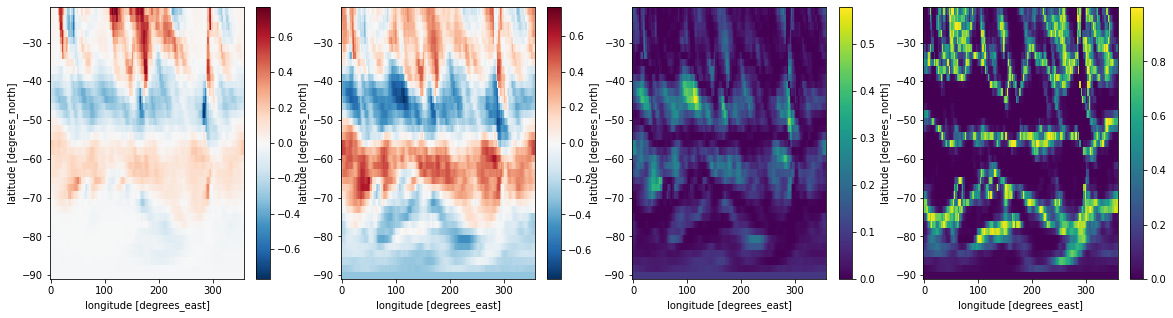

In [53]:
# use xarray to make a tester plot of the r values and p values to see the range to be sure looks about right 
fig = plt.figure(figsize=(20,5))

rsquared = r_value_sam_djf*r_value_sam_djf #multiplying rval * rval to get rsquared

ax = plt.subplot(1,4,1)
slope_sam_djf.plot()

ax = plt.subplot(1,4,2)
r_value_sam_djf.plot()

ax = plt.subplot(1,4,3)
rsquared.plot()

ax = plt.subplot(1,4,4)
p_value_sam_djf.plot()

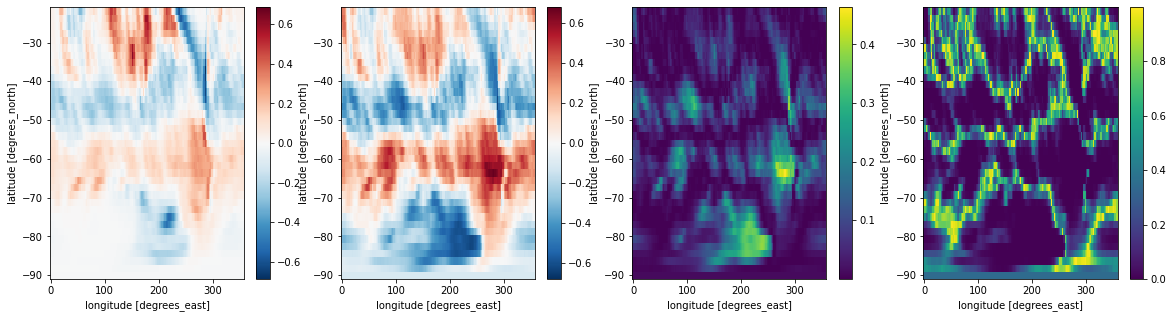

In [54]:
# use xarray to make a tester plot of the r values and p values to see the range to be sure looks about right 
fig = plt.figure(figsize=(20,5))

rsquared = r_value_sam_ann_mean*r_value_sam_ann_mean #multiplying rval * rval to get rsquared

ax = plt.subplot(1,4,1)
slope_sam_ann_mean.plot()

ax = plt.subplot(1,4,2)
r_value_sam_ann_mean.plot()

ax = plt.subplot(1,4,3)
rsquared.plot()

ax = plt.subplot(1,4,4)
p_value_sam_ann_mean.plot()

#### Now make a matrix of numbers and NaNs where the rsquared and pvals meet certain criteria

In [55]:
# threshold_rsquared = 0.5
# threshold_pval = 0.01

# stipple = rsquared.where(rsquared > threshold_rsquared) #note that the xarray where command keeps all values meeting criteria, others nan/missing
# stipple = stipple.where(p_value_annual < threshold_pval) #now find everywhere pvals meet threshold (AKA significant)
# stipple = stipple.where(xr.ufuncs.logical_not(stipple > 0) , 1) #OK, now we should have rsquared vals where significant, missing/zero where not, so let's replace rsquared with 1 so we have missing/zero and 1 values

# stipple

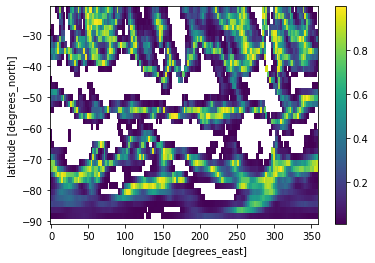

In [56]:
p_value_sam_djf.where(p_value_sam_djf >= 0.01).plot()

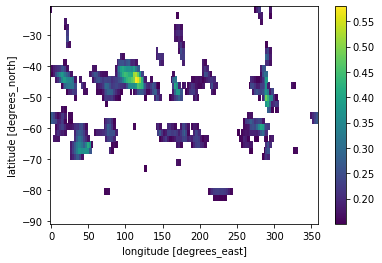

In [57]:
r2_value_sam_djf.where(r2_value_sam_djf >= 0.15).plot()

In [58]:
######  Ideas For Statistical Significance of the Regression Slope   ######

pval_threshold = 0.05
r2_threshold   = 0.15

#Contour where the p-value is below threshold
modify1_p_value_sam_djf = p_value_sam_djf.where(p_value_sam_djf <= pval_threshold, 0)  #select values below threshold, others equal 0
modify2_p_value_sam_djf = modify1_p_value_sam_djf.where(modify1_p_value_sam_djf == 0, 1)  #change values below threshold to be equal to 1.  Now have array of 0 and 1s

modify1_p_value_sam_jja = p_value_sam_jja.where(p_value_sam_jja <= pval_threshold, 0)  #select values below threshold, others equal 0
modify2_p_value_sam_jja = modify1_p_value_sam_jja.where(modify1_p_value_sam_jja == 0, 1)  #change values below threshold to be equal to 1.  Now have array of 0 and 1s

modify1_p_value_sam_ann_mean = p_value_sam_ann_mean.where(p_value_sam_ann_mean <= pval_threshold, 0)  #select values below threshold, others equal 0
modify2_p_value_sam_ann_mean = modify1_p_value_sam_ann_mean.where(modify1_p_value_sam_ann_mean == 0, 1)  #change values below threshold to be equal to 1.  Now have array of 0 and 1s

#Contour where the r-squared is above threshold
modify1_r2_value_sam_djf = r2_value_sam_djf.where(r2_value_sam_djf >= r2_threshold, 0)  #select values below threshold, others equal 0
modify2_r2_value_sam_djf = modify1_r2_value_sam_djf.where(modify1_r2_value_sam_djf == 0, 1)  #change values below threshold to be equal to 1.  Now have array of 0 and 1s

modify1_r2_value_sam_jja = r2_value_sam_jja.where(r2_value_sam_jja >= r2_threshold, 0)  #select values below threshold, others equal 0
modify2_r2_value_sam_jja = modify1_r2_value_sam_jja.where(modify1_r2_value_sam_jja == 0, 1)  #change values below threshold to be equal to 1.  Now have array of 0 and 1s

modify1_r2_value_sam_ann_mean = r2_value_sam_ann_mean.where(r2_value_sam_ann_mean >= r2_threshold, 0)  #select values below threshold, others equal 0
modify2_r2_value_sam_ann_mean = modify1_r2_value_sam_ann_mean.where(modify1_r2_value_sam_ann_mean == 0, 1)  #change values below threshold to be equal to 1.  Now have array of 0 and 1s

#Combine the two criteria
threshold_r2_p_value_sam_djf = modify2_r2_value_sam_djf.where(modify2_p_value_sam_djf == 1, 0)
threshold_r2_p_value_sam_jja = modify2_r2_value_sam_jja.where(modify2_p_value_sam_jja == 1, 0)
threshold_r2_p_value_sam_ann_mean = modify2_r2_value_sam_ann_mean.where(modify2_p_value_sam_ann_mean == 1, 0)

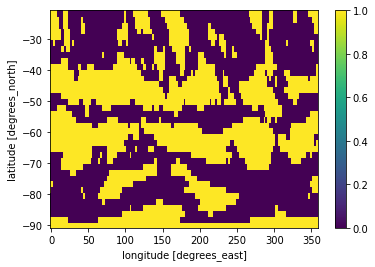

In [59]:
modify2_p_value_sam_djf.plot()

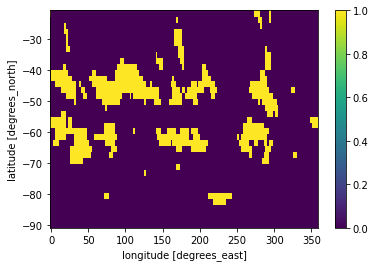

In [60]:
modify2_r2_value_sam_djf.plot()

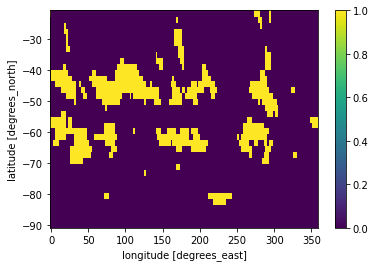

In [61]:
threshold_r2_p_value_sam_djf.plot()

/glade/work/pgoddard/NEW_ANACONDA_AND_PY_ENV_24Mar2021/geo_scipy/lib/python3.7/site-packages/cartopy/util.py:102: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  new_data = ma.concatenate((data, data[slicer]), axis=axis)
/glade/work/pgoddard/NEW_ANACONDA_AND_PY_ENV_24Mar2021/geo_scipy/lib/python3.7/site-packages/ipykernel_launcher.py:39: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.


-4.9006856442428495 -4.334664159718601


/glade/work/pgoddard/NEW_ANACONDA_AND_PY_ENV_24Mar2021/geo_scipy/lib/python3.7/site-packages/ipykernel_launcher.py:129: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.


-9.416681147344788 -8.54199293308687


/glade/work/pgoddard/NEW_ANACONDA_AND_PY_ENV_24Mar2021/geo_scipy/lib/python3.7/site-packages/ipykernel_launcher.py:217: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.


-6.386607262488048 -5.541187217482436


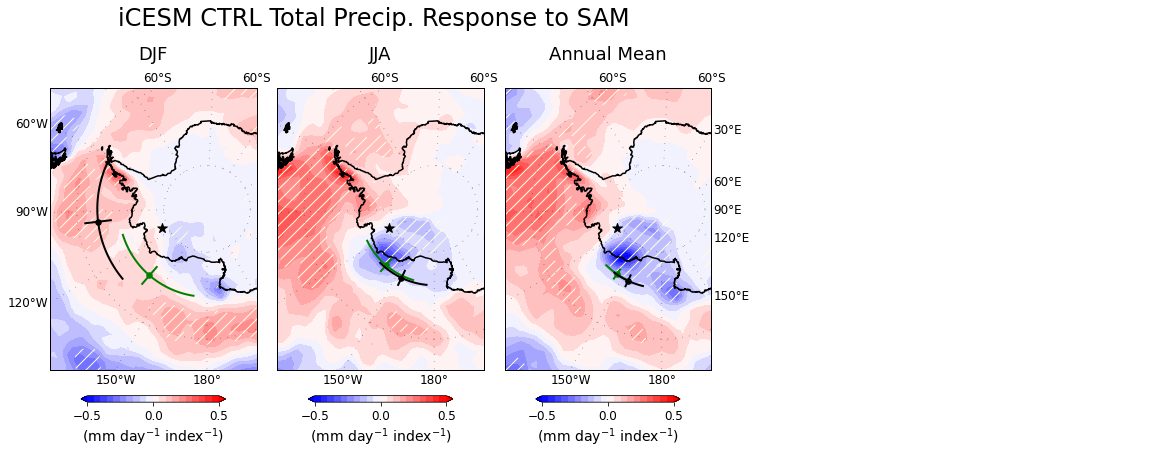

In [62]:
fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(20,6), sharex=True, sharey=True)
fig.subplots_adjust(hspace=0.0, wspace=0.1)
fig.suptitle('iCESM CTRL Total Precip. Response to SAM', fontsize=24, y=1.05, x = 0.35)

# setup Lambert Conformal basemap.

# slope shades -- add cyclic
slope_djf_sh, lons = add_cyclic_point(slope_sam_djf.values, CTRL_DATA.coords['lon'].values, axis=-1)
slope_jja_sh, lons = add_cyclic_point(slope_sam_jja.values, CTRL_DATA.coords['lon'].values, axis=-1)
slope_ann_mean_sh, lons = add_cyclic_point(slope_sam_ann_mean.values, CTRL_DATA.coords['lon'].values, axis=-1)
# p-value contour -- add cyclic
p_value_djf_con, lons = add_cyclic_point(modify2_p_value_sam_djf.values, CTRL_DATA.coords['lon'].values, axis=-1)
p_value_jja_con, lons = add_cyclic_point(modify2_p_value_sam_jja.values, CTRL_DATA.coords['lon'].values, axis=-1)
p_value_ann_mean_con, lons = add_cyclic_point(modify2_p_value_sam_ann_mean.values, CTRL_DATA.coords['lon'].values, axis=-1)
# r2-value contour -- add cyclic
r2_value_djf_con, lons = add_cyclic_point(modify2_r2_value_sam_djf.values, CTRL_DATA.coords['lon'].values, axis=-1)
r2_value_jja_con, lons = add_cyclic_point(modify2_r2_value_sam_jja.values, CTRL_DATA.coords['lon'].values, axis=-1)
r2_value_ann_mean_con, lons = add_cyclic_point(modify2_r2_value_sam_ann_mean.values, CTRL_DATA.coords['lon'].values, axis=-1)
# r2 and p-value threshold contour -- add cyclic
threshold_r2_p_value_sam_djf_con, lons = add_cyclic_point(threshold_r2_p_value_sam_djf.values, CTRL_DATA.coords['lon'].values, axis=-1)
threshold_r2_p_value_sam_jja_con, lons = add_cyclic_point(threshold_r2_p_value_sam_jja.values, CTRL_DATA.coords['lon'].values, axis=-1)
threshold_r2_p_value_sam_ann_mean_con, lons = add_cyclic_point(threshold_r2_p_value_sam_ann_mean.values, CTRL_DATA.coords['lon'].values, axis=-1)




lon, lat = np.meshgrid(lons,CTRL_DATA.coords['lat'].sel(lat=slice(shem_ylo, shem_yhi)).values)
levels = np.arange(-0.5,0.55,0.05)
levels_contour = [1]

parallels = np.arange(-80,-1,20)
meridians = np.arange(0,360,30.)
plt.rcParams['contour.negative_linestyle'] = 'solid'
plt.rcParams['text.latex.preamble']=[r"\usepackage{wasysym}"]

#DJF
plt.subplot(1, 5, 1)
m = Basemap(llcrnrlon=-135,llcrnrlat=-40,urcrnrlon=20,urcrnrlat=-60,projection='lcc',
            resolution='l',lat_1=-89.,lat_2=-65,lat_0=-70,lon_0=180.)
x, y = m(lon, lat)
# draw coastlines.
m.drawcoastlines(linewidth=1.5)
m.drawmapboundary(fill_color='white')
# labels = [left,right,top,bottom]
m.drawparallels(parallels,labels=[False,False,True,False],dashes=[.3, 7],fontsize=12)
m.drawmeridians(meridians,labels=[True,False,False,True],dashes=[.3, 7],fontsize=12)
CS = m.contourf(x,y,(slope_djf_sh), levels, cmap=plt.cm.get_cmap('bwr'),extend='both')
#plt.ylabel('V10', fontsize=20)
cbar = plt.colorbar(orientation='horizontal', shrink=0.70, aspect=20, fraction=0.033, pad=0.08)
cbar.set_label(r'(mm day$^{-1}$ index$^{-1}$)',size=14)
cbar.set_ticks([-0.5, 0, 0.5])
cbar.ax.tick_params(labelsize=12)
plt.clim([-0.5,0.5])
#add point for central Psuedo cores
xpt,ypt = m(247.5, -78.63)
plt.scatter(xpt, ypt, c='k', marker='*', s=100)
# CS2 = m.contour(x,y,p_value_djf_con, levels_contour, linewidths=0.35,colors='k')
# CS2 = m.contour(x,y,r2_value_djf_con, levels_contour, linewidths=0.35,colors='k')
# CS2 = m.contour(x,y,threshold_r2_p_value_sam_djf_con, levels_contour, linewidths=0.35,colors='k')
mpl.rcParams['hatch.color'] = 'lightyellow' #use this line to change stipple color
CS2 = m.contourf(x, y, threshold_r2_p_value_sam_djf_con, levels = [0,0.5,1], hatches=['','//'], alpha=0)

#add Rel. CP mean location for upper and lower indice
#upper
xpt,ypt = m(djf_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lons.mean(),
            djf_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lats.mean()
           )
plt.scatter(xpt, ypt, c='green', marker='o', s=30) #for value dependent: vmin=-10, vmax=0, cmap='green'
#lower
xpt,ypt = m(djf_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lons.mean(),
            djf_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lats.mean()
           )
plt.scatter(xpt, ypt, c='k', marker='o', s=30) #for value dependent: vmin=-10, vmax=0, cmap='green'

#Add +- 1std of long and lat
#upper
lat_line = np.linspace(djf_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lats.mean()
                       ,djf_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lats.mean()
                       ,100) 
lon_line = np.linspace(djf_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lons.mean()+djf_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lons.std()
                       ,djf_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lons.mean()-djf_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lons.std()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, color='green', linewidth=2) 

lat_line = np.linspace(djf_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lats.mean()+djf_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lats.std()
                       ,djf_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lats.mean()-djf_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lats.std()
                       ,100) 
lon_line = np.linspace(djf_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lons.mean()
                       ,djf_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lons.mean()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='green', linewidth=2)
#lower
lat_line = np.linspace(djf_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lats.mean()
                       ,djf_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lats.mean()
                       ,100) 
lon_line = np.linspace(djf_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lons.mean()+djf_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lons.std()
                       ,djf_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lons.mean()-djf_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lons.std()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='k', linewidth=2) 

lat_line = np.linspace(djf_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lats.mean()+djf_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lats.std()
                       ,djf_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lats.mean()-djf_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lats.std()
                       ,100) 
lon_line = np.linspace(djf_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lons.mean()
                       ,djf_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lons.mean()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='k', linewidth=2)

# #add point for central Psuedo cores
# xpt,ypt = m(247.5, -78.63)
# plt.scatter(xpt, ypt, c='k', marker='*', s=100)

plt.title('DJF',y=1.08,fontsize=18)
print(djf_Rel_CP_indices_w_upper_SAM_detrend_ctrl.vals.mean(),djf_Rel_CP_indices_w_lower_SAM_detrend_ctrl.vals.mean())







#JJA
plt.subplot(1, 5, 2)
m = Basemap(llcrnrlon=-135,llcrnrlat=-40,urcrnrlon=20,urcrnrlat=-60,projection='lcc',
            resolution='l',lat_1=-89.,lat_2=-65,lat_0=-70,lon_0=180.)
x, y = m(lon, lat)
# draw coastlines.
m.drawcoastlines(linewidth=1.5)
m.drawmapboundary(fill_color='white')
# labels = [left,right,top,bottom]
m.drawparallels(parallels,labels=[False,False,True,False],dashes=[.3, 7],fontsize=12)
m.drawmeridians(meridians,labels=[False,False,False,True],dashes=[.3, 7],fontsize=12)
CS = m.contourf(x,y,(slope_jja_sh), levels, cmap=plt.cm.get_cmap('bwr'),extend='both')
#plt.ylabel('V10', fontsize=20)
cbar = plt.colorbar(orientation='horizontal', shrink=0.70, aspect=20, fraction=0.033, pad=0.08)
cbar.set_label(r'(mm day$^{-1}$ index$^{-1}$)',size=14)
cbar.set_ticks([-0.5, 0, 0.5])
cbar.ax.tick_params(labelsize=12)
plt.clim([-0.5,0.5])
#add point for central Psuedo cores
xpt,ypt = m(247.5, -78.63)
plt.scatter(xpt, ypt, c='k', marker='*', s=100)
# CS2 = m.contour(x,y,p_value_jja_con,levels_contour,linewidths=0.35,colors='k')
# CS2 = m.contour(x,y,r2_value_jja_con, levels_contour, linewidths=0.35,colors='k')
# CS2 = m.contour(x,y,threshold_r2_p_value_sam_jja_con, levels_contour, linewidths=0.35,colors='k')
mpl.rcParams['hatch.color'] = 'lightyellow' #use this line to change stipple color
CS2 = m.contourf(x, y, threshold_r2_p_value_sam_jja_con, levels = [0,0.5,1], hatches=['','//'], alpha=0)

#add Rel. CP mean location for upper and lower indice
#upper
xpt,ypt = m(jja_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lons.mean(),
            jja_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lats.mean()
           )
plt.scatter(xpt, ypt, c='green', marker='o', s=30) #for value dependent: vmin=-10, vmax=0, cmap='green'
#lower
xpt,ypt = m(jja_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lons.mean(),
            jja_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lats.mean()
           )
plt.scatter(xpt, ypt, c='k', marker='o', s=30) #for value dependent: vmin=-10, vmax=0, cmap='green'

#Add +- 1std of long and lat
#upper
lat_line = np.linspace(jja_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lats.mean()
                       ,jja_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lats.mean()
                       ,100) 
lon_line = np.linspace(jja_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lons.mean()+jja_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lons.std()
                       ,jja_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lons.mean()-jja_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lons.std()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, color='green', linewidth=2) 

lat_line = np.linspace(jja_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lats.mean()+jja_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lats.std()
                       ,jja_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lats.mean()-jja_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lats.std()
                       ,100) 
lon_line = np.linspace(jja_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lons.mean()
                       ,jja_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lons.mean()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='green', linewidth=2)
#lower
lat_line = np.linspace(jja_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lats.mean()
                       ,jja_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lats.mean()
                       ,100) 
lon_line = np.linspace(jja_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lons.mean()+jja_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lons.std()
                       ,jja_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lons.mean()-jja_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lons.std()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='k', linewidth=2) 

lat_line = np.linspace(jja_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lats.mean()+jja_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lats.std()
                       ,jja_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lats.mean()-jja_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lats.std()
                       ,100) 
lon_line = np.linspace(jja_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lons.mean()
                       ,jja_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lons.mean()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='k', linewidth=2)

# #add point for central Psuedo cores
# xpt,ypt = m(247.5, -78.63)
# plt.scatter(xpt, ypt, c='k', marker='*', s=100)

plt.title('JJA',y=1.08,fontsize=18)
print(jja_Rel_CP_indices_w_upper_SAM_detrend_ctrl.vals.mean(),jja_Rel_CP_indices_w_lower_SAM_detrend_ctrl.vals.mean())





#Annual Mean
plt.subplot(1, 5, 3)
m = Basemap(llcrnrlon=-135,llcrnrlat=-40,urcrnrlon=20,urcrnrlat=-60,projection='lcc',
            resolution='l',lat_1=-89.,lat_2=-65,lat_0=-70,lon_0=180.)
x, y = m(lon, lat)
# draw coastlines.
m.drawcoastlines(linewidth=1.5)
m.drawmapboundary(fill_color='white')
# labels = [left,right,top,bottom]
m.drawparallels(parallels,labels=[False,False,True,False],dashes=[.3, 7],fontsize=12)
m.drawmeridians(meridians,labels=[False,True,False,True],dashes=[.3, 7],fontsize=12)
CS = m.contourf(x,y,(slope_ann_mean_sh), levels, cmap=plt.cm.get_cmap('bwr'),extend='both')
#plt.ylabel('V10', fontsize=20)
cbar = plt.colorbar(orientation='horizontal', shrink=0.70, aspect=20, fraction=0.033, pad=0.08)
cbar.set_label(r'(mm day$^{-1}$ index$^{-1}$)',size=14)
cbar.set_ticks([-0.5, 0, 0.5])
cbar.ax.tick_params(labelsize=12)
plt.clim([-0.5,0.5])
#add point for central Psuedo cores
xpt,ypt = m(247.5, -78.63)
plt.scatter(xpt, ypt, c='k', marker='*', s=100)
# CS2 = m.contour(x,y,p_value_ann_mean_con,levels_contour,linewidths=0.35,colors='k')
# CS2 = m.contour(x,y,r2_value_ann_mean_con, levels_contour, linewidths=0.35,colors='k')
# CS2 = m.contour(x,y,threshold_r2_p_value_sam_ann_mean_con, levels_contour, linewidths=0.35,colors='k')
mpl.rcParams['hatch.color'] = 'lightyellow' #use this line to change stipple color
CS2 = m.contourf(x, y, threshold_r2_p_value_sam_ann_mean_con, levels = [0,0.5,1], hatches=['','//'], alpha=0)

#add Rel. CP mean location for upper and lower indice
#upper
xpt,ypt = m(ann_mean_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lons.mean(),
            ann_mean_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lats.mean()
           )
plt.scatter(xpt, ypt, c='green', marker='o', s=30) #for value dependent: vmin=-10, vmax=0, cmap='green'
#lower
xpt,ypt = m(ann_mean_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lons.mean(),
            ann_mean_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lats.mean()
           )
plt.scatter(xpt, ypt, c='k', marker='o', s=30) #for value dependent: vmin=-10, vmax=0, cmap='green'

#Add +- 1std of long and lat
#upper
lat_line = np.linspace(ann_mean_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lats.mean()
                       ,ann_mean_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lats.mean()
                       ,100) 
lon_line = np.linspace(ann_mean_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lons.mean()+ann_mean_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lons.std()
                       ,ann_mean_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lons.mean()-ann_mean_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lons.std()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, color='green', linewidth=2) 

lat_line = np.linspace(ann_mean_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lats.mean()+ann_mean_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lats.std()
                       ,ann_mean_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lats.mean()-ann_mean_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lats.std()
                       ,100) 
lon_line = np.linspace(ann_mean_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lons.mean()
                       ,ann_mean_Rel_CP_indices_w_upper_SAM_detrend_ctrl.lons.mean()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='green', linewidth=2)
#lower
lat_line = np.linspace(ann_mean_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lats.mean()
                       ,ann_mean_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lats.mean()
                       ,100) 
lon_line = np.linspace(ann_mean_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lons.mean()+ann_mean_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lons.std()
                       ,ann_mean_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lons.mean()-ann_mean_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lons.std()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='k', linewidth=2) 

lat_line = np.linspace(ann_mean_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lats.mean()+ann_mean_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lats.std()
                       ,ann_mean_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lats.mean()-ann_mean_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lats.std()
                       ,100) 
lon_line = np.linspace(ann_mean_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lons.mean()
                       ,ann_mean_Rel_CP_indices_w_lower_SAM_detrend_ctrl.lons.mean()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='k', linewidth=2)

# #add point for central Psuedo cores
# xpt,ypt = m(247.5, -78.63)
# plt.scatter(xpt, ypt, c='k', marker='*', s=100)

plt.title('Annual Mean',y=1.08,fontsize=18)
print(ann_mean_Rel_CP_indices_w_upper_SAM_detrend_ctrl.vals.mean(),ann_mean_Rel_CP_indices_w_lower_SAM_detrend_ctrl.vals.mean())



ax[-2].axis('off')
ax[-1].axis('off')



plt.savefig(FIG_PATH+'/New_Regression_Figure_iCESM_CTRL_TAGGED_tp_Field_vs_SAM_Quartiles_20210417.pdf',bbox_inches='tight', pad_inches=0.05)




plt.show()

In [63]:
#Indices for WDC location are lat = 6 and lon = -47
# Initialise data to lists.
data = [{'slope': np.round(slope_sam_djf.isel(lat=6,lon=-45).values,3), 'r-sq': np.round(r2_value_sam_djf.isel(lat=6,lon=-45).values,3), 'p-val':np.round(p_value_sam_djf.isel(lat=6,lon=-45).values,3)},
        {'slope': np.round(slope_sam_jja.isel(lat=6,lon=-45).values,3), 'r-sq': np.round(r2_value_sam_jja.isel(lat=6,lon=-45).values,3), 'p-val':np.round(p_value_sam_jja.isel(lat=6,lon=-45).values,3)},
        {'slope': np.round(slope_sam_ann_mean.isel(lat=6,lon=-45).values,3), 'r-sq': np.round(r2_value_sam_ann_mean.isel(lat=6,lon=-45).values,3), 'p-val':np.round(p_value_sam_ann_mean.isel(lat=6,lon=-45).values,3)}]
  
# Creates DataFrame.
df = pd.DataFrame(data, index =['DJF', 'JJA', 'ANN'])
  
# Print the data
df

,slope,r-sq,p-val
DJF,-0.020,0.021,0.215
JJA,-0.057,0.062,0.031
ANN,-0.061,0.083,0.012


### Print Slope as 1D array

In [64]:
# np.savetxt(FIG_PATH+'/Slope_iCESM1_TP_DJF_SAM.txt',slope_sam_djf.where(land_tmon_ctrl[22,4:20,72:109] > 0.1).dropna(dim='lat').dropna(dim='lon').values.flatten(), fmt='%.5f', newline=os.linesep)

In [65]:
# np.savetxt(FIG_PATH+'/Slope_iCESM1_TP_JJA_SAM.txt',slope_sam_jja.where(land_tmon_ctrl[22,4:20,72:109] > 0.1).dropna(dim='lat').dropna(dim='lon').values.flatten(), fmt='%.5f', newline=os.linesep)

In [66]:
np.savetxt(FIG_PATH+'/Slope_iCESM1_TP_DJF_SAM.txt',slope_sam_djf[4:20,72:144].dropna(dim='lat').dropna(dim='lon').values.flatten(), fmt='%.5f', newline=os.linesep)

In [67]:
np.savetxt(FIG_PATH+'/Slope_iCESM1_TP_JJA_SAM.txt',slope_sam_jja[4:20,72:144].dropna(dim='lat').dropna(dim='lon').values.flatten(), fmt='%.5f', newline=os.linesep)

#### Regress PSA1 onto TP

In [68]:
#Note, for the time series input, must select the column name and .values

##### PSA1
###djf
slope_psa1_djf, intercept_psa1_djf, r_value_psa1_djf, p_value_psa1_djf, std_err_psa1_djf = xr.apply_ufunc(stats.linregress,
                                                                                 PSA1_djf_mean_ctrl['PSA1'].values,
                                                                                 djf_tp_shem_seas_mean_detrend_ctrl,
                                                                                 input_core_dims=[[''], ['time']], #note depending on name of time dimension this can change
                                                                                 output_core_dims=[[], [], [], [], []],
                                                                                 vectorize=True)
r2_value_psa1_djf = r_value_psa1_djf**2

###jja
slope_psa1_jja, intercept_psa1_jja, r_value_psa1_jja, p_value_psa1_jja, std_err_psa1_jja = xr.apply_ufunc(stats.linregress,
                                                                                 PSA1_jja_mean_ctrl['PSA1'].values,
                                                                                 jja_tp_shem_seas_mean_detrend_ctrl,
                                                                                 input_core_dims=[[''], ['time']], #note depending on name of time dimension this can change
                                                                                 output_core_dims=[[], [], [], [], []],
                                                                                 vectorize=True)
r2_value_psa1_jja = r_value_psa1_jja**2

###ann_mean
slope_psa1_ann_mean, intercept_psa1_ann_mean, r_value_psa1_ann_mean, p_value_psa1_ann_mean, std_err_psa1_ann_mean = xr.apply_ufunc(stats.linregress,
                                                                                 PSA1_ann_mean_ctrl['PSA1'].values,
                                                                                 ann_mean_tp_shem_seas_mean_detrend_ctrl,
                                                                                 input_core_dims=[[''], ['time']], #note depending on name of time dimension this can change
                                                                                 output_core_dims=[[], [], [], [], []],
                                                                                 vectorize=True)
r2_value_psa1_ann_mean = r_value_psa1_ann_mean**2

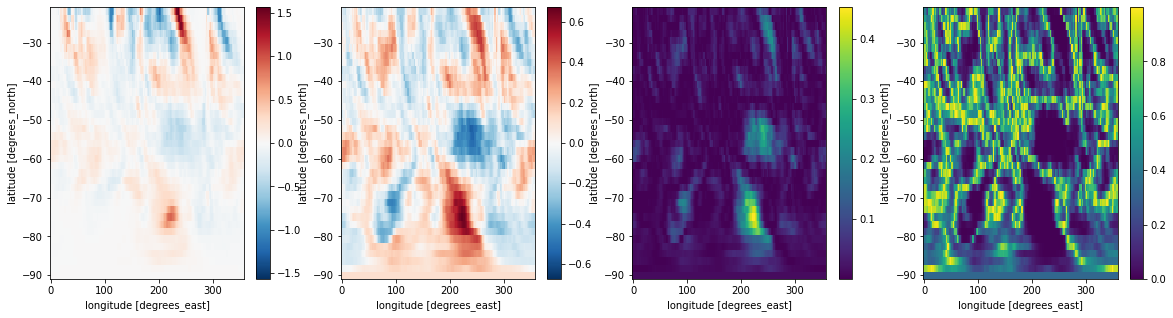

In [69]:
# use xarray to make a tester plot of the r values and p values to see the range to be sure looks about right 
fig = plt.figure(figsize=(20,5))

rsquared = r_value_psa1_djf*r_value_psa1_djf #multiplying rval * rval to get rsquared

ax = plt.subplot(1,4,1)
slope_psa1_djf.plot()

ax = plt.subplot(1,4,2)
r_value_psa1_djf.plot()

ax = plt.subplot(1,4,3)
rsquared.plot()

ax = plt.subplot(1,4,4)
p_value_psa1_djf.plot()

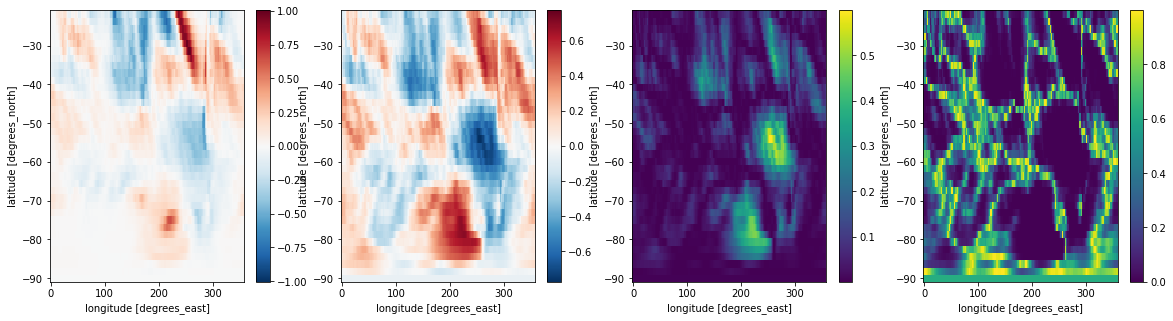

In [70]:
# use xarray to make a tester plot of the r values and p values to see the range to be sure looks about right 
fig = plt.figure(figsize=(20,5))

rsquared = r_value_psa1_ann_mean*r_value_psa1_ann_mean #multiplying rval * rval to get rsquared

ax = plt.subplot(1,4,1)
slope_psa1_ann_mean.plot()

ax = plt.subplot(1,4,2)
r_value_psa1_ann_mean.plot()

ax = plt.subplot(1,4,3)
rsquared.plot()

ax = plt.subplot(1,4,4)
p_value_psa1_ann_mean.plot()

#### Now make a matrix of numbers and NaNs where the rsquared and pvals meet certain criteria

In [71]:
# threshold_rsquared = 0.5
# threshold_pval = 0.01

# stipple = rsquared.where(rsquared > threshold_rsquared) #note that the xarray where command keeps all values meeting criteria, others nan/missing
# stipple = stipple.where(p_value_annual < threshold_pval) #now find everywhere pvals meet threshold (AKA significant)
# stipple = stipple.where(xr.ufuncs.logical_not(stipple > 0) , 1) #OK, now we should have rsquared vals where significant, missing/zero where not, so let's replace rsquared with 1 so we have missing/zero and 1 values

# stipple

In [72]:
######  Ideas For Statistical Significance of the Regression Slope   ######

pval_threshold = 0.05
r2_threshold   = 0.15

#Contour where the p-value is below threshold
modify1_p_value_psa1_djf = p_value_psa1_djf.where(p_value_psa1_djf <= pval_threshold, 0)  #select values below threshold, others equal 0
modify2_p_value_psa1_djf = modify1_p_value_psa1_djf.where(modify1_p_value_psa1_djf == 0, 1)  #change values below threshold to be equal to 1.  Now have array of 0 and 1s

modify1_p_value_psa1_jja = p_value_psa1_jja.where(p_value_psa1_jja <= pval_threshold, 0)  #select values below threshold, others equal 0
modify2_p_value_psa1_jja = modify1_p_value_psa1_jja.where(modify1_p_value_psa1_jja == 0, 1)  #change values below threshold to be equal to 1.  Now have array of 0 and 1s

modify1_p_value_psa1_ann_mean = p_value_psa1_ann_mean.where(p_value_psa1_ann_mean <= pval_threshold, 0)  #select values below threshold, others equal 0
modify2_p_value_psa1_ann_mean = modify1_p_value_psa1_ann_mean.where(modify1_p_value_psa1_ann_mean == 0, 1)  #change values below threshold to be equal to 1.  Now have array of 0 and 1s

#Contour where the r-squared is above threshold
modify1_r2_value_psa1_djf = r2_value_psa1_djf.where(r2_value_psa1_djf >= r2_threshold, 0)  #select values below threshold, others equal 0
modify2_r2_value_psa1_djf = modify1_r2_value_psa1_djf.where(modify1_r2_value_psa1_djf == 0, 1)  #change values below threshold to be equal to 1.  Now have array of 0 and 1s

modify1_r2_value_psa1_jja = r2_value_psa1_jja.where(r2_value_psa1_jja >= r2_threshold, 0)  #select values below threshold, others equal 0
modify2_r2_value_psa1_jja = modify1_r2_value_psa1_jja.where(modify1_r2_value_psa1_jja == 0, 1)  #change values below threshold to be equal to 1.  Now have array of 0 and 1s

modify1_r2_value_psa1_ann_mean = r2_value_psa1_ann_mean.where(r2_value_psa1_ann_mean >= r2_threshold, 0)  #select values below threshold, others equal 0
modify2_r2_value_psa1_ann_mean = modify1_r2_value_psa1_ann_mean.where(modify1_r2_value_psa1_ann_mean == 0, 1)  #change values below threshold to be equal to 1.  Now have array of 0 and 1s

#Combine the two criteria
threshold_r2_p_value_psa1_djf = modify2_r2_value_psa1_djf.where(modify2_p_value_psa1_djf == 1, 0)
threshold_r2_p_value_psa1_jja = modify2_r2_value_psa1_jja.where(modify2_p_value_psa1_jja == 1, 0)
threshold_r2_p_value_psa1_ann_mean = modify2_r2_value_psa1_ann_mean.where(modify2_p_value_psa1_ann_mean == 1, 0)

/glade/work/pgoddard/NEW_ANACONDA_AND_PY_ENV_24Mar2021/geo_scipy/lib/python3.7/site-packages/cartopy/util.py:102: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  new_data = ma.concatenate((data, data[slicer]), axis=axis)
/glade/work/pgoddard/NEW_ANACONDA_AND_PY_ENV_24Mar2021/geo_scipy/lib/python3.7/site-packages/ipykernel_launcher.py:39: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.


-5.106986103323708 -4.515817744437799


/glade/work/pgoddard/NEW_ANACONDA_AND_PY_ENV_24Mar2021/geo_scipy/lib/python3.7/site-packages/ipykernel_launcher.py:129: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.


-9.024108736384415 -8.221795111436869


/glade/work/pgoddard/NEW_ANACONDA_AND_PY_ENV_24Mar2021/geo_scipy/lib/python3.7/site-packages/ipykernel_launcher.py:217: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.


-6.138386531665141 -5.635352124021916


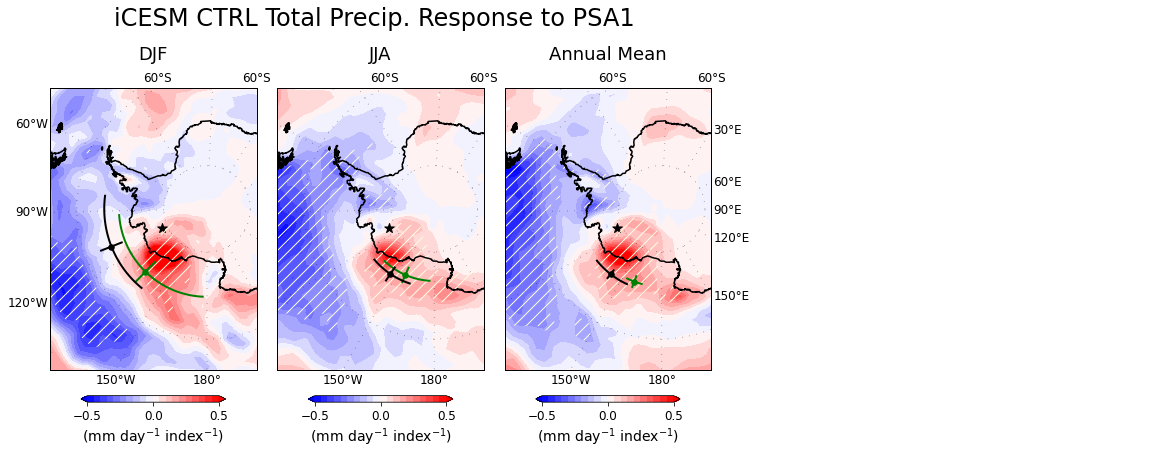

In [73]:
fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(20,6), sharex=True, sharey=True)
fig.subplots_adjust(hspace=0.0, wspace=0.1)
fig.suptitle('iCESM CTRL Total Precip. Response to PSA1', fontsize=24, y=1.05, x = 0.35)

# setup Lambert Conformal basemap.

# slope shades -- add cyclic
slope_djf_sh, lons = add_cyclic_point(slope_psa1_djf.values, CTRL_DATA.coords['lon'].values, axis=-1)
slope_jja_sh, lons = add_cyclic_point(slope_psa1_jja.values, CTRL_DATA.coords['lon'].values, axis=-1)
slope_ann_mean_sh, lons = add_cyclic_point(slope_psa1_ann_mean.values, CTRL_DATA.coords['lon'].values, axis=-1)
# p-value contour -- add cyclic
p_value_djf_con, lons = add_cyclic_point(modify2_p_value_psa1_djf.values, CTRL_DATA.coords['lon'].values, axis=-1)
p_value_jja_con, lons = add_cyclic_point(modify2_p_value_psa1_jja.values, CTRL_DATA.coords['lon'].values, axis=-1)
p_value_ann_mean_con, lons = add_cyclic_point(modify2_p_value_psa1_ann_mean.values, CTRL_DATA.coords['lon'].values, axis=-1)
# r2-value contour -- add cyclic
r2_value_djf_con, lons = add_cyclic_point(modify2_r2_value_psa1_djf.values, CTRL_DATA.coords['lon'].values, axis=-1)
r2_value_jja_con, lons = add_cyclic_point(modify2_r2_value_psa1_jja.values, CTRL_DATA.coords['lon'].values, axis=-1)
r2_value_ann_mean_con, lons = add_cyclic_point(modify2_r2_value_psa1_ann_mean.values, CTRL_DATA.coords['lon'].values, axis=-1)
# r2 and p-value threshold contour -- add cyclic
threshold_r2_p_value_psa1_djf_con, lons = add_cyclic_point(threshold_r2_p_value_psa1_djf.values, CTRL_DATA.coords['lon'].values, axis=-1)
threshold_r2_p_value_psa1_jja_con, lons = add_cyclic_point(threshold_r2_p_value_psa1_jja.values, CTRL_DATA.coords['lon'].values, axis=-1)
threshold_r2_p_value_psa1_ann_mean_con, lons = add_cyclic_point(threshold_r2_p_value_psa1_ann_mean.values, CTRL_DATA.coords['lon'].values, axis=-1)




lon, lat = np.meshgrid(lons,CTRL_DATA.coords['lat'].sel(lat=slice(shem_ylo, shem_yhi)).values)
levels = np.arange(-0.5,0.55,0.05)
levels_contour = [1]

parallels = np.arange(-80,-1,20)
meridians = np.arange(0,360,30.)
plt.rcParams['contour.negative_linestyle'] = 'solid'
plt.rcParams['text.latex.preamble']=[r"\usepackage{wasysym}"]

#DJF
plt.subplot(1, 5, 1)
m = Basemap(llcrnrlon=-135,llcrnrlat=-40,urcrnrlon=20,urcrnrlat=-60,projection='lcc',
            resolution='l',lat_1=-89.,lat_2=-65,lat_0=-70,lon_0=180.)
x, y = m(lon, lat)
# draw coastlines.
m.drawcoastlines(linewidth=1.5)
m.drawmapboundary(fill_color='white')
# labels = [left,right,top,bottom]
m.drawparallels(parallels,labels=[False,False,True,False],dashes=[.3, 7],fontsize=12)
m.drawmeridians(meridians,labels=[True,False,False,True],dashes=[.3, 7],fontsize=12)
CS = m.contourf(x,y,(slope_djf_sh), levels, cmap=plt.cm.get_cmap('bwr'),extend='both')
#plt.ylabel('V10', fontsize=20)
cbar = plt.colorbar(orientation='horizontal', shrink=0.70, aspect=20, fraction=0.033, pad=0.08)
cbar.set_label(r'(mm day$^{-1}$ index$^{-1}$)',size=14)
cbar.set_ticks([-0.5, 0, 0.5])
cbar.ax.tick_params(labelsize=12)
plt.clim([-0.5,0.5])
#add point for central Psuedo cores
xpt,ypt = m(247.5, -78.63)
plt.scatter(xpt, ypt, c='k', marker='*', s=100)
# CS2 = m.contour(x,y,p_value_djf_con, levels_contour, linewidths=0.35,colors='k')
# CS2 = m.contour(x,y,r2_value_djf_con, levels_contour, linewidths=0.35,colors='k')
# CS2 = m.contour(x,y,threshold_r2_p_value_psa1_djf_con, levels_contour, linewidths=0.35,colors='k')
mpl.rcParams['hatch.color'] = 'lightyellow' #use this line to change stipple color
CS2 = m.contourf(x, y, threshold_r2_p_value_psa1_djf_con, levels = [0,0.5,1], hatches=['','//'], alpha=0)

#add Rel. CP mean location for upper and lower indice
#upper
xpt,ypt = m(djf_Rel_CP_indices_w_upper_PSA1_detrend_ctrl.lons.mean(),
            djf_Rel_CP_indices_w_upper_PSA1_detrend_ctrl.lats.mean()
           )
plt.scatter(xpt, ypt, c='green', marker='o', s=30) #for value dependent: vmin=-10, vmax=0, cmap='green'
#lower
xpt,ypt = m(djf_Rel_CP_indices_w_lower_PSA1_detrend_ctrl.lons.mean(),
            djf_Rel_CP_indices_w_lower_PSA1_detrend_ctrl.lats.mean()
           )
plt.scatter(xpt, ypt, c='k', marker='o', s=30) #for value dependent: vmin=-10, vmax=0, cmap='green'

#Add +- 1std of long and lat
#upper
lat_line = np.linspace(djf_Rel_CP_indices_w_upper_PSA1_detrend_ctrl.lats.mean()
                       ,djf_Rel_CP_indices_w_upper_PSA1_detrend_ctrl.lats.mean()
                       ,100) 
lon_line = np.linspace(djf_Rel_CP_indices_w_upper_PSA1_detrend_ctrl.lons.mean()+djf_Rel_CP_indices_w_upper_PSA1_detrend_ctrl.lons.std()
                       ,djf_Rel_CP_indices_w_upper_PSA1_detrend_ctrl.lons.mean()-djf_Rel_CP_indices_w_upper_PSA1_detrend_ctrl.lons.std()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, color='green', linewidth=2) 

lat_line = np.linspace(djf_Rel_CP_indices_w_upper_PSA1_detrend_ctrl.lats.mean()+djf_Rel_CP_indices_w_upper_PSA1_detrend_ctrl.lats.std()
                       ,djf_Rel_CP_indices_w_upper_PSA1_detrend_ctrl.lats.mean()-djf_Rel_CP_indices_w_upper_PSA1_detrend_ctrl.lats.std()
                       ,100) 
lon_line = np.linspace(djf_Rel_CP_indices_w_upper_PSA1_detrend_ctrl.lons.mean()
                       ,djf_Rel_CP_indices_w_upper_PSA1_detrend_ctrl.lons.mean()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='green', linewidth=2)
#lower
lat_line = np.linspace(djf_Rel_CP_indices_w_lower_PSA1_detrend_ctrl.lats.mean()
                       ,djf_Rel_CP_indices_w_lower_PSA1_detrend_ctrl.lats.mean()
                       ,100) 
lon_line = np.linspace(djf_Rel_CP_indices_w_lower_PSA1_detrend_ctrl.lons.mean()+djf_Rel_CP_indices_w_lower_PSA1_detrend_ctrl.lons.std()
                       ,djf_Rel_CP_indices_w_lower_PSA1_detrend_ctrl.lons.mean()-djf_Rel_CP_indices_w_lower_PSA1_detrend_ctrl.lons.std()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='k', linewidth=2) 

lat_line = np.linspace(djf_Rel_CP_indices_w_lower_PSA1_detrend_ctrl.lats.mean()+djf_Rel_CP_indices_w_lower_PSA1_detrend_ctrl.lats.std()
                       ,djf_Rel_CP_indices_w_lower_PSA1_detrend_ctrl.lats.mean()-djf_Rel_CP_indices_w_lower_PSA1_detrend_ctrl.lats.std()
                       ,100) 
lon_line = np.linspace(djf_Rel_CP_indices_w_lower_PSA1_detrend_ctrl.lons.mean()
                       ,djf_Rel_CP_indices_w_lower_PSA1_detrend_ctrl.lons.mean()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='k', linewidth=2)

# #add point for central Psuedo cores
# xpt,ypt = m(247.5, -78.63)
# plt.scatter(xpt, ypt, c='k', marker='*', s=100)

plt.title('DJF',y=1.08,fontsize=18)
print(djf_Rel_CP_indices_w_upper_PSA1_detrend_ctrl.vals.mean(),djf_Rel_CP_indices_w_lower_PSA1_detrend_ctrl.vals.mean())







#JJA
plt.subplot(1, 5, 2)
m = Basemap(llcrnrlon=-135,llcrnrlat=-40,urcrnrlon=20,urcrnrlat=-60,projection='lcc',
            resolution='l',lat_1=-89.,lat_2=-65,lat_0=-70,lon_0=180.)
x, y = m(lon, lat)
# draw coastlines.
m.drawcoastlines(linewidth=1.5)
m.drawmapboundary(fill_color='white')
# labels = [left,right,top,bottom]
m.drawparallels(parallels,labels=[False,False,True,False],dashes=[.3, 7],fontsize=12)
m.drawmeridians(meridians,labels=[False,False,False,True],dashes=[.3, 7],fontsize=12)
CS = m.contourf(x,y,(slope_jja_sh), levels, cmap=plt.cm.get_cmap('bwr'),extend='both')
#plt.ylabel('V10', fontsize=20)
cbar = plt.colorbar(orientation='horizontal', shrink=0.70, aspect=20, fraction=0.033, pad=0.08)
cbar.set_label(r'(mm day$^{-1}$ index$^{-1}$)',size=14)
cbar.set_ticks([-0.5, 0, 0.5])
cbar.ax.tick_params(labelsize=12)
plt.clim([-0.5,0.5])
#add point for central Psuedo cores
xpt,ypt = m(247.5, -78.63)
plt.scatter(xpt, ypt, c='k', marker='*', s=100)
# CS2 = m.contour(x,y,p_value_jja_con,levels_contour,linewidths=0.35,colors='k')
# CS2 = m.contour(x,y,r2_value_jja_con, levels_contour, linewidths=0.35,colors='k')
# CS2 = m.contour(x,y,threshold_r2_p_value_psa1_jja_con, levels_contour, linewidths=0.35,colors='k')
mpl.rcParams['hatch.color'] = 'lightyellow' #use this line to change stipple color
CS2 = m.contourf(x, y, threshold_r2_p_value_psa1_jja_con, levels = [0,0.5,1], hatches=['','//'], alpha=0)

#add Rel. CP mean location for upper and lower indice
#upper
xpt,ypt = m(jja_Rel_CP_indices_w_upper_PSA1_detrend_ctrl.lons.mean(),
            jja_Rel_CP_indices_w_upper_PSA1_detrend_ctrl.lats.mean()
           )
plt.scatter(xpt, ypt, c='green', marker='o', s=30) #for value dependent: vmin=-10, vmax=0, cmap='green'
#lower
xpt,ypt = m(jja_Rel_CP_indices_w_lower_PSA1_detrend_ctrl.lons.mean(),
            jja_Rel_CP_indices_w_lower_PSA1_detrend_ctrl.lats.mean()
           )
plt.scatter(xpt, ypt, c='k', marker='o', s=30) #for value dependent: vmin=-10, vmax=0, cmap='green'

#Add +- 1std of long and lat
#upper
lat_line = np.linspace(jja_Rel_CP_indices_w_upper_PSA1_detrend_ctrl.lats.mean()
                       ,jja_Rel_CP_indices_w_upper_PSA1_detrend_ctrl.lats.mean()
                       ,100) 
lon_line = np.linspace(jja_Rel_CP_indices_w_upper_PSA1_detrend_ctrl.lons.mean()+jja_Rel_CP_indices_w_upper_PSA1_detrend_ctrl.lons.std()
                       ,jja_Rel_CP_indices_w_upper_PSA1_detrend_ctrl.lons.mean()-jja_Rel_CP_indices_w_upper_PSA1_detrend_ctrl.lons.std()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, color='green', linewidth=2) 

lat_line = np.linspace(jja_Rel_CP_indices_w_upper_PSA1_detrend_ctrl.lats.mean()+jja_Rel_CP_indices_w_upper_PSA1_detrend_ctrl.lats.std()
                       ,jja_Rel_CP_indices_w_upper_PSA1_detrend_ctrl.lats.mean()-jja_Rel_CP_indices_w_upper_PSA1_detrend_ctrl.lats.std()
                       ,100) 
lon_line = np.linspace(jja_Rel_CP_indices_w_upper_PSA1_detrend_ctrl.lons.mean()
                       ,jja_Rel_CP_indices_w_upper_PSA1_detrend_ctrl.lons.mean()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='green', linewidth=2)
#lower
lat_line = np.linspace(jja_Rel_CP_indices_w_lower_PSA1_detrend_ctrl.lats.mean()
                       ,jja_Rel_CP_indices_w_lower_PSA1_detrend_ctrl.lats.mean()
                       ,100) 
lon_line = np.linspace(jja_Rel_CP_indices_w_lower_PSA1_detrend_ctrl.lons.mean()+jja_Rel_CP_indices_w_lower_PSA1_detrend_ctrl.lons.std()
                       ,jja_Rel_CP_indices_w_lower_PSA1_detrend_ctrl.lons.mean()-jja_Rel_CP_indices_w_lower_PSA1_detrend_ctrl.lons.std()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='k', linewidth=2) 

lat_line = np.linspace(jja_Rel_CP_indices_w_lower_PSA1_detrend_ctrl.lats.mean()+jja_Rel_CP_indices_w_lower_PSA1_detrend_ctrl.lats.std()
                       ,jja_Rel_CP_indices_w_lower_PSA1_detrend_ctrl.lats.mean()-jja_Rel_CP_indices_w_lower_PSA1_detrend_ctrl.lats.std()
                       ,100) 
lon_line = np.linspace(jja_Rel_CP_indices_w_lower_PSA1_detrend_ctrl.lons.mean()
                       ,jja_Rel_CP_indices_w_lower_PSA1_detrend_ctrl.lons.mean()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='k', linewidth=2)

# #add point for central Psuedo cores
# xpt,ypt = m(247.5, -78.63)
# plt.scatter(xpt, ypt, c='k', marker='*', s=100)

plt.title('JJA',y=1.08,fontsize=18)
print(jja_Rel_CP_indices_w_upper_PSA1_detrend_ctrl.vals.mean(),jja_Rel_CP_indices_w_lower_PSA1_detrend_ctrl.vals.mean())





#Annual Mean
plt.subplot(1, 5, 3)
m = Basemap(llcrnrlon=-135,llcrnrlat=-40,urcrnrlon=20,urcrnrlat=-60,projection='lcc',
            resolution='l',lat_1=-89.,lat_2=-65,lat_0=-70,lon_0=180.)
x, y = m(lon, lat)
# draw coastlines.
m.drawcoastlines(linewidth=1.5)
m.drawmapboundary(fill_color='white')
# labels = [left,right,top,bottom]
m.drawparallels(parallels,labels=[False,False,True,False],dashes=[.3, 7],fontsize=12)
m.drawmeridians(meridians,labels=[False,True,False,True],dashes=[.3, 7],fontsize=12)
CS = m.contourf(x,y,(slope_ann_mean_sh), levels, cmap=plt.cm.get_cmap('bwr'),extend='both')
#plt.ylabel('V10', fontsize=20)
cbar = plt.colorbar(orientation='horizontal', shrink=0.70, aspect=20, fraction=0.033, pad=0.08)
cbar.set_label(r'(mm day$^{-1}$ index$^{-1}$)',size=14)
cbar.set_ticks([-0.5, 0, 0.5])
cbar.ax.tick_params(labelsize=12)
plt.clim([-0.5,0.5])
#add point for central Psuedo cores
xpt,ypt = m(247.5, -78.63)
plt.scatter(xpt, ypt, c='k', marker='*', s=100)
# CS2 = m.contour(x,y,p_value_ann_mean_con,levels_contour,linewidths=0.35,colors='k')
# CS2 = m.contour(x,y,r2_value_ann_mean_con, levels_contour, linewidths=0.35,colors='k')
# CS2 = m.contour(x,y,threshold_r2_p_value_psa1_ann_mean_con, levels_contour, linewidths=0.35,colors='k')
mpl.rcParams['hatch.color'] = 'lightyellow' #use this line to change stipple color
CS2 = m.contourf(x, y, threshold_r2_p_value_psa1_ann_mean_con, levels = [0,0.5,1], hatches=['','//'], alpha=0)

#add Rel. CP mean location for upper and lower indice
#upper
xpt,ypt = m(ann_mean_Rel_CP_indices_w_upper_PSA1_detrend_ctrl.lons.mean(),
            ann_mean_Rel_CP_indices_w_upper_PSA1_detrend_ctrl.lats.mean()
           )
plt.scatter(xpt, ypt, c='green', marker='o', s=30) #for value dependent: vmin=-10, vmax=0, cmap='green'
#lower
xpt,ypt = m(ann_mean_Rel_CP_indices_w_lower_PSA1_detrend_ctrl.lons.mean(),
            ann_mean_Rel_CP_indices_w_lower_PSA1_detrend_ctrl.lats.mean()
           )
plt.scatter(xpt, ypt, c='k', marker='o', s=30) #for value dependent: vmin=-10, vmax=0, cmap='green'

#Add +- 1std of long and lat
#upper
lat_line = np.linspace(ann_mean_Rel_CP_indices_w_upper_PSA1_detrend_ctrl.lats.mean()
                       ,ann_mean_Rel_CP_indices_w_upper_PSA1_detrend_ctrl.lats.mean()
                       ,100) 
lon_line = np.linspace(ann_mean_Rel_CP_indices_w_upper_PSA1_detrend_ctrl.lons.mean()+ann_mean_Rel_CP_indices_w_upper_PSA1_detrend_ctrl.lons.std()
                       ,ann_mean_Rel_CP_indices_w_upper_PSA1_detrend_ctrl.lons.mean()-ann_mean_Rel_CP_indices_w_upper_PSA1_detrend_ctrl.lons.std()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, color='green', linewidth=2) 

lat_line = np.linspace(ann_mean_Rel_CP_indices_w_upper_PSA1_detrend_ctrl.lats.mean()+ann_mean_Rel_CP_indices_w_upper_PSA1_detrend_ctrl.lats.std()
                       ,ann_mean_Rel_CP_indices_w_upper_PSA1_detrend_ctrl.lats.mean()-ann_mean_Rel_CP_indices_w_upper_PSA1_detrend_ctrl.lats.std()
                       ,100) 
lon_line = np.linspace(ann_mean_Rel_CP_indices_w_upper_PSA1_detrend_ctrl.lons.mean()
                       ,ann_mean_Rel_CP_indices_w_upper_PSA1_detrend_ctrl.lons.mean()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='green', linewidth=2)
#lower
lat_line = np.linspace(ann_mean_Rel_CP_indices_w_lower_PSA1_detrend_ctrl.lats.mean()
                       ,ann_mean_Rel_CP_indices_w_lower_PSA1_detrend_ctrl.lats.mean()
                       ,100) 
lon_line = np.linspace(ann_mean_Rel_CP_indices_w_lower_PSA1_detrend_ctrl.lons.mean()+ann_mean_Rel_CP_indices_w_lower_PSA1_detrend_ctrl.lons.std()
                       ,ann_mean_Rel_CP_indices_w_lower_PSA1_detrend_ctrl.lons.mean()-ann_mean_Rel_CP_indices_w_lower_PSA1_detrend_ctrl.lons.std()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='k', linewidth=2) 

lat_line = np.linspace(ann_mean_Rel_CP_indices_w_lower_PSA1_detrend_ctrl.lats.mean()+ann_mean_Rel_CP_indices_w_lower_PSA1_detrend_ctrl.lats.std()
                       ,ann_mean_Rel_CP_indices_w_lower_PSA1_detrend_ctrl.lats.mean()-ann_mean_Rel_CP_indices_w_lower_PSA1_detrend_ctrl.lats.std()
                       ,100) 
lon_line = np.linspace(ann_mean_Rel_CP_indices_w_lower_PSA1_detrend_ctrl.lons.mean()
                       ,ann_mean_Rel_CP_indices_w_lower_PSA1_detrend_ctrl.lons.mean()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='k', linewidth=2)

# #add point for central Psuedo cores
# xpt,ypt = m(247.5, -78.63)
# plt.scatter(xpt, ypt, c='k', marker='*', s=100)

plt.title('Annual Mean',y=1.08,fontsize=18)
print(ann_mean_Rel_CP_indices_w_upper_PSA1_detrend_ctrl.vals.mean(),ann_mean_Rel_CP_indices_w_lower_PSA1_detrend_ctrl.vals.mean())



ax[-2].axis('off')
ax[-1].axis('off')



plt.savefig(FIG_PATH+'/New_Regression_Figure_iCESM_CTRL_TAGGED_tp_Field_vs_PSA1_Quartiles_20210417.pdf',bbox_inches='tight', pad_inches=0.05)




plt.show()

In [74]:
#Indices for WDC location are lat = 6 and lon = -47
# Initialise data to lists.
data = [{'slope': np.round(slope_psa1_djf.isel(lat=6,lon=-45).values,3), 'r-sq': np.round(r2_value_psa1_djf.isel(lat=6,lon=-45).values,3), 'p-val':np.round(p_value_psa1_djf.isel(lat=6,lon=-45).values,3)},
        {'slope': np.round(slope_psa1_jja.isel(lat=6,lon=-45).values,3), 'r-sq': np.round(r2_value_psa1_jja.isel(lat=6,lon=-45).values,3), 'p-val':np.round(p_value_psa1_jja.isel(lat=6,lon=-45).values,3)},
        {'slope': np.round(slope_psa1_ann_mean.isel(lat=6,lon=-45).values,3), 'r-sq': np.round(r2_value_psa1_ann_mean.isel(lat=6,lon=-45).values,3), 'p-val':np.round(p_value_psa1_ann_mean.isel(lat=6,lon=-45).values,3)}]
  
# Creates DataFrame.
df = pd.DataFrame(data, index =['DJF', 'JJA', 'ANN'])
  
# Print the data
df

,slope,r-sq,p-val
DJF,0.102,0.153,0.001
JJA,0.047,0.038,0.094
ANN,0.081,0.143,0.001


### Print Slope as 1D array

In [75]:
# np.savetxt(FIG_PATH+'/Slope_iCESM1_TP_DJF_PSA1.txt',slope_psa1_djf.where(land_tmon_ctrl[22,4:20,72:109] > 0.1).dropna(dim='lat').dropna(dim='lon').values.flatten(), fmt='%.5f', newline=os.linesep)

In [76]:
# np.savetxt(FIG_PATH+'/Slope_iCESM1_TP_JJA_PSA1.txt',slope_psa1_jja.where(land_tmon_ctrl[22,4:20,72:109] > 0.1).dropna(dim='lat').dropna(dim='lon').values.flatten(), fmt='%.5f', newline=os.linesep)

In [77]:
np.savetxt(FIG_PATH+'/Slope_iCESM1_TP_DJF_PSA1.txt',slope_psa1_djf[4:20,72:144].dropna(dim='lat').dropna(dim='lon').values.flatten(), fmt='%.5f', newline=os.linesep)

In [78]:
np.savetxt(FIG_PATH+'/Slope_iCESM1_TP_JJA_PSA1.txt',slope_psa1_jja[4:20,72:144].dropna(dim='lat').dropna(dim='lon').values.flatten(), fmt='%.5f', newline=os.linesep)

#### Regress PSA2 onto TP

In [79]:
#Note, for the time series input, must select the column name and .values

##### PSA2
###djf
slope_psa2_djf, intercept_psa2_djf, r_value_psa2_djf, p_value_psa2_djf, std_err_psa2_djf = xr.apply_ufunc(stats.linregress,
                                                                                 PSA2_djf_mean_ctrl['PSA2'].values,
                                                                                 djf_tp_shem_seas_mean_detrend_ctrl,
                                                                                 input_core_dims=[[''], ['time']], #note depending on name of time dimension this can change
                                                                                 output_core_dims=[[], [], [], [], []],
                                                                                 vectorize=True)
r2_value_psa2_djf = r_value_psa2_djf**2

###jja
slope_psa2_jja, intercept_psa2_jja, r_value_psa2_jja, p_value_psa2_jja, std_err_psa2_jja = xr.apply_ufunc(stats.linregress,
                                                                                 PSA2_jja_mean_ctrl['PSA2'].values,
                                                                                 jja_tp_shem_seas_mean_detrend_ctrl,
                                                                                 input_core_dims=[[''], ['time']], #note depending on name of time dimension this can change
                                                                                 output_core_dims=[[], [], [], [], []],
                                                                                 vectorize=True)
r2_value_psa2_jja = r_value_psa2_jja**2

###ann_mean
slope_psa2_ann_mean, intercept_psa2_ann_mean, r_value_psa2_ann_mean, p_value_psa2_ann_mean, std_err_psa2_ann_mean = xr.apply_ufunc(stats.linregress,
                                                                                 PSA2_ann_mean_ctrl['PSA2'].values,
                                                                                 ann_mean_tp_shem_seas_mean_detrend_ctrl,
                                                                                 input_core_dims=[[''], ['time']], #note depending on name of time dimension this can change
                                                                                 output_core_dims=[[], [], [], [], []],
                                                                                 vectorize=True)
r2_value_psa2_ann_mean = r_value_psa2_ann_mean**2

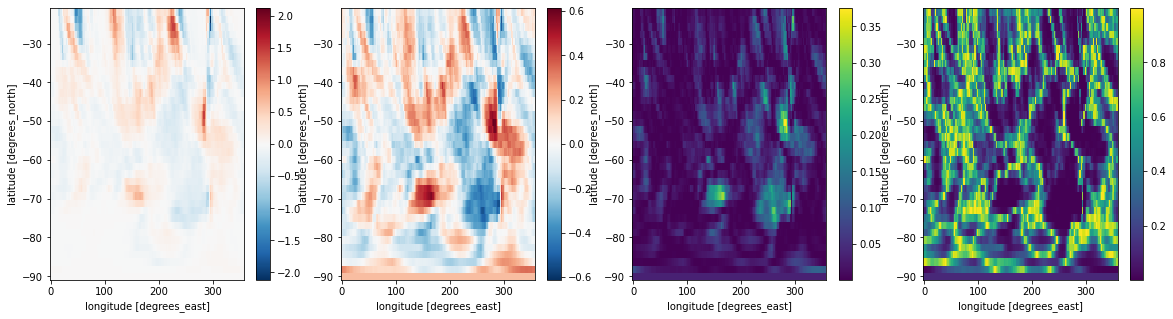

In [80]:
# use xarray to make a tester plot of the r values and p values to see the range to be sure looks about right 
fig = plt.figure(figsize=(20,5))

rsquared = r_value_psa2_djf*r_value_psa2_djf #multiplying rval * rval to get rsquared

ax = plt.subplot(1,4,1)
slope_psa2_djf.plot()

ax = plt.subplot(1,4,2)
r_value_psa2_djf.plot()

ax = plt.subplot(1,4,3)
rsquared.plot()

ax = plt.subplot(1,4,4)
p_value_psa2_djf.plot()

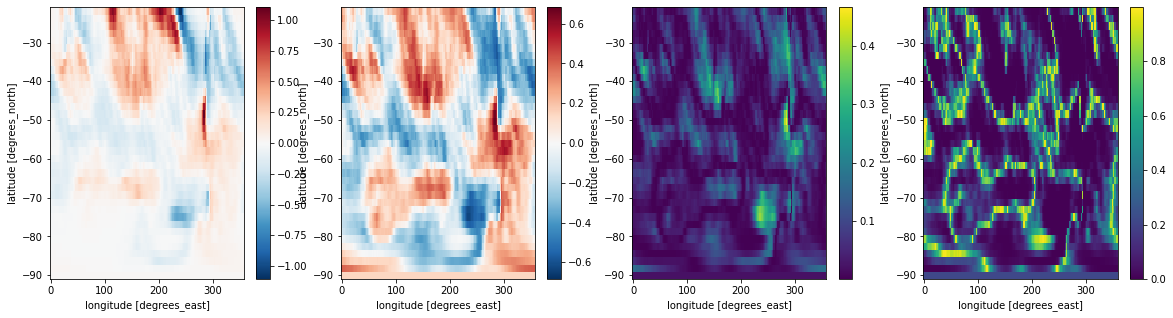

In [81]:
# use xarray to make a tester plot of the r values and p values to see the range to be sure looks about right 
fig = plt.figure(figsize=(20,5))

rsquared = r_value_psa2_ann_mean*r_value_psa2_ann_mean #multiplying rval * rval to get rsquared

ax = plt.subplot(1,4,1)
slope_psa2_ann_mean.plot()

ax = plt.subplot(1,4,2)
r_value_psa2_ann_mean.plot()

ax = plt.subplot(1,4,3)
rsquared.plot()

ax = plt.subplot(1,4,4)
p_value_psa2_ann_mean.plot()

#### Now make a matrix of numbers and NaNs where the rsquared and pvals meet certain criteria

In [82]:
# threshold_rsquared = 0.5
# threshold_pval = 0.01

# stipple = rsquared.where(rsquared > threshold_rsquared) #note that the xarray where command keeps all values meeting criteria, others nan/missing
# stipple = stipple.where(p_value_annual < threshold_pval) #now find everywhere pvals meet threshold (AKA significant)
# stipple = stipple.where(xr.ufuncs.logical_not(stipple > 0) , 1) #OK, now we should have rsquared vals where significant, missing/zero where not, so let's replace rsquared with 1 so we have missing/zero and 1 values

# stipple

In [83]:
######  Ideas For Statistical Significance of the Regression Slope   ######

pval_threshold = 0.05
r2_threshold   = 0.15

#Contour where the p-value is below threshold
modify1_p_value_psa2_djf = p_value_psa2_djf.where(p_value_psa2_djf <= pval_threshold, 0)  #select values below threshold, others equal 0
modify2_p_value_psa2_djf = modify1_p_value_psa2_djf.where(modify1_p_value_psa2_djf == 0, 1)  #change values below threshold to be equal to 1.  Now have array of 0 and 1s

modify1_p_value_psa2_jja = p_value_psa2_jja.where(p_value_psa2_jja <= pval_threshold, 0)  #select values below threshold, others equal 0
modify2_p_value_psa2_jja = modify1_p_value_psa2_jja.where(modify1_p_value_psa2_jja == 0, 1)  #change values below threshold to be equal to 1.  Now have array of 0 and 1s

modify1_p_value_psa2_ann_mean = p_value_psa2_ann_mean.where(p_value_psa2_ann_mean <= pval_threshold, 0)  #select values below threshold, others equal 0
modify2_p_value_psa2_ann_mean = modify1_p_value_psa2_ann_mean.where(modify1_p_value_psa2_ann_mean == 0, 1)  #change values below threshold to be equal to 1.  Now have array of 0 and 1s

#Contour where the r-squared is above threshold
modify1_r2_value_psa2_djf = r2_value_psa2_djf.where(r2_value_psa2_djf >= r2_threshold, 0)  #select values below threshold, others equal 0
modify2_r2_value_psa2_djf = modify1_r2_value_psa2_djf.where(modify1_r2_value_psa2_djf == 0, 1)  #change values below threshold to be equal to 1.  Now have array of 0 and 1s

modify1_r2_value_psa2_jja = r2_value_psa2_jja.where(r2_value_psa2_jja >= r2_threshold, 0)  #select values below threshold, others equal 0
modify2_r2_value_psa2_jja = modify1_r2_value_psa2_jja.where(modify1_r2_value_psa2_jja == 0, 1)  #change values below threshold to be equal to 1.  Now have array of 0 and 1s

modify1_r2_value_psa2_ann_mean = r2_value_psa2_ann_mean.where(r2_value_psa2_ann_mean >= r2_threshold, 0)  #select values below threshold, others equal 0
modify2_r2_value_psa2_ann_mean = modify1_r2_value_psa2_ann_mean.where(modify1_r2_value_psa2_ann_mean == 0, 1)  #change values below threshold to be equal to 1.  Now have array of 0 and 1s

#Combine the two criteria
threshold_r2_p_value_psa2_djf = modify2_r2_value_psa2_djf.where(modify2_p_value_psa2_djf == 1, 0)
threshold_r2_p_value_psa2_jja = modify2_r2_value_psa2_jja.where(modify2_p_value_psa2_jja == 1, 0)
threshold_r2_p_value_psa2_ann_mean = modify2_r2_value_psa2_ann_mean.where(modify2_p_value_psa2_ann_mean == 1, 0)

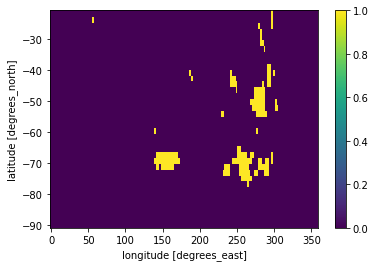

In [84]:
threshold_r2_p_value_psa2_djf.plot() #So, if stippling, we'd want to stipple where 1's are


/glade/work/pgoddard/NEW_ANACONDA_AND_PY_ENV_24Mar2021/geo_scipy/lib/python3.7/site-packages/cartopy/util.py:102: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  new_data = ma.concatenate((data, data[slicer]), axis=axis)
/glade/work/pgoddard/NEW_ANACONDA_AND_PY_ENV_24Mar2021/geo_scipy/lib/python3.7/site-packages/ipykernel_launcher.py:39: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.


-5.374876643481325 -4.486435325784612


/glade/work/pgoddard/NEW_ANACONDA_AND_PY_ENV_24Mar2021/geo_scipy/lib/python3.7/site-packages/ipykernel_launcher.py:129: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.


-7.786907935729884 -10.248190862856978


/glade/work/pgoddard/NEW_ANACONDA_AND_PY_ENV_24Mar2021/geo_scipy/lib/python3.7/site-packages/ipykernel_launcher.py:217: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.


-5.365339134086364 -6.6296034630651155


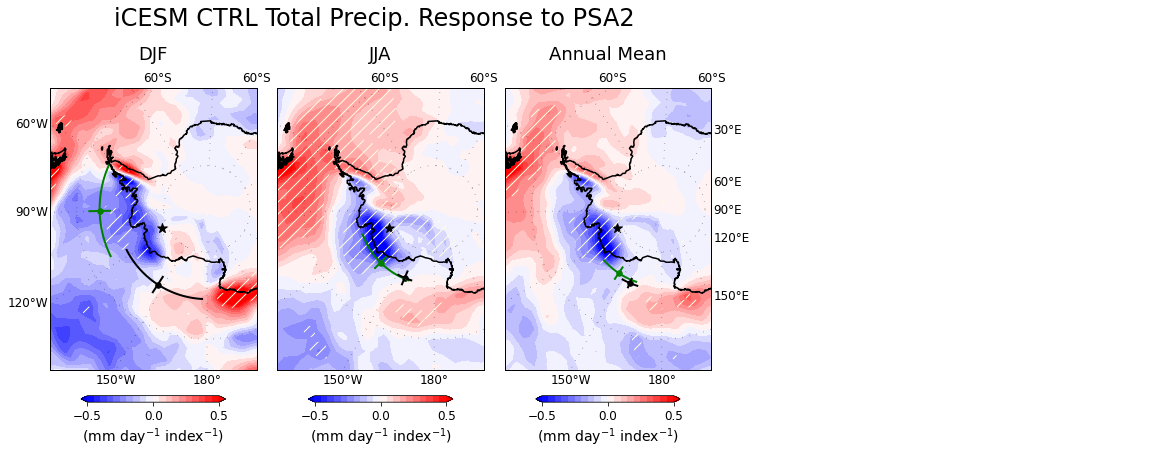

In [85]:
fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(20,6), sharex=True, sharey=True)
fig.subplots_adjust(hspace=0.0, wspace=0.1)
fig.suptitle('iCESM CTRL Total Precip. Response to PSA2', fontsize=24, y=1.05, x = 0.35)

# setup Lambert Conformal basemap.

# slope shades -- add cyclic
slope_djf_sh, lons = add_cyclic_point(slope_psa2_djf.values, CTRL_DATA.coords['lon'].values, axis=-1)
slope_jja_sh, lons = add_cyclic_point(slope_psa2_jja.values, CTRL_DATA.coords['lon'].values, axis=-1)
slope_ann_mean_sh, lons = add_cyclic_point(slope_psa2_ann_mean.values, CTRL_DATA.coords['lon'].values, axis=-1)
# p-value contour -- add cyclic
p_value_djf_con, lons = add_cyclic_point(modify2_p_value_psa2_djf.values, CTRL_DATA.coords['lon'].values, axis=-1)
p_value_jja_con, lons = add_cyclic_point(modify2_p_value_psa2_jja.values, CTRL_DATA.coords['lon'].values, axis=-1)
p_value_ann_mean_con, lons = add_cyclic_point(modify2_p_value_psa2_ann_mean.values, CTRL_DATA.coords['lon'].values, axis=-1)
# r2-value contour -- add cyclic
r2_value_djf_con, lons = add_cyclic_point(modify2_r2_value_psa2_djf.values, CTRL_DATA.coords['lon'].values, axis=-1)
r2_value_jja_con, lons = add_cyclic_point(modify2_r2_value_psa2_jja.values, CTRL_DATA.coords['lon'].values, axis=-1)
r2_value_ann_mean_con, lons = add_cyclic_point(modify2_r2_value_psa2_ann_mean.values, CTRL_DATA.coords['lon'].values, axis=-1)
# r2 and p-value threshold contour -- add cyclic
threshold_r2_p_value_psa2_djf_con, lons = add_cyclic_point(threshold_r2_p_value_psa2_djf.values, CTRL_DATA.coords['lon'].values, axis=-1)
threshold_r2_p_value_psa2_jja_con, lons = add_cyclic_point(threshold_r2_p_value_psa2_jja.values, CTRL_DATA.coords['lon'].values, axis=-1)
threshold_r2_p_value_psa2_ann_mean_con, lons = add_cyclic_point(threshold_r2_p_value_psa2_ann_mean.values, CTRL_DATA.coords['lon'].values, axis=-1)




lon, lat = np.meshgrid(lons,CTRL_DATA.coords['lat'].sel(lat=slice(shem_ylo, shem_yhi)).values)
levels = np.arange(-0.5,0.55,0.05)
levels_contour = [1]

parallels = np.arange(-80,-1,20)
meridians = np.arange(0,360,30.)
plt.rcParams['contour.negative_linestyle'] = 'solid'
plt.rcParams['text.latex.preamble']=[r"\usepackage{wasysym}"]

#DJF
plt.subplot(1, 5, 1)
m = Basemap(llcrnrlon=-135,llcrnrlat=-40,urcrnrlon=20,urcrnrlat=-60,projection='lcc',
            resolution='l',lat_1=-89.,lat_2=-65,lat_0=-70,lon_0=180.)
x, y = m(lon, lat)
# draw coastlines.
m.drawcoastlines(linewidth=1.5)
m.drawmapboundary(fill_color='white')
# labels = [left,right,top,bottom]
m.drawparallels(parallels,labels=[False,False,True,False],dashes=[.3, 7],fontsize=12)
m.drawmeridians(meridians,labels=[True,False,False,True],dashes=[.3, 7],fontsize=12)
CS = m.contourf(x,y,(slope_djf_sh), levels, cmap=plt.cm.get_cmap('bwr'),extend='both')
#plt.ylabel('V10', fontsize=20)
cbar = plt.colorbar(orientation='horizontal', shrink=0.70, aspect=20, fraction=0.033, pad=0.08)
cbar.set_label(r'(mm day$^{-1}$ index$^{-1}$)',size=14)
cbar.set_ticks([-0.5, 0, 0.5])
cbar.ax.tick_params(labelsize=12)
plt.clim([-0.5,0.5])
#add point for central Psuedo cores
xpt,ypt = m(247.5, -78.63)
plt.scatter(xpt, ypt, c='k', marker='*', s=100)
# CS2 = m.contour(x,y,p_value_djf_con, levels_contour, linewidths=0.35,colors='k')
# CS2 = m.contour(x,y,r2_value_djf_con, levels_contour, linewidths=0.35,colors='k')
# CS2 = m.contour(x,y,threshold_r2_p_value_psa2_djf_con, levels_contour, linewidths=0.35,colors='k')
mpl.rcParams['hatch.color'] = 'lightyellow' #use this line to change stipple color
CS2 = m.contourf(x, y, threshold_r2_p_value_psa2_djf_con, levels = [0,0.5,1], hatches=['','//'], alpha=0)

#add Rel. CP mean location for upper and lower indice
#upper
xpt,ypt = m(djf_Rel_CP_indices_w_upper_PSA2_detrend_ctrl.lons.mean(),
            djf_Rel_CP_indices_w_upper_PSA2_detrend_ctrl.lats.mean()
           )
plt.scatter(xpt, ypt, c='green', marker='o', s=30) #for value dependent: vmin=-10, vmax=0, cmap='green'
#lower
xpt,ypt = m(djf_Rel_CP_indices_w_lower_PSA2_detrend_ctrl.lons.mean(),
            djf_Rel_CP_indices_w_lower_PSA2_detrend_ctrl.lats.mean()
           )
plt.scatter(xpt, ypt, c='k', marker='o', s=30) #for value dependent: vmin=-10, vmax=0, cmap='green'

#Add +- 1std of long and lat
#upper
lat_line = np.linspace(djf_Rel_CP_indices_w_upper_PSA2_detrend_ctrl.lats.mean()
                       ,djf_Rel_CP_indices_w_upper_PSA2_detrend_ctrl.lats.mean()
                       ,100) 
lon_line = np.linspace(djf_Rel_CP_indices_w_upper_PSA2_detrend_ctrl.lons.mean()+djf_Rel_CP_indices_w_upper_PSA2_detrend_ctrl.lons.std()
                       ,djf_Rel_CP_indices_w_upper_PSA2_detrend_ctrl.lons.mean()-djf_Rel_CP_indices_w_upper_PSA2_detrend_ctrl.lons.std()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, color='green', linewidth=2) 

lat_line = np.linspace(djf_Rel_CP_indices_w_upper_PSA2_detrend_ctrl.lats.mean()+djf_Rel_CP_indices_w_upper_PSA2_detrend_ctrl.lats.std()
                       ,djf_Rel_CP_indices_w_upper_PSA2_detrend_ctrl.lats.mean()-djf_Rel_CP_indices_w_upper_PSA2_detrend_ctrl.lats.std()
                       ,100) 
lon_line = np.linspace(djf_Rel_CP_indices_w_upper_PSA2_detrend_ctrl.lons.mean()
                       ,djf_Rel_CP_indices_w_upper_PSA2_detrend_ctrl.lons.mean()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='green', linewidth=2)
#lower
lat_line = np.linspace(djf_Rel_CP_indices_w_lower_PSA2_detrend_ctrl.lats.mean()
                       ,djf_Rel_CP_indices_w_lower_PSA2_detrend_ctrl.lats.mean()
                       ,100) 
lon_line = np.linspace(djf_Rel_CP_indices_w_lower_PSA2_detrend_ctrl.lons.mean()+djf_Rel_CP_indices_w_lower_PSA2_detrend_ctrl.lons.std()
                       ,djf_Rel_CP_indices_w_lower_PSA2_detrend_ctrl.lons.mean()-djf_Rel_CP_indices_w_lower_PSA2_detrend_ctrl.lons.std()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='k', linewidth=2) 

lat_line = np.linspace(djf_Rel_CP_indices_w_lower_PSA2_detrend_ctrl.lats.mean()+djf_Rel_CP_indices_w_lower_PSA2_detrend_ctrl.lats.std()
                       ,djf_Rel_CP_indices_w_lower_PSA2_detrend_ctrl.lats.mean()-djf_Rel_CP_indices_w_lower_PSA2_detrend_ctrl.lats.std()
                       ,100) 
lon_line = np.linspace(djf_Rel_CP_indices_w_lower_PSA2_detrend_ctrl.lons.mean()
                       ,djf_Rel_CP_indices_w_lower_PSA2_detrend_ctrl.lons.mean()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='k', linewidth=2)

# #add point for central Psuedo cores
# xpt,ypt = m(247.5, -78.63)
# plt.scatter(xpt, ypt, c='k', marker='*', s=100)

plt.title('DJF',y=1.08,fontsize=18)
print(djf_Rel_CP_indices_w_upper_PSA2_detrend_ctrl.vals.mean(),djf_Rel_CP_indices_w_lower_PSA2_detrend_ctrl.vals.mean())







#JJA
plt.subplot(1, 5, 2)
m = Basemap(llcrnrlon=-135,llcrnrlat=-40,urcrnrlon=20,urcrnrlat=-60,projection='lcc',
            resolution='l',lat_1=-89.,lat_2=-65,lat_0=-70,lon_0=180.)
x, y = m(lon, lat)
# draw coastlines.
m.drawcoastlines(linewidth=1.5)
m.drawmapboundary(fill_color='white')
# labels = [left,right,top,bottom]
m.drawparallels(parallels,labels=[False,False,True,False],dashes=[.3, 7],fontsize=12)
m.drawmeridians(meridians,labels=[False,False,False,True],dashes=[.3, 7],fontsize=12)
CS = m.contourf(x,y,(slope_jja_sh), levels, cmap=plt.cm.get_cmap('bwr'),extend='both')
#plt.ylabel('V10', fontsize=20)
cbar = plt.colorbar(orientation='horizontal', shrink=0.70, aspect=20, fraction=0.033, pad=0.08)
cbar.set_label(r'(mm day$^{-1}$ index$^{-1}$)',size=14)
cbar.set_ticks([-0.5, 0, 0.5])
cbar.ax.tick_params(labelsize=12)
plt.clim([-0.5,0.5])
#add point for central Psuedo cores
xpt,ypt = m(247.5, -78.63)
plt.scatter(xpt, ypt, c='k', marker='*', s=100)
# CS2 = m.contour(x,y,p_value_jja_con,levels_contour,linewidths=0.35,colors='k')
# CS2 = m.contour(x,y,r2_value_jja_con, levels_contour, linewidths=0.35,colors='k')
# CS2 = m.contour(x,y,threshold_r2_p_value_psa2_jja_con, levels_contour, linewidths=0.35,colors='orange')
mpl.rcParams['hatch.color'] = 'lightyellow' #use this line to change stipple color
CS2 = m.contourf(x, y, threshold_r2_p_value_psa2_jja_con, levels = [0,0.5,1], hatches=['','//'], alpha=0)

#add Rel. CP mean location for upper and lower indice
#upper
xpt,ypt = m(jja_Rel_CP_indices_w_upper_PSA2_detrend_ctrl.lons.mean(),
            jja_Rel_CP_indices_w_upper_PSA2_detrend_ctrl.lats.mean()
           )
plt.scatter(xpt, ypt, c='green', marker='o', s=30) #for value dependent: vmin=-10, vmax=0, cmap='green'
#lower
xpt,ypt = m(jja_Rel_CP_indices_w_lower_PSA2_detrend_ctrl.lons.mean(),
            jja_Rel_CP_indices_w_lower_PSA2_detrend_ctrl.lats.mean()
           )
plt.scatter(xpt, ypt, c='k', marker='o', s=30) #for value dependent: vmin=-10, vmax=0, cmap='green'

#Add +- 1std of long and lat
#upper
lat_line = np.linspace(jja_Rel_CP_indices_w_upper_PSA2_detrend_ctrl.lats.mean()
                       ,jja_Rel_CP_indices_w_upper_PSA2_detrend_ctrl.lats.mean()
                       ,100) 
lon_line = np.linspace(jja_Rel_CP_indices_w_upper_PSA2_detrend_ctrl.lons.mean()+jja_Rel_CP_indices_w_upper_PSA2_detrend_ctrl.lons.std()
                       ,jja_Rel_CP_indices_w_upper_PSA2_detrend_ctrl.lons.mean()-jja_Rel_CP_indices_w_upper_PSA2_detrend_ctrl.lons.std()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, color='green', linewidth=2) 

lat_line = np.linspace(jja_Rel_CP_indices_w_upper_PSA2_detrend_ctrl.lats.mean()+jja_Rel_CP_indices_w_upper_PSA2_detrend_ctrl.lats.std()
                       ,jja_Rel_CP_indices_w_upper_PSA2_detrend_ctrl.lats.mean()-jja_Rel_CP_indices_w_upper_PSA2_detrend_ctrl.lats.std()
                       ,100) 
lon_line = np.linspace(jja_Rel_CP_indices_w_upper_PSA2_detrend_ctrl.lons.mean()
                       ,jja_Rel_CP_indices_w_upper_PSA2_detrend_ctrl.lons.mean()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='green', linewidth=2)
#lower
lat_line = np.linspace(jja_Rel_CP_indices_w_lower_PSA2_detrend_ctrl.lats.mean()
                       ,jja_Rel_CP_indices_w_lower_PSA2_detrend_ctrl.lats.mean()
                       ,100) 
lon_line = np.linspace(jja_Rel_CP_indices_w_lower_PSA2_detrend_ctrl.lons.mean()+jja_Rel_CP_indices_w_lower_PSA2_detrend_ctrl.lons.std()
                       ,jja_Rel_CP_indices_w_lower_PSA2_detrend_ctrl.lons.mean()-jja_Rel_CP_indices_w_lower_PSA2_detrend_ctrl.lons.std()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='k', linewidth=2) 

lat_line = np.linspace(jja_Rel_CP_indices_w_lower_PSA2_detrend_ctrl.lats.mean()+jja_Rel_CP_indices_w_lower_PSA2_detrend_ctrl.lats.std()
                       ,jja_Rel_CP_indices_w_lower_PSA2_detrend_ctrl.lats.mean()-jja_Rel_CP_indices_w_lower_PSA2_detrend_ctrl.lats.std()
                       ,100) 
lon_line = np.linspace(jja_Rel_CP_indices_w_lower_PSA2_detrend_ctrl.lons.mean()
                       ,jja_Rel_CP_indices_w_lower_PSA2_detrend_ctrl.lons.mean()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='k', linewidth=2)

#add point for central Psuedo cores
# xpt,ypt = m(247.5, -78.63)
# plt.scatter(xpt, ypt, c='k', marker='*', s=100)

plt.title('JJA',y=1.08,fontsize=18)
print(jja_Rel_CP_indices_w_upper_PSA2_detrend_ctrl.vals.mean(),jja_Rel_CP_indices_w_lower_PSA2_detrend_ctrl.vals.mean())





#Annual Mean
plt.subplot(1, 5, 3)
m = Basemap(llcrnrlon=-135,llcrnrlat=-40,urcrnrlon=20,urcrnrlat=-60,projection='lcc',
            resolution='l',lat_1=-89.,lat_2=-65,lat_0=-70,lon_0=180.)
x, y = m(lon, lat)
# draw coastlines.
m.drawcoastlines(linewidth=1.5)
m.drawmapboundary(fill_color='white')
# labels = [left,right,top,bottom]
m.drawparallels(parallels,labels=[False,False,True,False],dashes=[.3, 7],fontsize=12)
m.drawmeridians(meridians,labels=[False,True,False,True],dashes=[.3, 7],fontsize=12)
CS = m.contourf(x,y,(slope_ann_mean_sh), levels, cmap=plt.cm.get_cmap('bwr'),extend='both')
#plt.ylabel('V10', fontsize=20)
cbar = plt.colorbar(orientation='horizontal', shrink=0.70, aspect=20, fraction=0.033, pad=0.08)
cbar.set_label(r'(mm day$^{-1}$ index$^{-1}$)',size=14)
cbar.set_ticks([-0.5, 0, 0.5])
cbar.ax.tick_params(labelsize=12)
plt.clim([-0.5,0.5])
#add point for central Psuedo cores
xpt,ypt = m(247.5, -78.63)
plt.scatter(xpt, ypt, c='k', marker='*', s=100)
# CS2 = m.contour(x,y,p_value_ann_mean_con,levels_contour,linewidths=0.35,colors='k')
# CS2 = m.contour(x,y,r2_value_ann_mean_con, levels_contour, linewidths=0.35,colors='k')
# CS2 = m.contour(x,y,threshold_r2_p_value_psa2_ann_mean_con, levels_contour, linewidths=0.35,colors='k')
mpl.rcParams['hatch.color'] = 'lightyellow' #use this line to change stipple color
CS2 = m.contourf(x, y, threshold_r2_p_value_psa2_ann_mean_con, levels = [0,0.5,1], hatches=['','//'], alpha=0)

#add Rel. CP mean location for upper and lower indice
#upper
xpt,ypt = m(ann_mean_Rel_CP_indices_w_upper_PSA2_detrend_ctrl.lons.mean(),
            ann_mean_Rel_CP_indices_w_upper_PSA2_detrend_ctrl.lats.mean()
           )
plt.scatter(xpt, ypt, c='green', marker='o', s=30) #for value dependent: vmin=-10, vmax=0, cmap='green'
#lower
xpt,ypt = m(ann_mean_Rel_CP_indices_w_lower_PSA2_detrend_ctrl.lons.mean(),
            ann_mean_Rel_CP_indices_w_lower_PSA2_detrend_ctrl.lats.mean()
           )
plt.scatter(xpt, ypt, c='k', marker='o', s=30) #for value dependent: vmin=-10, vmax=0, cmap='green'

#Add +- 1std of long and lat
#upper
lat_line = np.linspace(ann_mean_Rel_CP_indices_w_upper_PSA2_detrend_ctrl.lats.mean()
                       ,ann_mean_Rel_CP_indices_w_upper_PSA2_detrend_ctrl.lats.mean()
                       ,100) 
lon_line = np.linspace(ann_mean_Rel_CP_indices_w_upper_PSA2_detrend_ctrl.lons.mean()+ann_mean_Rel_CP_indices_w_upper_PSA2_detrend_ctrl.lons.std()
                       ,ann_mean_Rel_CP_indices_w_upper_PSA2_detrend_ctrl.lons.mean()-ann_mean_Rel_CP_indices_w_upper_PSA2_detrend_ctrl.lons.std()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, color='green', linewidth=2) 

lat_line = np.linspace(ann_mean_Rel_CP_indices_w_upper_PSA2_detrend_ctrl.lats.mean()+ann_mean_Rel_CP_indices_w_upper_PSA2_detrend_ctrl.lats.std()
                       ,ann_mean_Rel_CP_indices_w_upper_PSA2_detrend_ctrl.lats.mean()-ann_mean_Rel_CP_indices_w_upper_PSA2_detrend_ctrl.lats.std()
                       ,100) 
lon_line = np.linspace(ann_mean_Rel_CP_indices_w_upper_PSA2_detrend_ctrl.lons.mean()
                       ,ann_mean_Rel_CP_indices_w_upper_PSA2_detrend_ctrl.lons.mean()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='green', linewidth=2)
#lower
lat_line = np.linspace(ann_mean_Rel_CP_indices_w_lower_PSA2_detrend_ctrl.lats.mean()
                       ,ann_mean_Rel_CP_indices_w_lower_PSA2_detrend_ctrl.lats.mean()
                       ,100) 
lon_line = np.linspace(ann_mean_Rel_CP_indices_w_lower_PSA2_detrend_ctrl.lons.mean()+ann_mean_Rel_CP_indices_w_lower_PSA2_detrend_ctrl.lons.std()
                       ,ann_mean_Rel_CP_indices_w_lower_PSA2_detrend_ctrl.lons.mean()-ann_mean_Rel_CP_indices_w_lower_PSA2_detrend_ctrl.lons.std()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='k', linewidth=2) 

lat_line = np.linspace(ann_mean_Rel_CP_indices_w_lower_PSA2_detrend_ctrl.lats.mean()+ann_mean_Rel_CP_indices_w_lower_PSA2_detrend_ctrl.lats.std()
                       ,ann_mean_Rel_CP_indices_w_lower_PSA2_detrend_ctrl.lats.mean()-ann_mean_Rel_CP_indices_w_lower_PSA2_detrend_ctrl.lats.std()
                       ,100) 
lon_line = np.linspace(ann_mean_Rel_CP_indices_w_lower_PSA2_detrend_ctrl.lons.mean()
                       ,ann_mean_Rel_CP_indices_w_lower_PSA2_detrend_ctrl.lons.mean()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='k', linewidth=2)

# #add point for central Psuedo cores
# xpt,ypt = m(247.5, -78.63)
# plt.scatter(xpt, ypt, c='k', marker='*', s=100)

plt.title('Annual Mean',y=1.08,fontsize=18)
print(ann_mean_Rel_CP_indices_w_upper_PSA2_detrend_ctrl.vals.mean(),ann_mean_Rel_CP_indices_w_lower_PSA2_detrend_ctrl.vals.mean())



ax[-2].axis('off')
ax[-1].axis('off')



plt.savefig(FIG_PATH+'/New_Regression_Figure_iCESM_CTRL_TAGGED_tp_Field_vs_PSA2_Quartiles_20210417.pdf',bbox_inches='tight', pad_inches=0.05)




plt.show()

In [86]:
#Indices for WDC location are lat = 6 and lon = -47
# Initialise data to lists.
data = [{'slope': np.round(slope_psa2_djf.isel(lat=6,lon=-45).values,3), 'r-sq': np.round(r2_value_psa2_djf.isel(lat=6,lon=-45).values,3), 'p-val':np.round(p_value_psa2_djf.isel(lat=6,lon=-45).values,3)},
        {'slope': np.round(slope_psa2_jja.isel(lat=6,lon=-45).values,3), 'r-sq': np.round(r2_value_psa2_jja.isel(lat=6,lon=-45).values,3), 'p-val':np.round(p_value_psa2_jja.isel(lat=6,lon=-45).values,3)},
        {'slope': np.round(slope_psa2_ann_mean.isel(lat=6,lon=-45).values,3), 'r-sq': np.round(r2_value_psa2_ann_mean.isel(lat=6,lon=-45).values,3), 'p-val':np.round(p_value_psa2_ann_mean.isel(lat=6,lon=-45).values,3)}]
  
# Creates DataFrame.
df = pd.DataFrame(data, index =['DJF', 'JJA', 'ANN'])
  
# Print the data
df

,slope,r-sq,p-val
DJF,-0.045,0.027,0.163
JJA,-0.159,0.494,0.000
ANN,-0.102,0.183,0.000


### Print Slope as 1D array

In [87]:
# np.savetxt(FIG_PATH+'/Slope_iCESM1_TP_DJF_PSA2.txt',slope_psa2_djf.where(land_tmon_ctrl[22,4:20,72:109] > 0.1).dropna(dim='lat').dropna(dim='lon').values.flatten(), fmt='%.5f', newline=os.linesep)

In [88]:
# np.savetxt(FIG_PATH+'/Slope_iCESM1_TP_JJA_PSA2.txt',slope_psa2_jja.where(land_tmon_ctrl[22,4:20,72:109] > 0.1).dropna(dim='lat').dropna(dim='lon').values.flatten(), fmt='%.5f', newline=os.linesep)

In [89]:
np.savetxt(FIG_PATH+'/Slope_iCESM1_TP_DJF_PSA2.txt',slope_psa2_djf[4:20,72:144].dropna(dim='lat').dropna(dim='lon').values.flatten(), fmt='%.5f', newline=os.linesep)

In [90]:
np.savetxt(FIG_PATH+'/Slope_iCESM1_TP_JJA_PSA2.txt',slope_psa2_jja[4:20,72:144].dropna(dim='lat').dropna(dim='lon').values.flatten(), fmt='%.5f', newline=os.linesep)